<a href="https://colab.research.google.com/github/alezakuskin/Stark_ML/blob/Temperature-tuning/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarkML: Machine Learning-based Tool for Predicting Stark Parameters of Atomic Emission Lines

# Imports

In [ ]:
#!pip install pytorch-tabnet
#!git clone -b Ions https://github.com/alezakuskin/Stark_ML

In [1]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install roman

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
#torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
'''os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)'''

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [2]:
#Download and import all utilities and models
'''if os.path.isdir('Stark_ML'):
    import Stark_ML
    def remove_readonly(func, path, _):
            os.chmod(path, stat.S_IWRITE)
            func(path)
    shutil.rmtree(Stark_ML.__path__.__dict__['_path'][0], onerror = remove_readonly)

!git clone -b Ions https://github.com/alezakuskin/Stark_ML'''

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Data preprocessing

In [3]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BF'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_a['w error (%)'] = uncertainty_to_number(data_a[data_a['w error (%)'].notna()]['w error (%)'])
data_a['d error (%)'] = uncertainty_to_number(data_a[data_a['d error (%)'].notna()]['d error (%)'])

In [4]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BQ'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_i['w error (%)'] = uncertainty_to_number(data_i[data_i['w error (%)'].notna()]['w error (%)'])
data_i['d error (%)'] = uncertainty_to_number(data_i[data_i['d error (%)'].notna()]['d error (%)'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]
data_i = data_i[data_i['J.1'].notna()]

In [5]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
5g
renaming 6d
6d
renaming 7p
7p
5f.1
5g.1
6f
6g
6h
11s


In [6]:
#Merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)

#Incerting "gap to ionization energy" feature
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

In [7]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [8]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[data['w (A)'].isna() == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Remove uncertainty from data
data_width = data_width.drop(columns = ['w error (%)', 'd error (%)'])
data_width_elements = data_width_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [9]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)
#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)
#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = None)
#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = 6)

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

## -- *OPTIONAL*-- Atoms + ions data visual description

In [12]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    5642.000000
mean        1.300316
std         5.435669
min         0.001500
25%         0.143955
50%         0.340000
75%         0.925782
max       180.500000
Name: w (A), dtype: float64


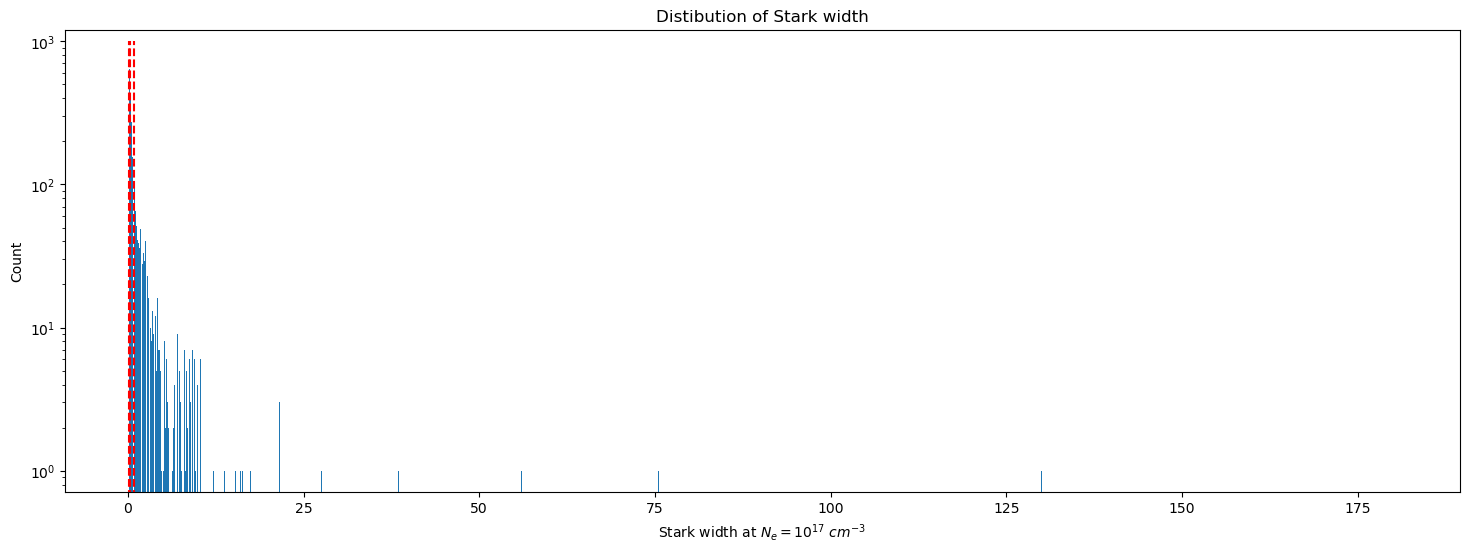

In [13]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

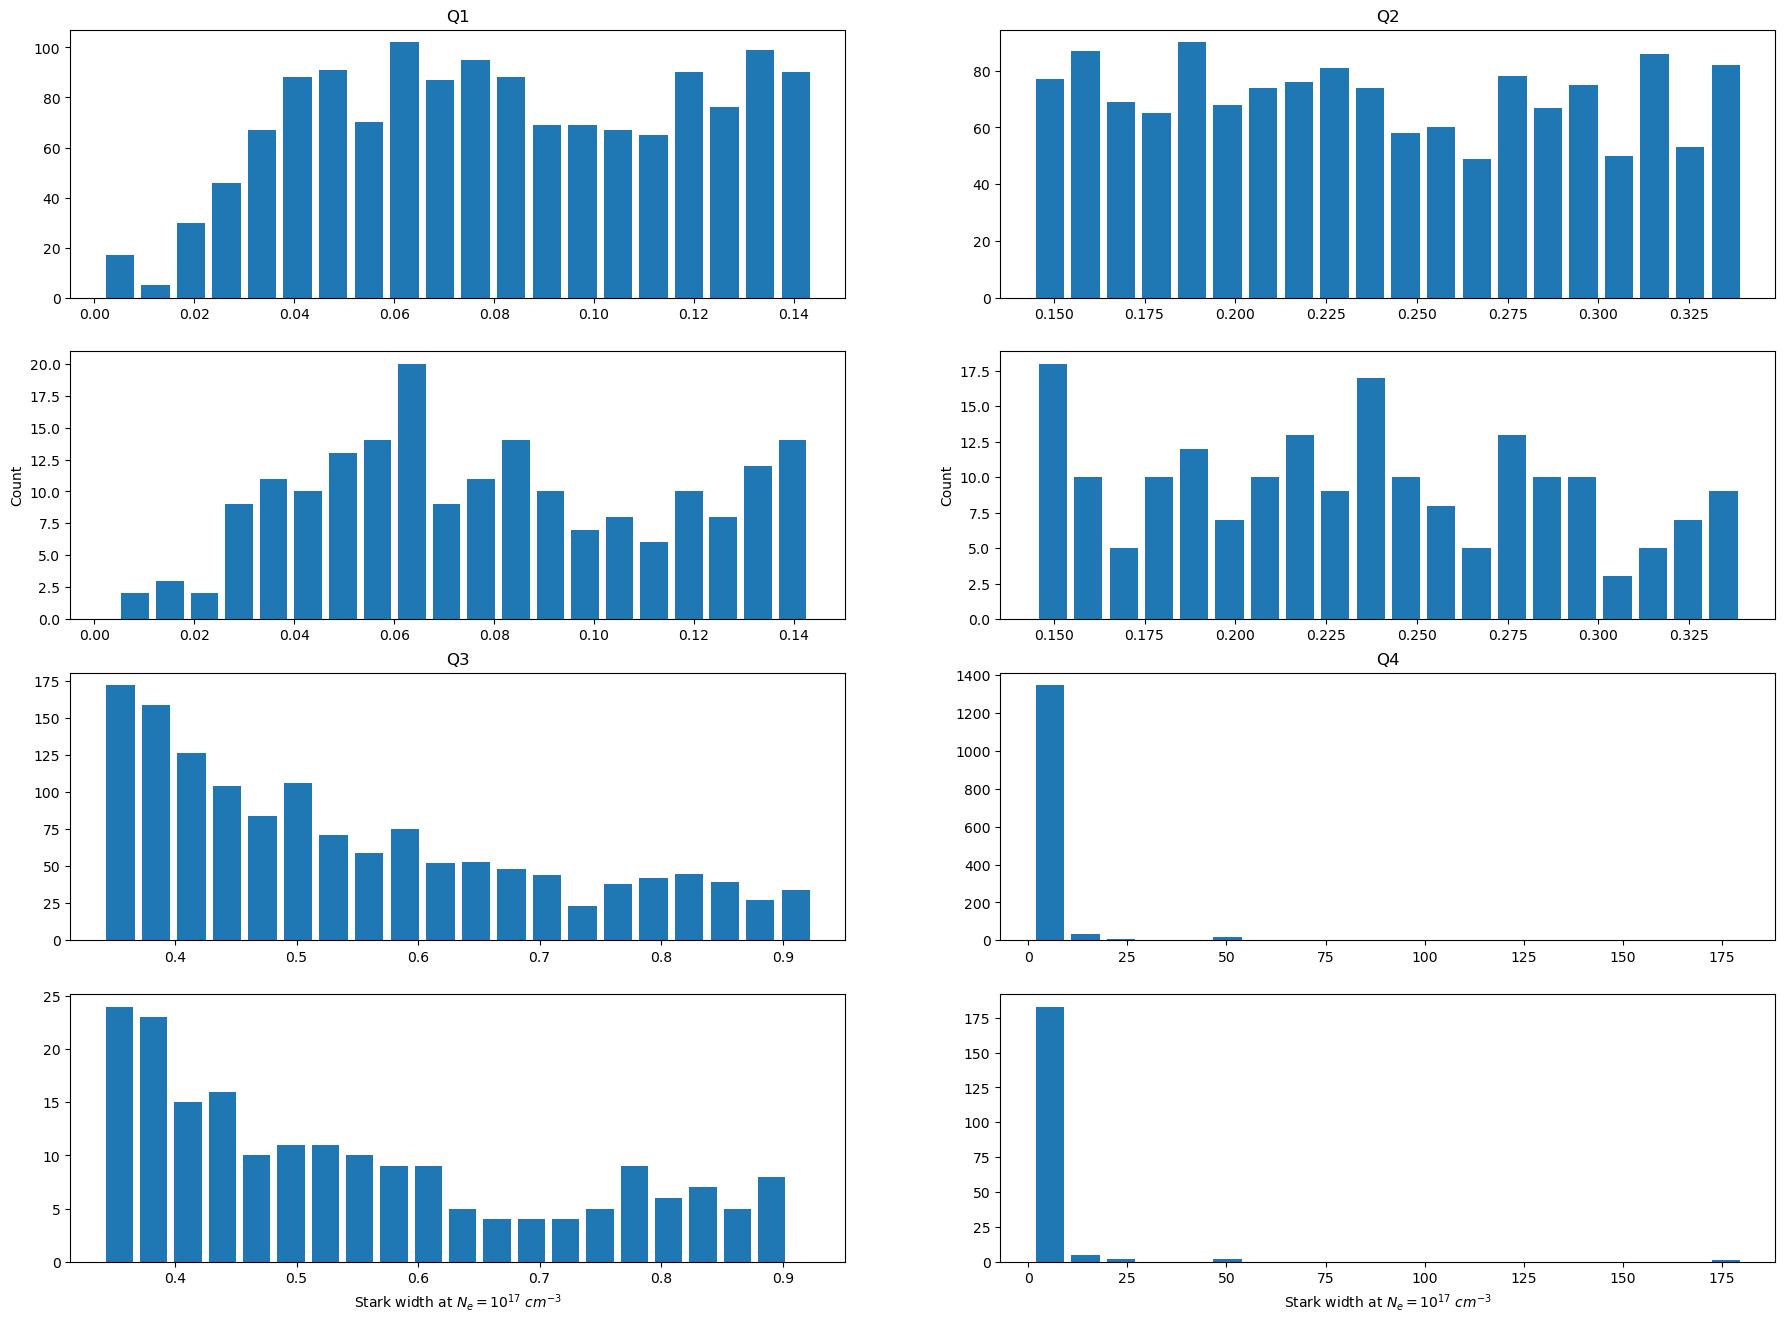

In [14]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

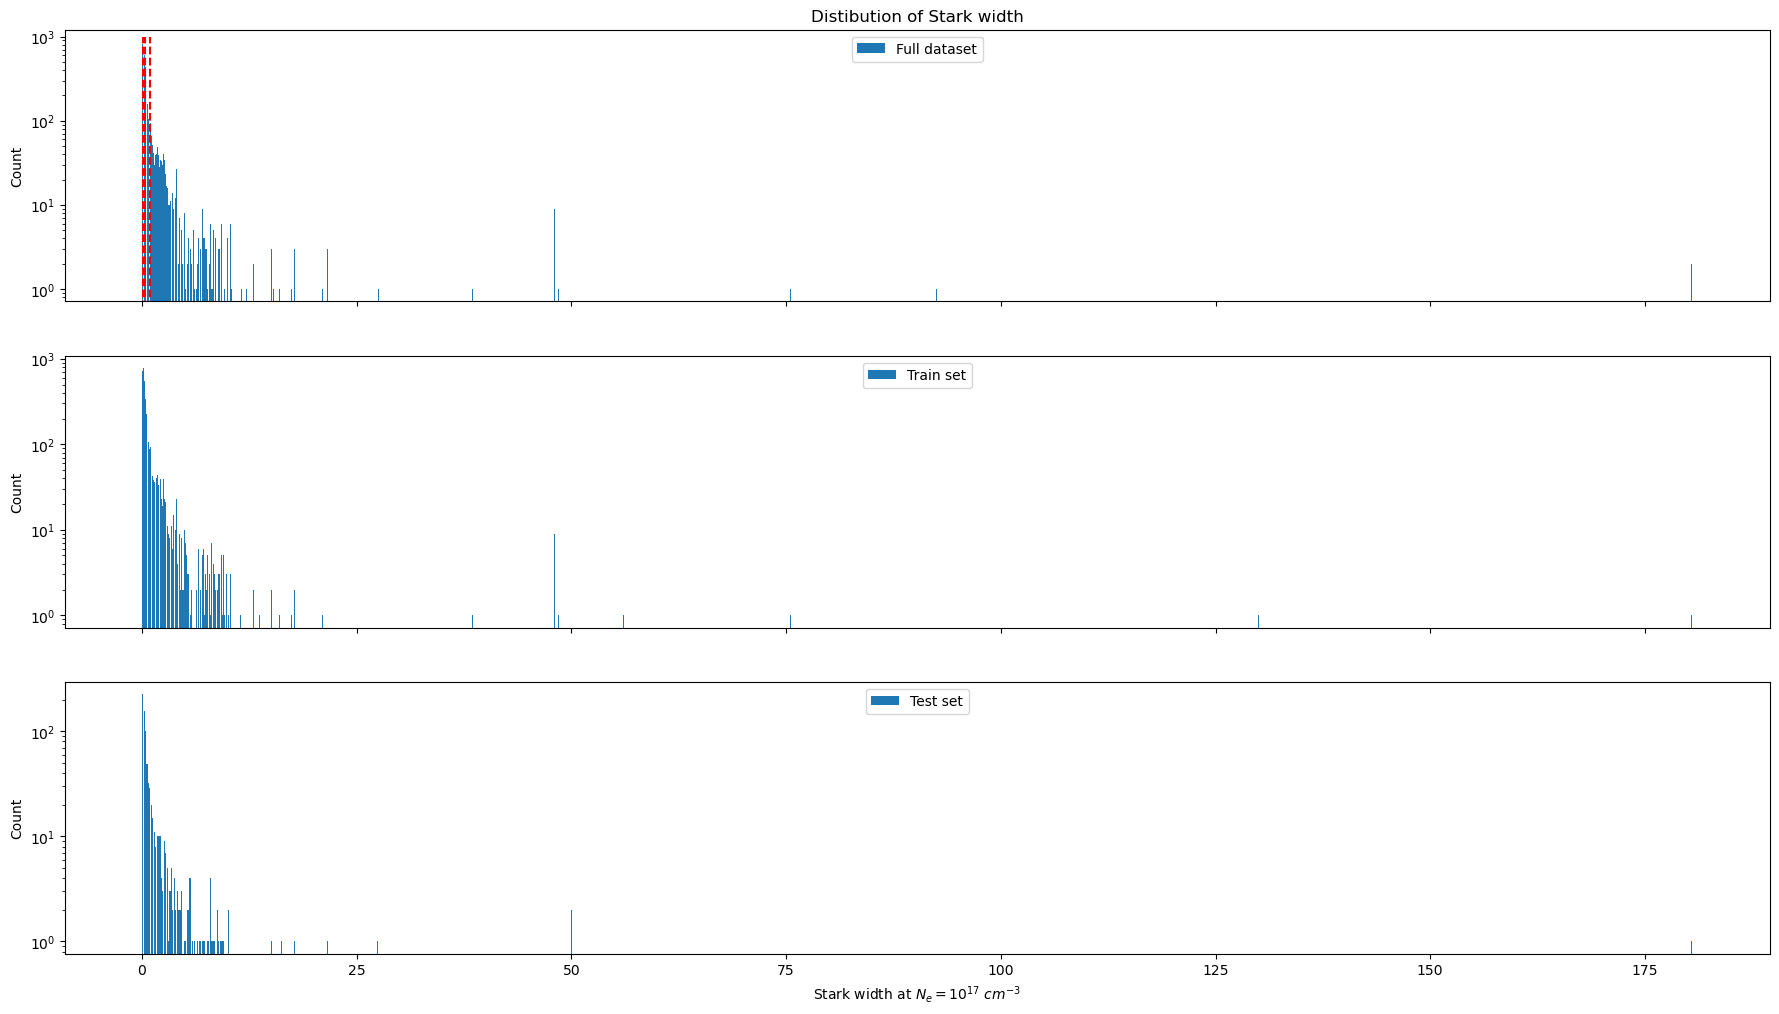

In [15]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

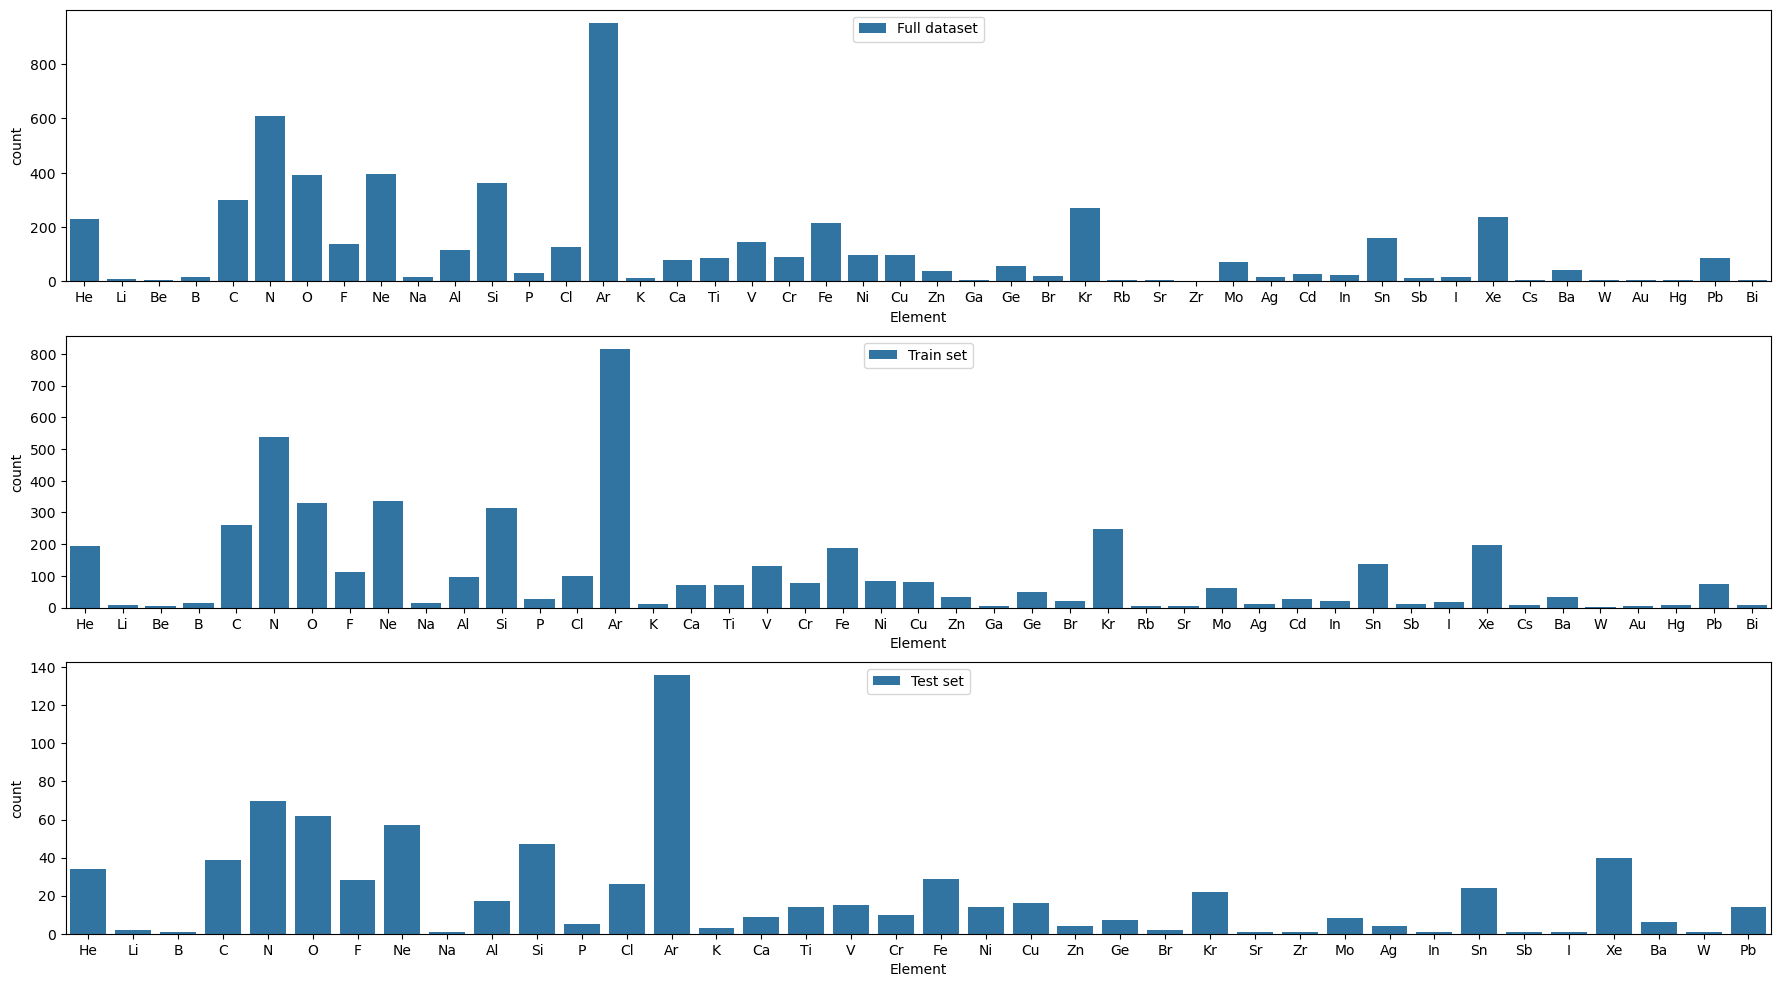

In [16]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [10]:
#Creating data, target and labels for shift prediction
data_shift = data[data['d (A)'].isna() == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])

#Separate targets from data
target_shift = data_shift['d (A)']
target_shift_elements = data_shift_elements['d (A)']

#Separate labels from data
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
data_shift_elements = data_shift_elements.drop(columns = ['w (A)', 'd (A)'])

#Remove uncertainty from data
data_shift = data_shift.drop(columns = ['w error (%)', 'd error (%)'])
data_shift_elements = data_shift_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [11]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.135,
                                                low_limit = 75,
                                                random_state = None)
  
#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

## -- *OPTIONAL*-- Shift data visual description 

In [19]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

count    2219.000000
mean        0.446451
std         1.729293
min        -7.485437
25%        -0.021000
50%         0.021429
75%         0.221500
max        20.000000
Name: d (A), dtype: float64


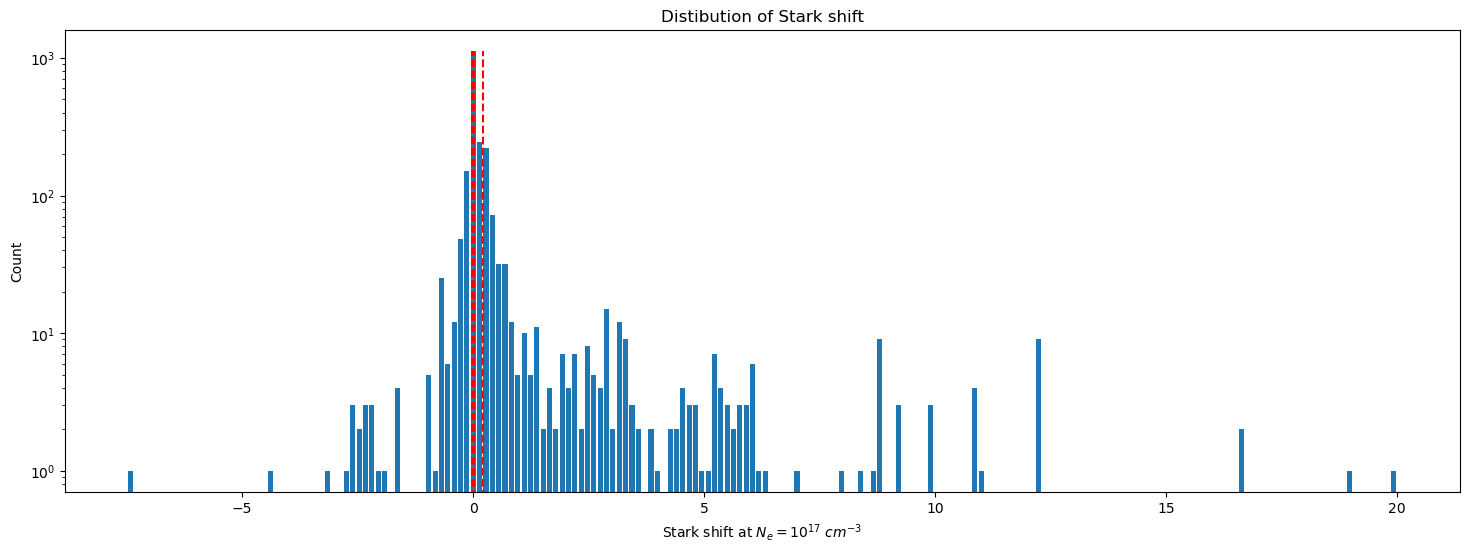

In [20]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins=200, log=True, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

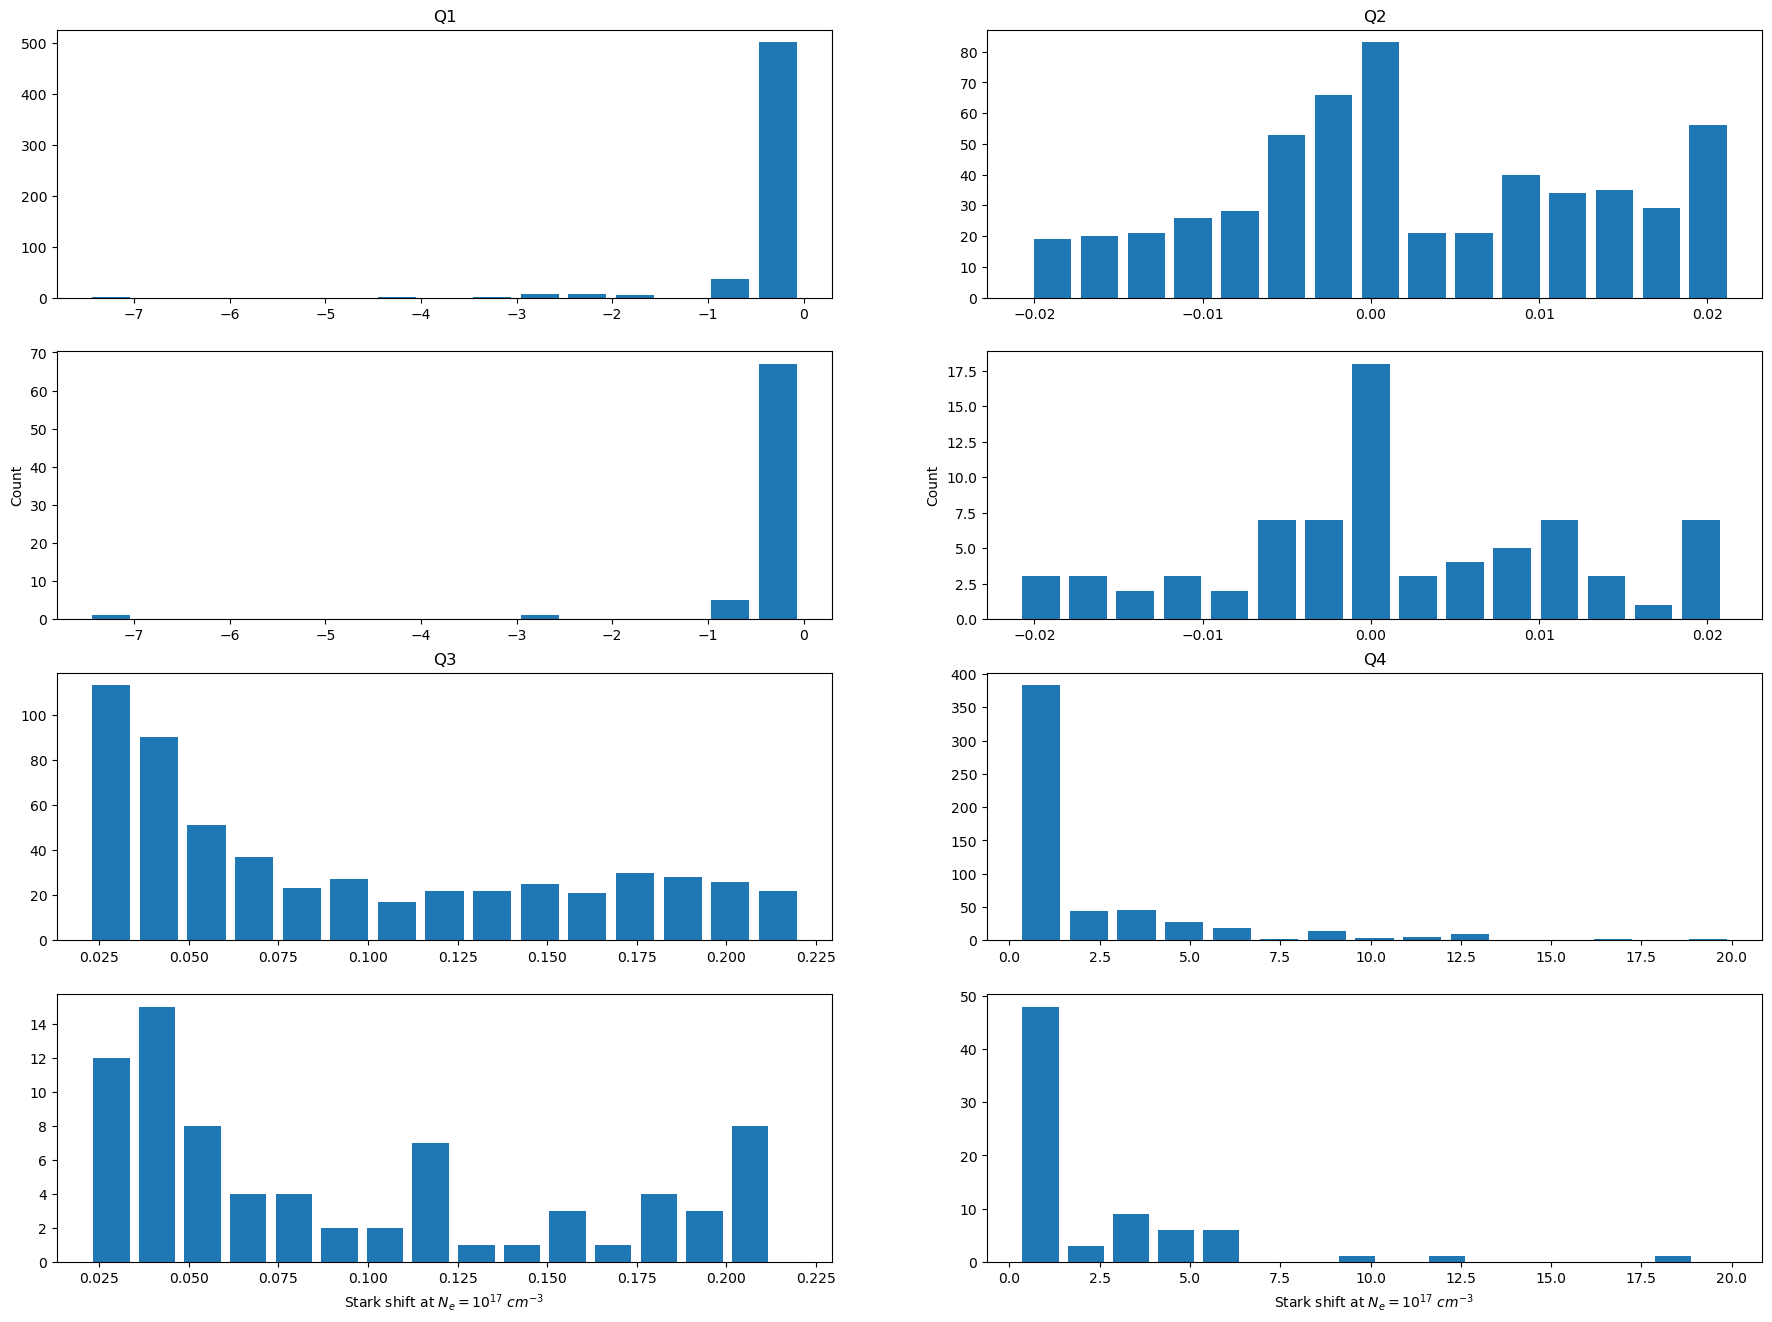

In [21]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

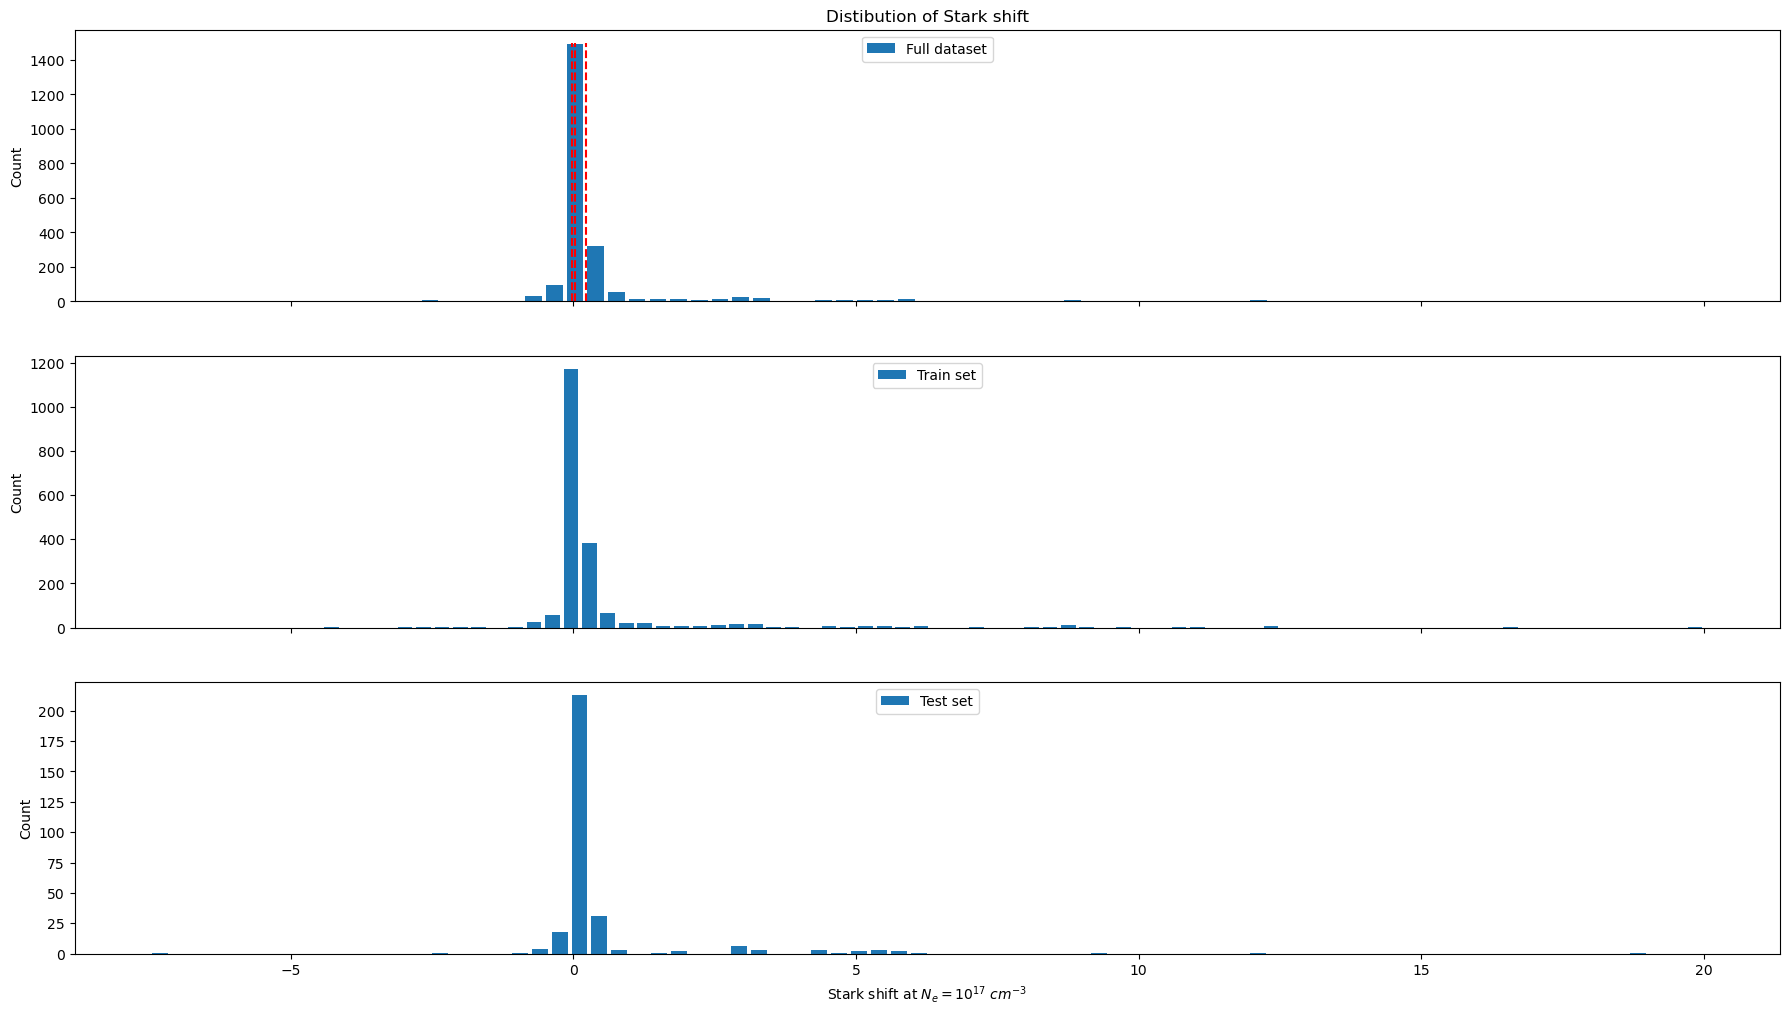

In [22]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=75, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 75, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 75, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 1500, ls='--', colors='r')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

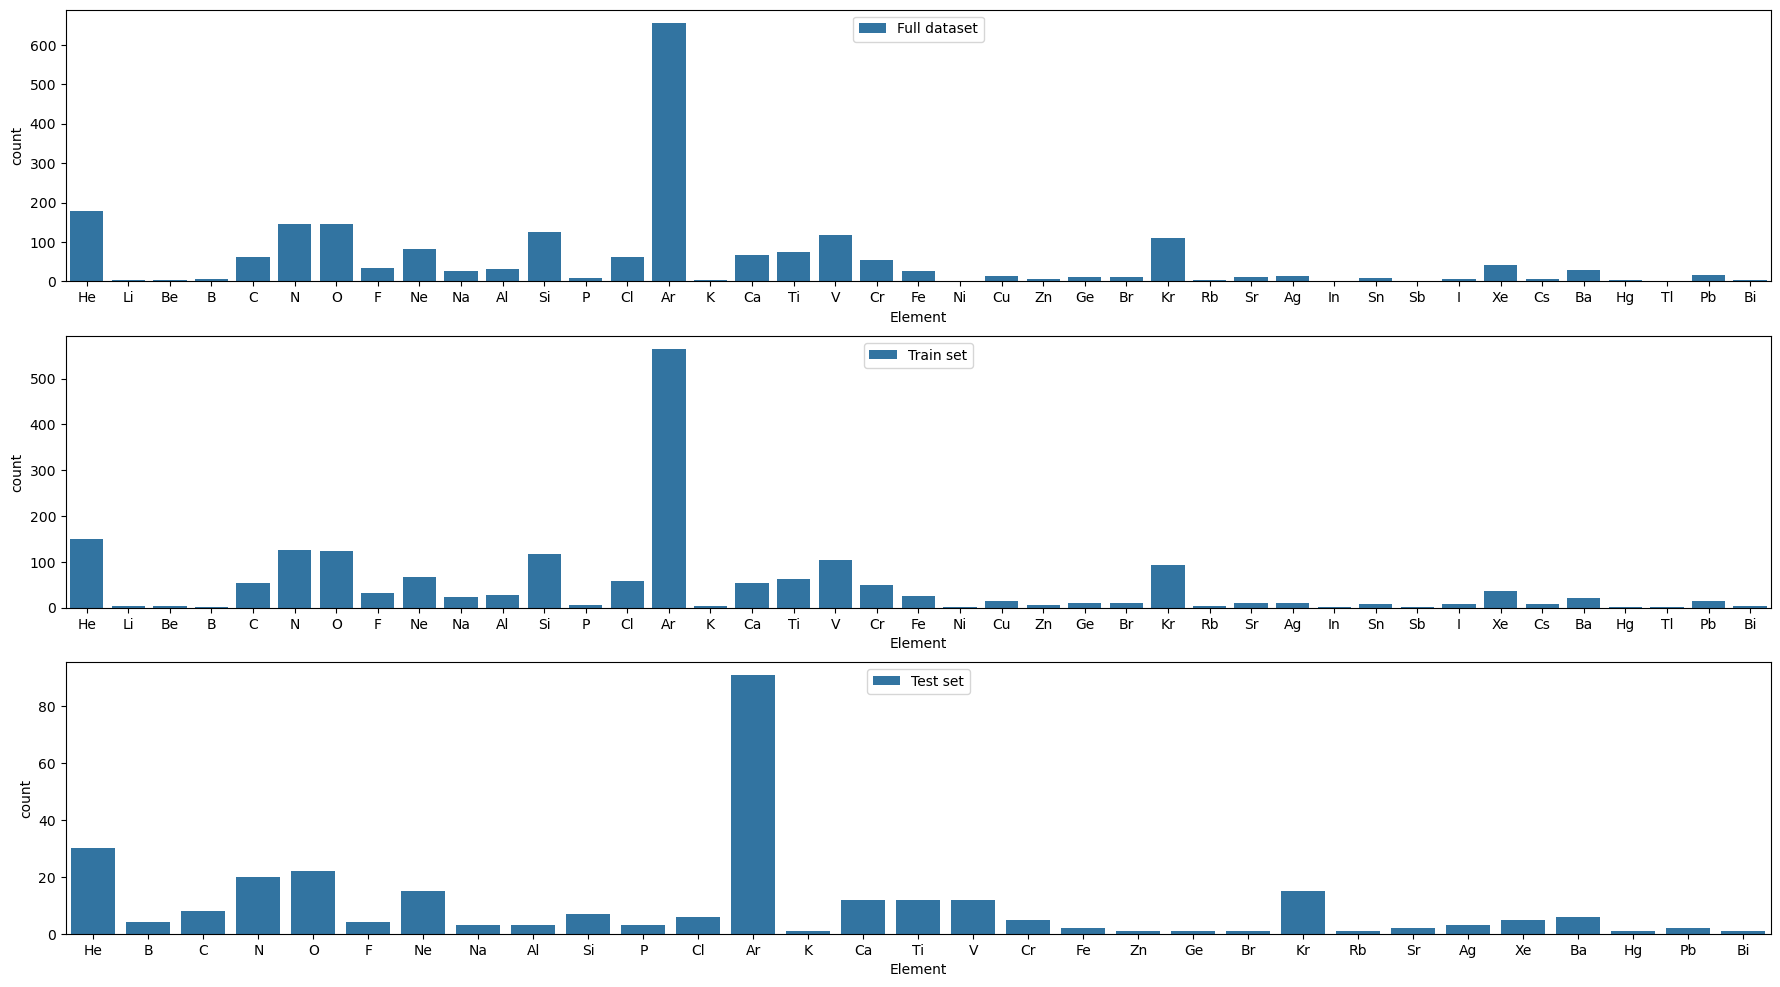

In [23]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing (currently not used anywhere further)

In [12]:
#Selecting items for predicting both parameters simultaneously (currently not used anywhere further)
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]
data_both_elements = data_both.loc[data_both['Element'].isin(elements_to_exclude)]
data_both = data_both.drop(data_both_elements.index)
data_both = data_both.sort_values(by=['Z number'])

#Separate targets from data
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
target_both_elements = data_both_elements.loc[:, ['w (A)', 'd (A)']]

#Separate labels from data
label_both = data_both.loc[:, ['Element', 'Wavelength']]
label_both_elements = data_both_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])
data_both_elements = data_both_elements.drop(columns = ['w (A)', 'd (A)'])

#Remove uncertainty from data
data_both = data_both.drop(columns = ['w error (%)', 'd error (%)'])
data_both_elements = data_both_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [13]:
#Split into train and test
data_both_train, data_both_test, target_both_train, target_both_test = train_test_split(data_both,
                                                                                       target_both,
                                                                                       test_size = 0.114,
                                                                                       random_state = 7)

# Dataset modifications  (scaling, augmentation)

In [143]:
def unscale(y):
    return (np.exp(y) - 1) * epsilon

In [386]:
augmented_train_set = True#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'width' #@param ["width", "shift", "both"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

#@markdown ---

#@markdown Normalize energies by the ionization energy for each particle
normalized_energy = True#@param {type:"boolean"}

#@markdown ---

apply_scaler = True#@param {type:"boolean"}

In [387]:
#Applying 'width' or 'shift' or 'both' selection
if parameter == 'width':
    X_train, Y_train = data_width_train, target_width_train
    X_test, Y_test = data_width_test, target_width_test
    X_elem, Y_elem, L_elem = data_width_elements, target_width_elements, label_width_elements
elif parameter == 'shift':
    X_train, Y_train = data_shift_train, target_shift_train
    X_test, Y_test = data_shift_test, target_shift_test
    X_elem, Y_elem, L_elem = data_shift_elements, target_shift_elements, label_shift_elements
elif parameter == 'both':
    X_train, Y_train = data_both_train, target_both_train
    X_test, Y_test = data_both_test, target_both_test
    X_elem, Y_elem, L_elem = data_both_elements, target_both_elements, label_both_elements
else:
    raise NameError('Incorrect parameter name selected')
    
#Handling augmentation
if augmented_train_set:
    factor = 1.05
    X_train_aug, Y_train_aug = X_train.copy(), Y_train.copy()
    for index, row in X_train.iterrows():
        row['T'] = row['T']*factor
        X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
        Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)
        
        row['T'] = row['T']/factor**2
        X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
        Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)
    X_train_aug = X_train_aug.astype(X_train.dtypes.to_dict())    
    
    X_train, Y_train = X_train_aug, Y_train_aug
    X_test,  Y_test  = X_test, Y_test

#Shuffling
X_train = X_train.sample(frac = 1, random_state = 777)
Y_train = Y_train.sample(frac = 1, random_state = 777)

#Applying upper boundary to width values
X_train, Y_train = X_train.loc[Y_train.loc[Y_train < width_threshold].index], Y_train.loc[Y_train < width_threshold]
X_test,  Y_test  = X_test.loc[Y_test.loc[Y_test < width_threshold].index], Y_test.loc[Y_test < width_threshold]
X_elem,  Y_elem  = X_elem.loc[Y_elem.loc[Y_elem < width_threshold].index], Y_elem.loc[Y_elem < width_threshold]
L_elem = L_elem.loc[Y_elem.loc[Y_elem < width_threshold].index]

#Applying scaling of targets
if scaled_target:
    Y_train = np.log(1 + Y_train / epsilon)
    Y_test  = np.log(1 + Y_test / epsilon)
    Y_elem  = np.log(1 + Y_elem / epsilon)
    
#Normalizing energies
if normalized_energy:
    X_train['E lower'], X_train['E upper'] = energy_to_fraction(X_train, 'E lower'), energy_to_fraction(X_train, 'E upper')
    X_test['E lower'],  X_test['E upper']  = energy_to_fraction(X_test, 'E lower'), energy_to_fraction(X_test, 'E upper')
    X_elem['E lower'],  X_elem['E upper']  = energy_to_fraction(X_elem, 'E lower'), energy_to_fraction(X_elem, 'E upper')
    X_train['Gap to ion'] = energy_to_fraction(X_train, 'Gap to ion')
    X_test['Gap to ion'] = energy_to_fraction(X_test, 'Gap to ion')
    X_elem['Gap to ion'] = energy_to_fraction(X_elem, 'Gap to ion')
    
#Removing unneccesary columns:
X_train = X_train.drop(columns=['Element', 'Wavelength', 'Z number'])
X_test  = X_test.drop(columns=['Element', 'Wavelength', 'Z number'])
X_elem  = X_elem.drop(columns=['Element', 'Wavelength', 'Z number'])

scaler = StandardScaler()
scaler.fit(X_train)

print(f'Selected parameter: {parameter} \n')
if augmented_train_set:
    print(f'Total number of items with known {parameter}: {X_train.shape[0]/3 + X_test.shape[0] + X_elem.shape[0]}')
else:
    print(f'Total number of items with known {parameter}: {X_train.shape[0] + X_test.shape[0] + X_elem.shape[0]}')
    
print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of ttest set: {X_test.shape[0]}')
print(f'Size of elements-exclusive test set: {X_elem.shape[0]}')

Selected parameter: width 

Total number of items with known width: 6023.0
Size of training set: 14610
Size of ttest set: 772
Size of elements-exclusive test set: 381


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


XGB_A+I_Eraw_Raw_No


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

0.2908639310032348
20.135028425224565


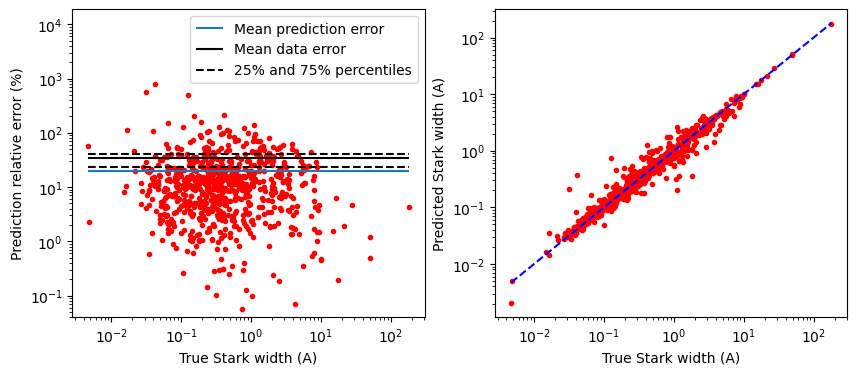

In [260]:
models = ['XGB_A+I_Eraw_Raw_No']
models_d = create_models_dict(models, path = 'C:\\Users\\Alex\\Documents\\GitHub\\XGB')

if apply_scaler:
    print('Scaling')
    preds, preds_elem = plot_model_prediction(models_d,
                                              scaler.transform(X_train), Y_train,
                                              scaler.transform(X_test), Y_test,
                                              scaler.transform(X_elem), Y_elem, L_elem, 
                                              plot = False)
else:
    preds, preds_elem = plot_model_prediction(models_d,
                                              X_train, Y_train,
                                              X_test, Y_test,
                                              X_elem, Y_elem, L_elem, 
                                              plot = False)
    
print(mean_squared_error(Y_test, preds[models[0]], squared = False))
MREs = (np.abs(unscale(Y_test) - unscale(preds[models[0]].reshape(preds[models[0]].shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_test), unscale(preds[models[0]].reshape(preds[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [341]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)
    print(f'n batches = {num_batches}')
    train_loss = 0

    for x, y in dataloader:
        # Compute prediction and loss
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))
        
        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss

def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            # Compute prediction and loss
            pred = model(x.to(device))
            loss = criterion(pred, y.to(device))

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}\n")

    return test_loss

In [427]:
# for plotting
loss_history = {"train": [], "test": []}
num_epochs = 1000
batch_size = 4096
learning_rate = 1e-4

#model = Simple_NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
device = 'cpu'

train_dataloader = DataLoader(TensorDataset(torch.from_numpy(scaler.transform(X_train).astype(np.float32)),
                                            torch.from_numpy(Y_train.to_numpy().astype(np.float32))),
                              batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(torch.from_numpy(scaler.transform(X_test).astype(np.float32)),
                                           torch.from_numpy(Y_test.to_numpy().astype(np.float32))),
                             batch_size=batch_size, shuffle=False)

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(train_dataloader, model, criterion, optimizer)
    test_loss = test_loop(test_dataloader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Epoch 1
n batches = 4
Train loss: 1.979596
Test loss: 2.057615

Epoch 2
n batches = 4
Train loss: 1.980281
Test loss: 2.022543

Epoch 3
n batches = 4
Train loss: 1.964779
Test loss: 2.023669

Epoch 4
n batches = 4
Train loss: 1.955594
Test loss: 2.025782

Epoch 5
n batches = 4
Train loss: 1.959585
Test loss: 2.018857

Epoch 6
n batches = 4
Train loss: 1.953056
Test loss: 2.022148

Epoch 7
n batches = 4
Train loss: 1.949008
Test loss: 2.019652

Epoch 8
n batches = 4
Train loss: 1.953726
Test loss: 2.018851

Epoch 9
n batches = 4
Train loss: 1.953162
Test loss: 2.019466

Epoch 10
n batches = 4
Train loss: 1.950046
Test loss: 2.018790

Epoch 11
n batches = 4
Train loss: 1.955748
Test loss: 2.019139

Epoch 12
n batches = 4
Train loss: 1.942445
Test loss: 2.018863

Epoch 13
n batches = 4
Train loss: 1.960531
Test loss: 2.018691

Epoch 14
n batches = 4
Train loss: 1.949481
Test loss: 2.019404

Epoch 15
n batches = 4
Train loss: 1.948734
Test loss: 2.018676

Epoch 16
n batches = 4
Train loss:

Train loss: 1.941996
Test loss: 2.018652

Epoch 129
n batches = 4
Train loss: 1.954345
Test loss: 2.018667

Epoch 130
n batches = 4
Train loss: 1.959811
Test loss: 2.018711

Epoch 131
n batches = 4
Train loss: 1.957631
Test loss: 2.019117

Epoch 132
n batches = 4
Train loss: 1.963231
Test loss: 2.018755

Epoch 133
n batches = 4
Train loss: 1.972421
Test loss: 2.019188

Epoch 134
n batches = 4
Train loss: 1.964863
Test loss: 2.021350

Epoch 135
n batches = 4
Train loss: 1.958644
Test loss: 2.019902

Epoch 136
n batches = 4
Train loss: 1.953945
Test loss: 2.018721

Epoch 137
n batches = 4
Train loss: 1.962063
Test loss: 2.018990

Epoch 138
n batches = 4
Train loss: 1.960842
Test loss: 2.018798

Epoch 139
n batches = 4
Train loss: 1.951713
Test loss: 2.018690

Epoch 140
n batches = 4
Train loss: 1.951982
Test loss: 2.018723

Epoch 141
n batches = 4
Train loss: 1.962854
Test loss: 2.019606

Epoch 142
n batches = 4
Train loss: 1.956933
Test loss: 2.019235

Epoch 143
n batches = 4
Train loss

Train loss: 1.955087
Test loss: 2.018675

Epoch 254
n batches = 4
Train loss: 1.971230
Test loss: 2.018729

Epoch 255
n batches = 4
Train loss: 1.966825
Test loss: 2.018966

Epoch 256
n batches = 4
Train loss: 1.940629
Test loss: 2.018685

Epoch 257
n batches = 4
Train loss: 1.950709
Test loss: 2.018884

Epoch 258
n batches = 4
Train loss: 1.947985
Test loss: 2.018944

Epoch 259
n batches = 4
Train loss: 1.951130
Test loss: 2.018655

Epoch 260
n batches = 4
Train loss: 1.957013
Test loss: 2.018651

Epoch 261
n batches = 4
Train loss: 1.959829
Test loss: 2.018651

Epoch 262
n batches = 4
Train loss: 1.951637
Test loss: 2.018659

Epoch 263
n batches = 4
Train loss: 1.960620
Test loss: 2.018665

Epoch 264
n batches = 4
Train loss: 1.950726
Test loss: 2.018760

Epoch 265
n batches = 4
Train loss: 1.945733
Test loss: 2.018882

Epoch 266
n batches = 4
Train loss: 1.958366
Test loss: 2.018655

Epoch 267
n batches = 4
Train loss: 1.954917
Test loss: 2.019418

Epoch 268
n batches = 4
Train loss

Train loss: 1.954028
Test loss: 2.018781

Epoch 380
n batches = 4
Train loss: 1.954628
Test loss: 2.018859

Epoch 381
n batches = 4
Train loss: 1.950118
Test loss: 2.019070

Epoch 382
n batches = 4
Train loss: 1.950025
Test loss: 2.018666

Epoch 383
n batches = 4
Train loss: 1.945969
Test loss: 2.018657

Epoch 384
n batches = 4
Train loss: 1.949224
Test loss: 2.019032

Epoch 385
n batches = 4
Train loss: 1.942248
Test loss: 2.018745

Epoch 386
n batches = 4
Train loss: 1.953308
Test loss: 2.018651

Epoch 387
n batches = 4
Train loss: 1.955084
Test loss: 2.019050

Epoch 388
n batches = 4
Train loss: 1.951480
Test loss: 2.018793

Epoch 389
n batches = 4
Train loss: 1.961891
Test loss: 2.018726

Epoch 390
n batches = 4
Train loss: 1.954214
Test loss: 2.018652

Epoch 391
n batches = 4
Train loss: 1.959894
Test loss: 2.018694

Epoch 392
n batches = 4
Train loss: 1.946887
Test loss: 2.018746

Epoch 393
n batches = 4
Train loss: 1.949788
Test loss: 2.018822

Epoch 394
n batches = 4
Train loss

Train loss: 1.947058
Test loss: 2.018676

Epoch 505
n batches = 4
Train loss: 1.960708
Test loss: 2.018656

Epoch 506
n batches = 4
Train loss: 1.961581
Test loss: 2.018829

Epoch 507
n batches = 4
Train loss: 1.958381
Test loss: 2.018670

Epoch 508
n batches = 4
Train loss: 1.951613
Test loss: 2.018726

Epoch 509
n batches = 4
Train loss: 1.958123
Test loss: 2.018663

Epoch 510
n batches = 4
Train loss: 1.947334
Test loss: 2.019157

Epoch 511
n batches = 4
Train loss: 1.951720
Test loss: 2.018924

Epoch 512
n batches = 4
Train loss: 1.962187
Test loss: 2.018657

Epoch 513
n batches = 4
Train loss: 1.962116
Test loss: 2.018814

Epoch 514
n batches = 4
Train loss: 1.951659
Test loss: 2.018655

Epoch 515
n batches = 4
Train loss: 1.957777
Test loss: 2.018729

Epoch 516
n batches = 4
Train loss: 1.947910
Test loss: 2.018731

Epoch 517
n batches = 4
Train loss: 1.942848
Test loss: 2.018654

Epoch 518
n batches = 4
Train loss: 1.966650
Test loss: 2.018800

Epoch 519
n batches = 4
Train loss

Train loss: 1.952180
Test loss: 2.018745

Epoch 630
n batches = 4
Train loss: 1.961375
Test loss: 2.019188

Epoch 631
n batches = 4
Train loss: 1.962702
Test loss: 2.018771

Epoch 632
n batches = 4
Train loss: 1.960063
Test loss: 2.018736

Epoch 633
n batches = 4
Train loss: 1.939260
Test loss: 2.018804

Epoch 634
n batches = 4
Train loss: 1.957374
Test loss: 2.018950

Epoch 635
n batches = 4
Train loss: 1.953002
Test loss: 2.018879

Epoch 636
n batches = 4
Train loss: 1.959560
Test loss: 2.018670

Epoch 637
n batches = 4
Train loss: 1.948815
Test loss: 2.018821

Epoch 638
n batches = 4
Train loss: 1.950246
Test loss: 2.018765

Epoch 639
n batches = 4
Train loss: 1.947752
Test loss: 2.018802

Epoch 640
n batches = 4
Train loss: 1.957154
Test loss: 2.018722

Epoch 641
n batches = 4
Train loss: 1.962273
Test loss: 2.018714

Epoch 642
n batches = 4
Train loss: 1.956634
Test loss: 2.018663

Epoch 643
n batches = 4
Train loss: 1.949280
Test loss: 2.019226

Epoch 644
n batches = 4
Train loss

Train loss: 1.958823
Test loss: 2.018849

Epoch 756
n batches = 4
Train loss: 1.962693
Test loss: 2.018736

Epoch 757
n batches = 4
Train loss: 1.952022
Test loss: 2.019175

Epoch 758
n batches = 4
Train loss: 1.950528
Test loss: 2.019064

Epoch 759
n batches = 4
Train loss: 1.953606
Test loss: 2.018842

Epoch 760
n batches = 4
Train loss: 1.958797
Test loss: 2.018687

Epoch 761
n batches = 4
Train loss: 1.943194
Test loss: 2.018750

Epoch 762
n batches = 4
Train loss: 1.962635
Test loss: 2.018723

Epoch 763
n batches = 4
Train loss: 1.957953
Test loss: 2.018668

Epoch 764
n batches = 4
Train loss: 1.952210
Test loss: 2.018675

Epoch 765
n batches = 4
Train loss: 1.942698
Test loss: 2.018798

Epoch 766
n batches = 4
Train loss: 1.959045
Test loss: 2.018667

Epoch 767
n batches = 4
Train loss: 1.946003
Test loss: 2.019008

Epoch 768
n batches = 4
Train loss: 1.950014
Test loss: 2.019104

Epoch 769
n batches = 4
Train loss: 1.956132
Test loss: 2.018656

Epoch 770
n batches = 4
Train loss

Train loss: 1.954265
Test loss: 2.018686

Epoch 881
n batches = 4
Train loss: 1.957656
Test loss: 2.018709

Epoch 882
n batches = 4
Train loss: 1.952445
Test loss: 2.018689

Epoch 883
n batches = 4
Train loss: 1.951970
Test loss: 2.018730

Epoch 884
n batches = 4
Train loss: 1.949392
Test loss: 2.018721

Epoch 885
n batches = 4
Train loss: 1.955131
Test loss: 2.018782

Epoch 886
n batches = 4
Train loss: 1.949275
Test loss: 2.018669

Epoch 887
n batches = 4
Train loss: 1.950544
Test loss: 2.018702

Epoch 888
n batches = 4
Train loss: 1.945873
Test loss: 2.018655

Epoch 889
n batches = 4
Train loss: 1.958477
Test loss: 2.018822

Epoch 890
n batches = 4
Train loss: 1.962201
Test loss: 2.019753

Epoch 891
n batches = 4
Train loss: 1.961135
Test loss: 2.018856

Epoch 892
n batches = 4
Train loss: 1.966844
Test loss: 2.018928

Epoch 893
n batches = 4
Train loss: 1.949426
Test loss: 2.018682

Epoch 894
n batches = 4
Train loss: 1.953966
Test loss: 2.018693

Epoch 895
n batches = 4
Train loss

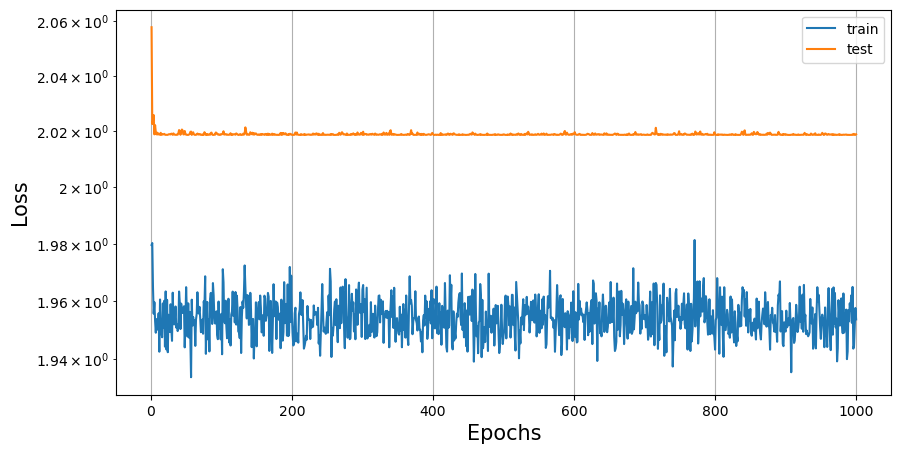

In [428]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.semilogy()
plt.show()

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

1.4210410001792912
190.89384245586885


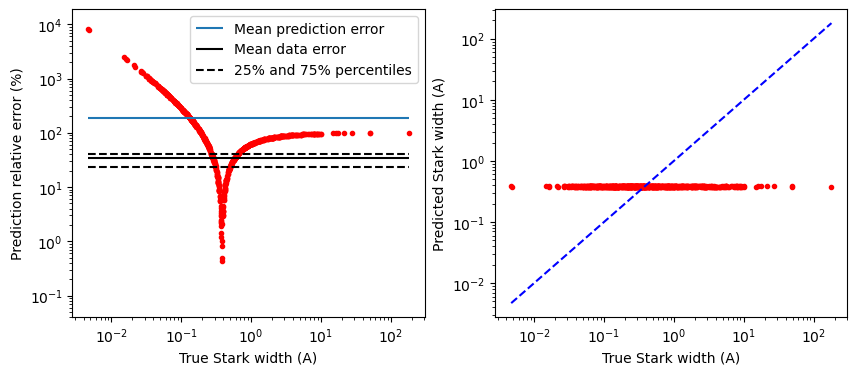

In [429]:
preds = model(torch.from_numpy(scaler.transform(X_test).astype(np.float32))).detach().numpy()

print(mean_squared_error(Y_test, preds, squared = False))
MREs = (np.abs(unscale(Y_test) - unscale(preds.reshape(preds.shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')
ax[0].set_ylim(4e-2, 1.9e4)

ax[1].plot(unscale(Y_test), unscale(preds.reshape(preds.shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [406]:
class Simple_NN(nn.Module):
    
    def __init__(self):
        super(Simple_NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features = 63,
                     out_features = 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(in_features = 512,
                     out_features = 128),
            nn.ReLU(),
            
            nn.Linear(in_features = 128,
                     out_features = 32),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(in_features = 32,
                     out_features = 8),
            nn.ReLU(),
        
            nn.Linear(in_features = 8,
                     out_features = 1),
            nn.ReLU())
        
        
    def forward(self, x):
        x = self.net(x)
        return x

In [26]:
def plot_model_prediction(models, X_train, y_train, X_test, y_test, X_elem = None, y_elem = None, label_elem = None,
                          plot = True):
    '''
    Takes models (dict) and data as input, returns predictions and plots
    '''
    if X_elem is None and y_elem is None:
        grid_h = 1
    elif X_elem is not None and y_elem is not None:
        grid_h = 2
    else:
        raise ValueError(f"'X_elem' and 'y_elem' must be both either 'None' or not.")
        
    predictions = {}
    predictions_elem = {}
    R2 = {}
    R2_elem = {}
    RMSE = {}
    RMSE_elem = {}
    MRE = {}
    MRE_elem = {}
    
    for name, model in models.items():
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        R2[name] = r2_score(y_test, y_pred)
        RMSE[name] = mean_squared_error(y_test, y_pred, squared = False)
        MRE[name] = (np.abs(y_test - y_pred.reshape(y_pred.shape[0])) / y_test).mean()
        
        if grid_h == 2:
            y_pred = model.predict(X_elem)
            predictions_elem[name] = y_pred.flatten()
            
            R2_elem[name] = r2_score(y_elem, y_pred)
            RMSE_elem[name] = mean_squared_error(y_elem, y_pred, squared = False)
            MRE_elem[name] = (np.abs(y_elem - y_pred.reshape(y_pred.shape[0])) / y_elem).mean()
        
    if plot == True:
        i = 0
        fig, ax = plt.subplots(grid_h, len(models), figsize = (5*len(models), 4*grid_h))
        for name, model in models.items():
            print(f'Plotting {name} predictions')
            if grid_h == 1:
                ax[i].plot(y_test, predictions[name], 'r.')
                ax[i].plot([0, np.amax(y_test)], [0, np.amax(y_test)], color = 'b', ls = '--')
                ax[i].set_title(f'{name}')
                ax[i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[i].transAxes)
            else:
                ax[0, i].plot(y_test, predictions[name], 'r.')
                ax[0, i].plot([0, np.amax(y_test)], [0, np.amax(y_test)], color = 'b', ls = '--')
                ax[0, i].set_title(f'{name}')
                ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.4f}  \nRMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)

                #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
                sns.scatterplot(x = y_elem, y = predictions_elem[name], ax = ax[1, i], style = label_elem['Element'], hue = label_elem['Element'])
                ax[1, i].plot([0, np.amax(y_elem)], [0, np.amax(y_elem)], color = 'b', ls = '--')
                ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
            i += 1
        plt.show()
        return predictions, predictions_elem, fig, ax
    
    else:
        return predictions, predictions_elem

In [124]:
Y_test

5940    4.475541
5662    4.875197
5227    3.850148
4709    3.931826
2087    4.918879
          ...   
3435    6.922644
4349    7.678797
763     7.478957
1346    6.985642
1011    7.601402
Name: w (A), Length: 772, dtype: float64

# Models optimization

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = KNN

if apply_scaler:
    print('Scaling')
    KNN_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = KNN_params, n_trials = 250)
else:
    KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 250)

with open(f'KNN_A+I_Enorm_Aug_No_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

Fitting new


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

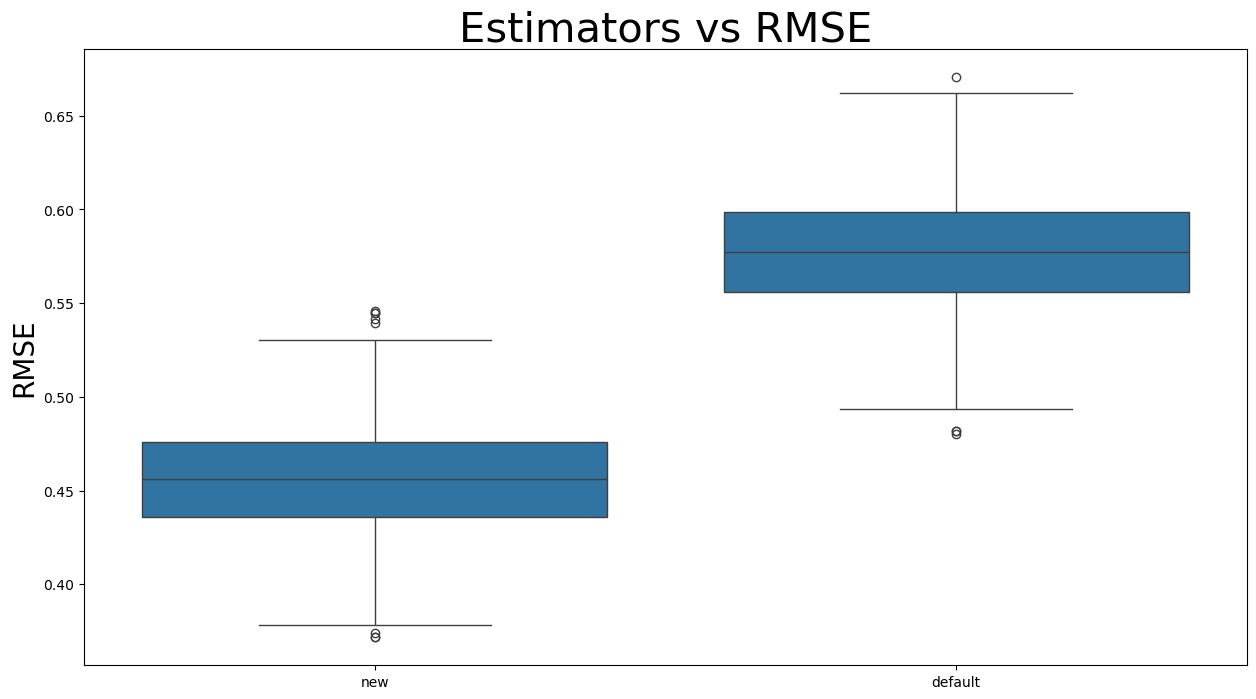

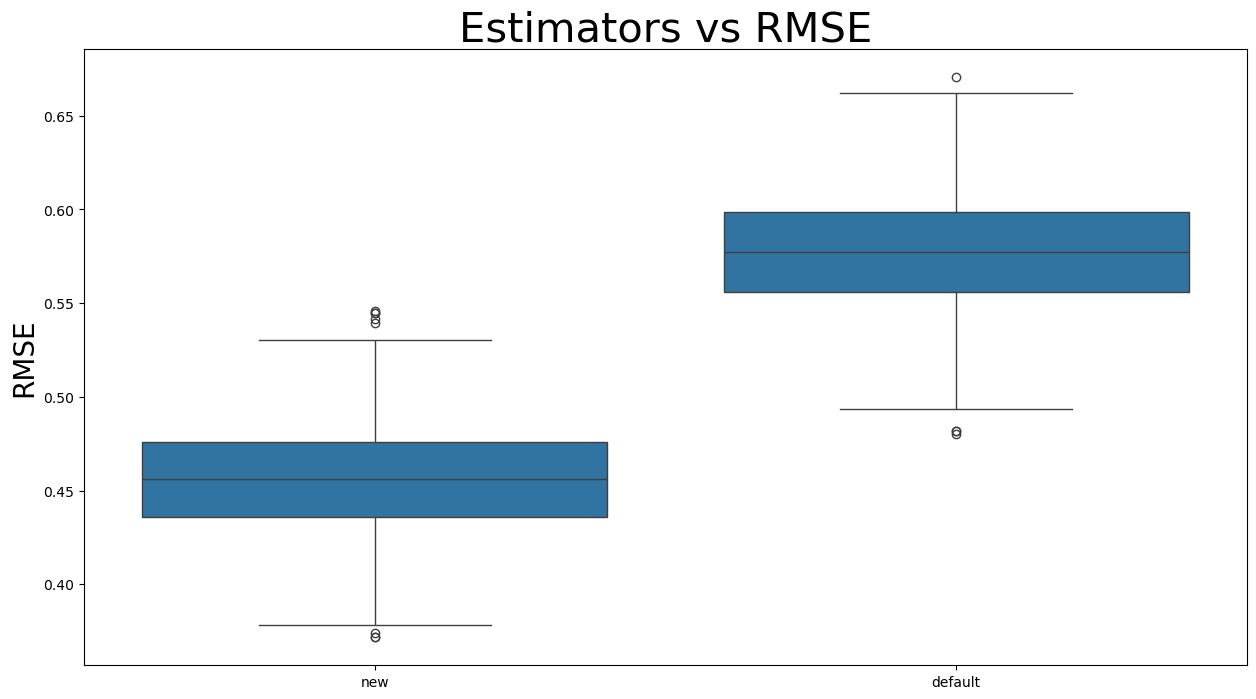

In [77]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [78]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [79]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : [10, 250],
    'max_depth' : [1, 80],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = RandomForest

if apply_scaler:
    print('Scaling')
    RF_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = RF_params, n_trials = 200)
else:
    RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 200)

with open(f'RF_A+I_Enorm_Aug_No_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

In [80]:
RF_params

{'n_estimators': 187,
 'max_depth': 44,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'criterion': 'squared_error'}

Fitting new


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

Fitting default


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Calculating bootstrap score for new
Calculating bootstrap score for default


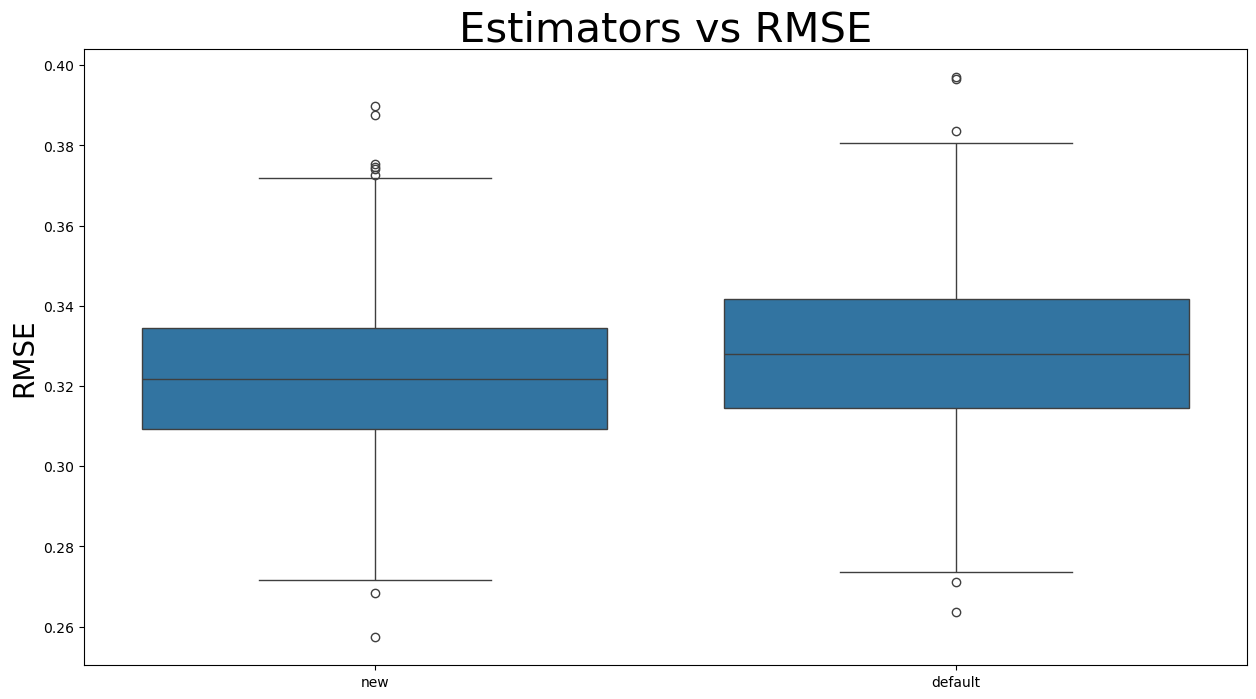

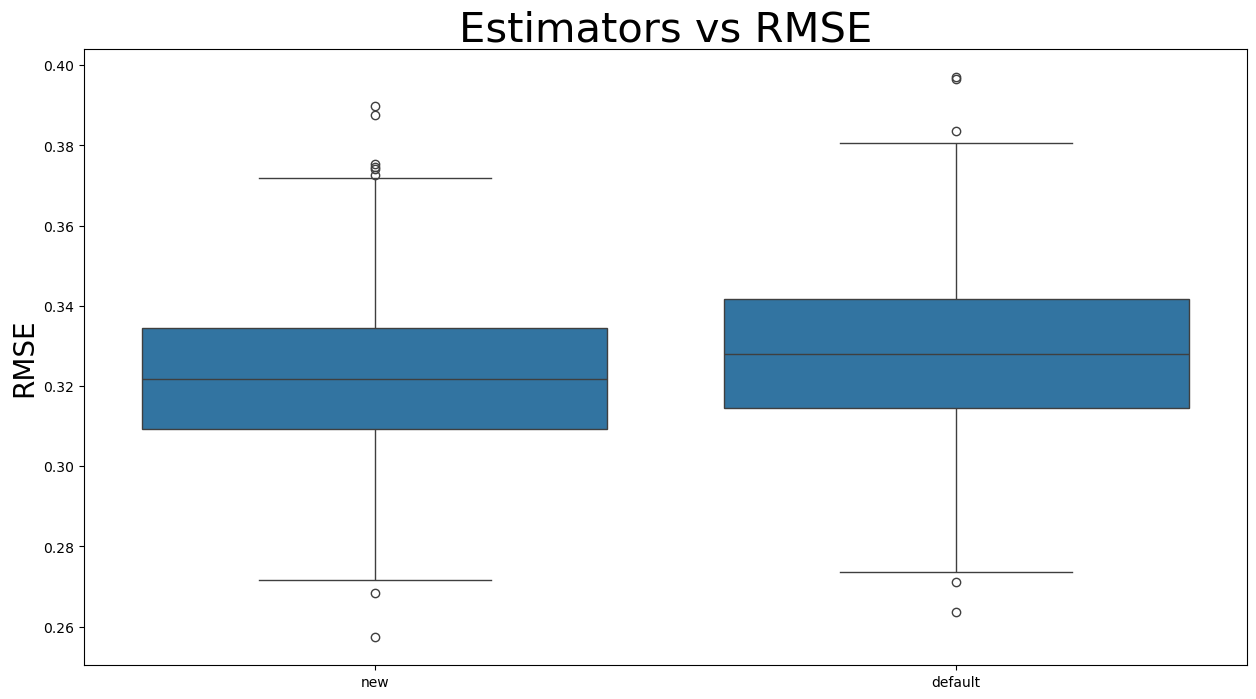

In [79]:
#Compare default RandomForest vs optimised RandomForest
RF_params = RF_res.best_params

models_RF = {}

models_RF['new'] = RandomForestRegressor(**RF_params)
models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_RF)

In [21]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 201, 10):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

TypeError: sklearn.ensemble._forest.RandomForestRegressor() got multiple values for keyword argument 'n_estimators'

In [81]:
optuna.visualization.plot_param_importances(RF_res)

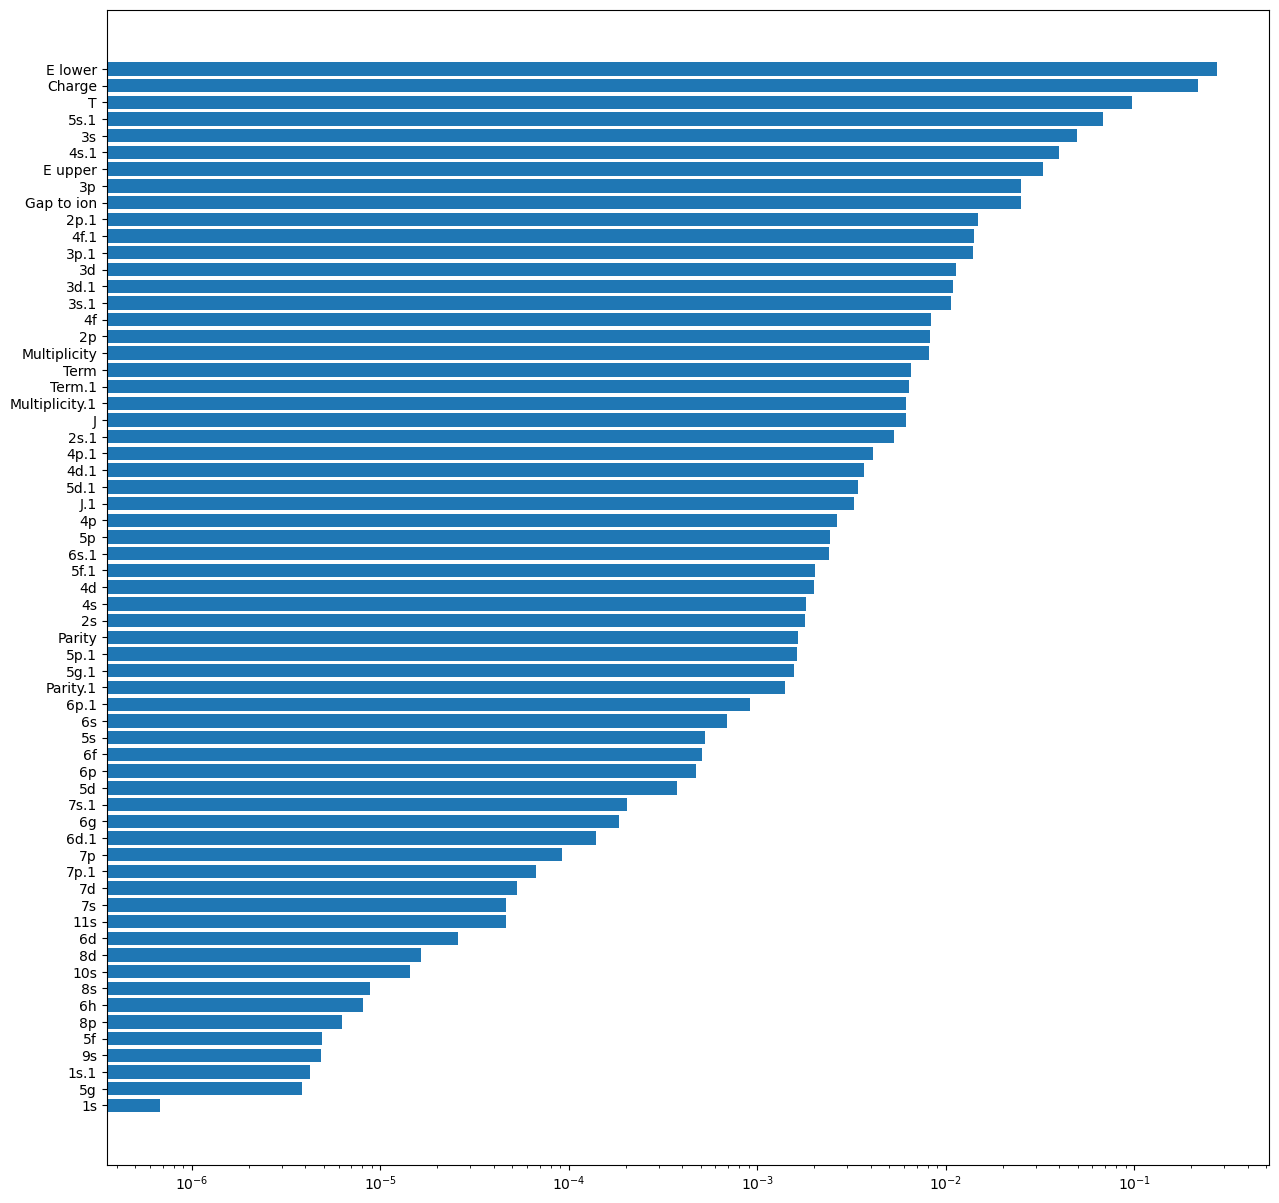

In [82]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [83]:
optuna.visualization.plot_slice(RF_res, params = ['n_estimators', 'max_depth'])

In [84]:
optuna.visualization.plot_optimization_history(RF_res)

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## XGBoost

In [103]:
XGB_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = XGBoost

if apply_scaler:
    print('Scaling')
    XGB_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = XGB_params, n_trials = 400)
else:
    print('here')
    XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 400)

with open(f'XGB_A+I_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

[I 2024-02-21 13:38:01,737] A new study created in memory with name: no-name-e4e4404a-ec88-4b4b-81d4-f92fdb299ffa


here
Start hyperparameter optimization


  0%|          | 0/400 [00:00<?, ?it/s]

{'n_estimators': 18, 'max_depth': 13, 'learning_rate': 0.11078012500416798, 'min_child_weight': 10, 'reg_alpha': 1.0675694931564716e-05, 'reg_lambda': 0.002954522077518635}
{'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3203899817397162, 'min_child_weight': 14, 'reg_alpha': 2.1735619833764726e-05, 'reg_lambda': 2.9897131276286575e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:02,009] Trial 1 finished with value: 0.5854947981203236 and parameters: {'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3203899817397162, 'min_child_weight': 14, 'reg_alpha': 2.1735619833764726e-05, 'reg_lambda': 2.9897131276286575e-06}. Best is trial 1 with value: 0.5854947981203236.
{'n_estimators': 182, 'max_depth': 20, 'learning_rate': 0.1731568409217387, 'min_child_weight': 15, 'reg_alpha': 3.92208838951002e-06, 'reg_lambda': 0.00026076352985172116}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:02,311] Trial 0 finished with value: 0.4404997580919826 and parameters: {'n_estimators': 18, 'max_depth': 13, 'learning_rate': 0.11078012500416798, 'min_child_weight': 10, 'reg_alpha': 1.0675694931564716e-05, 'reg_lambda': 0.002954522077518635}. Best is trial 0 with value: 0.4404997580919826.
{'n_estimators': 832, 'max_depth': 3, 'learning_rate': 0.3521711673664981, 'min_child_weight': 3, 'reg_alpha': 2.9051345664550516, 'reg_lambda': 2.378472193415301}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:03,790] Trial 3 finished with value: 0.3603246377973954 and parameters: {'n_estimators': 832, 'max_depth': 3, 'learning_rate': 0.3521711673664981, 'min_child_weight': 3, 'reg_alpha': 2.9051345664550516, 'reg_lambda': 2.378472193415301}. Best is trial 3 with value: 0.3603246377973954.
{'n_estimators': 18, 'max_depth': 20, 'learning_rate': 0.4686400821449169, 'min_child_weight': 7, 'reg_alpha': 6.407863793207603e-08, 'reg_lambda': 3.955606428665881e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:04,190] Trial 2 finished with value: 0.33836891806001407 and parameters: {'n_estimators': 182, 'max_depth': 20, 'learning_rate': 0.1731568409217387, 'min_child_weight': 15, 'reg_alpha': 3.92208838951002e-06, 'reg_lambda': 0.00026076352985172116}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 599, 'max_depth': 2, 'learning_rate': 0.37347242486004467, 'min_child_weight': 5, 'reg_alpha': 1.015914658362413e-06, 'reg_lambda': 0.9999316980062152}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:04,423] Trial 4 finished with value: 0.35966574687466657 and parameters: {'n_estimators': 18, 'max_depth': 20, 'learning_rate': 0.4686400821449169, 'min_child_weight': 7, 'reg_alpha': 6.407863793207603e-08, 'reg_lambda': 3.955606428665881e-06}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 92, 'max_depth': 10, 'learning_rate': 0.1822168985134706, 'min_child_weight': 6, 'reg_alpha': 1.2377724873271096e-05, 'reg_lambda': 3.729077383574509e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:38:05,333] Trial 5 finished with value: 0.38605598944119285 and parameters: {'n_estimators': 599, 'max_depth': 2, 'learning_rate': 0.37347242486004467, 'min_child_weight': 5, 'reg_alpha': 1.015914658362413e-06, 'reg_lambda': 0.9999316980062152}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.12454360747006793, 'min_child_weight': 7, 'reg_alpha': 0.007232311734417666, 'reg_lambda': 0.00020133495007513047}
[I 2024-02-21 13:38:05,396] Trial 6 finished with value: 0.3396806808005775 and parameters: {'n_estimators': 92, 'max_depth': 10, 'learning_rate': 0.1822168985134706, 'min_child_weight': 6, 'reg_alpha': 1.2377724873271096e-05, 'reg_lambda': 3.729077383574509e-05}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 57, 'max_depth': 16, 'learning_rate': 0.46431347118838456, 'min_child_weight': 11, 'reg_alpha': 3.6130636070276214, 'reg_lambda': 5.535499721239242e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:06,044] Trial 8 finished with value: 0.3620770421114276 and parameters: {'n_estimators': 57, 'max_depth': 16, 'learning_rate': 0.46431347118838456, 'min_child_weight': 11, 'reg_alpha': 3.6130636070276214, 'reg_lambda': 5.535499721239242e-07}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 19, 'max_depth': 1, 'learning_rate': 0.4976303589499827, 'min_child_weight': 6, 'reg_alpha': 7.873103310279472e-06, 'reg_lambda': 0.46203451360839215}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:06,246] Trial 9 finished with value: 0.8413728816971051 and parameters: {'n_estimators': 19, 'max_depth': 1, 'learning_rate': 0.4976303589499827, 'min_child_weight': 6, 'reg_alpha': 7.873103310279472e-06, 'reg_lambda': 0.46203451360839215}. Best is trial 2 with value: 0.33836891806001407.
{'n_estimators': 197, 'max_depth': 10, 'learning_rate': 0.17868884392703, 'min_child_weight': 12, 'reg_alpha': 0.00017640162372165803, 'reg_lambda': 3.844753154872101e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:06,960] Trial 7 finished with value: 0.33532619959967536 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.12454360747006793, 'min_child_weight': 7, 'reg_alpha': 0.007232311734417666, 'reg_lambda': 0.00020133495007513047}. Best is trial 7 with value: 0.33532619959967536.
{'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.360220608180628, 'min_child_weight': 11, 'reg_alpha': 2.8076729381563336e-08, 'reg_lambda': 6.269587286829839e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:07,211] Trial 11 finished with value: 0.4349724535349875 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.360220608180628, 'min_child_weight': 11, 'reg_alpha': 2.8076729381563336e-08, 'reg_lambda': 6.269587286829839e-08}. Best is trial 7 with value: 0.33532619959967536.
{'n_estimators': 317, 'max_depth': 11, 'learning_rate': 0.21262583597364879, 'min_child_weight': 4, 'reg_alpha': 0.33474264482016647, 'reg_lambda': 1.374827536739414e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:07,661] Trial 10 finished with value: 0.33458335351769664 and parameters: {'n_estimators': 197, 'max_depth': 10, 'learning_rate': 0.17868884392703, 'min_child_weight': 12, 'reg_alpha': 0.00017640162372165803, 'reg_lambda': 3.844753154872101e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 83, 'max_depth': 1, 'learning_rate': 0.022999614971699257, 'min_child_weight': 8, 'reg_alpha': 0.0056118847510754685, 'reg_lambda': 1.5873739142700658e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:07,953] Trial 13 finished with value: 1.1107333656241956 and parameters: {'n_estimators': 83, 'max_depth': 1, 'learning_rate': 0.022999614971699257, 'min_child_weight': 8, 'reg_alpha': 0.0056118847510754685, 'reg_lambda': 1.5873739142700658e-07}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.08591657434800903, 'min_child_weight': 11, 'reg_alpha': 1.142834111556973, 'reg_lambda': 6.129158600882761}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:08,587] Trial 14 finished with value: 0.4735584184324312 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.08591657434800903, 'min_child_weight': 11, 'reg_alpha': 1.142834111556973, 'reg_lambda': 6.129158600882761}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.41927557530786075, 'min_child_weight': 9, 'reg_alpha': 0.008310031220895072, 'reg_lambda': 7.099470460634967e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:09,710] Trial 12 finished with value: 0.349027056220002 and parameters: {'n_estimators': 317, 'max_depth': 11, 'learning_rate': 0.21262583597364879, 'min_child_weight': 4, 'reg_alpha': 0.33474264482016647, 'reg_lambda': 1.374827536739414e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 14, 'max_depth': 10, 'learning_rate': 0.20061843054475115, 'min_child_weight': 7, 'reg_alpha': 5.434944473050744e-05, 'reg_lambda': 1.4581724272164236e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:10,081] Trial 15 finished with value: 0.3609717110457174 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.41927557530786075, 'min_child_weight': 9, 'reg_alpha': 0.008310031220895072, 'reg_lambda': 7.099470460634967e-08}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.2760676777270115, 'min_child_weight': 3, 'reg_alpha': 0.0001171084020231049, 'reg_lambda': 1.0662802272395712e-06}
[I 2024-02-21 13:38:10,099] Trial 16 finished with value: 0.3833403005829886 and parameters: {'n_estimators': 14, 'max_depth': 10, 'learning_rate': 0.20061843054475115, 'min_child_weight': 7, 'reg_alpha': 5.434944473050744e-05, 'reg_lambda': 1.4581724272164236e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 115, 'max_depth': 13, 'learning_rate': 0.30674958278703873, 'min_child_weight': 2, 'reg_alpha': 5.08326978274432e-07, 'reg_lambda': 0.2804963823460668}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:10,396] Trial 17 finished with value: 0.40364107599661025 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.2760676777270115, 'min_child_weight': 3, 'reg_alpha': 0.0001171084020231049, 'reg_lambda': 1.0662802272395712e-06}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 11, 'max_depth': 1, 'learning_rate': 0.3444821085297085, 'min_child_weight': 12, 'reg_alpha': 0.03499190845578837, 'reg_lambda': 2.058402438924151e-07}
[I 2024-02-21 13:38:10,587] Trial 19 finished with value: 0.9626207604340591 and parameters: {'n_estimators': 11, 'max_depth': 1, 'learning_rate': 0.3444821085297085, 'min_child_weight': 12, 'reg_alpha': 0.03499190845578837, 'reg_lambda': 2.058402438924151e-07}. Best is trial 10 with value: 0.33458335351769664.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



{'n_estimators': 728, 'max_depth': 3, 'learning_rate': 0.3683406931528546, 'min_child_weight': 5, 'reg_alpha': 8.58086624687799, 'reg_lambda': 9.790869901595025e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:11,748] Trial 20 finished with value: 0.4205219540991596 and parameters: {'n_estimators': 728, 'max_depth': 3, 'learning_rate': 0.3683406931528546, 'min_child_weight': 5, 'reg_alpha': 8.58086624687799, 'reg_lambda': 9.790869901595025e-06}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 151, 'max_depth': 15, 'learning_rate': 0.11688144012753214, 'min_child_weight': 7, 'reg_alpha': 0.0005497712773919739, 'reg_lambda': 0.0017086752444789677}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:12,680] Trial 18 finished with value: 0.3788578657990995 and parameters: {'n_estimators': 115, 'max_depth': 13, 'learning_rate': 0.30674958278703873, 'min_child_weight': 2, 'reg_alpha': 5.08326978274432e-07, 'reg_lambda': 0.2804963823460668}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 33, 'max_depth': 12, 'learning_rate': 0.17296247685759103, 'min_child_weight': 11, 'reg_alpha': 2.146323492659479, 'reg_lambda': 4.6649353216936137e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:13,231] Trial 22 finished with value: 0.3729268853411501 and parameters: {'n_estimators': 33, 'max_depth': 12, 'learning_rate': 0.17296247685759103, 'min_child_weight': 11, 'reg_alpha': 2.146323492659479, 'reg_lambda': 4.6649353216936137e-07}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 11, 'max_depth': 9, 'learning_rate': 0.1950128129676086, 'min_child_weight': 15, 'reg_alpha': 2.5358040084472774e-07, 'reg_lambda': 3.352464075844561e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:13,515] Trial 23 finished with value: 0.46603353144236703 and parameters: {'n_estimators': 11, 'max_depth': 9, 'learning_rate': 0.1950128129676086, 'min_child_weight': 15, 'reg_alpha': 2.5358040084472774e-07, 'reg_lambda': 3.352464075844561e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.19128673183521178, 'min_child_weight': 1, 'reg_alpha': 0.0002846339380885309, 'reg_lambda': 0.001872950057497901}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:13,917] Trial 21 finished with value: 0.33834964156791886 and parameters: {'n_estimators': 151, 'max_depth': 15, 'learning_rate': 0.11688144012753214, 'min_child_weight': 7, 'reg_alpha': 0.0005497712773919739, 'reg_lambda': 0.0017086752444789677}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.14247515967183716, 'min_child_weight': 5, 'reg_alpha': 1.6571992472271908e-05, 'reg_lambda': 0.9803226574333975}
[I 2024-02-21 13:38:14,082] Trial 24 finished with value: 0.3622951060338428 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.19128673183521178, 'min_child_weight': 1, 'reg_alpha': 0.0002846339380885309, 'reg_lambda': 0.001872950057497901}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.36452563801146437, 'min_child_weight': 5, 'reg_alpha': 0.0012379710741149356, 'reg_lambda': 4.723023088331921}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:14,421] Trial 25 finished with value: 0.4580516519341372 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.14247515967183716, 'min_child_weight': 5, 'reg_alpha': 1.6571992472271908e-05, 'reg_lambda': 0.9803226574333975}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 158, 'max_depth': 17, 'learning_rate': 0.45678353684689105, 'min_child_weight': 1, 'reg_alpha': 0.055571801492402734, 'reg_lambda': 0.0013035778043952542}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:14,744] Trial 26 finished with value: 0.34347774833498346 and parameters: {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.36452563801146437, 'min_child_weight': 5, 'reg_alpha': 0.0012379710741149356, 'reg_lambda': 4.723023088331921}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.2184842438602448, 'min_child_weight': 1, 'reg_alpha': 6.658201917812272, 'reg_lambda': 1.0056422055295551e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:15,523] Trial 28 finished with value: 0.3983073887251861 and parameters: {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.2184842438602448, 'min_child_weight': 1, 'reg_alpha': 6.658201917812272, 'reg_lambda': 1.0056422055295551e-07}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 13, 'max_depth': 10, 'learning_rate': 0.3196803630331225, 'min_child_weight': 8, 'reg_alpha': 0.20972370562835327, 'reg_lambda': 0.0007244553190771515}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:15,867] Trial 29 finished with value: 0.3725313682547229 and parameters: {'n_estimators': 13, 'max_depth': 10, 'learning_rate': 0.3196803630331225, 'min_child_weight': 8, 'reg_alpha': 0.20972370562835327, 'reg_lambda': 0.0007244553190771515}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.02589809078863147, 'min_child_weight': 2, 'reg_alpha': 2.157930751518376e-08, 'reg_lambda': 1.6769446141488334e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:16,368] Trial 30 finished with value: 0.6155852947054041 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.02589809078863147, 'min_child_weight': 2, 'reg_alpha': 2.157930751518376e-08, 'reg_lambda': 1.6769446141488334e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 166, 'max_depth': 18, 'learning_rate': 0.05472177062955241, 'min_child_weight': 6, 'reg_alpha': 3.87960664140638, 'reg_lambda': 4.336130883745398e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:16,633] Trial 27 finished with value: 0.3935241930176934 and parameters: {'n_estimators': 158, 'max_depth': 17, 'learning_rate': 0.45678353684689105, 'min_child_weight': 1, 'reg_alpha': 0.055571801492402734, 'reg_lambda': 0.0013035778043952542}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 99, 'max_depth': 1, 'learning_rate': 0.027512756256534585, 'min_child_weight': 12, 'reg_alpha': 0.03547975714404192, 'reg_lambda': 0.00704287492126923}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:16,945] Trial 32 finished with value: 1.0469875829926107 and parameters: {'n_estimators': 99, 'max_depth': 1, 'learning_rate': 0.027512756256534585, 'min_child_weight': 12, 'reg_alpha': 0.03547975714404192, 'reg_lambda': 0.00704287492126923}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.4546563806522714, 'min_child_weight': 3, 'reg_alpha': 0.006761662011750626, 'reg_lambda': 0.0009692020146643784}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:17,539] Trial 33 finished with value: 0.36173703895675047 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.4546563806522714, 'min_child_weight': 3, 'reg_alpha': 0.006761662011750626, 'reg_lambda': 0.0009692020146643784}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.11564848547688149, 'min_child_weight': 5, 'reg_alpha': 0.0003050170559920368, 'reg_lambda': 6.137307226798221}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:18,388] Trial 31 finished with value: 0.36656381887981887 and parameters: {'n_estimators': 166, 'max_depth': 18, 'learning_rate': 0.05472177062955241, 'min_child_weight': 6, 'reg_alpha': 3.87960664140638, 'reg_lambda': 4.336130883745398e-05}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 68, 'max_depth': 1, 'learning_rate': 0.14122128660789943, 'min_child_weight': 8, 'reg_alpha': 5.3307263868986734e-06, 'reg_lambda': 0.16782367030893022}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:18,643] Trial 35 finished with value: 0.8490041003351092 and parameters: {'n_estimators': 68, 'max_depth': 1, 'learning_rate': 0.14122128660789943, 'min_child_weight': 8, 'reg_alpha': 5.3307263868986734e-06, 'reg_lambda': 0.16782367030893022}. Best is trial 10 with value: 0.33458335351769664.
{'n_estimators': 274, 'max_depth': 18, 'learning_rate': 0.417668704581817, 'min_child_weight': 13, 'reg_alpha': 0.009335116937568291, 'reg_lambda': 0.2716240918664751}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:20,572] Trial 34 finished with value: 0.32989582707832843 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.11564848547688149, 'min_child_weight': 5, 'reg_alpha': 0.0003050170559920368, 'reg_lambda': 6.137307226798221}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 32, 'max_depth': 1, 'learning_rate': 0.24632471151552118, 'min_child_weight': 11, 'reg_alpha': 0.00019302615555036068, 'reg_lambda': 4.3463994970981314e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:20,800] Trial 37 finished with value: 0.8670898491385165 and parameters: {'n_estimators': 32, 'max_depth': 1, 'learning_rate': 0.24632471151552118, 'min_child_weight': 11, 'reg_alpha': 0.00019302615555036068, 'reg_lambda': 4.3463994970981314e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 45, 'max_depth': 11, 'learning_rate': 0.17538268912892613, 'min_child_weight': 10, 'reg_alpha': 0.09726572806284739, 'reg_lambda': 0.0028113517773906806}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:21,400] Trial 38 finished with value: 0.3523375041863755 and parameters: {'n_estimators': 45, 'max_depth': 11, 'learning_rate': 0.17538268912892613, 'min_child_weight': 10, 'reg_alpha': 0.09726572806284739, 'reg_lambda': 0.0028113517773906806}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.39388881519123353, 'min_child_weight': 7, 'reg_alpha': 2.054262637060727e-07, 'reg_lambda': 7.207244589808599e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:21,732] Trial 39 finished with value: 0.3805178138467019 and parameters: {'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.39388881519123353, 'min_child_weight': 7, 'reg_alpha': 2.054262637060727e-07, 'reg_lambda': 7.207244589808599e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 466, 'max_depth': 11, 'learning_rate': 0.23104134072208363, 'min_child_weight': 2, 'reg_alpha': 5.860962553687896e-07, 'reg_lambda': 0.007941401255822768}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:22,122] Trial 36 finished with value: 0.36203338922361217 and parameters: {'n_estimators': 274, 'max_depth': 18, 'learning_rate': 0.417668704581817, 'min_child_weight': 13, 'reg_alpha': 0.009335116937568291, 'reg_lambda': 0.2716240918664751}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.17442059912523125, 'min_child_weight': 7, 'reg_alpha': 1.575217650378694e-06, 'reg_lambda': 7.473563677952885e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:22,648] Trial 41 finished with value: 0.3591906124129537 and parameters: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.17442059912523125, 'min_child_weight': 7, 'reg_alpha': 1.575217650378694e-06, 'reg_lambda': 7.473563677952885e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 62, 'max_depth': 15, 'learning_rate': 0.02803872470309899, 'min_child_weight': 11, 'reg_alpha': 8.939469049930745e-08, 'reg_lambda': 1.7595327288954115}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:23,742] Trial 42 finished with value: 0.5022713117666745 and parameters: {'n_estimators': 62, 'max_depth': 15, 'learning_rate': 0.02803872470309899, 'min_child_weight': 11, 'reg_alpha': 8.939469049930745e-08, 'reg_lambda': 1.7595327288954115}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 327, 'max_depth': 17, 'learning_rate': 0.4789577312058257, 'min_child_weight': 5, 'reg_alpha': 2.3446958265373855e-08, 'reg_lambda': 0.003043277998462201}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:25,232] Trial 40 finished with value: 0.3686607928101254 and parameters: {'n_estimators': 466, 'max_depth': 11, 'learning_rate': 0.23104134072208363, 'min_child_weight': 2, 'reg_alpha': 5.860962553687896e-07, 'reg_lambda': 0.007941401255822768}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 27, 'max_depth': 2, 'learning_rate': 0.3008361162703321, 'min_child_weight': 2, 'reg_alpha': 0.0030041494694884934, 'reg_lambda': 1.0046375672397699e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:25,452] Trial 44 finished with value: 0.6759667294819147 and parameters: {'n_estimators': 27, 'max_depth': 2, 'learning_rate': 0.3008361162703321, 'min_child_weight': 2, 'reg_alpha': 0.0030041494694884934, 'reg_lambda': 1.0046375672397699e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 166, 'max_depth': 14, 'learning_rate': 0.22160749302391897, 'min_child_weight': 13, 'reg_alpha': 0.000186934936278083, 'reg_lambda': 1.2586616445539012e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:26,898] Trial 43 finished with value: 0.38142481219398156 and parameters: {'n_estimators': 327, 'max_depth': 17, 'learning_rate': 0.4789577312058257, 'min_child_weight': 5, 'reg_alpha': 2.3446958265373855e-08, 'reg_lambda': 0.003043277998462201}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 10, 'max_depth': 11, 'learning_rate': 0.07813311947481853, 'min_child_weight': 6, 'reg_alpha': 0.0032918653129650347, 'reg_lambda': 5.462615208455622}
[I 2024-02-21 13:38:27,015] Trial 45 finished with value: 0.3387862221866428 and parameters: {'n_estimators': 166, 'max_depth': 14, 'learning_rate': 0.22160749302391897, 'min_child_weight': 13, 'reg_alpha': 0.000186934936278083, 'reg_lambda': 1.2586616445539012e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 788, 'max_depth': 11, 'learning_rate': 0.40032784137186567, 'min_child_weight': 7, 'reg_alpha': 9.27100593571537e-05, 'reg_lambda': 7.061508621515412e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:27,219] Trial 46 finished with value: 0.8000066548084597 and parameters: {'n_estimators': 10, 'max_depth': 11, 'learning_rate': 0.07813311947481853, 'min_child_weight': 6, 'reg_alpha': 0.0032918653129650347, 'reg_lambda': 5.462615208455622}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 138, 'max_depth': 17, 'learning_rate': 0.37449815868618813, 'min_child_weight': 3, 'reg_alpha': 0.18496105964785056, 'reg_lambda': 3.2513202598772474e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:29,367] Trial 48 finished with value: 0.3666375411532016 and parameters: {'n_estimators': 138, 'max_depth': 17, 'learning_rate': 0.37449815868618813, 'min_child_weight': 3, 'reg_alpha': 0.18496105964785056, 'reg_lambda': 3.2513202598772474e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 98, 'max_depth': 15, 'learning_rate': 0.12797231531790715, 'min_child_weight': 13, 'reg_alpha': 5.0622505474543296e-05, 'reg_lambda': 5.657302696510147}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:30,537] Trial 49 finished with value: 0.3436744332232261 and parameters: {'n_estimators': 98, 'max_depth': 15, 'learning_rate': 0.12797231531790715, 'min_child_weight': 13, 'reg_alpha': 5.0622505474543296e-05, 'reg_lambda': 5.657302696510147}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 370, 'max_depth': 12, 'learning_rate': 0.2851609270067678, 'min_child_weight': 10, 'reg_alpha': 0.00032960580998619055, 'reg_lambda': 4.200320699035902e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:31,854] Trial 47 finished with value: 0.36443352759609116 and parameters: {'n_estimators': 788, 'max_depth': 11, 'learning_rate': 0.40032784137186567, 'min_child_weight': 7, 'reg_alpha': 9.27100593571537e-05, 'reg_lambda': 7.061508621515412e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 41, 'max_depth': 9, 'learning_rate': 0.07905963837447726, 'min_child_weight': 13, 'reg_alpha': 2.0538764297122747e-08, 'reg_lambda': 0.0006082929041303207}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:32,420] Trial 51 finished with value: 0.40321664618302544 and parameters: {'n_estimators': 41, 'max_depth': 9, 'learning_rate': 0.07905963837447726, 'min_child_weight': 13, 'reg_alpha': 2.0538764297122747e-08, 'reg_lambda': 0.0006082929041303207}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 512, 'max_depth': 8, 'learning_rate': 0.39340260183507086, 'min_child_weight': 6, 'reg_alpha': 0.0006264274349862045, 'reg_lambda': 0.36969156306402734}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:33,527] Trial 50 finished with value: 0.35506138242952623 and parameters: {'n_estimators': 370, 'max_depth': 12, 'learning_rate': 0.2851609270067678, 'min_child_weight': 10, 'reg_alpha': 0.00032960580998619055, 'reg_lambda': 4.200320699035902e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 15, 'max_depth': 13, 'learning_rate': 0.1417085013781122, 'min_child_weight': 5, 'reg_alpha': 2.499440424693303e-07, 'reg_lambda': 1.0165319213091925e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:34,104] Trial 53 finished with value: 0.4031466548778365 and parameters: {'n_estimators': 15, 'max_depth': 13, 'learning_rate': 0.1417085013781122, 'min_child_weight': 5, 'reg_alpha': 2.499440424693303e-07, 'reg_lambda': 1.0165319213091925e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.44500571971187786, 'min_child_weight': 6, 'reg_alpha': 1.2719220904587922, 'reg_lambda': 0.021952208962840662}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:38:34,916] Trial 54 finished with value: 0.33694851625546485 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.44500571971187786, 'min_child_weight': 6, 'reg_alpha': 1.2719220904587922, 'reg_lambda': 0.021952208962840662}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 12, 'max_depth': 16, 'learning_rate': 0.1448669967841607, 'min_child_weight': 14, 'reg_alpha': 0.00031793741956624927, 'reg_lambda': 0.011413039428311705}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:35,309] Trial 55 finished with value: 0.4824022570961558 and parameters: {'n_estimators': 12, 'max_depth': 16, 'learning_rate': 0.1448669967841607, 'min_child_weight': 14, 'reg_alpha': 0.00031793741956624927, 'reg_lambda': 0.011413039428311705}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 838, 'max_depth': 15, 'learning_rate': 0.4204797164829141, 'min_child_weight': 9, 'reg_alpha': 3.628398323327493e-07, 'reg_lambda': 1.3755901263759398}
[I 2024-02-21 13:38:35,406] Trial 52 finished with value: 0.36247389396046803 and parameters: {'n_estimators': 512, 'max_depth': 8, 'learning_rate': 0.39340260183507086, 'min_child_weight': 6, 'reg_alpha': 0.0006264274349862045, 'reg_lambda': 0.36969156306402734}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 139, 'max_depth': 16, 'learning_rate': 0.4057031509806817, 'min_child_weight': 11, 'reg_alpha': 2.0874417571432502e-07, 'reg_lambda': 1.027105212178303e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:37,086] Trial 57 finished with value: 0.3611357260542746 and parameters: {'n_estimators': 139, 'max_depth': 16, 'learning_rate': 0.4057031509806817, 'min_child_weight': 11, 'reg_alpha': 2.0874417571432502e-07, 'reg_lambda': 1.027105212178303e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.33223025092788955, 'min_child_weight': 5, 'reg_alpha': 1.4743468061753219e-08, 'reg_lambda': 2.1401158133023452}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:37,609] Trial 58 finished with value: 0.3421262524746346 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.33223025092788955, 'min_child_weight': 5, 'reg_alpha': 1.4743468061753219e-08, 'reg_lambda': 2.1401158133023452}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 71, 'max_depth': 8, 'learning_rate': 0.11587136130190094, 'min_child_weight': 15, 'reg_alpha': 6.749907495412194e-08, 'reg_lambda': 0.20325744372074625}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:38,174] Trial 59 finished with value: 0.3640170180947908 and parameters: {'n_estimators': 71, 'max_depth': 8, 'learning_rate': 0.11587136130190094, 'min_child_weight': 15, 'reg_alpha': 6.749907495412194e-08, 'reg_lambda': 0.20325744372074625}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 368, 'max_depth': 15, 'learning_rate': 0.2675181160456906, 'min_child_weight': 8, 'reg_alpha': 5.902588958300187e-08, 'reg_lambda': 1.4943875558621118e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:40,798] Trial 56 finished with value: 0.36643160406791603 and parameters: {'n_estimators': 838, 'max_depth': 15, 'learning_rate': 0.4204797164829141, 'min_child_weight': 9, 'reg_alpha': 3.628398323327493e-07, 'reg_lambda': 1.3755901263759398}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.33114267992121105, 'min_child_weight': 14, 'reg_alpha': 2.2591649692152203e-06, 'reg_lambda': 3.778503818554194e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:41,133] Trial 61 finished with value: 0.38277630860256356 and parameters: {'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.33114267992121105, 'min_child_weight': 14, 'reg_alpha': 2.2591649692152203e-06, 'reg_lambda': 3.778503818554194e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.1887913288496206, 'min_child_weight': 6, 'reg_alpha': 1.2554206308576708e-06, 'reg_lambda': 4.4005477355296807e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:41,881] Trial 62 finished with value: 0.33608505428339097 and parameters: {'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.1887913288496206, 'min_child_weight': 6, 'reg_alpha': 1.2554206308576708e-06, 'reg_lambda': 4.4005477355296807e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.4133320478339405, 'min_child_weight': 13, 'reg_alpha': 1.0412354310380203e-06, 'reg_lambda': 0.15103752819042762}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:42,092] Trial 63 finished with value: 0.6515363860579175 and parameters: {'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.4133320478339405, 'min_child_weight': 13, 'reg_alpha': 1.0412354310380203e-06, 'reg_lambda': 0.15103752819042762}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 362, 'max_depth': 14, 'learning_rate': 0.1844139372795662, 'min_child_weight': 3, 'reg_alpha': 4.254844415834382e-06, 'reg_lambda': 8.468194415494429e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:42,473] Trial 60 finished with value: 0.354522526247311 and parameters: {'n_estimators': 368, 'max_depth': 15, 'learning_rate': 0.2675181160456906, 'min_child_weight': 8, 'reg_alpha': 5.902588958300187e-08, 'reg_lambda': 1.4943875558621118e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 16, 'max_depth': 2, 'learning_rate': 0.12109959593712535, 'min_child_weight': 2, 'reg_alpha': 0.018221299692924277, 'reg_lambda': 7.155804587951036e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:42,674] Trial 65 finished with value: 0.920934247714591 and parameters: {'n_estimators': 16, 'max_depth': 2, 'learning_rate': 0.12109959593712535, 'min_child_weight': 2, 'reg_alpha': 0.018221299692924277, 'reg_lambda': 7.155804587951036e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 820, 'max_depth': 10, 'learning_rate': 0.27305190786083117, 'min_child_weight': 9, 'reg_alpha': 2.023622232201792e-08, 'reg_lambda': 2.7513352360314034}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:46,697] Trial 64 finished with value: 0.36916778405717227 and parameters: {'n_estimators': 362, 'max_depth': 14, 'learning_rate': 0.1844139372795662, 'min_child_weight': 3, 'reg_alpha': 4.254844415834382e-06, 'reg_lambda': 8.468194415494429e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 79, 'max_depth': 7, 'learning_rate': 0.3514229150895413, 'min_child_weight': 1, 'reg_alpha': 0.00016296886671877513, 'reg_lambda': 1.9965345085778782e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:47,335] Trial 67 finished with value: 0.35067814141121506 and parameters: {'n_estimators': 79, 'max_depth': 7, 'learning_rate': 0.3514229150895413, 'min_child_weight': 1, 'reg_alpha': 0.00016296886671877513, 'reg_lambda': 1.9965345085778782e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 46, 'max_depth': 11, 'learning_rate': 0.490633151216591, 'min_child_weight': 6, 'reg_alpha': 4.665421530015083e-08, 'reg_lambda': 0.0017612356069065336}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:47,961] Trial 66 finished with value: 0.3577260040776281 and parameters: {'n_estimators': 820, 'max_depth': 10, 'learning_rate': 0.27305190786083117, 'min_child_weight': 9, 'reg_alpha': 2.023622232201792e-08, 'reg_lambda': 2.7513352360314034}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 110, 'max_depth': 10, 'learning_rate': 0.3395167324771103, 'min_child_weight': 4, 'reg_alpha': 9.654495861350473e-05, 'reg_lambda': 3.428287965540077e-08}
[I 2024-02-21 13:38:47,965] Trial 68 finished with value: 0.363867693719961 and parameters: {'n_estimators': 46, 'max_depth': 11, 'learning_rate': 0.490633151216591, 'min_child_weight': 6, 'reg_alpha': 4.665421530015083e-08, 'reg_lambda': 0.0017612356069065336}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 51, 'max_depth': 2, 'learning_rate': 0.25230758816377696, 'min_child_weight': 1, 'reg_alpha': 0.00023780795256074432, 'reg_lambda': 0.5428689597732723}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:48,240] Trial 70 finished with value: 0.6287226857652529 and parameters: {'n_estimators': 51, 'max_depth': 2, 'learning_rate': 0.25230758816377696, 'min_child_weight': 1, 'reg_alpha': 0.00023780795256074432, 'reg_lambda': 0.5428689597732723}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 83, 'max_depth': 18, 'learning_rate': 0.3030695746682266, 'min_child_weight': 7, 'reg_alpha': 4.3424148467434277e-07, 'reg_lambda': 6.194780722297856e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:49,260] Trial 69 finished with value: 0.3545168605175985 and parameters: {'n_estimators': 110, 'max_depth': 10, 'learning_rate': 0.3395167324771103, 'min_child_weight': 4, 'reg_alpha': 9.654495861350473e-05, 'reg_lambda': 3.428287965540077e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 111, 'max_depth': 15, 'learning_rate': 0.43250749532980637, 'min_child_weight': 3, 'reg_alpha': 9.993957284887237, 'reg_lambda': 0.9421472764723076}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:49,876] Trial 72 finished with value: 0.40275572347339245 and parameters: {'n_estimators': 111, 'max_depth': 15, 'learning_rate': 0.43250749532980637, 'min_child_weight': 3, 'reg_alpha': 9.993957284887237, 'reg_lambda': 0.9421472764723076}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 16, 'max_depth': 2, 'learning_rate': 0.45104763721142804, 'min_child_weight': 9, 'reg_alpha': 0.498130502870203, 'reg_lambda': 0.03833366762999852}
[I 2024-02-21 13:38:49,882] Trial 71 finished with value: 0.34707377990771043 and parameters: {'n_estimators': 83, 'max_depth': 18, 'learning_rate': 0.3030695746682266, 'min_child_weight': 7, 'reg_alpha': 4.3424148467434277e-07, 'reg_lambda': 6.194780722297856e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.40615459805164045, 'min_child_weight': 11, 'reg_alpha': 5.223731046432258e-06, 'reg_lambda': 0.005305007740017483}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:50,103] Trial 73 finished with value: 0.6987574027148861 and parameters: {'n_estimators': 16, 'max_depth': 2, 'learning_rate': 0.45104763721142804, 'min_child_weight': 9, 'reg_alpha': 0.498130502870203, 'reg_lambda': 0.03833366762999852}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 601, 'max_depth': 7, 'learning_rate': 0.05226380781008114, 'min_child_weight': 6, 'reg_alpha': 0.15761680787938656, 'reg_lambda': 1.358662548126958e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:50,334] Trial 74 finished with value: 0.35997237293467865 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.40615459805164045, 'min_child_weight': 11, 'reg_alpha': 5.223731046432258e-06, 'reg_lambda': 0.005305007740017483}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 11, 'max_depth': 9, 'learning_rate': 0.0963749505724604, 'min_child_weight': 14, 'reg_alpha': 5.471772288545756e-06, 'reg_lambda': 1.602952779142841}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:50,612] Trial 76 finished with value: 0.6828636365255856 and parameters: {'n_estimators': 11, 'max_depth': 9, 'learning_rate': 0.0963749505724604, 'min_child_weight': 14, 'reg_alpha': 5.471772288545756e-06, 'reg_lambda': 1.602952779142841}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 76, 'max_depth': 16, 'learning_rate': 0.22828509351845702, 'min_child_weight': 15, 'reg_alpha': 0.024141513818426295, 'reg_lambda': 2.957515000253699}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:38:51,559] Trial 77 finished with value: 0.3400912585930773 and parameters: {'n_estimators': 76, 'max_depth': 16, 'learning_rate': 0.22828509351845702, 'min_child_weight': 15, 'reg_alpha': 0.024141513818426295, 'reg_lambda': 2.957515000253699}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 15, 'max_depth': 4, 'learning_rate': 0.2966360711910577, 'min_child_weight': 2, 'reg_alpha': 1.7476350378881263e-06, 'reg_lambda': 1.8432720705350846e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:51,771] Trial 78 finished with value: 0.5411611572972709 and parameters: {'n_estimators': 15, 'max_depth': 4, 'learning_rate': 0.2966360711910577, 'min_child_weight': 2, 'reg_alpha': 1.7476350378881263e-06, 'reg_lambda': 1.8432720705350846e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 142, 'max_depth': 19, 'learning_rate': 0.20699753487313763, 'min_child_weight': 1, 'reg_alpha': 0.0015252122930783055, 'reg_lambda': 0.15328335615865982}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:53,514] Trial 75 finished with value: 0.3304396790644857 and parameters: {'n_estimators': 601, 'max_depth': 7, 'learning_rate': 0.05226380781008114, 'min_child_weight': 6, 'reg_alpha': 0.15761680787938656, 'reg_lambda': 1.358662548126958e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 109, 'max_depth': 20, 'learning_rate': 0.4584929090177566, 'min_child_weight': 7, 'reg_alpha': 5.966901740310031, 'reg_lambda': 0.10601421624114751}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:54,223] Trial 80 finished with value: 0.3711207973960023 and parameters: {'n_estimators': 109, 'max_depth': 20, 'learning_rate': 0.4584929090177566, 'min_child_weight': 7, 'reg_alpha': 5.966901740310031, 'reg_lambda': 0.10601421624114751}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 859, 'max_depth': 3, 'learning_rate': 0.035790075100482474, 'min_child_weight': 5, 'reg_alpha': 0.002968469748839099, 'reg_lambda': 6.6279326198599104}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:55,979] Trial 81 finished with value: 0.44388973801778436 and parameters: {'n_estimators': 859, 'max_depth': 3, 'learning_rate': 0.035790075100482474, 'min_child_weight': 5, 'reg_alpha': 0.002968469748839099, 'reg_lambda': 6.6279326198599104}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 616, 'max_depth': 10, 'learning_rate': 0.02438171766237471, 'min_child_weight': 6, 'reg_alpha': 3.95537470271232, 'reg_lambda': 4.468721870004771e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:38:56,192] Trial 79 finished with value: 0.39654549596563876 and parameters: {'n_estimators': 142, 'max_depth': 19, 'learning_rate': 0.20699753487313763, 'min_child_weight': 1, 'reg_alpha': 0.0015252122930783055, 'reg_lambda': 0.15328335615865982}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 313, 'max_depth': 16, 'learning_rate': 0.23980920736184252, 'min_child_weight': 15, 'reg_alpha': 2.1239717345301606e-05, 'reg_lambda': 4.211554546008891e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:38:59,022] Trial 83 finished with value: 0.34862762153020926 and parameters: {'n_estimators': 313, 'max_depth': 16, 'learning_rate': 0.23980920736184252, 'min_child_weight': 15, 'reg_alpha': 2.1239717345301606e-05, 'reg_lambda': 4.211554546008891e-06}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 244, 'max_depth': 20, 'learning_rate': 0.04822703493103117, 'min_child_weight': 15, 'reg_alpha': 2.276190511181485e-06, 'reg_lambda': 2.8346475964648465e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:00,685] Trial 82 finished with value: 0.36005329704617417 and parameters: {'n_estimators': 616, 'max_depth': 10, 'learning_rate': 0.02438171766237471, 'min_child_weight': 6, 'reg_alpha': 3.95537470271232, 'reg_lambda': 4.468721870004771e-08}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 382, 'max_depth': 18, 'learning_rate': 0.1574182308307042, 'min_child_weight': 14, 'reg_alpha': 7.157801968883272e-07, 'reg_lambda': 0.012751823213646239}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:01,848] Trial 84 finished with value: 0.34292377743143065 and parameters: {'n_estimators': 244, 'max_depth': 20, 'learning_rate': 0.04822703493103117, 'min_child_weight': 15, 'reg_alpha': 2.276190511181485e-06, 'reg_lambda': 2.8346475964648465e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 303, 'max_depth': 13, 'learning_rate': 0.08124952173089162, 'min_child_weight': 9, 'reg_alpha': 3.4589230644213625e-05, 'reg_lambda': 0.0005474684252548149}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:04,636] Trial 86 finished with value: 0.33748829792876783 and parameters: {'n_estimators': 303, 'max_depth': 13, 'learning_rate': 0.08124952173089162, 'min_child_weight': 9, 'reg_alpha': 3.4589230644213625e-05, 'reg_lambda': 0.0005474684252548149}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 165, 'max_depth': 13, 'learning_rate': 0.07038172833061035, 'min_child_weight': 9, 'reg_alpha': 1.9547749086672345e-06, 'reg_lambda': 1.8242023783961717e-05}
[I 2024-02-21 13:39:04,736] Trial 85 finished with value: 0.34620619561795957 and parameters: {'n_estimators': 382, 'max_depth': 18, 'learning_rate': 0.1574182308307042, 'min_child_weight': 14, 'reg_alpha': 7.157801968883272e-07, 'reg_lambda': 0.012751823213646239}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 354, 'max_depth': 13, 'learning_rate': 0.054389867176411255, 'min_child_weight': 8, 'reg_alpha': 7.834397868131858e-06, 'reg_lambda': 0.003761762767865916}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:06,451] Trial 87 finished with value: 0.34022211919970424 and parameters: {'n_estimators': 165, 'max_depth': 13, 'learning_rate': 0.07038172833061035, 'min_child_weight': 9, 'reg_alpha': 1.9547749086672345e-06, 'reg_lambda': 1.8242023783961717e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 329, 'max_depth': 12, 'learning_rate': 0.023999397193030514, 'min_child_weight': 9, 'reg_alpha': 0.0008708173860989515, 'reg_lambda': 0.08491605486765173}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:08,205] Trial 88 finished with value: 0.3396109868679809 and parameters: {'n_estimators': 354, 'max_depth': 13, 'learning_rate': 0.054389867176411255, 'min_child_weight': 8, 'reg_alpha': 7.834397868131858e-06, 'reg_lambda': 0.003761762767865916}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.11090775379845226, 'min_child_weight': 11, 'reg_alpha': 0.010701822135218506, 'reg_lambda': 9.236762059182011e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:09,939] Trial 89 finished with value: 0.34692028450586754 and parameters: {'n_estimators': 329, 'max_depth': 12, 'learning_rate': 0.023999397193030514, 'min_child_weight': 9, 'reg_alpha': 0.0008708173860989515, 'reg_lambda': 0.08491605486765173}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 517, 'max_depth': 5, 'learning_rate': 0.07087748843133049, 'min_child_weight': 3, 'reg_alpha': 0.002995188986223421, 'reg_lambda': 1.9734823019806356e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:39:10,456] Trial 90 finished with value: 0.33685128833735895 and parameters: {'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.11090775379845226, 'min_child_weight': 11, 'reg_alpha': 0.010701822135218506, 'reg_lambda': 9.236762059182011e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 755, 'max_depth': 8, 'learning_rate': 0.06142455298225081, 'min_child_weight': 11, 'reg_alpha': 0.10823233849310022, 'reg_lambda': 6.0175602362044676e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:11,698] Trial 91 finished with value: 0.33902975672569746 and parameters: {'n_estimators': 517, 'max_depth': 5, 'learning_rate': 0.07087748843133049, 'min_child_weight': 3, 'reg_alpha': 0.002995188986223421, 'reg_lambda': 1.9734823019806356e-07}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 313, 'max_depth': 5, 'learning_rate': 0.16638725913346392, 'min_child_weight': 12, 'reg_alpha': 0.037876598857306584, 'reg_lambda': 2.235134280316165e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:12,742] Trial 93 finished with value: 0.33935385155770914 and parameters: {'n_estimators': 313, 'max_depth': 5, 'learning_rate': 0.16638725913346392, 'min_child_weight': 12, 'reg_alpha': 0.037876598857306584, 'reg_lambda': 2.235134280316165e-05}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 160, 'max_depth': 5, 'learning_rate': 0.3976303870876233, 'min_child_weight': 5, 'reg_alpha': 3.708129845338587, 'reg_lambda': 0.002713243322449877}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:13,379] Trial 94 finished with value: 0.36024717859019795 and parameters: {'n_estimators': 160, 'max_depth': 5, 'learning_rate': 0.3976303870876233, 'min_child_weight': 5, 'reg_alpha': 3.708129845338587, 'reg_lambda': 0.002713243322449877}. Best is trial 34 with value: 0.32989582707832843.
{'n_estimators': 716, 'max_depth': 5, 'learning_rate': 0.20783104421815207, 'min_child_weight': 2, 'reg_alpha': 0.0011276543191221541, 'reg_lambda': 5.610990758664529}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:14,688] Trial 92 finished with value: 0.32850469700381923 and parameters: {'n_estimators': 755, 'max_depth': 8, 'learning_rate': 0.06142455298225081, 'min_child_weight': 11, 'reg_alpha': 0.10823233849310022, 'reg_lambda': 6.0175602362044676e-05}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 921, 'max_depth': 10, 'learning_rate': 0.11886319302508026, 'min_child_weight': 8, 'reg_alpha': 0.09910490460433953, 'reg_lambda': 0.0007228325106885437}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:39:15,681] Trial 95 finished with value: 0.3291877581687127 and parameters: {'n_estimators': 716, 'max_depth': 5, 'learning_rate': 0.20783104421815207, 'min_child_weight': 2, 'reg_alpha': 0.0011276543191221541, 'reg_lambda': 5.610990758664529}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 738, 'max_depth': 13, 'learning_rate': 0.09876560778380898, 'min_child_weight': 9, 'reg_alpha': 0.04451453538853117, 'reg_lambda': 0.00047174322725096685}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:21,433] Trial 96 finished with value: 0.3430613320195303 and parameters: {'n_estimators': 921, 'max_depth': 10, 'learning_rate': 0.11886319302508026, 'min_child_weight': 8, 'reg_alpha': 0.09910490460433953, 'reg_lambda': 0.0007228325106885437}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 852, 'max_depth': 7, 'learning_rate': 0.05833395207423871, 'min_child_weight': 13, 'reg_alpha': 2.264541542213961, 'reg_lambda': 1.1137081935110603e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:22,950] Trial 97 finished with value: 0.34754732122249027 and parameters: {'n_estimators': 738, 'max_depth': 13, 'learning_rate': 0.09876560778380898, 'min_child_weight': 9, 'reg_alpha': 0.04451453538853117, 'reg_lambda': 0.00047174322725096685}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 575, 'max_depth': 6, 'learning_rate': 0.25582729057362685, 'min_child_weight': 5, 'reg_alpha': 0.12389932372174162, 'reg_lambda': 2.7715823766859775}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:24,697] Trial 98 finished with value: 0.33659180623040397 and parameters: {'n_estimators': 852, 'max_depth': 7, 'learning_rate': 0.05833395207423871, 'min_child_weight': 13, 'reg_alpha': 2.264541542213961, 'reg_lambda': 1.1137081935110603e-05}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 718, 'max_depth': 8, 'learning_rate': 0.0709697184850713, 'min_child_weight': 15, 'reg_alpha': 2.9432453427924545, 'reg_lambda': 1.2433258438919349e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:25,494] Trial 99 finished with value: 0.33727227589388137 and parameters: {'n_estimators': 575, 'max_depth': 6, 'learning_rate': 0.25582729057362685, 'min_child_weight': 5, 'reg_alpha': 0.12389932372174162, 'reg_lambda': 2.7715823766859775}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 624, 'max_depth': 6, 'learning_rate': 0.031700173305367035, 'min_child_weight': 11, 'reg_alpha': 4.845340353857186, 'reg_lambda': 0.00015835356783750322}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:27,473] Trial 100 finished with value: 0.34919760076630924 and parameters: {'n_estimators': 718, 'max_depth': 8, 'learning_rate': 0.0709697184850713, 'min_child_weight': 15, 'reg_alpha': 2.9432453427924545, 'reg_lambda': 1.2433258438919349e-06}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 867, 'max_depth': 3, 'learning_rate': 0.27387148420106733, 'min_child_weight': 1, 'reg_alpha': 0.02932398463618345, 'reg_lambda': 2.2276273141216008}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:28,379] Trial 101 finished with value: 0.3772175399052397 and parameters: {'n_estimators': 624, 'max_depth': 6, 'learning_rate': 0.031700173305367035, 'min_child_weight': 11, 'reg_alpha': 4.845340353857186, 'reg_lambda': 0.00015835356783750322}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 958, 'max_depth': 6, 'learning_rate': 0.23698362195247044, 'min_child_weight': 1, 'reg_alpha': 0.08197942557919825, 'reg_lambda': 8.372584734499211}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:29,285] Trial 102 finished with value: 0.34145100479389073 and parameters: {'n_estimators': 867, 'max_depth': 3, 'learning_rate': 0.27387148420106733, 'min_child_weight': 1, 'reg_alpha': 0.02932398463618345, 'reg_lambda': 2.2276273141216008}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 615, 'max_depth': 5, 'learning_rate': 0.3223015196979121, 'min_child_weight': 6, 'reg_alpha': 0.15028982082789719, 'reg_lambda': 6.9548619370908}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:31,400] Trial 104 finished with value: 0.3335425943613931 and parameters: {'n_estimators': 615, 'max_depth': 5, 'learning_rate': 0.3223015196979121, 'min_child_weight': 6, 'reg_alpha': 0.15028982082789719, 'reg_lambda': 6.9548619370908}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.12684335905225375, 'min_child_weight': 13, 'reg_alpha': 0.00035039515790474926, 'reg_lambda': 0.00018428667284896784}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:32,964] Trial 103 finished with value: 0.3331329817810587 and parameters: {'n_estimators': 958, 'max_depth': 6, 'learning_rate': 0.23698362195247044, 'min_child_weight': 1, 'reg_alpha': 0.08197942557919825, 'reg_lambda': 8.372584734499211}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 99, 'max_depth': 11, 'learning_rate': 0.06635806120008966, 'min_child_weight': 9, 'reg_alpha': 0.020121470084842573, 'reg_lambda': 1.3078086629217703e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:33,994] Trial 105 finished with value: 0.3321054762851639 and parameters: {'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.12684335905225375, 'min_child_weight': 13, 'reg_alpha': 0.00035039515790474926, 'reg_lambda': 0.00018428667284896784}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.17276082232169682, 'min_child_weight': 14, 'reg_alpha': 0.00018087352874196947, 'reg_lambda': 5.841785103471803e-05}
[I 2024-02-21 13:39:34,139] Trial 106 finished with value: 0.351717538120186 and parameters: {'n_estimators': 99, 'max_depth': 11, 'learning_rate': 0.06635806120008966, 'min_child_weight': 9, 'reg_alpha': 0.020121470084842573, 'reg_lambda': 1.3078086629217703e-06}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 908, 'max_depth': 9, 'learning_rate': 0.2206674038615186, 'min_child_weight': 1, 'reg_alpha': 0.21706361563979346, 'reg_lambda': 4.582043082155219}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:36,126] Trial 107 finished with value: 0.33776638944796566 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.17276082232169682, 'min_child_weight': 14, 'reg_alpha': 0.00018087352874196947, 'reg_lambda': 5.841785103471803e-05}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 625, 'max_depth': 7, 'learning_rate': 0.09763482125606136, 'min_child_weight': 1, 'reg_alpha': 1.1443185175546767e-05, 'reg_lambda': 1.0917237792250243}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:37,897] Trial 108 finished with value: 0.3350342221512574 and parameters: {'n_estimators': 908, 'max_depth': 9, 'learning_rate': 0.2206674038615186, 'min_child_weight': 1, 'reg_alpha': 0.21706361563979346, 'reg_lambda': 4.582043082155219}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 935, 'max_depth': 12, 'learning_rate': 0.06448379488593287, 'min_child_weight': 3, 'reg_alpha': 7.98326339125852, 'reg_lambda': 0.4433891329225121}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:39,859] Trial 109 finished with value: 0.3298729376144205 and parameters: {'n_estimators': 625, 'max_depth': 7, 'learning_rate': 0.09763482125606136, 'min_child_weight': 1, 'reg_alpha': 1.1443185175546767e-05, 'reg_lambda': 1.0917237792250243}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 685, 'max_depth': 5, 'learning_rate': 0.11253933692922076, 'min_child_weight': 2, 'reg_alpha': 2.9233970406360383e-07, 'reg_lambda': 0.1884385757614653}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:41,005] Trial 110 finished with value: 0.3828309303021245 and parameters: {'n_estimators': 935, 'max_depth': 12, 'learning_rate': 0.06448379488593287, 'min_child_weight': 3, 'reg_alpha': 7.98326339125852, 'reg_lambda': 0.4433891329225121}. Best is trial 92 with value: 0.32850469700381923.
{'n_estimators': 994, 'max_depth': 6, 'learning_rate': 0.2307736049272025, 'min_child_weight': 5, 'reg_alpha': 5.6493957023766336e-05, 'reg_lambda': 0.008905194710127509}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:42,138] Trial 111 finished with value: 0.32757245356933934 and parameters: {'n_estimators': 685, 'max_depth': 5, 'learning_rate': 0.11253933692922076, 'min_child_weight': 2, 'reg_alpha': 2.9233970406360383e-07, 'reg_lambda': 0.1884385757614653}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 640, 'max_depth': 8, 'learning_rate': 0.07234418830080093, 'min_child_weight': 2, 'reg_alpha': 1.3760557112656652e-07, 'reg_lambda': 2.1464904539962997}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:44,689] Trial 112 finished with value: 0.345527063672452 and parameters: {'n_estimators': 994, 'max_depth': 6, 'learning_rate': 0.2307736049272025, 'min_child_weight': 5, 'reg_alpha': 5.6493957023766336e-05, 'reg_lambda': 0.008905194710127509}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.08221995598204478, 'min_child_weight': 3, 'reg_alpha': 5.077025279557798e-07, 'reg_lambda': 0.6352110948787508}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:46,425] Trial 113 finished with value: 0.33682878389283594 and parameters: {'n_estimators': 640, 'max_depth': 8, 'learning_rate': 0.07234418830080093, 'min_child_weight': 2, 'reg_alpha': 1.3760557112656652e-07, 'reg_lambda': 2.1464904539962997}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 595, 'max_depth': 10, 'learning_rate': 0.2706323921596398, 'min_child_weight': 2, 'reg_alpha': 1.43154110712657, 'reg_lambda': 0.8471805261126166}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:47,145] Trial 114 finished with value: 0.3300633422635194 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.08221995598204478, 'min_child_weight': 3, 'reg_alpha': 5.077025279557798e-07, 'reg_lambda': 0.6352110948787508}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 987, 'max_depth': 11, 'learning_rate': 0.2290691110286605, 'min_child_weight': 1, 'reg_alpha': 0.005967939377202347, 'reg_lambda': 2.6380930710723653}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:48,172] Trial 115 finished with value: 0.3394631041217938 and parameters: {'n_estimators': 595, 'max_depth': 10, 'learning_rate': 0.2706323921596398, 'min_child_weight': 2, 'reg_alpha': 1.43154110712657, 'reg_lambda': 0.8471805261126166}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 379, 'max_depth': 8, 'learning_rate': 0.18456101822366636, 'min_child_weight': 2, 'reg_alpha': 0.00017675499368890215, 'reg_lambda': 3.955450945888447}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:50,820] Trial 117 finished with value: 0.3375442409341339 and parameters: {'n_estimators': 379, 'max_depth': 8, 'learning_rate': 0.18456101822366636, 'min_child_weight': 2, 'reg_alpha': 0.00017675499368890215, 'reg_lambda': 3.955450945888447}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 307, 'max_depth': 7, 'learning_rate': 0.11799203925605398, 'min_child_weight': 9, 'reg_alpha': 0.09376351293306333, 'reg_lambda': 1.7402702955151844e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:52,346] Trial 118 finished with value: 0.3309165459681182 and parameters: {'n_estimators': 307, 'max_depth': 7, 'learning_rate': 0.11799203925605398, 'min_child_weight': 9, 'reg_alpha': 0.09376351293306333, 'reg_lambda': 1.7402702955151844e-08}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 366, 'max_depth': 1, 'learning_rate': 0.10079837455356737, 'min_child_weight': 9, 'reg_alpha': 0.04790599820842991, 'reg_lambda': 7.713479355051318e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:52,567] Trial 116 finished with value: 0.352888888979877 and parameters: {'n_estimators': 987, 'max_depth': 11, 'learning_rate': 0.2290691110286605, 'min_child_weight': 1, 'reg_alpha': 0.005967939377202347, 'reg_lambda': 2.6380930710723653}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.1852897423846727, 'min_child_weight': 8, 'reg_alpha': 0.30119990768872085, 'reg_lambda': 2.493790856124125e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:53,110] Trial 120 finished with value: 0.38401198944127973 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.1852897423846727, 'min_child_weight': 8, 'reg_alpha': 0.30119990768872085, 'reg_lambda': 2.493790856124125e-08}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 529, 'max_depth': 8, 'learning_rate': 0.06355182244321683, 'min_child_weight': 2, 'reg_alpha': 8.323638260082346e-06, 'reg_lambda': 0.023866732138497403}
[I 2024-02-21 13:39:53,190] Trial 119 finished with value: 0.7256678997299517 and parameters: {'n_estimators': 366, 'max_depth': 1, 'learning_rate': 0.10079837455356737, 'min_child_weight': 9, 'reg_alpha': 0.04790599820842991, 'reg_lambda': 7.713479355051318e-08}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 552, 'max_depth': 3, 'learning_rate': 0.4574220458856809, 'min_child_weight': 8, 'reg_alpha': 4.947480969491662, 'reg_lambda': 6.055353859315411}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:54,257] Trial 122 finished with value: 0.3994078909901588 and parameters: {'n_estimators': 552, 'max_depth': 3, 'learning_rate': 0.4574220458856809, 'min_child_weight': 8, 'reg_alpha': 4.947480969491662, 'reg_lambda': 6.055353859315411}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 952, 'max_depth': 3, 'learning_rate': 0.202465227024404, 'min_child_weight': 2, 'reg_alpha': 3.8691826698819806e-07, 'reg_lambda': 0.000373253188282405}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:56,231] Trial 123 finished with value: 0.34515507912302934 and parameters: {'n_estimators': 952, 'max_depth': 3, 'learning_rate': 0.202465227024404, 'min_child_weight': 2, 'reg_alpha': 3.8691826698819806e-07, 'reg_lambda': 0.000373253188282405}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.02324757827505307, 'min_child_weight': 3, 'reg_alpha': 7.537984143724103e-05, 'reg_lambda': 0.24306169737969263}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:57,012] Trial 121 finished with value: 0.33476129051920617 and parameters: {'n_estimators': 529, 'max_depth': 8, 'learning_rate': 0.06355182244321683, 'min_child_weight': 2, 'reg_alpha': 8.323638260082346e-06, 'reg_lambda': 0.023866732138497403}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.052614524242110085, 'min_child_weight': 4, 'reg_alpha': 3.1454972555153294e-06, 'reg_lambda': 0.0043436061557130074}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:57,935] Trial 124 finished with value: 0.36447815199178146 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.02324757827505307, 'min_child_weight': 3, 'reg_alpha': 7.537984143724103e-05, 'reg_lambda': 0.24306169737969263}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 617, 'max_depth': 6, 'learning_rate': 0.019049501822979903, 'min_child_weight': 3, 'reg_alpha': 1.0495600573442727e-07, 'reg_lambda': 0.003086807510603657}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:39:58,695] Trial 125 finished with value: 0.3377446837545563 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.052614524242110085, 'min_child_weight': 4, 'reg_alpha': 3.1454972555153294e-06, 'reg_lambda': 0.0043436061557130074}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 669, 'max_depth': 5, 'learning_rate': 0.18636360634179336, 'min_child_weight': 1, 'reg_alpha': 3.219002249723092e-05, 'reg_lambda': 5.236440219486856}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:00,712] Trial 126 finished with value: 0.3564177985808764 and parameters: {'n_estimators': 617, 'max_depth': 6, 'learning_rate': 0.019049501822979903, 'min_child_weight': 3, 'reg_alpha': 1.0495600573442727e-07, 'reg_lambda': 0.003086807510603657}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 389, 'max_depth': 2, 'learning_rate': 0.041469471851701016, 'min_child_weight': 4, 'reg_alpha': 1.4901361308426598e-06, 'reg_lambda': 1.1474147503905299}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:01,070] Trial 127 finished with value: 0.33161551690371677 and parameters: {'n_estimators': 669, 'max_depth': 5, 'learning_rate': 0.18636360634179336, 'min_child_weight': 1, 'reg_alpha': 3.219002249723092e-05, 'reg_lambda': 5.236440219486856}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 574, 'max_depth': 4, 'learning_rate': 0.2250466431421545, 'min_child_weight': 4, 'reg_alpha': 4.3243870017557363e-08, 'reg_lambda': 5.182844052858299}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:01,531] Trial 128 finished with value: 0.6071056221053952 and parameters: {'n_estimators': 389, 'max_depth': 2, 'learning_rate': 0.041469471851701016, 'min_child_weight': 4, 'reg_alpha': 1.4901361308426598e-06, 'reg_lambda': 1.1474147503905299}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 668, 'max_depth': 5, 'learning_rate': 0.10958947328174677, 'min_child_weight': 6, 'reg_alpha': 1.8581901416058703e-05, 'reg_lambda': 2.0108330609476015}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:02,721] Trial 129 finished with value: 0.33570514754057584 and parameters: {'n_estimators': 574, 'max_depth': 4, 'learning_rate': 0.2250466431421545, 'min_child_weight': 4, 'reg_alpha': 4.3243870017557363e-08, 'reg_lambda': 5.182844052858299}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.22527655606922733, 'min_child_weight': 2, 'reg_alpha': 5.2773687934232804e-05, 'reg_lambda': 2.868899277022392}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:03,707] Trial 130 finished with value: 0.3291854851387354 and parameters: {'n_estimators': 668, 'max_depth': 5, 'learning_rate': 0.10958947328174677, 'min_child_weight': 6, 'reg_alpha': 1.8581901416058703e-05, 'reg_lambda': 2.0108330609476015}. Best is trial 111 with value: 0.32757245356933934.
{'n_estimators': 649, 'max_depth': 7, 'learning_rate': 0.1234675836902891, 'min_child_weight': 5, 'reg_alpha': 0.0005250420049396321, 'reg_lambda': 2.5017723688276226}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:04,320] Trial 131 finished with value: 0.3247105448294099 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.22527655606922733, 'min_child_weight': 2, 'reg_alpha': 5.2773687934232804e-05, 'reg_lambda': 2.868899277022392}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 586, 'max_depth': 9, 'learning_rate': 0.15473068885398575, 'min_child_weight': 6, 'reg_alpha': 4.2771272498808526e-05, 'reg_lambda': 0.2452225730977691}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:06,796] Trial 132 finished with value: 0.33232730686806267 and parameters: {'n_estimators': 649, 'max_depth': 7, 'learning_rate': 0.1234675836902891, 'min_child_weight': 5, 'reg_alpha': 0.0005250420049396321, 'reg_lambda': 2.5017723688276226}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.17565142289848124, 'min_child_weight': 8, 'reg_alpha': 2.2869519299189154e-05, 'reg_lambda': 1.5069321962584175}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:07,994] Trial 134 finished with value: 0.3304815772352023 and parameters: {'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.17565142289848124, 'min_child_weight': 8, 'reg_alpha': 2.2869519299189154e-05, 'reg_lambda': 1.5069321962584175}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 831, 'max_depth': 3, 'learning_rate': 0.1699844551118594, 'min_child_weight': 2, 'reg_alpha': 0.0001681432862201784, 'reg_lambda': 6.950910165900351}
[I 2024-02-21 13:40:08,090] Trial 133 finished with value: 0.3471108011656382 and parameters: {'n_estimators': 586, 'max_depth': 9, 'learning_rate': 0.15473068885398575, 'min_child_weight': 6, 'reg_alpha': 4.2771272498808526e-05, 'reg_lambda': 0.2452225730977691}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 333, 'max_depth': 6, 'learning_rate': 0.13128736464244053, 'min_child_weight': 9, 'reg_alpha': 0.00043411885171363104, 'reg_lambda': 0.4152102758073012}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:09,490] Trial 136 finished with value: 0.33048222187982357 and parameters: {'n_estimators': 333, 'max_depth': 6, 'learning_rate': 0.13128736464244053, 'min_child_weight': 9, 'reg_alpha': 0.00043411885171363104, 'reg_lambda': 0.4152102758073012}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 402, 'max_depth': 2, 'learning_rate': 0.16929990701128123, 'min_child_weight': 2, 'reg_alpha': 0.0006023786726360085, 'reg_lambda': 1.5122778257557519}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:09,878] Trial 135 finished with value: 0.35088753466381467 and parameters: {'n_estimators': 831, 'max_depth': 3, 'learning_rate': 0.1699844551118594, 'min_child_weight': 2, 'reg_alpha': 0.0001681432862201784, 'reg_lambda': 6.950910165900351}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 940, 'max_depth': 3, 'learning_rate': 0.16052107989869835, 'min_child_weight': 11, 'reg_alpha': 0.000352072309950186, 'reg_lambda': 3.7574250750692224}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:10,360] Trial 137 finished with value: 0.4585235020555736 and parameters: {'n_estimators': 402, 'max_depth': 2, 'learning_rate': 0.16929990701128123, 'min_child_weight': 2, 'reg_alpha': 0.0006023786726360085, 'reg_lambda': 1.5122778257557519}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.16127398584846372, 'min_child_weight': 8, 'reg_alpha': 0.008705987901548869, 'reg_lambda': 2.3041186125037297e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:11,843] Trial 138 finished with value: 0.3503863573062639 and parameters: {'n_estimators': 940, 'max_depth': 3, 'learning_rate': 0.16052107989869835, 'min_child_weight': 11, 'reg_alpha': 0.000352072309950186, 'reg_lambda': 3.7574250750692224}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.21178616257269842, 'min_child_weight': 8, 'reg_alpha': 5.261411334805522e-06, 'reg_lambda': 2.9713105205135935}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:12,388] Trial 140 finished with value: 0.347665763645429 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.21178616257269842, 'min_child_weight': 8, 'reg_alpha': 5.261411334805522e-06, 'reg_lambda': 2.9713105205135935}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 183, 'max_depth': 6, 'learning_rate': 0.239266472632895, 'min_child_weight': 10, 'reg_alpha': 8.802937293733324e-06, 'reg_lambda': 4.563686763590828}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:13,210] Trial 141 finished with value: 0.3379951763732881 and parameters: {'n_estimators': 183, 'max_depth': 6, 'learning_rate': 0.239266472632895, 'min_child_weight': 10, 'reg_alpha': 8.802937293733324e-06, 'reg_lambda': 4.563686763590828}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.11604122617145353, 'min_child_weight': 9, 'reg_alpha': 0.010280090231913942, 'reg_lambda': 6.529606915823295}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:14,076] Trial 139 finished with value: 0.3308525296862415 and parameters: {'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.16127398584846372, 'min_child_weight': 8, 'reg_alpha': 0.008705987901548869, 'reg_lambda': 2.3041186125037297e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 803, 'max_depth': 7, 'learning_rate': 0.17778837166421824, 'min_child_weight': 6, 'reg_alpha': 0.5204078816598615, 'reg_lambda': 2.353818025148564e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:16,665] Trial 143 finished with value: 0.33074951056773105 and parameters: {'n_estimators': 803, 'max_depth': 7, 'learning_rate': 0.17778837166421824, 'min_child_weight': 6, 'reg_alpha': 0.5204078816598615, 'reg_lambda': 2.353818025148564e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 338, 'max_depth': 10, 'learning_rate': 0.013435493436832147, 'min_child_weight': 13, 'reg_alpha': 0.007546106700428703, 'reg_lambda': 1.2956684308827217e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:16,873] Trial 142 finished with value: 0.33365895011901514 and parameters: {'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.11604122617145353, 'min_child_weight': 9, 'reg_alpha': 0.010280090231913942, 'reg_lambda': 6.529606915823295}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 423, 'max_depth': 8, 'learning_rate': 0.11939759681213188, 'min_child_weight': 7, 'reg_alpha': 0.00034795608173784757, 'reg_lambda': 3.771499511387222e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:19,171] Trial 145 finished with value: 0.3334329006055894 and parameters: {'n_estimators': 423, 'max_depth': 8, 'learning_rate': 0.11939759681213188, 'min_child_weight': 7, 'reg_alpha': 0.00034795608173784757, 'reg_lambda': 3.771499511387222e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 405, 'max_depth': 7, 'learning_rate': 0.10134815250691762, 'min_child_weight': 9, 'reg_alpha': 0.11452698998854643, 'reg_lambda': 2.99877735378141e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:19,780] Trial 144 finished with value: 0.37474802161462867 and parameters: {'n_estimators': 338, 'max_depth': 10, 'learning_rate': 0.013435493436832147, 'min_child_weight': 13, 'reg_alpha': 0.007546106700428703, 'reg_lambda': 1.2956684308827217e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 522, 'max_depth': 2, 'learning_rate': 0.1709351223263804, 'min_child_weight': 3, 'reg_alpha': 0.07898780313580771, 'reg_lambda': 2.188060723514535e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:20,752] Trial 147 finished with value: 0.43251005239709867 and parameters: {'n_estimators': 522, 'max_depth': 2, 'learning_rate': 0.1709351223263804, 'min_child_weight': 3, 'reg_alpha': 0.07898780313580771, 'reg_lambda': 2.188060723514535e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.24743958840529995, 'min_child_weight': 6, 'reg_alpha': 0.017647985963987263, 'reg_lambda': 1.0231928458646502e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:21,356] Trial 146 finished with value: 0.3273603458759554 and parameters: {'n_estimators': 405, 'max_depth': 7, 'learning_rate': 0.10134815250691762, 'min_child_weight': 9, 'reg_alpha': 0.11452698998854643, 'reg_lambda': 2.99877735378141e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.1719675920865476, 'min_child_weight': 8, 'reg_alpha': 0.10704865946989046, 'reg_lambda': 2.0640395665868593e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:22,466] Trial 148 finished with value: 0.33651058917542376 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.24743958840529995, 'min_child_weight': 6, 'reg_alpha': 0.017647985963987263, 'reg_lambda': 1.0231928458646502e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 235, 'max_depth': 14, 'learning_rate': 0.16648740983918145, 'min_child_weight': 8, 'reg_alpha': 0.2338179976282952, 'reg_lambda': 1.4924624731920844e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:25,748] Trial 150 finished with value: 0.344817566936653 and parameters: {'n_estimators': 235, 'max_depth': 14, 'learning_rate': 0.16648740983918145, 'min_child_weight': 8, 'reg_alpha': 0.2338179976282952, 'reg_lambda': 1.4924624731920844e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 690, 'max_depth': 9, 'learning_rate': 0.14521276306062125, 'min_child_weight': 10, 'reg_alpha': 0.07276020511557156, 'reg_lambda': 2.2280439003271972e-08}
[I 2024-02-21 13:40:25,840] Trial 149 finished with value: 0.3444109720270621 and parameters: {'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.1719675920865476, 'min_child_weight': 8, 'reg_alpha': 0.10704865946989046, 'reg_lambda': 2.0640395665868593e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 514, 'max_depth': 8, 'learning_rate': 0.09996655264725669, 'min_child_weight': 8, 'reg_alpha': 1.1585122074912375, 'reg_lambda': 1.0823938368311622e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:28,401] Trial 152 finished with value: 0.3309092765651068 and parameters: {'n_estimators': 514, 'max_depth': 8, 'learning_rate': 0.09996655264725669, 'min_child_weight': 8, 'reg_alpha': 1.1585122074912375, 'reg_lambda': 1.0823938368311622e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 967, 'max_depth': 6, 'learning_rate': 0.13124463374186077, 'min_child_weight': 8, 'reg_alpha': 0.5530941007719793, 'reg_lambda': 7.770024058731007e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:30,179] Trial 151 finished with value: 0.34105071099643 and parameters: {'n_estimators': 690, 'max_depth': 9, 'learning_rate': 0.14521276306062125, 'min_child_weight': 10, 'reg_alpha': 0.07276020511557156, 'reg_lambda': 2.2280439003271972e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 847, 'max_depth': 3, 'learning_rate': 0.026446459516316734, 'min_child_weight': 5, 'reg_alpha': 5.623418480197598, 'reg_lambda': 6.04545683418964e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:31,770] Trial 153 finished with value: 0.3280540099269936 and parameters: {'n_estimators': 967, 'max_depth': 6, 'learning_rate': 0.13124463374186077, 'min_child_weight': 8, 'reg_alpha': 0.5530941007719793, 'reg_lambda': 7.770024058731007e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 398, 'max_depth': 6, 'learning_rate': 0.2097528815425102, 'min_child_weight': 10, 'reg_alpha': 1.9955600383403986, 'reg_lambda': 3.2645045330944154e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:32,440] Trial 154 finished with value: 0.47246882006782637 and parameters: {'n_estimators': 847, 'max_depth': 3, 'learning_rate': 0.026446459516316734, 'min_child_weight': 5, 'reg_alpha': 5.623418480197598, 'reg_lambda': 6.04545683418964e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 616, 'max_depth': 8, 'learning_rate': 0.1144727698718217, 'min_child_weight': 7, 'reg_alpha': 0.11425204112544797, 'reg_lambda': 7.986971800615763e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:33,163] Trial 155 finished with value: 0.3356352817917275 and parameters: {'n_estimators': 398, 'max_depth': 6, 'learning_rate': 0.2097528815425102, 'min_child_weight': 10, 'reg_alpha': 1.9955600383403986, 'reg_lambda': 3.2645045330944154e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 685, 'max_depth': 7, 'learning_rate': 0.06877059738788595, 'min_child_weight': 10, 'reg_alpha': 0.00780667630929087, 'reg_lambda': 2.5609928776670313e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:36,073] Trial 157 finished with value: 0.32898384004003123 and parameters: {'n_estimators': 685, 'max_depth': 7, 'learning_rate': 0.06877059738788595, 'min_child_weight': 10, 'reg_alpha': 0.00780667630929087, 'reg_lambda': 2.5609928776670313e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 209, 'max_depth': 4, 'learning_rate': 0.2854968919341646, 'min_child_weight': 2, 'reg_alpha': 1.538141141046606e-05, 'reg_lambda': 0.3133143428599499}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:36,361] Trial 156 finished with value: 0.3344526419554133 and parameters: {'n_estimators': 616, 'max_depth': 8, 'learning_rate': 0.1144727698718217, 'min_child_weight': 7, 'reg_alpha': 0.11425204112544797, 'reg_lambda': 7.986971800615763e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 696, 'max_depth': 8, 'learning_rate': 0.020734140798233075, 'min_child_weight': 11, 'reg_alpha': 4.6107822242363387e-05, 'reg_lambda': 3.763660208459135e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:36,862] Trial 158 finished with value: 0.3542566812137233 and parameters: {'n_estimators': 209, 'max_depth': 4, 'learning_rate': 0.2854968919341646, 'min_child_weight': 2, 'reg_alpha': 1.538141141046606e-05, 'reg_lambda': 0.3133143428599499}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 540, 'max_depth': 3, 'learning_rate': 0.17802189584984748, 'min_child_weight': 7, 'reg_alpha': 1.1703349450776612, 'reg_lambda': 8.560056167406644e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:38,154] Trial 160 finished with value: 0.3628052038191011 and parameters: {'n_estimators': 540, 'max_depth': 3, 'learning_rate': 0.17802189584984748, 'min_child_weight': 7, 'reg_alpha': 1.1703349450776612, 'reg_lambda': 8.560056167406644e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 954, 'max_depth': 3, 'learning_rate': 0.22488889201169832, 'min_child_weight': 10, 'reg_alpha': 0.0011837181606976887, 'reg_lambda': 1.2509734046003662e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:40,099] Trial 161 finished with value: 0.3418608231440555 and parameters: {'n_estimators': 954, 'max_depth': 3, 'learning_rate': 0.22488889201169832, 'min_child_weight': 10, 'reg_alpha': 0.0011837181606976887, 'reg_lambda': 1.2509734046003662e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 843, 'max_depth': 7, 'learning_rate': 0.11198652146745108, 'min_child_weight': 5, 'reg_alpha': 1.6563535823489403e-05, 'reg_lambda': 2.851428324622302}
[I 2024-02-21 13:40:40,209] Trial 159 finished with value: 0.34036670342476 and parameters: {'n_estimators': 696, 'max_depth': 8, 'learning_rate': 0.020734140798233075, 'min_child_weight': 11, 'reg_alpha': 4.6107822242363387e-05, 'reg_lambda': 3.763660208459135e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 999, 'max_depth': 7, 'learning_rate': 0.18913161129164352, 'min_child_weight': 5, 'reg_alpha': 0.32912309841622256, 'reg_lambda': 1.5697121748839582e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:43,265] Trial 163 finished with value: 0.33547606747737646 and parameters: {'n_estimators': 999, 'max_depth': 7, 'learning_rate': 0.18913161129164352, 'min_child_weight': 5, 'reg_alpha': 0.32912309841622256, 'reg_lambda': 1.5697121748839582e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 688, 'max_depth': 6, 'learning_rate': 0.154656801083911, 'min_child_weight': 10, 'reg_alpha': 0.00022029683437423112, 'reg_lambda': 1.9058865836382903e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:44,051] Trial 162 finished with value: 0.33352679333035573 and parameters: {'n_estimators': 843, 'max_depth': 7, 'learning_rate': 0.11198652146745108, 'min_child_weight': 5, 'reg_alpha': 1.6563535823489403e-05, 'reg_lambda': 2.851428324622302}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 459, 'max_depth': 4, 'learning_rate': 0.019422042362268285, 'min_child_weight': 10, 'reg_alpha': 0.0001510318972983542, 'reg_lambda': 0.009113922446930723}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:45,497] Trial 165 finished with value: 0.4735886021650401 and parameters: {'n_estimators': 459, 'max_depth': 4, 'learning_rate': 0.019422042362268285, 'min_child_weight': 10, 'reg_alpha': 0.0001510318972983542, 'reg_lambda': 0.009113922446930723}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.06950988854950368, 'min_child_weight': 9, 'reg_alpha': 0.0005825189930723482, 'reg_lambda': 4.9481349560763395}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:45,785] Trial 164 finished with value: 0.3276937578596126 and parameters: {'n_estimators': 688, 'max_depth': 6, 'learning_rate': 0.154656801083911, 'min_child_weight': 10, 'reg_alpha': 0.00022029683437423112, 'reg_lambda': 1.9058865836382903e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.0678274272108012, 'min_child_weight': 11, 'reg_alpha': 1.086848746576289e-06, 'reg_lambda': 1.0816557764120769}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:46,171] Trial 166 finished with value: 0.41708880493745504 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.06950988854950368, 'min_child_weight': 9, 'reg_alpha': 0.0005825189930723482, 'reg_lambda': 4.9481349560763395}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 474, 'max_depth': 1, 'learning_rate': 0.10530178787615592, 'min_child_weight': 1, 'reg_alpha': 2.2123066660476605e-07, 'reg_lambda': 0.15960367393024585}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:46,982] Trial 168 finished with value: 0.7047785250128445 and parameters: {'n_estimators': 474, 'max_depth': 1, 'learning_rate': 0.10530178787615592, 'min_child_weight': 1, 'reg_alpha': 2.2123066660476605e-07, 'reg_lambda': 0.15960367393024585}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 848, 'max_depth': 4, 'learning_rate': 0.1095524418745844, 'min_child_weight': 8, 'reg_alpha': 0.098901938797802, 'reg_lambda': 1.0921212255277457e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:47,177] Trial 167 finished with value: 0.3409632638049411 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.0678274272108012, 'min_child_weight': 11, 'reg_alpha': 1.086848746576289e-06, 'reg_lambda': 1.0816557764120769}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 686, 'max_depth': 1, 'learning_rate': 0.12641615894896133, 'min_child_weight': 6, 'reg_alpha': 0.0001653182588233863, 'reg_lambda': 0.005529114451759502}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:48,201] Trial 170 finished with value: 0.6628311919902543 and parameters: {'n_estimators': 686, 'max_depth': 1, 'learning_rate': 0.12641615894896133, 'min_child_weight': 6, 'reg_alpha': 0.0001653182588233863, 'reg_lambda': 0.005529114451759502}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 506, 'max_depth': 3, 'learning_rate': 0.12766644052165607, 'min_child_weight': 7, 'reg_alpha': 0.00015007973791073315, 'reg_lambda': 2.197397757206609e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:40:49,284] Trial 169 finished with value: 0.3362102182817216 and parameters: {'n_estimators': 848, 'max_depth': 4, 'learning_rate': 0.1095524418745844, 'min_child_weight': 8, 'reg_alpha': 0.098901938797802, 'reg_lambda': 1.0921212255277457e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 768, 'max_depth': 10, 'learning_rate': 0.03497860096399247, 'min_child_weight': 7, 'reg_alpha': 0.003616614315971914, 'reg_lambda': 1.7856268169222718e-08}
[I 2024-02-21 13:40:49,384] Trial 171 finished with value: 0.37274304545382597 and parameters: {'n_estimators': 506, 'max_depth': 3, 'learning_rate': 0.12766644052165607, 'min_child_weight': 7, 'reg_alpha': 0.00015007973791073315, 'reg_lambda': 2.197397757206609e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 519, 'max_depth': 8, 'learning_rate': 0.019413298257545203, 'min_child_weight': 8, 'reg_alpha': 0.22987128927043948, 'reg_lambda': 2.7663678742375414e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:52,731] Trial 173 finished with value: 0.34590682328314254 and parameters: {'n_estimators': 519, 'max_depth': 8, 'learning_rate': 0.019413298257545203, 'min_child_weight': 8, 'reg_alpha': 0.22987128927043948, 'reg_lambda': 2.7663678742375414e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 808, 'max_depth': 9, 'learning_rate': 0.02996980368246216, 'min_child_weight': 6, 'reg_alpha': 0.0008578864966976856, 'reg_lambda': 2.9120109639146813e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:54,804] Trial 172 finished with value: 0.332009925161049 and parameters: {'n_estimators': 768, 'max_depth': 10, 'learning_rate': 0.03497860096399247, 'min_child_weight': 7, 'reg_alpha': 0.003616614315971914, 'reg_lambda': 1.7856268169222718e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 762, 'max_depth': 4, 'learning_rate': 0.10430063941553698, 'min_child_weight': 8, 'reg_alpha': 3.403330963120348e-06, 'reg_lambda': 4.251080768932984}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:56,815] Trial 175 finished with value: 0.34279199009822825 and parameters: {'n_estimators': 762, 'max_depth': 4, 'learning_rate': 0.10430063941553698, 'min_child_weight': 8, 'reg_alpha': 3.403330963120348e-06, 'reg_lambda': 4.251080768932984}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 259, 'max_depth': 2, 'learning_rate': 0.2181024629457672, 'min_child_weight': 7, 'reg_alpha': 0.0034594500884076724, 'reg_lambda': 7.6327088511831604}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:40:57,413] Trial 176 finished with value: 0.4868756513372315 and parameters: {'n_estimators': 259, 'max_depth': 2, 'learning_rate': 0.2181024629457672, 'min_child_weight': 7, 'reg_alpha': 0.0034594500884076724, 'reg_lambda': 7.6327088511831604}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 742, 'max_depth': 9, 'learning_rate': 0.22433631679329896, 'min_child_weight': 8, 'reg_alpha': 0.00032935664851557235, 'reg_lambda': 1.2551565178611945e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:40:58,231] Trial 174 finished with value: 0.33219663006124106 and parameters: {'n_estimators': 808, 'max_depth': 9, 'learning_rate': 0.02996980368246216, 'min_child_weight': 6, 'reg_alpha': 0.0008578864966976856, 'reg_lambda': 2.9120109639146813e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 660, 'max_depth': 11, 'learning_rate': 0.028621247339814332, 'min_child_weight': 11, 'reg_alpha': 0.01791053455276399, 'reg_lambda': 3.1469789478034947e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:01,586] Trial 177 finished with value: 0.3495476787429136 and parameters: {'n_estimators': 742, 'max_depth': 9, 'learning_rate': 0.22433631679329896, 'min_child_weight': 8, 'reg_alpha': 0.00032935664851557235, 'reg_lambda': 1.2551565178611945e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 878, 'max_depth': 8, 'learning_rate': 0.16407822976935257, 'min_child_weight': 4, 'reg_alpha': 2.8919901395589054e-07, 'reg_lambda': 0.014932758899359818}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:02,923] Trial 178 finished with value: 0.33587477567364327 and parameters: {'n_estimators': 660, 'max_depth': 11, 'learning_rate': 0.028621247339814332, 'min_child_weight': 11, 'reg_alpha': 0.01791053455276399, 'reg_lambda': 3.1469789478034947e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 429, 'max_depth': 13, 'learning_rate': 0.0897641819743952, 'min_child_weight': 1, 'reg_alpha': 7.609503729991903e-06, 'reg_lambda': 2.373301507466149}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:06,325] Trial 179 finished with value: 0.34888692294189366 and parameters: {'n_estimators': 878, 'max_depth': 8, 'learning_rate': 0.16407822976935257, 'min_child_weight': 4, 'reg_alpha': 2.8919901395589054e-07, 'reg_lambda': 0.014932758899359818}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.11209591310595672, 'min_child_weight': 8, 'reg_alpha': 0.0014162008566138116, 'reg_lambda': 1.4033934694925816e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:09,685] Trial 181 finished with value: 0.3269324894291227 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.11209591310595672, 'min_child_weight': 8, 'reg_alpha': 0.0014162008566138116, 'reg_lambda': 1.4033934694925816e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.017936285768021906, 'min_child_weight': 7, 'reg_alpha': 0.7476023269571119, 'reg_lambda': 1.9261249847678793e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:11,039] Trial 182 finished with value: 0.41816865143022613 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.017936285768021906, 'min_child_weight': 7, 'reg_alpha': 0.7476023269571119, 'reg_lambda': 1.9261249847678793e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 950, 'max_depth': 3, 'learning_rate': 0.04227485908471264, 'min_child_weight': 9, 'reg_alpha': 0.0032090327035810976, 'reg_lambda': 1.615841813783167e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:12,584] Trial 180 finished with value: 0.35652561868645494 and parameters: {'n_estimators': 429, 'max_depth': 13, 'learning_rate': 0.0897641819743952, 'min_child_weight': 1, 'reg_alpha': 7.609503729991903e-06, 'reg_lambda': 2.373301507466149}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 614, 'max_depth': 4, 'learning_rate': 0.2235454850622693, 'min_child_weight': 15, 'reg_alpha': 1.747279828015263e-08, 'reg_lambda': 1.0021152375017353e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:13,010] Trial 183 finished with value: 0.4059212622639058 and parameters: {'n_estimators': 950, 'max_depth': 3, 'learning_rate': 0.04227485908471264, 'min_child_weight': 9, 'reg_alpha': 0.0032090327035810976, 'reg_lambda': 1.615841813783167e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 328, 'max_depth': 4, 'learning_rate': 0.15730720783916588, 'min_child_weight': 11, 'reg_alpha': 1.570444129299781e-05, 'reg_lambda': 1.0945168810733041e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:13,944] Trial 185 finished with value: 0.3536804612102366 and parameters: {'n_estimators': 328, 'max_depth': 4, 'learning_rate': 0.15730720783916588, 'min_child_weight': 11, 'reg_alpha': 1.570444129299781e-05, 'reg_lambda': 1.0945168810733041e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 498, 'max_depth': 2, 'learning_rate': 0.2620838323998766, 'min_child_weight': 13, 'reg_alpha': 0.00017700434023399395, 'reg_lambda': 1.0067069185714798e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:14,402] Trial 184 finished with value: 0.3390444200219553 and parameters: {'n_estimators': 614, 'max_depth': 4, 'learning_rate': 0.2235454850622693, 'min_child_weight': 15, 'reg_alpha': 1.747279828015263e-08, 'reg_lambda': 1.0021152375017353e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 776, 'max_depth': 11, 'learning_rate': 0.21058032261176654, 'min_child_weight': 7, 'reg_alpha': 3.5159624066449413, 'reg_lambda': 1.877235583193351e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:14,939] Trial 186 finished with value: 0.41260627718650156 and parameters: {'n_estimators': 498, 'max_depth': 2, 'learning_rate': 0.2620838323998766, 'min_child_weight': 13, 'reg_alpha': 0.00017700434023399395, 'reg_lambda': 1.0067069185714798e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.20694088047356224, 'min_child_weight': 10, 'reg_alpha': 0.009538328150459754, 'reg_lambda': 7.052143767503929e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:16,298] Trial 187 finished with value: 0.3506490908943765 and parameters: {'n_estimators': 776, 'max_depth': 11, 'learning_rate': 0.21058032261176654, 'min_child_weight': 7, 'reg_alpha': 3.5159624066449413, 'reg_lambda': 1.877235583193351e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 923, 'max_depth': 3, 'learning_rate': 0.058627085068687745, 'min_child_weight': 1, 'reg_alpha': 5.354569855175068e-05, 'reg_lambda': 0.3957716040962389}
[I 2024-02-21 13:41:16,409] Trial 188 finished with value: 0.3501689221181348 and parameters: {'n_estimators': 641, 'max_depth': 3, 'learning_rate': 0.20694088047356224, 'min_child_weight': 10, 'reg_alpha': 0.009538328150459754, 'reg_lambda': 7.052143767503929e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.21884539930635777, 'min_child_weight': 11, 'reg_alpha': 0.0013433334657314549, 'reg_lambda': 0.059740829835840024}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:18,255] Trial 189 finished with value: 0.3869918153751813 and parameters: {'n_estimators': 923, 'max_depth': 3, 'learning_rate': 0.058627085068687745, 'min_child_weight': 1, 'reg_alpha': 5.354569855175068e-05, 'reg_lambda': 0.3957716040962389}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.25188639054337797, 'min_child_weight': 6, 'reg_alpha': 2.70041856585681e-05, 'reg_lambda': 7.142633748742303}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:18,743] Trial 190 finished with value: 0.34728854011889126 and parameters: {'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.21884539930635777, 'min_child_weight': 11, 'reg_alpha': 0.0013433334657314549, 'reg_lambda': 0.059740829835840024}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 456, 'max_depth': 4, 'learning_rate': 0.22242836585434958, 'min_child_weight': 7, 'reg_alpha': 2.7498254651545232e-05, 'reg_lambda': 0.4466323879410884}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:19,606] Trial 191 finished with value: 0.327465321232736 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.25188639054337797, 'min_child_weight': 6, 'reg_alpha': 2.70041856585681e-05, 'reg_lambda': 7.142633748742303}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 322, 'max_depth': 6, 'learning_rate': 0.21541568540034808, 'min_child_weight': 7, 'reg_alpha': 1.5880784060747148e-05, 'reg_lambda': 2.5102750902975455}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:20,080] Trial 192 finished with value: 0.33969952155916755 and parameters: {'n_estimators': 456, 'max_depth': 4, 'learning_rate': 0.22242836585434958, 'min_child_weight': 7, 'reg_alpha': 2.7498254651545232e-05, 'reg_lambda': 0.4466323879410884}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 693, 'max_depth': 7, 'learning_rate': 0.26392165127928546, 'min_child_weight': 3, 'reg_alpha': 3.586943287555376e-06, 'reg_lambda': 0.6163596466481667}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:20,951] Trial 193 finished with value: 0.32823787875714505 and parameters: {'n_estimators': 322, 'max_depth': 6, 'learning_rate': 0.21541568540034808, 'min_child_weight': 7, 'reg_alpha': 1.5880784060747148e-05, 'reg_lambda': 2.5102750902975455}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 535, 'max_depth': 7, 'learning_rate': 0.125563579941746, 'min_child_weight': 1, 'reg_alpha': 8.656613884671964e-08, 'reg_lambda': 0.020403353667061926}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:23,580] Trial 194 finished with value: 0.34918010368539026 and parameters: {'n_estimators': 693, 'max_depth': 7, 'learning_rate': 0.26392165127928546, 'min_child_weight': 3, 'reg_alpha': 3.586943287555376e-06, 'reg_lambda': 0.6163596466481667}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 274, 'max_depth': 6, 'learning_rate': 0.14518945172327913, 'min_child_weight': 8, 'reg_alpha': 2.378681850294025e-06, 'reg_lambda': 2.8865895792100766}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:24,111] Trial 195 finished with value: 0.34154430526910906 and parameters: {'n_estimators': 535, 'max_depth': 7, 'learning_rate': 0.125563579941746, 'min_child_weight': 1, 'reg_alpha': 8.656613884671964e-08, 'reg_lambda': 0.020403353667061926}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 154, 'max_depth': 8, 'learning_rate': 0.2757652243105371, 'min_child_weight': 6, 'reg_alpha': 0.00020276275880238905, 'reg_lambda': 7.780155864208283}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:24,822] Trial 196 finished with value: 0.3355598065599299 and parameters: {'n_estimators': 274, 'max_depth': 6, 'learning_rate': 0.14518945172327913, 'min_child_weight': 8, 'reg_alpha': 2.378681850294025e-06, 'reg_lambda': 2.8865895792100766}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 256, 'max_depth': 4, 'learning_rate': 0.09926069299564724, 'min_child_weight': 5, 'reg_alpha': 8.319339110149421e-05, 'reg_lambda': 1.2493915712818826}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:25,205] Trial 197 finished with value: 0.33342130105086076 and parameters: {'n_estimators': 154, 'max_depth': 8, 'learning_rate': 0.2757652243105371, 'min_child_weight': 6, 'reg_alpha': 0.00020276275880238905, 'reg_lambda': 7.780155864208283}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1269770084062928, 'min_child_weight': 9, 'reg_alpha': 0.0002013983299621017, 'reg_lambda': 0.0023069800213280384}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:25,674] Trial 198 finished with value: 0.3811977781640612 and parameters: {'n_estimators': 256, 'max_depth': 4, 'learning_rate': 0.09926069299564724, 'min_child_weight': 5, 'reg_alpha': 8.319339110149421e-05, 'reg_lambda': 1.2493915712818826}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 679, 'max_depth': 4, 'learning_rate': 0.2015690501469498, 'min_child_weight': 9, 'reg_alpha': 7.67673235943093e-06, 'reg_lambda': 1.5959272543041162e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:25,874] Trial 199 finished with value: 0.36784209409496943 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1269770084062928, 'min_child_weight': 9, 'reg_alpha': 0.0002013983299621017, 'reg_lambda': 0.0023069800213280384}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 341, 'max_depth': 8, 'learning_rate': 0.351427572562105, 'min_child_weight': 8, 'reg_alpha': 2.4212957551931912e-06, 'reg_lambda': 7.160296170105786}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:41:27,576] Trial 200 finished with value: 0.337395991904898 and parameters: {'n_estimators': 679, 'max_depth': 4, 'learning_rate': 0.2015690501469498, 'min_child_weight': 9, 'reg_alpha': 7.67673235943093e-06, 'reg_lambda': 1.5959272543041162e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 768, 'max_depth': 4, 'learning_rate': 0.31882976614428077, 'min_child_weight': 6, 'reg_alpha': 0.00016511136209559256, 'reg_lambda': 7.763527796748873}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:27,839] Trial 201 finished with value: 0.3363560607327417 and parameters: {'n_estimators': 341, 'max_depth': 8, 'learning_rate': 0.351427572562105, 'min_child_weight': 8, 'reg_alpha': 2.4212957551931912e-06, 'reg_lambda': 7.160296170105786}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 575, 'max_depth': 10, 'learning_rate': 0.1471997312138655, 'min_child_weight': 3, 'reg_alpha': 0.10229679291201894, 'reg_lambda': 1.125255405558405e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:29,609] Trial 202 finished with value: 0.3378786659722973 and parameters: {'n_estimators': 768, 'max_depth': 4, 'learning_rate': 0.31882976614428077, 'min_child_weight': 6, 'reg_alpha': 0.00016511136209559256, 'reg_lambda': 7.763527796748873}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 26, 'max_depth': 16, 'learning_rate': 0.223878196796308, 'min_child_weight': 12, 'reg_alpha': 1.0031749365021121e-06, 'reg_lambda': 1.6865741608008118e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:30,182] Trial 204 finished with value: 0.3596463435834345 and parameters: {'n_estimators': 26, 'max_depth': 16, 'learning_rate': 0.223878196796308, 'min_child_weight': 12, 'reg_alpha': 1.0031749365021121e-06, 'reg_lambda': 1.6865741608008118e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 974, 'max_depth': 3, 'learning_rate': 0.14086248006899926, 'min_child_weight': 6, 'reg_alpha': 0.0007107224692088185, 'reg_lambda': 3.143285727321704e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:31,915] Trial 203 finished with value: 0.35162548212815253 and parameters: {'n_estimators': 575, 'max_depth': 10, 'learning_rate': 0.1471997312138655, 'min_child_weight': 3, 'reg_alpha': 0.10229679291201894, 'reg_lambda': 1.125255405558405e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 798, 'max_depth': 8, 'learning_rate': 0.06168696925497581, 'min_child_weight': 9, 'reg_alpha': 3.4408413577263444, 'reg_lambda': 3.493557806555968e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:32,210] Trial 205 finished with value: 0.34856950534064907 and parameters: {'n_estimators': 974, 'max_depth': 3, 'learning_rate': 0.14086248006899926, 'min_child_weight': 6, 'reg_alpha': 0.0007107224692088185, 'reg_lambda': 3.143285727321704e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 856, 'max_depth': 5, 'learning_rate': 0.07447646806003393, 'min_child_weight': 9, 'reg_alpha': 0.0002879354022577828, 'reg_lambda': 3.247389401941602e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:34,935] Trial 206 finished with value: 0.35188965606077716 and parameters: {'n_estimators': 798, 'max_depth': 8, 'learning_rate': 0.06168696925497581, 'min_child_weight': 9, 'reg_alpha': 3.4408413577263444, 'reg_lambda': 3.493557806555968e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 705, 'max_depth': 5, 'learning_rate': 0.1310367780386223, 'min_child_weight': 10, 'reg_alpha': 0.43809838764418263, 'reg_lambda': 2.4839333927058084e-05}
[I 2024-02-21 13:41:34,973] Trial 207 finished with value: 0.3297519277894042 and parameters: {'n_estimators': 856, 'max_depth': 5, 'learning_rate': 0.07447646806003393, 'min_child_weight': 9, 'reg_alpha': 0.0002879354022577828, 'reg_lambda': 3.247389401941602e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.21132391851305782, 'min_child_weight': 7, 'reg_alpha': 7.861569635181261e-07, 'reg_lambda': 0.014566660925323537}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:35,898] Trial 209 finished with value: 0.3337352390362893 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.21132391851305782, 'min_child_weight': 7, 'reg_alpha': 7.861569635181261e-07, 'reg_lambda': 0.014566660925323537}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 770, 'max_depth': 6, 'learning_rate': 0.05327843011313636, 'min_child_weight': 9, 'reg_alpha': 0.0002059220557527838, 'reg_lambda': 1.7673754104558168e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:37,429] Trial 208 finished with value: 0.3252495840156902 and parameters: {'n_estimators': 705, 'max_depth': 5, 'learning_rate': 0.1310367780386223, 'min_child_weight': 10, 'reg_alpha': 0.43809838764418263, 'reg_lambda': 2.4839333927058084e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 946, 'max_depth': 8, 'learning_rate': 0.1891943783696404, 'min_child_weight': 12, 'reg_alpha': 0.0007463526906371739, 'reg_lambda': 2.8369114795464317e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:38,735] Trial 210 finished with value: 0.32850799952613263 and parameters: {'n_estimators': 770, 'max_depth': 6, 'learning_rate': 0.05327843011313636, 'min_child_weight': 9, 'reg_alpha': 0.0002059220557527838, 'reg_lambda': 1.7673754104558168e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 903, 'max_depth': 5, 'learning_rate': 0.11410083879832154, 'min_child_weight': 11, 'reg_alpha': 0.0019874615300976223, 'reg_lambda': 0.00012096134561812057}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:41,355] Trial 212 finished with value: 0.328754985700436 and parameters: {'n_estimators': 903, 'max_depth': 5, 'learning_rate': 0.11410083879832154, 'min_child_weight': 11, 'reg_alpha': 0.0019874615300976223, 'reg_lambda': 0.00012096134561812057}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 859, 'max_depth': 1, 'learning_rate': 0.05918533726121506, 'min_child_weight': 11, 'reg_alpha': 0.0009754941554295684, 'reg_lambda': 1.1706922702076682e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:41,954] Trial 211 finished with value: 0.3427937047247286 and parameters: {'n_estimators': 946, 'max_depth': 8, 'learning_rate': 0.1891943783696404, 'min_child_weight': 12, 'reg_alpha': 0.0007463526906371739, 'reg_lambda': 2.8369114795464317e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 791, 'max_depth': 5, 'learning_rate': 0.14042651852257043, 'min_child_weight': 11, 'reg_alpha': 0.001760139914902651, 'reg_lambda': 0.00033543218721053395}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:42,621] Trial 213 finished with value: 0.7060706387741847 and parameters: {'n_estimators': 859, 'max_depth': 1, 'learning_rate': 0.05918533726121506, 'min_child_weight': 11, 'reg_alpha': 0.0009754941554295684, 'reg_lambda': 1.1706922702076682e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 817, 'max_depth': 6, 'learning_rate': 0.19914909131161684, 'min_child_weight': 12, 'reg_alpha': 0.02229255853280499, 'reg_lambda': 0.020008322562543777}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:44,365] Trial 214 finished with value: 0.32885031431739825 and parameters: {'n_estimators': 791, 'max_depth': 5, 'learning_rate': 0.14042651852257043, 'min_child_weight': 11, 'reg_alpha': 0.001760139914902651, 'reg_lambda': 0.00033543218721053395}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 585, 'max_depth': 6, 'learning_rate': 0.1412709284121356, 'min_child_weight': 10, 'reg_alpha': 6.242789473755808e-05, 'reg_lambda': 1.8840020686409297e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:45,631] Trial 215 finished with value: 0.33230934087313846 and parameters: {'n_estimators': 817, 'max_depth': 6, 'learning_rate': 0.19914909131161684, 'min_child_weight': 12, 'reg_alpha': 0.02229255853280499, 'reg_lambda': 0.020008322562543777}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 860, 'max_depth': 2, 'learning_rate': 0.14184883366838094, 'min_child_weight': 12, 'reg_alpha': 0.00048571877967092526, 'reg_lambda': 0.0004930423740474472}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:46,569] Trial 216 finished with value: 0.326521097474005 and parameters: {'n_estimators': 585, 'max_depth': 6, 'learning_rate': 0.1412709284121356, 'min_child_weight': 10, 'reg_alpha': 6.242789473755808e-05, 'reg_lambda': 1.8840020686409297e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 534, 'max_depth': 6, 'learning_rate': 0.05784475001847082, 'min_child_weight': 9, 'reg_alpha': 2.86601514687543e-07, 'reg_lambda': 1.1377607167047971e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:47,165] Trial 217 finished with value: 0.41627036408402773 and parameters: {'n_estimators': 860, 'max_depth': 2, 'learning_rate': 0.14184883366838094, 'min_child_weight': 12, 'reg_alpha': 0.00048571877967092526, 'reg_lambda': 0.0004930423740474472}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 551, 'max_depth': 12, 'learning_rate': 0.1361915218830704, 'min_child_weight': 10, 'reg_alpha': 9.639443907328396e-07, 'reg_lambda': 1.109915942638207e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:48,636] Trial 218 finished with value: 0.332792592567671 and parameters: {'n_estimators': 534, 'max_depth': 6, 'learning_rate': 0.05784475001847082, 'min_child_weight': 9, 'reg_alpha': 2.86601514687543e-07, 'reg_lambda': 1.1377607167047971e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 852, 'max_depth': 7, 'learning_rate': 0.1816931663302362, 'min_child_weight': 9, 'reg_alpha': 0.042461086461109215, 'reg_lambda': 0.00012950936533371582}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:51,490] Trial 219 finished with value: 0.3445469637477137 and parameters: {'n_estimators': 551, 'max_depth': 12, 'learning_rate': 0.1361915218830704, 'min_child_weight': 10, 'reg_alpha': 9.639443907328396e-07, 'reg_lambda': 1.109915942638207e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 862, 'max_depth': 7, 'learning_rate': 0.07250540513749733, 'min_child_weight': 11, 'reg_alpha': 0.029561487059979692, 'reg_lambda': 0.0014926419409848428}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:52,536] Trial 220 finished with value: 0.33799830788430196 and parameters: {'n_estimators': 852, 'max_depth': 7, 'learning_rate': 0.1816931663302362, 'min_child_weight': 9, 'reg_alpha': 0.042461086461109215, 'reg_lambda': 0.00012950936533371582}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 339, 'max_depth': 6, 'learning_rate': 0.04743490518902119, 'min_child_weight': 11, 'reg_alpha': 0.00384879110803939, 'reg_lambda': 3.3153285832554534e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:53,954] Trial 222 finished with value: 0.35490545521892625 and parameters: {'n_estimators': 339, 'max_depth': 6, 'learning_rate': 0.04743490518902119, 'min_child_weight': 11, 'reg_alpha': 0.00384879110803939, 'reg_lambda': 3.3153285832554534e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.08048719767013131, 'min_child_weight': 9, 'reg_alpha': 2.754222318420734e-05, 'reg_lambda': 2.6767476050358017e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:55,217] Trial 221 finished with value: 0.3281621738135486 and parameters: {'n_estimators': 862, 'max_depth': 7, 'learning_rate': 0.07250540513749733, 'min_child_weight': 11, 'reg_alpha': 0.029561487059979692, 'reg_lambda': 0.0014926419409848428}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.048950522725142595, 'min_child_weight': 11, 'reg_alpha': 0.10504310411993101, 'reg_lambda': 0.0002150751465708506}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:55,732] Trial 223 finished with value: 0.33376934207787656 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.08048719767013131, 'min_child_weight': 9, 'reg_alpha': 2.754222318420734e-05, 'reg_lambda': 2.6767476050358017e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 790, 'max_depth': 5, 'learning_rate': 0.08591076045301152, 'min_child_weight': 12, 'reg_alpha': 0.0028871550186843472, 'reg_lambda': 0.0007632759071495469}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:57,646] Trial 224 finished with value: 0.3580351810819006 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.048950522725142595, 'min_child_weight': 11, 'reg_alpha': 0.10504310411993101, 'reg_lambda': 0.0002150751465708506}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 388, 'max_depth': 2, 'learning_rate': 0.012388006045617878, 'min_child_weight': 13, 'reg_alpha': 0.004592893565982071, 'reg_lambda': 0.00012258187683380847}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:41:58,299] Trial 225 finished with value: 0.33005139934238487 and parameters: {'n_estimators': 790, 'max_depth': 5, 'learning_rate': 0.08591076045301152, 'min_child_weight': 12, 'reg_alpha': 0.0028871550186843472, 'reg_lambda': 0.0007632759071495469}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.024725964865001657, 'min_child_weight': 9, 'reg_alpha': 0.00031563428232626807, 'reg_lambda': 8.432175885303539e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:41:58,529] Trial 226 finished with value: 0.7688565084032424 and parameters: {'n_estimators': 388, 'max_depth': 2, 'learning_rate': 0.012388006045617878, 'min_child_weight': 13, 'reg_alpha': 0.004592893565982071, 'reg_lambda': 0.00012258187683380847}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 994, 'max_depth': 5, 'learning_rate': 0.028740995838045777, 'min_child_weight': 12, 'reg_alpha': 0.002226134554663509, 'reg_lambda': 0.0009586567426280112}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:00,934] Trial 227 finished with value: 0.3474758248175188 and parameters: {'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.024725964865001657, 'min_child_weight': 9, 'reg_alpha': 0.00031563428232626807, 'reg_lambda': 8.432175885303539e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 938, 'max_depth': 8, 'learning_rate': 0.05278410729201167, 'min_child_weight': 12, 'reg_alpha': 0.00022759782772095234, 'reg_lambda': 2.833661761672533e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:01,573] Trial 228 finished with value: 0.35214592684370094 and parameters: {'n_estimators': 994, 'max_depth': 5, 'learning_rate': 0.028740995838045777, 'min_child_weight': 12, 'reg_alpha': 0.002226134554663509, 'reg_lambda': 0.0009586567426280112}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.17145830865284484, 'min_child_weight': 15, 'reg_alpha': 0.0002458435879251413, 'reg_lambda': 0.008747910962316467}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:02,306] Trial 230 finished with value: 0.39460490016692334 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.17145830865284484, 'min_child_weight': 15, 'reg_alpha': 0.0002458435879251413, 'reg_lambda': 0.008747910962316467}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 690, 'max_depth': 6, 'learning_rate': 0.10473307265751267, 'min_child_weight': 11, 'reg_alpha': 4.080015363410413e-07, 'reg_lambda': 0.0005678601788961166}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:04,865] Trial 231 finished with value: 0.3258925845012355 and parameters: {'n_estimators': 690, 'max_depth': 6, 'learning_rate': 0.10473307265751267, 'min_child_weight': 11, 'reg_alpha': 4.080015363410413e-07, 'reg_lambda': 0.0005678601788961166}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 844, 'max_depth': 8, 'learning_rate': 0.19075051956591935, 'min_child_weight': 9, 'reg_alpha': 0.0009277654294739084, 'reg_lambda': 0.004907853078123469}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:05,410] Trial 229 finished with value: 0.3281340456376925 and parameters: {'n_estimators': 938, 'max_depth': 8, 'learning_rate': 0.05278410729201167, 'min_child_weight': 12, 'reg_alpha': 0.00022759782772095234, 'reg_lambda': 2.833661761672533e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 996, 'max_depth': 8, 'learning_rate': 0.19715104495288543, 'min_child_weight': 15, 'reg_alpha': 1.6486032829801948e-05, 'reg_lambda': 1.4699874289229039e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:09,032] Trial 232 finished with value: 0.34148228210339615 and parameters: {'n_estimators': 844, 'max_depth': 8, 'learning_rate': 0.19075051956591935, 'min_child_weight': 9, 'reg_alpha': 0.0009277654294739084, 'reg_lambda': 0.004907853078123469}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 589, 'max_depth': 5, 'learning_rate': 0.10867274593133164, 'min_child_weight': 10, 'reg_alpha': 0.2099688418255084, 'reg_lambda': 0.0013355207696641935}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:09,741] Trial 233 finished with value: 0.33969635736444875 and parameters: {'n_estimators': 996, 'max_depth': 8, 'learning_rate': 0.19715104495288543, 'min_child_weight': 15, 'reg_alpha': 1.6486032829801948e-05, 'reg_lambda': 1.4699874289229039e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 641, 'max_depth': 6, 'learning_rate': 0.08477011886619469, 'min_child_weight': 12, 'reg_alpha': 0.0005028278399115537, 'reg_lambda': 3.752279143739884e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:10,980] Trial 234 finished with value: 0.3280166774611602 and parameters: {'n_estimators': 589, 'max_depth': 5, 'learning_rate': 0.10867274593133164, 'min_child_weight': 10, 'reg_alpha': 0.2099688418255084, 'reg_lambda': 0.0013355207696641935}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 488, 'max_depth': 2, 'learning_rate': 0.04721612185422806, 'min_child_weight': 10, 'reg_alpha': 1.6493616836854055e-08, 'reg_lambda': 0.0025237273304338378}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:11,990] Trial 236 finished with value: 0.5619016718092731 and parameters: {'n_estimators': 488, 'max_depth': 2, 'learning_rate': 0.04721612185422806, 'min_child_weight': 10, 'reg_alpha': 1.6493616836854055e-08, 'reg_lambda': 0.0025237273304338378}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 969, 'max_depth': 6, 'learning_rate': 0.10081662848372297, 'min_child_weight': 12, 'reg_alpha': 2.458615658296462e-06, 'reg_lambda': 0.001769176619595252}
[I 2024-02-21 13:42:12,159] Trial 235 finished with value: 0.33057506680291626 and parameters: {'n_estimators': 641, 'max_depth': 6, 'learning_rate': 0.08477011886619469, 'min_child_weight': 12, 'reg_alpha': 0.0005028278399115537, 'reg_lambda': 3.752279143739884e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 771, 'max_depth': 9, 'learning_rate': 0.07922629972696851, 'min_child_weight': 14, 'reg_alpha': 0.08757072229452781, 'reg_lambda': 0.002215828093578134}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:15,497] Trial 237 finished with value: 0.3279024891486726 and parameters: {'n_estimators': 969, 'max_depth': 6, 'learning_rate': 0.10081662848372297, 'min_child_weight': 12, 'reg_alpha': 2.458615658296462e-06, 'reg_lambda': 0.001769176619595252}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 712, 'max_depth': 10, 'learning_rate': 0.18281238763349028, 'min_child_weight': 11, 'reg_alpha': 1.2306770287279001e-06, 'reg_lambda': 0.00011672988972074886}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:16,530] Trial 238 finished with value: 0.331481990696706 and parameters: {'n_estimators': 771, 'max_depth': 9, 'learning_rate': 0.07922629972696851, 'min_child_weight': 14, 'reg_alpha': 0.08757072229452781, 'reg_lambda': 0.002215828093578134}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 877, 'max_depth': 9, 'learning_rate': 0.1478092016568988, 'min_child_weight': 10, 'reg_alpha': 5.4674968443801236e-06, 'reg_lambda': 0.029725508826009973}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:19,827] Trial 239 finished with value: 0.34585707034913526 and parameters: {'n_estimators': 712, 'max_depth': 10, 'learning_rate': 0.18281238763349028, 'min_child_weight': 11, 'reg_alpha': 1.2306770287279001e-06, 'reg_lambda': 0.00011672988972074886}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.10048567513950082, 'min_child_weight': 14, 'reg_alpha': 2.188621918321566e-06, 'reg_lambda': 0.0022609194568548358}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:21,162] Trial 240 finished with value: 0.3448845330697624 and parameters: {'n_estimators': 877, 'max_depth': 9, 'learning_rate': 0.1478092016568988, 'min_child_weight': 10, 'reg_alpha': 5.4674968443801236e-06, 'reg_lambda': 0.029725508826009973}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 880, 'max_depth': 3, 'learning_rate': 0.14531753511094112, 'min_child_weight': 10, 'reg_alpha': 1.985117846390303e-06, 'reg_lambda': 0.0037371736229354913}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:22,983] Trial 242 finished with value: 0.35086030430705506 and parameters: {'n_estimators': 880, 'max_depth': 3, 'learning_rate': 0.14531753511094112, 'min_child_weight': 10, 'reg_alpha': 1.985117846390303e-06, 'reg_lambda': 0.0037371736229354913}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 294, 'max_depth': 7, 'learning_rate': 0.2013309009660761, 'min_child_weight': 10, 'reg_alpha': 0.0001432334218806514, 'reg_lambda': 4.6816244527858167e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:23,233] Trial 241 finished with value: 0.3279120682284631 and parameters: {'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.10048567513950082, 'min_child_weight': 14, 'reg_alpha': 2.188621918321566e-06, 'reg_lambda': 0.0022609194568548358}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 813, 'max_depth': 8, 'learning_rate': 0.017328658886317724, 'min_child_weight': 12, 'reg_alpha': 2.462850662662784e-06, 'reg_lambda': 0.008248911944944223}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:24,356] Trial 243 finished with value: 0.3325517556814852 and parameters: {'n_estimators': 294, 'max_depth': 7, 'learning_rate': 0.2013309009660761, 'min_child_weight': 10, 'reg_alpha': 0.0001432334218806514, 'reg_lambda': 4.6816244527858167e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.1955573434642441, 'min_child_weight': 9, 'reg_alpha': 0.2815275263468134, 'reg_lambda': 0.007243904024946451}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:25,506] Trial 245 finished with value: 0.34280039399398055 and parameters: {'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.1955573434642441, 'min_child_weight': 9, 'reg_alpha': 0.2815275263468134, 'reg_lambda': 0.007243904024946451}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 806, 'max_depth': 11, 'learning_rate': 0.09838528280224407, 'min_child_weight': 14, 'reg_alpha': 8.616068280916183e-06, 'reg_lambda': 0.11249911888775241}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:27,541] Trial 244 finished with value: 0.34477829212642597 and parameters: {'n_estimators': 813, 'max_depth': 8, 'learning_rate': 0.017328658886317724, 'min_child_weight': 12, 'reg_alpha': 2.462850662662784e-06, 'reg_lambda': 0.008248911944944223}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 48, 'max_depth': 17, 'learning_rate': 0.3935033899201307, 'min_child_weight': 7, 'reg_alpha': 0.00020679107118011582, 'reg_lambda': 1.9070808961256387}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:28,516] Trial 247 finished with value: 0.34800390596093306 and parameters: {'n_estimators': 48, 'max_depth': 17, 'learning_rate': 0.3935033899201307, 'min_child_weight': 7, 'reg_alpha': 0.00020679107118011582, 'reg_lambda': 1.9070808961256387}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 975, 'max_depth': 10, 'learning_rate': 0.030416106572125474, 'min_child_weight': 11, 'reg_alpha': 0.0001718448314932056, 'reg_lambda': 2.587559370331194e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:30,341] Trial 246 finished with value: 0.33804461170093086 and parameters: {'n_estimators': 806, 'max_depth': 11, 'learning_rate': 0.09838528280224407, 'min_child_weight': 14, 'reg_alpha': 8.616068280916183e-06, 'reg_lambda': 0.11249911888775241}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 504, 'max_depth': 8, 'learning_rate': 0.12933570532893526, 'min_child_weight': 15, 'reg_alpha': 2.859414938616199e-07, 'reg_lambda': 0.009968144792360788}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:32,690] Trial 249 finished with value: 0.3324632702185199 and parameters: {'n_estimators': 504, 'max_depth': 8, 'learning_rate': 0.12933570532893526, 'min_child_weight': 15, 'reg_alpha': 2.859414938616199e-07, 'reg_lambda': 0.009968144792360788}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 207, 'max_depth': 5, 'learning_rate': 0.110143126909734, 'min_child_weight': 13, 'reg_alpha': 5.295050604412744e-07, 'reg_lambda': 0.002193335470256336}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:33,481] Trial 250 finished with value: 0.36250783597946545 and parameters: {'n_estimators': 207, 'max_depth': 5, 'learning_rate': 0.110143126909734, 'min_child_weight': 13, 'reg_alpha': 5.295050604412744e-07, 'reg_lambda': 0.002193335470256336}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 543, 'max_depth': 11, 'learning_rate': 0.07174402051431872, 'min_child_weight': 12, 'reg_alpha': 0.0005523812183233449, 'reg_lambda': 2.0559710034169963e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:34,669] Trial 248 finished with value: 0.3316768781597507 and parameters: {'n_estimators': 975, 'max_depth': 10, 'learning_rate': 0.030416106572125474, 'min_child_weight': 11, 'reg_alpha': 0.0001718448314932056, 'reg_lambda': 2.587559370331194e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.1539732458232996, 'min_child_weight': 11, 'reg_alpha': 8.28464111669311e-06, 'reg_lambda': 1.0456122499364813e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:37,079] Trial 251 finished with value: 0.3332368090459113 and parameters: {'n_estimators': 543, 'max_depth': 11, 'learning_rate': 0.07174402051431872, 'min_child_weight': 12, 'reg_alpha': 0.0005523812183233449, 'reg_lambda': 2.0559710034169963e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 546, 'max_depth': 6, 'learning_rate': 0.04799811550567318, 'min_child_weight': 8, 'reg_alpha': 0.06462723838385233, 'reg_lambda': 0.0037997983379358794}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:37,835] Trial 252 finished with value: 0.33229032949044074 and parameters: {'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.1539732458232996, 'min_child_weight': 11, 'reg_alpha': 8.28464111669311e-06, 'reg_lambda': 1.0456122499364813e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 18, 'max_depth': 4, 'learning_rate': 0.434046037381128, 'min_child_weight': 3, 'reg_alpha': 2.35606975889153, 'reg_lambda': 2.1286835784503199e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:38,088] Trial 254 finished with value: 0.49085601451259375 and parameters: {'n_estimators': 18, 'max_depth': 4, 'learning_rate': 0.434046037381128, 'min_child_weight': 3, 'reg_alpha': 2.35606975889153, 'reg_lambda': 2.1286835784503199e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 947, 'max_depth': 10, 'learning_rate': 0.09746126091017196, 'min_child_weight': 9, 'reg_alpha': 1.6336849678873933e-07, 'reg_lambda': 0.00023310617541358572}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:39,331] Trial 253 finished with value: 0.3360719683238793 and parameters: {'n_estimators': 546, 'max_depth': 6, 'learning_rate': 0.04799811550567318, 'min_child_weight': 8, 'reg_alpha': 0.06462723838385233, 'reg_lambda': 0.0037997983379358794}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 565, 'max_depth': 5, 'learning_rate': 0.07880057536798603, 'min_child_weight': 13, 'reg_alpha': 0.00018541044153212933, 'reg_lambda': 2.355684639860658e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:41,061] Trial 256 finished with value: 0.3407097660560423 and parameters: {'n_estimators': 565, 'max_depth': 5, 'learning_rate': 0.07880057536798603, 'min_child_weight': 13, 'reg_alpha': 0.00018541044153212933, 'reg_lambda': 2.355684639860658e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 178, 'max_depth': 5, 'learning_rate': 0.11788400765129901, 'min_child_weight': 10, 'reg_alpha': 0.27778000122084745, 'reg_lambda': 0.00028727408283713143}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:41,855] Trial 257 finished with value: 0.3594321745198795 and parameters: {'n_estimators': 178, 'max_depth': 5, 'learning_rate': 0.11788400765129901, 'min_child_weight': 10, 'reg_alpha': 0.27778000122084745, 'reg_lambda': 0.00028727408283713143}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 808, 'max_depth': 5, 'learning_rate': 0.15723556348971093, 'min_child_weight': 13, 'reg_alpha': 4.488095609981249e-08, 'reg_lambda': 0.0001298638681441522}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:43,938] Trial 255 finished with value: 0.3437611202307175 and parameters: {'n_estimators': 947, 'max_depth': 10, 'learning_rate': 0.09746126091017196, 'min_child_weight': 9, 'reg_alpha': 1.6336849678873933e-07, 'reg_lambda': 0.00023310617541358572}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 861, 'max_depth': 5, 'learning_rate': 0.14136707847768662, 'min_child_weight': 12, 'reg_alpha': 7.156406472282341e-07, 'reg_lambda': 2.3476381870884696e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:44,306] Trial 258 finished with value: 0.33020464792127385 and parameters: {'n_estimators': 808, 'max_depth': 5, 'learning_rate': 0.15723556348971093, 'min_child_weight': 13, 'reg_alpha': 4.488095609981249e-08, 'reg_lambda': 0.0001298638681441522}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 821, 'max_depth': 9, 'learning_rate': 0.1054015980654386, 'min_child_weight': 11, 'reg_alpha': 4.339853269396445, 'reg_lambda': 0.002828311143480893}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:42:46,524] Trial 260 finished with value: 0.3622506664115489 and parameters: {'n_estimators': 821, 'max_depth': 9, 'learning_rate': 0.1054015980654386, 'min_child_weight': 11, 'reg_alpha': 4.339853269396445, 'reg_lambda': 0.002828311143480893}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 605, 'max_depth': 9, 'learning_rate': 0.031093585941784213, 'min_child_weight': 15, 'reg_alpha': 5.709661474463301e-07, 'reg_lambda': 1.1404044015854734e-08}
[I 2024-02-21 13:42:46,586] Trial 259 finished with value: 0.33228332585046577 and parameters: {'n_estimators': 861, 'max_depth': 5, 'learning_rate': 0.14136707847768662, 'min_child_weight': 12, 'reg_alpha': 7.156406472282341e-07, 'reg_lambda': 2.3476381870884696e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 380, 'max_depth': 8, 'learning_rate': 0.1136451558389617, 'min_child_weight': 11, 'reg_alpha': 0.004791867303701254, 'reg_lambda': 5.718707607113792e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:48,532] Trial 262 finished with value: 0.3307157985029976 and parameters: {'n_estimators': 380, 'max_depth': 8, 'learning_rate': 0.1136451558389617, 'min_child_weight': 11, 'reg_alpha': 0.004791867303701254, 'reg_lambda': 5.718707607113792e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 454, 'max_depth': 5, 'learning_rate': 0.16733941992222867, 'min_child_weight': 10, 'reg_alpha': 0.04756730965130161, 'reg_lambda': 4.7454807406229925e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:49,962] Trial 261 finished with value: 0.33903051518753263 and parameters: {'n_estimators': 605, 'max_depth': 9, 'learning_rate': 0.031093585941784213, 'min_child_weight': 15, 'reg_alpha': 5.709661474463301e-07, 'reg_lambda': 1.1404044015854734e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 433, 'max_depth': 5, 'learning_rate': 0.10275806019561334, 'min_child_weight': 14, 'reg_alpha': 4.110497771280087e-06, 'reg_lambda': 0.0010817417191972723}
[I 2024-02-21 13:42:50,044] Trial 263 finished with value: 0.3313461643931677 and parameters: {'n_estimators': 454, 'max_depth': 5, 'learning_rate': 0.16733941992222867, 'min_child_weight': 10, 'reg_alpha': 0.04756730965130161, 'reg_lambda': 4.7454807406229925e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 693, 'max_depth': 6, 'learning_rate': 0.11673635685541667, 'min_child_weight': 8, 'reg_alpha': 0.0003273200317000097, 'reg_lambda': 1.5936729818178912e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:51,365] Trial 264 finished with value: 0.34263043065435045 and parameters: {'n_estimators': 433, 'max_depth': 5, 'learning_rate': 0.10275806019561334, 'min_child_weight': 14, 'reg_alpha': 4.110497771280087e-06, 'reg_lambda': 0.0010817417191972723}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.02918179399808983, 'min_child_weight': 13, 'reg_alpha': 1.758813774256488e-07, 'reg_lambda': 0.0012816814444012203}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:52,636] Trial 265 finished with value: 0.32731445104815 and parameters: {'n_estimators': 693, 'max_depth': 6, 'learning_rate': 0.11673635685541667, 'min_child_weight': 8, 'reg_alpha': 0.0003273200317000097, 'reg_lambda': 1.5936729818178912e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 771, 'max_depth': 9, 'learning_rate': 0.15202760338272478, 'min_child_weight': 6, 'reg_alpha': 5.0988015800814406e-05, 'reg_lambda': 9.990097562915362e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:54,789] Trial 266 finished with value: 0.34324323517020294 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.02918179399808983, 'min_child_weight': 13, 'reg_alpha': 1.758813774256488e-07, 'reg_lambda': 0.0012816814444012203}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.2556978979232628, 'min_child_weight': 3, 'reg_alpha': 0.0005576098418785716, 'reg_lambda': 0.1569289917725601}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:55,732] Trial 268 finished with value: 0.33066290078514815 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.2556978979232628, 'min_child_weight': 3, 'reg_alpha': 0.0005576098418785716, 'reg_lambda': 0.1569289917725601}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 434, 'max_depth': 4, 'learning_rate': 0.06668133184823233, 'min_child_weight': 9, 'reg_alpha': 0.0005580401620275663, 'reg_lambda': 5.3356505264030344e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:42:56,976] Trial 269 finished with value: 0.37635487395068995 and parameters: {'n_estimators': 434, 'max_depth': 4, 'learning_rate': 0.06668133184823233, 'min_child_weight': 9, 'reg_alpha': 0.0005580401620275663, 'reg_lambda': 5.3356505264030344e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 852, 'max_depth': 6, 'learning_rate': 0.051497821814324385, 'min_child_weight': 9, 'reg_alpha': 0.00203629023886904, 'reg_lambda': 1.0736662728285393e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:42:57,511] Trial 267 finished with value: 0.3471562794305182 and parameters: {'n_estimators': 771, 'max_depth': 9, 'learning_rate': 0.15202760338272478, 'min_child_weight': 6, 'reg_alpha': 5.0988015800814406e-05, 'reg_lambda': 9.990097562915362e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 994, 'max_depth': 5, 'learning_rate': 0.13537857900400663, 'min_child_weight': 10, 'reg_alpha': 0.00015252837932117817, 'reg_lambda': 2.968889508168972e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:00,108] Trial 270 finished with value: 0.32955341587950465 and parameters: {'n_estimators': 852, 'max_depth': 6, 'learning_rate': 0.051497821814324385, 'min_child_weight': 9, 'reg_alpha': 0.00203629023886904, 'reg_lambda': 1.0736662728285393e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 531, 'max_depth': 7, 'learning_rate': 0.11019112336248943, 'min_child_weight': 8, 'reg_alpha': 0.0066902892154127366, 'reg_lambda': 4.909755490109865e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:43:00,495] Trial 271 finished with value: 0.3280885594095488 and parameters: {'n_estimators': 994, 'max_depth': 5, 'learning_rate': 0.13537857900400663, 'min_child_weight': 10, 'reg_alpha': 0.00015252837932117817, 'reg_lambda': 2.968889508168972e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 951, 'max_depth': 7, 'learning_rate': 0.21345337697143613, 'min_child_weight': 10, 'reg_alpha': 5.363848293322419, 'reg_lambda': 3.1728105023736464e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:02,238] Trial 273 finished with value: 0.36752421630199783 and parameters: {'n_estimators': 951, 'max_depth': 7, 'learning_rate': 0.21345337697143613, 'min_child_weight': 10, 'reg_alpha': 5.363848293322419, 'reg_lambda': 3.1728105023736464e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 377, 'max_depth': 4, 'learning_rate': 0.26490272586908786, 'min_child_weight': 3, 'reg_alpha': 8.432822045550266e-06, 'reg_lambda': 9.67352414132205}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:43:02,584] Trial 272 finished with value: 0.32640444181967737 and parameters: {'n_estimators': 531, 'max_depth': 7, 'learning_rate': 0.11019112336248943, 'min_child_weight': 8, 'reg_alpha': 0.0066902892154127366, 'reg_lambda': 4.909755490109865e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 534, 'max_depth': 5, 'learning_rate': 0.18042418014098302, 'min_child_weight': 7, 'reg_alpha': 0.00017311007171787535, 'reg_lambda': 5.823028400984925e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:03,379] Trial 274 finished with value: 0.34301592631206124 and parameters: {'n_estimators': 377, 'max_depth': 4, 'learning_rate': 0.26490272586908786, 'min_child_weight': 3, 'reg_alpha': 8.432822045550266e-06, 'reg_lambda': 9.67352414132205}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.08550438629920391, 'min_child_weight': 6, 'reg_alpha': 0.0036550616050295727, 'reg_lambda': 3.955162252933745e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:04,395] Trial 275 finished with value: 0.3300446478527795 and parameters: {'n_estimators': 534, 'max_depth': 5, 'learning_rate': 0.18042418014098302, 'min_child_weight': 7, 'reg_alpha': 0.00017311007171787535, 'reg_lambda': 5.823028400984925e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 18, 'max_depth': 18, 'learning_rate': 0.21119463258682505, 'min_child_weight': 3, 'reg_alpha': 0.8352215680513783, 'reg_lambda': 4.3761812570536463e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:04,824] Trial 276 finished with value: 0.3576698582759133 and parameters: {'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.08550438629920391, 'min_child_weight': 6, 'reg_alpha': 0.0036550616050295727, 'reg_lambda': 3.955162252933745e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 994, 'max_depth': 6, 'learning_rate': 0.0572367266549084, 'min_child_weight': 9, 'reg_alpha': 0.05276321416040544, 'reg_lambda': 4.0051863373847004e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:43:05,171] Trial 277 finished with value: 0.36321379410618254 and parameters: {'n_estimators': 18, 'max_depth': 18, 'learning_rate': 0.21119463258682505, 'min_child_weight': 3, 'reg_alpha': 0.8352215680513783, 'reg_lambda': 4.3761812570536463e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.029325865206690768, 'min_child_weight': 8, 'reg_alpha': 0.0031915509534897885, 'reg_lambda': 0.00021596903067937982}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:08,563] Trial 278 finished with value: 0.3265351093890494 and parameters: {'n_estimators': 994, 'max_depth': 6, 'learning_rate': 0.0572367266549084, 'min_child_weight': 9, 'reg_alpha': 0.05276321416040544, 'reg_lambda': 4.0051863373847004e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 722, 'max_depth': 3, 'learning_rate': 0.15583647536772188, 'min_child_weight': 11, 'reg_alpha': 0.0009173659123607875, 'reg_lambda': 6.170758612419687e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:09,179] Trial 279 finished with value: 0.3332441798481343 and parameters: {'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.029325865206690768, 'min_child_weight': 8, 'reg_alpha': 0.0031915509534897885, 'reg_lambda': 0.00021596903067937982}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 663, 'max_depth': 6, 'learning_rate': 0.1375874377715947, 'min_child_weight': 14, 'reg_alpha': 3.3195105642494376e-05, 'reg_lambda': 0.0008802659046868312}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:10,134] Trial 280 finished with value: 0.3595139046601119 and parameters: {'n_estimators': 722, 'max_depth': 3, 'learning_rate': 0.15583647536772188, 'min_child_weight': 11, 'reg_alpha': 0.0009173659123607875, 'reg_lambda': 6.170758612419687e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 956, 'max_depth': 8, 'learning_rate': 0.0979414388174234, 'min_child_weight': 8, 'reg_alpha': 1.7412972861996436e-05, 'reg_lambda': 2.5836374927858827e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:11,505] Trial 281 finished with value: 0.3277124590270817 and parameters: {'n_estimators': 663, 'max_depth': 6, 'learning_rate': 0.1375874377715947, 'min_child_weight': 14, 'reg_alpha': 3.3195105642494376e-05, 'reg_lambda': 0.0008802659046868312}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.1549959098335915, 'min_child_weight': 9, 'reg_alpha': 0.00043532934912964835, 'reg_lambda': 3.522452175231861e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:14,227] Trial 283 finished with value: 0.3347861054224077 and parameters: {'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.1549959098335915, 'min_child_weight': 9, 'reg_alpha': 0.00043532934912964835, 'reg_lambda': 3.522452175231861e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 593, 'max_depth': 3, 'learning_rate': 0.14107869673348072, 'min_child_weight': 9, 'reg_alpha': 2.865057805944534e-05, 'reg_lambda': 5.296758353155279e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:15,071] Trial 282 finished with value: 0.3357329321050955 and parameters: {'n_estimators': 956, 'max_depth': 8, 'learning_rate': 0.0979414388174234, 'min_child_weight': 8, 'reg_alpha': 1.7412972861996436e-05, 'reg_lambda': 2.5836374927858827e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 984, 'max_depth': 8, 'learning_rate': 0.1532282924952926, 'min_child_weight': 8, 'reg_alpha': 0.027581945063482053, 'reg_lambda': 1.1845473605007757e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:43:15,620] Trial 284 finished with value: 0.36642586653692366 and parameters: {'n_estimators': 593, 'max_depth': 3, 'learning_rate': 0.14107869673348072, 'min_child_weight': 9, 'reg_alpha': 2.865057805944534e-05, 'reg_lambda': 5.296758353155279e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 967, 'max_depth': 2, 'learning_rate': 0.17786650078517807, 'min_child_weight': 15, 'reg_alpha': 1.1379813904126806e-05, 'reg_lambda': 0.0002740078940447816}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:17,259] Trial 286 finished with value: 0.3971892423141801 and parameters: {'n_estimators': 967, 'max_depth': 2, 'learning_rate': 0.17786650078517807, 'min_child_weight': 15, 'reg_alpha': 1.1379813904126806e-05, 'reg_lambda': 0.0002740078940447816}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 909, 'max_depth': 10, 'learning_rate': 0.019973983857447634, 'min_child_weight': 11, 'reg_alpha': 0.008551523299177218, 'reg_lambda': 0.12683849761520352}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:20,459] Trial 285 finished with value: 0.3454338163747402 and parameters: {'n_estimators': 984, 'max_depth': 8, 'learning_rate': 0.1532282924952926, 'min_child_weight': 8, 'reg_alpha': 0.027581945063482053, 'reg_lambda': 1.1845473605007757e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 685, 'max_depth': 7, 'learning_rate': 0.14718203923838866, 'min_child_weight': 12, 'reg_alpha': 5.230509011586655e-06, 'reg_lambda': 0.012879008758134414}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:23,205] Trial 287 finished with value: 0.33709316345455326 and parameters: {'n_estimators': 909, 'max_depth': 10, 'learning_rate': 0.019973983857447634, 'min_child_weight': 11, 'reg_alpha': 0.008551523299177218, 'reg_lambda': 0.12683849761520352}. Best is trial 131 with value: 0.3247105448294099.
[I 2024-02-21 13:43:23,221] Trial 288 finished with value: 0.33348274741413625 and parameters: {'n_estimators': 685, 'max_depth': 7, 'learning_rate': 0.14718203923838866, 'min_child_weight': 12, 'reg_alpha': 5.230509011586655e-06, 'reg_lambda': 0.012879008758134414}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 716, 'max_depth': 1, 'learning_rate': 0.08736736664109226, 'min_child_weight': 10, 'reg_alpha': 0.11121959384922349, 'reg_lambda': 0.009852860393140612}
{'n_estimators': 651, 'max_depth': 5, 'learning_rate': 0.0676111432176902, 'min_child_weight': 8, 'reg_alpha': 0.509549839458936, 'reg_lambda': 7.740203191457202e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:24,362] Trial 290 finished with value: 0.6886709346534116 and parameters: {'n_estimators': 716, 'max_depth': 1, 'learning_rate': 0.08736736664109226, 'min_child_weight': 10, 'reg_alpha': 0.11121959384922349, 'reg_lambda': 0.009852860393140612}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 12, 'max_depth': 7, 'learning_rate': 0.17350456407090897, 'min_child_weight': 15, 'reg_alpha': 0.022539208018461123, 'reg_lambda': 7.162965046334384e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:24,630] Trial 291 finished with value: 0.5075843441416847 and parameters: {'n_estimators': 12, 'max_depth': 7, 'learning_rate': 0.17350456407090897, 'min_child_weight': 15, 'reg_alpha': 0.022539208018461123, 'reg_lambda': 7.162965046334384e-08}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.0704314416116823, 'min_child_weight': 7, 'reg_alpha': 3.2080332338541777, 'reg_lambda': 0.00034005805550368164}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:25,635] Trial 289 finished with value: 0.3324868791907905 and parameters: {'n_estimators': 651, 'max_depth': 5, 'learning_rate': 0.0676111432176902, 'min_child_weight': 8, 'reg_alpha': 0.509549839458936, 'reg_lambda': 7.740203191457202e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.4983055312598945, 'min_child_weight': 15, 'reg_alpha': 1.216657984384967e-08, 'reg_lambda': 1.2072868370594436e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:26,268] Trial 293 finished with value: 0.35674491529569685 and parameters: {'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.4983055312598945, 'min_child_weight': 15, 'reg_alpha': 1.216657984384967e-08, 'reg_lambda': 1.2072868370594436e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 590, 'max_depth': 6, 'learning_rate': 0.12803937499449364, 'min_child_weight': 12, 'reg_alpha': 1.1044289708433868, 'reg_lambda': 9.396468109482993e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:27,467] Trial 292 finished with value: 0.34992739381831034 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.0704314416116823, 'min_child_weight': 7, 'reg_alpha': 3.2080332338541777, 'reg_lambda': 0.00034005805550368164}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 929, 'max_depth': 6, 'learning_rate': 0.04341872742112801, 'min_child_weight': 15, 'reg_alpha': 6.775563891642643e-05, 'reg_lambda': 0.00040928105734681084}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning

[I 2024-02-21 13:43:28,546] Trial 294 finished with value: 0.3281585277120389 and parameters: {'n_estimators': 590, 'max_depth': 6, 'learning_rate': 0.12803937499449364, 'min_child_weight': 12, 'reg_alpha': 1.1044289708433868, 'reg_lambda': 9.396468109482993e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.06105673261202696, 'min_child_weight': 15, 'reg_alpha': 1.1086753411213774e-05, 'reg_lambda': 0.005118520000288331}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:30,450] Trial 296 finished with value: 0.36520588185423 and parameters: {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.06105673261202696, 'min_child_weight': 15, 'reg_alpha': 1.1086753411213774e-05, 'reg_lambda': 0.005118520000288331}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 819, 'max_depth': 3, 'learning_rate': 0.15749204335643247, 'min_child_weight': 12, 'reg_alpha': 0.8714136349383783, 'reg_lambda': 2.6087491076963422e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:30,797] Trial 295 finished with value: 0.33690580491643846 and parameters: {'n_estimators': 929, 'max_depth': 6, 'learning_rate': 0.04341872742112801, 'min_child_weight': 15, 'reg_alpha': 6.775563891642643e-05, 'reg_lambda': 0.00040928105734681084}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 347, 'max_depth': 3, 'learning_rate': 0.20317070998131465, 'min_child_weight': 13, 'reg_alpha': 3.994973288354082, 'reg_lambda': 0.0023937842170283106}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:31,685] Trial 298 finished with value: 0.39343278462057435 and parameters: {'n_estimators': 347, 'max_depth': 3, 'learning_rate': 0.20317070998131465, 'min_child_weight': 13, 'reg_alpha': 3.994973288354082, 'reg_lambda': 0.0023937842170283106}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 311, 'max_depth': 9, 'learning_rate': 0.1603840474497855, 'min_child_weight': 11, 'reg_alpha': 2.7365139204151747, 'reg_lambda': 9.247576863785597e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:32,329] Trial 297 finished with value: 0.35430606721374813 and parameters: {'n_estimators': 819, 'max_depth': 3, 'learning_rate': 0.15749204335643247, 'min_child_weight': 12, 'reg_alpha': 0.8714136349383783, 'reg_lambda': 2.6087491076963422e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 321, 'max_depth': 7, 'learning_rate': 0.07312458963788171, 'min_child_weight': 9, 'reg_alpha': 0.007927885223963371, 'reg_lambda': 0.00010402746229119741}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:33,184] Trial 299 finished with value: 0.3477762225852568 and parameters: {'n_estimators': 311, 'max_depth': 9, 'learning_rate': 0.1603840474497855, 'min_child_weight': 11, 'reg_alpha': 2.7365139204151747, 'reg_lambda': 9.247576863785597e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 956, 'max_depth': 6, 'learning_rate': 0.08039621633364855, 'min_child_weight': 8, 'reg_alpha': 3.922140747746926e-06, 'reg_lambda': 3.9958267522754586e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:33,916] Trial 300 finished with value: 0.33518276553825793 and parameters: {'n_estimators': 321, 'max_depth': 7, 'learning_rate': 0.07312458963788171, 'min_child_weight': 9, 'reg_alpha': 0.007927885223963371, 'reg_lambda': 0.00010402746229119741}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.4555333770077075, 'min_child_weight': 11, 'reg_alpha': 3.20855120691156e-07, 'reg_lambda': 0.0073619049959985985}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:35,706] Trial 302 finished with value: 0.35177199565531103 and parameters: {'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.4555333770077075, 'min_child_weight': 11, 'reg_alpha': 3.20855120691156e-07, 'reg_lambda': 0.0073619049959985985}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 804, 'max_depth': 8, 'learning_rate': 0.15557244380718518, 'min_child_weight': 13, 'reg_alpha': 0.020087029680833753, 'reg_lambda': 0.0001889826005701358}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:36,751] Trial 301 finished with value: 0.32692968785922477 and parameters: {'n_estimators': 956, 'max_depth': 6, 'learning_rate': 0.08039621633364855, 'min_child_weight': 8, 'reg_alpha': 3.922140747746926e-06, 'reg_lambda': 3.9958267522754586e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 770, 'max_depth': 9, 'learning_rate': 0.13702079481904958, 'min_child_weight': 9, 'reg_alpha': 5.083977974754535e-05, 'reg_lambda': 0.00022796636217518323}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:39,503] Trial 303 finished with value: 0.3337873816255742 and parameters: {'n_estimators': 804, 'max_depth': 8, 'learning_rate': 0.15557244380718518, 'min_child_weight': 13, 'reg_alpha': 0.020087029680833753, 'reg_lambda': 0.0001889826005701358}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 177, 'max_depth': 8, 'learning_rate': 0.2375746775551795, 'min_child_weight': 6, 'reg_alpha': 5.9175664092257685e-06, 'reg_lambda': 0.48712439279182584}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:40,688] Trial 305 finished with value: 0.3401455437152304 and parameters: {'n_estimators': 177, 'max_depth': 8, 'learning_rate': 0.2375746775551795, 'min_child_weight': 6, 'reg_alpha': 5.9175664092257685e-06, 'reg_lambda': 0.48712439279182584}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 774, 'max_depth': 9, 'learning_rate': 0.014762660773545565, 'min_child_weight': 13, 'reg_alpha': 0.04223330328930051, 'reg_lambda': 0.00024544671366727704}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:43:41,046] Trial 304 finished with value: 0.3404747789621697 and parameters: {'n_estimators': 770, 'max_depth': 9, 'learning_rate': 0.13702079481904958, 'min_child_weight': 9, 'reg_alpha': 5.083977974754535e-05, 'reg_lambda': 0.00022796636217518323}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.0268286301199405, 'min_child_weight': 11, 'reg_alpha': 6.98912403025147e-06, 'reg_lambda': 9.098955586459825e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:43,486] Trial 307 finished with value: 0.38872075111293053 and parameters: {'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.0268286301199405, 'min_child_weight': 11, 'reg_alpha': 6.98912403025147e-06, 'reg_lambda': 9.098955586459825e-07}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 877, 'max_depth': 6, 'learning_rate': 0.08640379198666012, 'min_child_weight': 7, 'reg_alpha': 3.491624728847841e-05, 'reg_lambda': 7.979211181755735e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:45,597] Trial 306 finished with value: 0.3463007036596264 and parameters: {'n_estimators': 774, 'max_depth': 9, 'learning_rate': 0.014762660773545565, 'min_child_weight': 13, 'reg_alpha': 0.04223330328930051, 'reg_lambda': 0.00024544671366727704}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 774, 'max_depth': 5, 'learning_rate': 0.030510631649178603, 'min_child_weight': 7, 'reg_alpha': 4.375765959232411e-06, 'reg_lambda': 4.084581096400499e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:46,727] Trial 308 finished with value: 0.3255772176756729 and parameters: {'n_estimators': 877, 'max_depth': 6, 'learning_rate': 0.08640379198666012, 'min_child_weight': 7, 'reg_alpha': 3.491624728847841e-05, 'reg_lambda': 7.979211181755735e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.15291855266489485, 'min_child_weight': 8, 'reg_alpha': 0.019162015810330713, 'reg_lambda': 2.330631492031092e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:48,038] Trial 309 finished with value: 0.3529010295999167 and parameters: {'n_estimators': 774, 'max_depth': 5, 'learning_rate': 0.030510631649178603, 'min_child_weight': 7, 'reg_alpha': 4.375765959232411e-06, 'reg_lambda': 4.084581096400499e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 38, 'max_depth': 7, 'learning_rate': 0.32738807897817745, 'min_child_weight': 14, 'reg_alpha': 4.764288836380893, 'reg_lambda': 0.20677418860471702}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:48,446] Trial 311 finished with value: 0.39339618064870463 and parameters: {'n_estimators': 38, 'max_depth': 7, 'learning_rate': 0.32738807897817745, 'min_child_weight': 14, 'reg_alpha': 4.764288836380893, 'reg_lambda': 0.20677418860471702}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 297, 'max_depth': 9, 'learning_rate': 0.07002463959957228, 'min_child_weight': 10, 'reg_alpha': 7.146271631704192e-07, 'reg_lambda': 0.00021554708633502405}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:49,032] Trial 310 finished with value: 0.32714177540410305 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.15291855266489485, 'min_child_weight': 8, 'reg_alpha': 0.019162015810330713, 'reg_lambda': 2.330631492031092e-05}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 540, 'max_depth': 4, 'learning_rate': 0.1482390488208532, 'min_child_weight': 8, 'reg_alpha': 9.582798277568972e-07, 'reg_lambda': 8.711429010916095e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:50,494] Trial 312 finished with value: 0.33247491526583134 and parameters: {'n_estimators': 297, 'max_depth': 9, 'learning_rate': 0.07002463959957228, 'min_child_weight': 10, 'reg_alpha': 7.146271631704192e-07, 'reg_lambda': 0.00021554708633502405}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 661, 'max_depth': 6, 'learning_rate': 0.011457686169161332, 'min_child_weight': 7, 'reg_alpha': 1.1728075343449978e-05, 'reg_lambda': 0.0006228153103931182}
[I 2024-02-21 13:43:50,598] Trial 313 finished with value: 0.3389597512900092 and parameters: {'n_estimators': 540, 'max_depth': 4, 'learning_rate': 0.1482390488208532, 'min_child_weight': 8, 'reg_alpha': 9.582798277568972e-07, 'reg_lambda': 8.711429010916095e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 578, 'max_depth': 5, 'learning_rate': 0.13027733155701207, 'min_child_weight': 9, 'reg_alpha': 0.03763504161064393, 'reg_lambda': 6.7859087018943616e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:52,577] Trial 315 finished with value: 0.3291072239036953 and parameters: {'n_estimators': 578, 'max_depth': 5, 'learning_rate': 0.13027733155701207, 'min_child_weight': 9, 'reg_alpha': 0.03763504161064393, 'reg_lambda': 6.7859087018943616e-06}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 905, 'max_depth': 4, 'learning_rate': 0.13022798634061214, 'min_child_weight': 8, 'reg_alpha': 6.385837459763083e-05, 'reg_lambda': 0.0005965318885778039}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:53,561] Trial 314 finished with value: 0.3878111101290457 and parameters: {'n_estimators': 661, 'max_depth': 6, 'learning_rate': 0.011457686169161332, 'min_child_weight': 7, 'reg_alpha': 1.1728075343449978e-05, 'reg_lambda': 0.0006228153103931182}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 58, 'max_depth': 4, 'learning_rate': 0.1928155972275497, 'min_child_weight': 5, 'reg_alpha': 3.9836069743507023, 'reg_lambda': 0.0017005688295624025}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:53,934] Trial 317 finished with value: 0.46119687187847286 and parameters: {'n_estimators': 58, 'max_depth': 4, 'learning_rate': 0.1928155972275497, 'min_child_weight': 5, 'reg_alpha': 3.9836069743507023, 'reg_lambda': 0.0017005688295624025}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 816, 'max_depth': 9, 'learning_rate': 0.10689167441667742, 'min_child_weight': 7, 'reg_alpha': 6.121415463699062e-06, 'reg_lambda': 0.00012452894430839558}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:55,193] Trial 316 finished with value: 0.33229794633868076 and parameters: {'n_estimators': 905, 'max_depth': 4, 'learning_rate': 0.13022798634061214, 'min_child_weight': 8, 'reg_alpha': 6.385837459763083e-05, 'reg_lambda': 0.0005965318885778039}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 473, 'max_depth': 4, 'learning_rate': 0.2331426672922376, 'min_child_weight': 8, 'reg_alpha': 2.8939753546218925e-05, 'reg_lambda': 3.892386186076125}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:56,478] Trial 319 finished with value: 0.33370163345429216 and parameters: {'n_estimators': 473, 'max_depth': 4, 'learning_rate': 0.2331426672922376, 'min_child_weight': 8, 'reg_alpha': 2.8939753546218925e-05, 'reg_lambda': 3.892386186076125}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 11, 'max_depth': 16, 'learning_rate': 0.35055263699489975, 'min_child_weight': 9, 'reg_alpha': 2.6834391667997452e-08, 'reg_lambda': 0.48776056875614043}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:56,952] Trial 320 finished with value: 0.37051041206967483 and parameters: {'n_estimators': 11, 'max_depth': 16, 'learning_rate': 0.35055263699489975, 'min_child_weight': 9, 'reg_alpha': 2.6834391667997452e-08, 'reg_lambda': 0.48776056875614043}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.11615719916134794, 'min_child_weight': 7, 'reg_alpha': 2.323279975834208e-05, 'reg_lambda': 1.6157895678006275e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:58,942] Trial 318 finished with value: 0.3381633351343546 and parameters: {'n_estimators': 816, 'max_depth': 9, 'learning_rate': 0.10689167441667742, 'min_child_weight': 7, 'reg_alpha': 6.121415463699062e-06, 'reg_lambda': 0.00012452894430839558}. Best is trial 131 with value: 0.3247105448294099.
{'n_estimators': 687, 'max_depth': 3, 'learning_rate': 0.16612658706716105, 'min_child_weight': 8, 'reg_alpha': 0.06163400147452194, 'reg_lambda': 1.785973805827128e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:43:59,904] Trial 321 finished with value: 0.3243458863859393 and parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.11615719916134794, 'min_child_weight': 7, 'reg_alpha': 2.323279975834208e-05, 'reg_lambda': 1.6157895678006275e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.11348480107221932, 'min_child_weight': 6, 'reg_alpha': 2.189218644711965e-06, 'reg_lambda': 0.00017423654320654296}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:00,609] Trial 322 finished with value: 0.3584315676127522 and parameters: {'n_estimators': 687, 'max_depth': 3, 'learning_rate': 0.16612658706716105, 'min_child_weight': 8, 'reg_alpha': 0.06163400147452194, 'reg_lambda': 1.785973805827128e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 133, 'max_depth': 2, 'learning_rate': 0.49257563135840604, 'min_child_weight': 3, 'reg_alpha': 7.111982575721758e-08, 'reg_lambda': 2.7523506993291506e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:01,069] Trial 324 finished with value: 0.464388719002649 and parameters: {'n_estimators': 133, 'max_depth': 2, 'learning_rate': 0.49257563135840604, 'min_child_weight': 3, 'reg_alpha': 7.111982575721758e-08, 'reg_lambda': 2.7523506993291506e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.05445714440669515, 'min_child_weight': 11, 'reg_alpha': 2.124307365463403, 'reg_lambda': 0.04396977381222588}
[I 2024-02-21 13:44:01,155] Trial 323 finished with value: 0.38373280161661805 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.11348480107221932, 'min_child_weight': 6, 'reg_alpha': 2.189218644711965e-06, 'reg_lambda': 0.00017423654320654296}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 779, 'max_depth': 7, 'learning_rate': 0.31117623359770835, 'min_child_weight': 8, 'reg_alpha': 3.716529787177962e-06, 'reg_lambda': 3.740964120710372e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:01,982] Trial 325 finished with value: 0.39114111767463744 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.05445714440669515, 'min_child_weight': 11, 'reg_alpha': 2.124307365463403, 'reg_lambda': 0.04396977381222588}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.05101904869086079, 'min_child_weight': 3, 'reg_alpha': 0.00524978997644976, 'reg_lambda': 4.6320591875769225e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:04,541] Trial 326 finished with value: 0.35238629878048683 and parameters: {'n_estimators': 779, 'max_depth': 7, 'learning_rate': 0.31117623359770835, 'min_child_weight': 8, 'reg_alpha': 3.716529787177962e-06, 'reg_lambda': 3.740964120710372e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 348, 'max_depth': 4, 'learning_rate': 0.11131155745094456, 'min_child_weight': 13, 'reg_alpha': 1.3126236272727994, 'reg_lambda': 0.0008484124487005601}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:05,358] Trial 327 finished with value: 0.34102480557034026 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.05101904869086079, 'min_child_weight': 3, 'reg_alpha': 0.00524978997644976, 'reg_lambda': 4.6320591875769225e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 778, 'max_depth': 5, 'learning_rate': 0.14375000951211353, 'min_child_weight': 5, 'reg_alpha': 0.0018312096233266872, 'reg_lambda': 4.360469861853212e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:05,657] Trial 328 finished with value: 0.3667078952002999 and parameters: {'n_estimators': 348, 'max_depth': 4, 'learning_rate': 0.11131155745094456, 'min_child_weight': 13, 'reg_alpha': 1.3126236272727994, 'reg_lambda': 0.0008484124487005601}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 830, 'max_depth': 3, 'learning_rate': 0.14258509024624633, 'min_child_weight': 2, 'reg_alpha': 1.5999455958136058e-08, 'reg_lambda': 8.141189430755425}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:07,424] Trial 330 finished with value: 0.35809921064212147 and parameters: {'n_estimators': 830, 'max_depth': 3, 'learning_rate': 0.14258509024624633, 'min_child_weight': 2, 'reg_alpha': 1.5999455958136058e-08, 'reg_lambda': 8.141189430755425}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.09125767929960688, 'min_child_weight': 1, 'reg_alpha': 2.0185728950315124e-08, 'reg_lambda': 3.653859345645224}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:07,941] Trial 329 finished with value: 0.330736750093747 and parameters: {'n_estimators': 778, 'max_depth': 5, 'learning_rate': 0.14375000951211353, 'min_child_weight': 5, 'reg_alpha': 0.0018312096233266872, 'reg_lambda': 4.360469861853212e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.15065698341845687, 'min_child_weight': 15, 'reg_alpha': 3.517558792108706e-05, 'reg_lambda': 0.0002248651658166534}
[I 2024-02-21 13:44:08,079] Trial 331 finished with value: 0.39256318350412406 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.09125767929960688, 'min_child_weight': 1, 'reg_alpha': 2.0185728950315124e-08, 'reg_lambda': 3.653859345645224}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 530, 'max_depth': 7, 'learning_rate': 0.10985874618568794, 'min_child_weight': 12, 'reg_alpha': 1.8606888680293843e-08, 'reg_lambda': 0.002899734971337337}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:10,350] Trial 333 finished with value: 0.3275746547805674 and parameters: {'n_estimators': 530, 'max_depth': 7, 'learning_rate': 0.10985874618568794, 'min_child_weight': 12, 'reg_alpha': 1.8606888680293843e-08, 'reg_lambda': 0.002899734971337337}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 50, 'max_depth': 18, 'learning_rate': 0.04726948488111474, 'min_child_weight': 6, 'reg_alpha': 1.332786149233987e-07, 'reg_lambda': 1.2341624302506228e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:12,003] Trial 334 finished with value: 0.397224090770116 and parameters: {'n_estimators': 50, 'max_depth': 18, 'learning_rate': 0.04726948488111474, 'min_child_weight': 6, 'reg_alpha': 1.332786149233987e-07, 'reg_lambda': 1.2341624302506228e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.1758137685181917, 'min_child_weight': 12, 'reg_alpha': 1.1139026087986432e-08, 'reg_lambda': 0.0030100833822472952}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:12,414] Trial 332 finished with value: 0.3368559516313296 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.15065698341845687, 'min_child_weight': 15, 'reg_alpha': 3.517558792108706e-05, 'reg_lambda': 0.0002248651658166534}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 420, 'max_depth': 5, 'learning_rate': 0.08629139139558833, 'min_child_weight': 11, 'reg_alpha': 2.0243817125473128e-08, 'reg_lambda': 3.912961435467902e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:13,856] Trial 336 finished with value: 0.3397912585879767 and parameters: {'n_estimators': 420, 'max_depth': 5, 'learning_rate': 0.08629139139558833, 'min_child_weight': 11, 'reg_alpha': 2.0243817125473128e-08, 'reg_lambda': 3.912961435467902e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 743, 'max_depth': 7, 'learning_rate': 0.11307145935904221, 'min_child_weight': 11, 'reg_alpha': 5.194666966715266e-05, 'reg_lambda': 0.0002502633533871354}
[I 2024-02-21 13:44:14,030] Trial 335 finished with value: 0.33492933016450865 and parameters: {'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.1758137685181917, 'min_child_weight': 12, 'reg_alpha': 1.1139026087986432e-08, 'reg_lambda': 0.0030100833822472952}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 784, 'max_depth': 2, 'learning_rate': 0.09665653203602491, 'min_child_weight': 10, 'reg_alpha': 3.796461456531388, 'reg_lambda': 2.8697905934389995e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:15,439] Trial 338 finished with value: 0.4624295224690784 and parameters: {'n_estimators': 784, 'max_depth': 2, 'learning_rate': 0.09665653203602491, 'min_child_weight': 10, 'reg_alpha': 3.796461456531388, 'reg_lambda': 2.8697905934389995e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 858, 'max_depth': 5, 'learning_rate': 0.09073563249833402, 'min_child_weight': 3, 'reg_alpha': 1.03561871391886e-06, 'reg_lambda': 4.95156087974397e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:17,080] Trial 337 finished with value: 0.33200163610397554 and parameters: {'n_estimators': 743, 'max_depth': 7, 'learning_rate': 0.11307145935904221, 'min_child_weight': 11, 'reg_alpha': 5.194666966715266e-05, 'reg_lambda': 0.0002502633533871354}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 659, 'max_depth': 3, 'learning_rate': 0.0941614786516808, 'min_child_weight': 1, 'reg_alpha': 2.365922126955526e-05, 'reg_lambda': 4.664429189305725e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:18,278] Trial 339 finished with value: 0.333585244156248 and parameters: {'n_estimators': 858, 'max_depth': 5, 'learning_rate': 0.09073563249833402, 'min_child_weight': 3, 'reg_alpha': 1.03561871391886e-06, 'reg_lambda': 4.95156087974397e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 838, 'max_depth': 10, 'learning_rate': 0.10853824368145326, 'min_child_weight': 12, 'reg_alpha': 0.0001275047874795801, 'reg_lambda': 1.644730619486865e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:18,616] Trial 340 finished with value: 0.3764174464552628 and parameters: {'n_estimators': 659, 'max_depth': 3, 'learning_rate': 0.0941614786516808, 'min_child_weight': 1, 'reg_alpha': 2.365922126955526e-05, 'reg_lambda': 4.664429189305725e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 321, 'max_depth': 6, 'learning_rate': 0.2408067548221881, 'min_child_weight': 14, 'reg_alpha': 1.2230313980202078e-06, 'reg_lambda': 0.000284337502431808}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:19,913] Trial 342 finished with value: 0.3357983575616288 and parameters: {'n_estimators': 321, 'max_depth': 6, 'learning_rate': 0.2408067548221881, 'min_child_weight': 14, 'reg_alpha': 1.2230313980202078e-06, 'reg_lambda': 0.000284337502431808}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 784, 'max_depth': 5, 'learning_rate': 0.12152416585846104, 'min_child_weight': 8, 'reg_alpha': 0.0009030188413843166, 'reg_lambda': 1.9867870145610247e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:22,386] Trial 343 finished with value: 0.32950700713544584 and parameters: {'n_estimators': 784, 'max_depth': 5, 'learning_rate': 0.12152416585846104, 'min_child_weight': 8, 'reg_alpha': 0.0009030188413843166, 'reg_lambda': 1.9867870145610247e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 794, 'max_depth': 4, 'learning_rate': 0.05738268860717574, 'min_child_weight': 11, 'reg_alpha': 5.526059505093697e-06, 'reg_lambda': 0.00017307852220548313}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:23,299] Trial 341 finished with value: 0.33842737511533505 and parameters: {'n_estimators': 838, 'max_depth': 10, 'learning_rate': 0.10853824368145326, 'min_child_weight': 12, 'reg_alpha': 0.0001275047874795801, 'reg_lambda': 1.644730619486865e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 861, 'max_depth': 6, 'learning_rate': 0.16485364056438032, 'min_child_weight': 15, 'reg_alpha': 1.6513718359947576e-06, 'reg_lambda': 0.007418502874637272}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:24,740] Trial 344 finished with value: 0.35938786221204866 and parameters: {'n_estimators': 794, 'max_depth': 4, 'learning_rate': 0.05738268860717574, 'min_child_weight': 11, 'reg_alpha': 5.526059505093697e-06, 'reg_lambda': 0.00017307852220548313}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.10169683517866596, 'min_child_weight': 13, 'reg_alpha': 1.0223124571715696e-07, 'reg_lambda': 0.06724954201834346}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:26,480] Trial 345 finished with value: 0.3293444117202968 and parameters: {'n_estimators': 861, 'max_depth': 6, 'learning_rate': 0.16485364056438032, 'min_child_weight': 15, 'reg_alpha': 1.6513718359947576e-06, 'reg_lambda': 0.007418502874637272}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.16018907729073478, 'min_child_weight': 12, 'reg_alpha': 0.0030142433728206504, 'reg_lambda': 1.765555415516946e-08}
[I 2024-02-21 13:44:26,579] Trial 346 finished with value: 0.3306630198007693 and parameters: {'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.10169683517866596, 'min_child_weight': 13, 'reg_alpha': 1.0223124571715696e-07, 'reg_lambda': 0.06724954201834346}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 729, 'max_depth': 5, 'learning_rate': 0.05589512644114495, 'min_child_weight': 15, 'reg_alpha': 1.002181264309354e-08, 'reg_lambda': 0.16253907344060614}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:27,520] Trial 347 finished with value: 0.3387563281962579 and parameters: {'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.16018907729073478, 'min_child_weight': 12, 'reg_alpha': 0.0030142433728206504, 'reg_lambda': 1.765555415516946e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.0777652820328872, 'min_child_weight': 12, 'reg_alpha': 2.1785427315722966e-06, 'reg_lambda': 0.0001814903388403978}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:29,099] Trial 348 finished with value: 0.3475885965208867 and parameters: {'n_estimators': 729, 'max_depth': 5, 'learning_rate': 0.05589512644114495, 'min_child_weight': 15, 'reg_alpha': 1.002181264309354e-08, 'reg_lambda': 0.16253907344060614}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 918, 'max_depth': 6, 'learning_rate': 0.17679494047849964, 'min_child_weight': 10, 'reg_alpha': 5.4471145008839e-08, 'reg_lambda': 0.0031492781788544392}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:29,666] Trial 349 finished with value: 0.32967885644533246 and parameters: {'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.0777652820328872, 'min_child_weight': 12, 'reg_alpha': 2.1785427315722966e-06, 'reg_lambda': 0.0001814903388403978}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 573, 'max_depth': 6, 'learning_rate': 0.11126012082657188, 'min_child_weight': 6, 'reg_alpha': 5.37233445677958e-06, 'reg_lambda': 1.5476953696244023e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:31,924] Trial 351 finished with value: 0.330469382096313 and parameters: {'n_estimators': 573, 'max_depth': 6, 'learning_rate': 0.11126012082657188, 'min_child_weight': 6, 'reg_alpha': 5.37233445677958e-06, 'reg_lambda': 1.5476953696244023e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 664, 'max_depth': 13, 'learning_rate': 0.38349231471561923, 'min_child_weight': 2, 'reg_alpha': 0.7307239090278362, 'reg_lambda': 1.2627656914027968e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:32,394] Trial 350 finished with value: 0.33360040130424456 and parameters: {'n_estimators': 918, 'max_depth': 6, 'learning_rate': 0.17679494047849964, 'min_child_weight': 10, 'reg_alpha': 5.4471145008839e-08, 'reg_lambda': 0.0031492781788544392}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 570, 'max_depth': 4, 'learning_rate': 0.06369313323150769, 'min_child_weight': 7, 'reg_alpha': 0.16713405115336502, 'reg_lambda': 6.087754594425804e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:33,951] Trial 352 finished with value: 0.3508510648154822 and parameters: {'n_estimators': 664, 'max_depth': 13, 'learning_rate': 0.38349231471561923, 'min_child_weight': 2, 'reg_alpha': 0.7307239090278362, 'reg_lambda': 1.2627656914027968e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 23, 'max_depth': 18, 'learning_rate': 0.47585232950821676, 'min_child_weight': 1, 'reg_alpha': 1.0280842907000653e-07, 'reg_lambda': 0.00012931818762944018}
[I 2024-02-21 13:44:34,006] Trial 353 finished with value: 0.362588245396566 and parameters: {'n_estimators': 570, 'max_depth': 4, 'learning_rate': 0.06369313323150769, 'min_child_weight': 7, 'reg_alpha': 0.16713405115336502, 'reg_lambda': 6.087754594425804e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 806, 'max_depth': 5, 'learning_rate': 0.16491115799173214, 'min_child_weight': 10, 'reg_alpha': 2.5007292982563062e-05, 'reg_lambda': 1.494994602552585e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:36,405] Trial 354 finished with value: 0.4276359383806497 and parameters: {'n_estimators': 23, 'max_depth': 18, 'learning_rate': 0.47585232950821676, 'min_child_weight': 1, 'reg_alpha': 1.0280842907000653e-07, 'reg_lambda': 0.00012931818762944018}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.045587282721231415, 'min_child_weight': 8, 'reg_alpha': 1.0724428705830273e-05, 'reg_lambda': 5.935175500492739e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:44:36,718] Trial 355 finished with value: 0.328330067099451 and parameters: {'n_estimators': 806, 'max_depth': 5, 'learning_rate': 0.16491115799173214, 'min_child_weight': 10, 'reg_alpha': 2.5007292982563062e-05, 'reg_lambda': 1.494994602552585e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 355, 'max_depth': 8, 'learning_rate': 0.21040537676325594, 'min_child_weight': 5, 'reg_alpha': 0.032046112202273165, 'reg_lambda': 3.551759765066605e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:39,045] Trial 357 finished with value: 0.3459215206206173 and parameters: {'n_estimators': 355, 'max_depth': 8, 'learning_rate': 0.21040537676325594, 'min_child_weight': 5, 'reg_alpha': 0.032046112202273165, 'reg_lambda': 3.551759765066605e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.2898345579293719, 'min_child_weight': 5, 'reg_alpha': 1.4747266839687934e-05, 'reg_lambda': 2.8826464170528525}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:40,115] Trial 356 finished with value: 0.32704230646916654 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.045587282721231415, 'min_child_weight': 8, 'reg_alpha': 1.0724428705830273e-05, 'reg_lambda': 5.935175500492739e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 717, 'max_depth': 9, 'learning_rate': 0.2610205625299441, 'min_child_weight': 10, 'reg_alpha': 1.6574266479354266e-05, 'reg_lambda': 1.2582458928381322e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:42,076] Trial 358 finished with value: 0.3491108076629942 and parameters: {'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.2898345579293719, 'min_child_weight': 5, 'reg_alpha': 1.4747266839687934e-05, 'reg_lambda': 2.8826464170528525}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 844, 'max_depth': 7, 'learning_rate': 0.07467820178316774, 'min_child_weight': 9, 'reg_alpha': 4.6997306516385736e-05, 'reg_lambda': 0.0005177076235441846}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:44,074] Trial 359 finished with value: 0.3475131388073645 and parameters: {'n_estimators': 717, 'max_depth': 9, 'learning_rate': 0.2610205625299441, 'min_child_weight': 10, 'reg_alpha': 1.6574266479354266e-05, 'reg_lambda': 1.2582458928381322e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 701, 'max_depth': 6, 'learning_rate': 0.09550839671413129, 'min_child_weight': 5, 'reg_alpha': 0.00021277402678344115, 'reg_lambda': 7.631155498592666e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:45,689] Trial 360 finished with value: 0.32933579403667623 and parameters: {'n_estimators': 844, 'max_depth': 7, 'learning_rate': 0.07467820178316774, 'min_child_weight': 9, 'reg_alpha': 4.6997306516385736e-05, 'reg_lambda': 0.0005177076235441846}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 533, 'max_depth': 9, 'learning_rate': 0.07060556902443771, 'min_child_weight': 14, 'reg_alpha': 8.477339981006673e-08, 'reg_lambda': 5.759102827313604e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:46,831] Trial 361 finished with value: 0.3304621706478469 and parameters: {'n_estimators': 701, 'max_depth': 6, 'learning_rate': 0.09550839671413129, 'min_child_weight': 5, 'reg_alpha': 0.00021277402678344115, 'reg_lambda': 7.631155498592666e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 859, 'max_depth': 6, 'learning_rate': 0.16165146762508958, 'min_child_weight': 10, 'reg_alpha': 0.0027348470878348807, 'reg_lambda': 1.6247497450922208e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:48,632] Trial 362 finished with value: 0.33331979153878283 and parameters: {'n_estimators': 533, 'max_depth': 9, 'learning_rate': 0.07060556902443771, 'min_child_weight': 14, 'reg_alpha': 8.477339981006673e-08, 'reg_lambda': 5.759102827313604e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 462, 'max_depth': 7, 'learning_rate': 0.07314021516002939, 'min_child_weight': 11, 'reg_alpha': 1.8429616765746268e-07, 'reg_lambda': 0.011757073428367352}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:49,973] Trial 363 finished with value: 0.32946466364620086 and parameters: {'n_estimators': 859, 'max_depth': 6, 'learning_rate': 0.16165146762508958, 'min_child_weight': 10, 'reg_alpha': 0.0027348470878348807, 'reg_lambda': 1.6247497450922208e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 976, 'max_depth': 7, 'learning_rate': 0.16605104192749304, 'min_child_weight': 6, 'reg_alpha': 1.3635622680514664e-06, 'reg_lambda': 1.044897967351128e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:50,779] Trial 364 finished with value: 0.33160754283471566 and parameters: {'n_estimators': 462, 'max_depth': 7, 'learning_rate': 0.07314021516002939, 'min_child_weight': 11, 'reg_alpha': 1.8429616765746268e-07, 'reg_lambda': 0.011757073428367352}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 857, 'max_depth': 7, 'learning_rate': 0.07500439647190774, 'min_child_weight': 9, 'reg_alpha': 1.0286354929719414e-05, 'reg_lambda': 1.5100892464413079e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:54,278] Trial 365 finished with value: 0.33965544657834673 and parameters: {'n_estimators': 976, 'max_depth': 7, 'learning_rate': 0.16605104192749304, 'min_child_weight': 6, 'reg_alpha': 1.3635622680514664e-06, 'reg_lambda': 1.044897967351128e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 457, 'max_depth': 6, 'learning_rate': 0.116424799678161, 'min_child_weight': 8, 'reg_alpha': 1.4098392874573243e-05, 'reg_lambda': 5.616023652426857e-06}
[I 2024-02-21 13:44:54,411] Trial 366 finished with value: 0.33119904167139935 and parameters: {'n_estimators': 857, 'max_depth': 7, 'learning_rate': 0.07500439647190774, 'min_child_weight': 9, 'reg_alpha': 1.0286354929719414e-05, 'reg_lambda': 1.5100892464413079e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.0856717712329401, 'min_child_weight': 7, 'reg_alpha': 0.01436985807488637, 'reg_lambda': 1.5420747071161314e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:55,560] Trial 368 finished with value: 0.3356290448192327 and parameters: {'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.0856717712329401, 'min_child_weight': 7, 'reg_alpha': 0.01436985807488637, 'reg_lambda': 1.5420747071161314e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 704, 'max_depth': 2, 'learning_rate': 0.11854815552108441, 'min_child_weight': 3, 'reg_alpha': 3.705046548836774e-07, 'reg_lambda': 0.010740507618463199}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:56,212] Trial 367 finished with value: 0.3296764616674538 and parameters: {'n_estimators': 457, 'max_depth': 6, 'learning_rate': 0.116424799678161, 'min_child_weight': 8, 'reg_alpha': 1.4098392874573243e-05, 'reg_lambda': 5.616023652426857e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 768, 'max_depth': 5, 'learning_rate': 0.12115875878872998, 'min_child_weight': 8, 'reg_alpha': 0.13107674486965468, 'reg_lambda': 4.6958755336639244e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:56,950] Trial 369 finished with value: 0.43810169640886987 and parameters: {'n_estimators': 704, 'max_depth': 2, 'learning_rate': 0.11854815552108441, 'min_child_weight': 3, 'reg_alpha': 3.705046548836774e-07, 'reg_lambda': 0.010740507618463199}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 105, 'max_depth': 19, 'learning_rate': 0.02290155387275422, 'min_child_weight': 1, 'reg_alpha': 1.5678071681858774e-05, 'reg_lambda': 2.811550878904406e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:58,907] Trial 370 finished with value: 0.3280565564960118 and parameters: {'n_estimators': 768, 'max_depth': 5, 'learning_rate': 0.12115875878872998, 'min_child_weight': 8, 'reg_alpha': 0.13107674486965468, 'reg_lambda': 4.6958755336639244e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 11, 'max_depth': 11, 'learning_rate': 0.2672020890992872, 'min_child_weight': 14, 'reg_alpha': 2.4902152121225045, 'reg_lambda': 5.655086183072992e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:44:59,255] Trial 372 finished with value: 0.441718327827031 and parameters: {'n_estimators': 11, 'max_depth': 11, 'learning_rate': 0.2672020890992872, 'min_child_weight': 14, 'reg_alpha': 2.4902152121225045, 'reg_lambda': 5.655086183072992e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 333, 'max_depth': 9, 'learning_rate': 0.040397795598621666, 'min_child_weight': 11, 'reg_alpha': 0.9061488521902983, 'reg_lambda': 2.1543167544110563e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:02,019] Trial 373 finished with value: 0.34059309475528915 and parameters: {'n_estimators': 333, 'max_depth': 9, 'learning_rate': 0.040397795598621666, 'min_child_weight': 11, 'reg_alpha': 0.9061488521902983, 'reg_lambda': 2.1543167544110563e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 16, 'max_depth': 18, 'learning_rate': 0.0944411542183747, 'min_child_weight': 6, 'reg_alpha': 4.342868038314969, 'reg_lambda': 0.02117040607085225}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:02,482] Trial 374 finished with value: 0.5705487573563384 and parameters: {'n_estimators': 16, 'max_depth': 18, 'learning_rate': 0.0944411542183747, 'min_child_weight': 6, 'reg_alpha': 4.342868038314969, 'reg_lambda': 0.02117040607085225}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 739, 'max_depth': 7, 'learning_rate': 0.15449635774325843, 'min_child_weight': 7, 'reg_alpha': 0.25699505511835347, 'reg_lambda': 4.7230761528441604e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:06,172] Trial 375 finished with value: 0.3323421028148853 and parameters: {'n_estimators': 739, 'max_depth': 7, 'learning_rate': 0.15449635774325843, 'min_child_weight': 7, 'reg_alpha': 0.25699505511835347, 'reg_lambda': 4.7230761528441604e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 11, 'max_depth': 19, 'learning_rate': 0.44655031813320734, 'min_child_weight': 12, 'reg_alpha': 0.0039260485109163645, 'reg_lambda': 7.104960958279114e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:06,674] Trial 376 finished with value: 0.38972644225408953 and parameters: {'n_estimators': 11, 'max_depth': 19, 'learning_rate': 0.44655031813320734, 'min_child_weight': 12, 'reg_alpha': 0.0039260485109163645, 'reg_lambda': 7.104960958279114e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 984, 'max_depth': 11, 'learning_rate': 0.08070388158751489, 'min_child_weight': 8, 'reg_alpha': 0.0007031899319381472, 'reg_lambda': 5.177798778865775e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:11,558] Trial 371 finished with value: 0.43118213414592566 and parameters: {'n_estimators': 105, 'max_depth': 19, 'learning_rate': 0.02290155387275422, 'min_child_weight': 1, 'reg_alpha': 1.5678071681858774e-05, 'reg_lambda': 2.811550878904406e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 510, 'max_depth': 3, 'learning_rate': 0.10218675928160117, 'min_child_weight': 9, 'reg_alpha': 0.006875135711739904, 'reg_lambda': 0.0006751291874441843}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:12,746] Trial 378 finished with value: 0.3878909666289242 and parameters: {'n_estimators': 510, 'max_depth': 3, 'learning_rate': 0.10218675928160117, 'min_child_weight': 9, 'reg_alpha': 0.006875135711739904, 'reg_lambda': 0.0006751291874441843}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.10354335194678838, 'min_child_weight': 9, 'reg_alpha': 1.9725486185797197e-05, 'reg_lambda': 9.342257572370348e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:13,962] Trial 377 finished with value: 0.3430390418406991 and parameters: {'n_estimators': 984, 'max_depth': 11, 'learning_rate': 0.08070388158751489, 'min_child_weight': 8, 'reg_alpha': 0.0007031899319381472, 'reg_lambda': 5.177798778865775e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 970, 'max_depth': 6, 'learning_rate': 0.13483877593936539, 'min_child_weight': 11, 'reg_alpha': 0.37337412072685555, 'reg_lambda': 2.3742600454656478e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:15,232] Trial 379 finished with value: 0.33698989251990985 and parameters: {'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.10354335194678838, 'min_child_weight': 9, 'reg_alpha': 1.9725486185797197e-05, 'reg_lambda': 9.342257572370348e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 712, 'max_depth': 5, 'learning_rate': 0.24244175434302945, 'min_child_weight': 8, 'reg_alpha': 0.00023992329948517935, 'reg_lambda': 4.01133642638867e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:17,395] Trial 381 finished with value: 0.3317756871042207 and parameters: {'n_estimators': 712, 'max_depth': 5, 'learning_rate': 0.24244175434302945, 'min_child_weight': 8, 'reg_alpha': 0.00023992329948517935, 'reg_lambda': 4.01133642638867e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 364, 'max_depth': 7, 'learning_rate': 0.1338675818759317, 'min_child_weight': 5, 'reg_alpha': 3.333629484842872e-08, 'reg_lambda': 0.07422232670995611}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:45:17,931] Trial 380 finished with value: 0.3253016075423558 and parameters: {'n_estimators': 970, 'max_depth': 6, 'learning_rate': 0.13483877593936539, 'min_child_weight': 11, 'reg_alpha': 0.37337412072685555, 'reg_lambda': 2.3742600454656478e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 901, 'max_depth': 10, 'learning_rate': 0.3354463536359418, 'min_child_weight': 10, 'reg_alpha': 2.583324170840362, 'reg_lambda': 1.757236304736951e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:19,258] Trial 382 finished with value: 0.3313642147723807 and parameters: {'n_estimators': 364, 'max_depth': 7, 'learning_rate': 0.1338675818759317, 'min_child_weight': 5, 'reg_alpha': 3.333629484842872e-08, 'reg_lambda': 0.07422232670995611}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 427, 'max_depth': 5, 'learning_rate': 0.26719710447645045, 'min_child_weight': 2, 'reg_alpha': 5.436089997277099e-05, 'reg_lambda': 0.0021402297407236595}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:19,817] Trial 383 finished with value: 0.35212918933470777 and parameters: {'n_estimators': 901, 'max_depth': 10, 'learning_rate': 0.3354463536359418, 'min_child_weight': 10, 'reg_alpha': 2.583324170840362, 'reg_lambda': 1.757236304736951e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 597, 'max_depth': 5, 'learning_rate': 0.12646528685944444, 'min_child_weight': 14, 'reg_alpha': 0.07661760748948644, 'reg_lambda': 4.7695319792109495e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:20,862] Trial 384 finished with value: 0.33742668976516416 and parameters: {'n_estimators': 427, 'max_depth': 5, 'learning_rate': 0.26719710447645045, 'min_child_weight': 2, 'reg_alpha': 5.436089997277099e-05, 'reg_lambda': 0.0021402297407236595}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 37, 'max_depth': 13, 'learning_rate': 0.26979134730453885, 'min_child_weight': 7, 'reg_alpha': 0.000993185285686051, 'reg_lambda': 6.668735477739272e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:21,543] Trial 386 finished with value: 0.351088636838334 and parameters: {'n_estimators': 37, 'max_depth': 13, 'learning_rate': 0.26979134730453885, 'min_child_weight': 7, 'reg_alpha': 0.000993185285686051, 'reg_lambda': 6.668735477739272e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 406, 'max_depth': 6, 'learning_rate': 0.10428943625423229, 'min_child_weight': 10, 'reg_alpha': 2.3556966789212455, 'reg_lambda': 1.246999843185879e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:45:21,789] Trial 385 finished with value: 0.3326701138171769 and parameters: {'n_estimators': 597, 'max_depth': 5, 'learning_rate': 0.12646528685944444, 'min_child_weight': 14, 'reg_alpha': 0.07661760748948644, 'reg_lambda': 4.7695319792109495e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.12529929378440413, 'min_child_weight': 10, 'reg_alpha': 0.06085085527808318, 'reg_lambda': 1.6033290157152243e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:23,397] Trial 387 finished with value: 0.3415441553987907 and parameters: {'n_estimators': 406, 'max_depth': 6, 'learning_rate': 0.10428943625423229, 'min_child_weight': 10, 'reg_alpha': 2.3556966789212455, 'reg_lambda': 1.246999843185879e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 355, 'max_depth': 6, 'learning_rate': 0.4580430135720094, 'min_child_weight': 7, 'reg_alpha': 3.829356277409474e-05, 'reg_lambda': 4.720961281740856e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:24,762] Trial 388 finished with value: 0.3245762620619682 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.12529929378440413, 'min_child_weight': 10, 'reg_alpha': 0.06085085527808318, 'reg_lambda': 1.6033290157152243e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 514, 'max_depth': 8, 'learning_rate': 0.2577609890045388, 'min_child_weight': 12, 'reg_alpha': 0.029474551130039817, 'reg_lambda': 6.796119847833546e-07}
[I 2024-02-21 13:45:24,927] Trial 389 finished with value: 0.34710543903173974 and parameters: {'n_estimators': 355, 'max_depth': 6, 'learning_rate': 0.4580430135720094, 'min_child_weight': 7, 'reg_alpha': 3.829356277409474e-05, 'reg_lambda': 4.720961281740856e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 539, 'max_depth': 5, 'learning_rate': 0.11665600670294717, 'min_child_weight': 11, 'reg_alpha': 0.04315783062246974, 'reg_lambda': 3.224461687997791e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:26,618] Trial 391 finished with value: 0.33052956441377523 and parameters: {'n_estimators': 539, 'max_depth': 5, 'learning_rate': 0.11665600670294717, 'min_child_weight': 11, 'reg_alpha': 0.04315783062246974, 'reg_lambda': 3.224461687997791e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.07335081095659296, 'min_child_weight': 10, 'reg_alpha': 0.04739273506237448, 'reg_lambda': 6.6941554319702136e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:27,428] Trial 390 finished with value: 0.3402087793637439 and parameters: {'n_estimators': 514, 'max_depth': 8, 'learning_rate': 0.2577609890045388, 'min_child_weight': 12, 'reg_alpha': 0.029474551130039817, 'reg_lambda': 6.796119847833546e-07}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.19872571968529548, 'min_child_weight': 9, 'reg_alpha': 0.016274157895555703, 'reg_lambda': 0.0001328279234816112}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:28,464] Trial 393 finished with value: 0.33506177121148734 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.19872571968529548, 'min_child_weight': 9, 'reg_alpha': 0.016274157895555703, 'reg_lambda': 0.0001328279234816112}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.14810437261611195, 'min_child_weight': 15, 'reg_alpha': 0.027516341617677714, 'reg_lambda': 7.0672319220426845}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:29,063] Trial 394 finished with value: 0.37424947775922446 and parameters: {'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.14810437261611195, 'min_child_weight': 15, 'reg_alpha': 0.027516341617677714, 'reg_lambda': 7.0672319220426845}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 14, 'max_depth': 18, 'learning_rate': 0.025165640325915034, 'min_child_weight': 4, 'reg_alpha': 1.850945349269296e-06, 'reg_lambda': 8.010845234883616e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:29,531] Trial 392 finished with value: 0.3318393496295478 and parameters: {'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.07335081095659296, 'min_child_weight': 10, 'reg_alpha': 0.04739273506237448, 'reg_lambda': 6.6941554319702136e-06}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.017482791998951336, 'min_child_weight': 4, 'reg_alpha': 1.960217208536915e-06, 'reg_lambda': 1.060950477993512e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:29,983] Trial 395 finished with value: 1.015944347452015 and parameters: {'n_estimators': 14, 'max_depth': 18, 'learning_rate': 0.025165640325915034, 'min_child_weight': 4, 'reg_alpha': 1.850945349269296e-06, 'reg_lambda': 8.010845234883616e-05}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 712, 'max_depth': 8, 'learning_rate': 0.1323026442713255, 'min_child_weight': 14, 'reg_alpha': 1.3032445504429674e-05, 'reg_lambda': 0.00037712886491066524}
[I 2024-02-21 13:45:30,171] Trial 396 finished with value: 0.6503770948402661 and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.017482791998951336, 'min_child_weight': 4, 'reg_alpha': 1.960217208536915e-06, 'reg_lambda': 1.060950477993512e-08}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 32, 'max_depth': 19, 'learning_rate': 0.27559313689335235, 'min_child_weight': 1, 'reg_alpha': 6.452344284347009e-08, 'reg_lambda': 6.179843327446188e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:33,331] Trial 397 finished with value: 0.33411744234693896 and parameters: {'n_estimators': 712, 'max_depth': 8, 'learning_rate': 0.1323026442713255, 'min_child_weight': 14, 'reg_alpha': 1.3032445504429674e-05, 'reg_lambda': 0.00037712886491066524}. Best is trial 321 with value: 0.3243458863859393.
{'n_estimators': 775, 'max_depth': 11, 'learning_rate': 0.17942612807678243, 'min_child_weight': 13, 'reg_alpha': 0.7133901021330193, 'reg_lambda': 6.906322746875692e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 13:45:33,649] Trial 398 finished with value: 0.4285887136555078 and parameters: {'n_estimators': 32, 'max_depth': 19, 'learning_rate': 0.27559313689335235, 'min_child_weight': 1, 'reg_alpha': 6.452344284347009e-08, 'reg_lambda': 6.179843327446188e-08}. Best is trial 321 with value: 0.3243458863859393.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 13:45:36,044] Trial 399 finished with value: 0.3350764439317528 and parameters: {'n_estimators': 775, 'max_depth': 11, 'learning_rate': 0.17942612807678243, 'min_child_weight': 13, 'reg_alpha': 0.7133901021330193, 'reg_lambda': 6.906322746875692e-07}. Best is trial 321 with value: 0.3243458863859393.
Best parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.11615719916134794, 'min_child_weight': 7, 'reg_alpha': 2.323279975834208e-05, 'reg_lambda': 1.6157895678006275e-05}


In [105]:
XGB_params

{'n_estimators': 955,
 'max_depth': 5,
 'learning_rate': 0.11615719916134794,
 'min_child_weight': 7,
 'reg_alpha': 2.323279975834208e-05,
 'reg_lambda': 1.6157895678006275e-05}

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


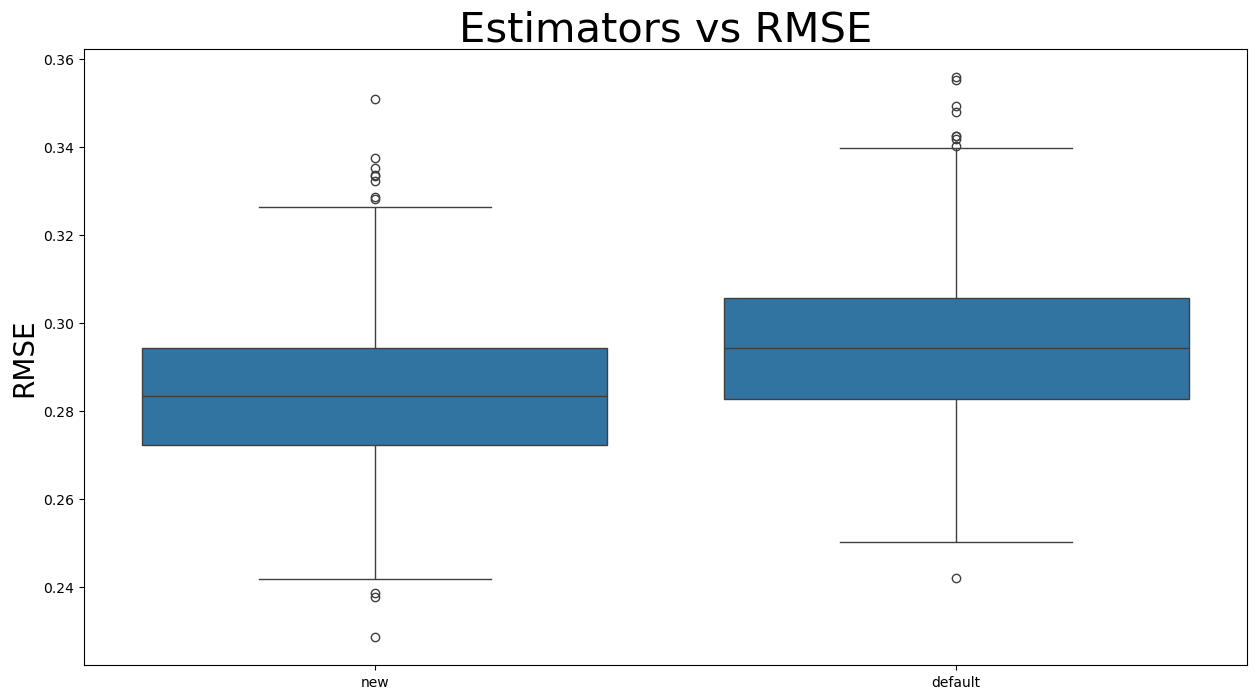

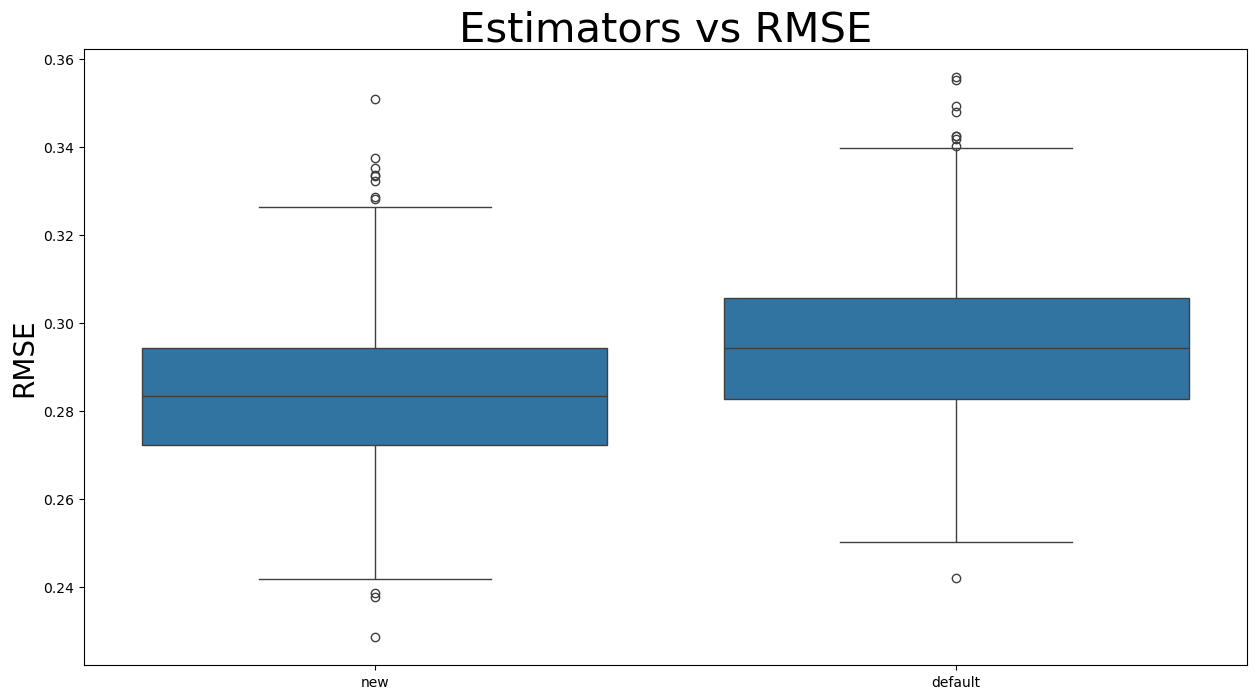

In [104]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params)
models_XGB['default'] = xgboost.XGBRegressor()

if apply_scaler:
    results_XGB = train_and_test_regressor(models_XGB, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test, scaler = scaler)
else:
    results_XGB = train_and_test_regressor(models_XGB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_XGB)

In [106]:
optuna.visualization.plot_slice(XGB_res, params = ['n_estimators', 'max_depth'])

In [107]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

Fitting 400
Fitting 450
Fitting 500
Fitting 550
Fitting 600
Fitting 650
Fitting 700
Fitting 750
Fitting 800
Fitting 850
Fitting 900
Fitting 950
Calculating bootstrap score for 400
Calculating bootstrap score for 450
Calculating bootstrap score for 500
Calculating bootstrap score for 550
Calculating bootstrap score for 600
Calculating bootstrap score for 650
Calculating bootstrap score for 700
Calculating bootstrap score for 750
Calculating bootstrap score for 800
Calculating bootstrap score for 850
Calculating bootstrap score for 900
Calculating bootstrap score for 950


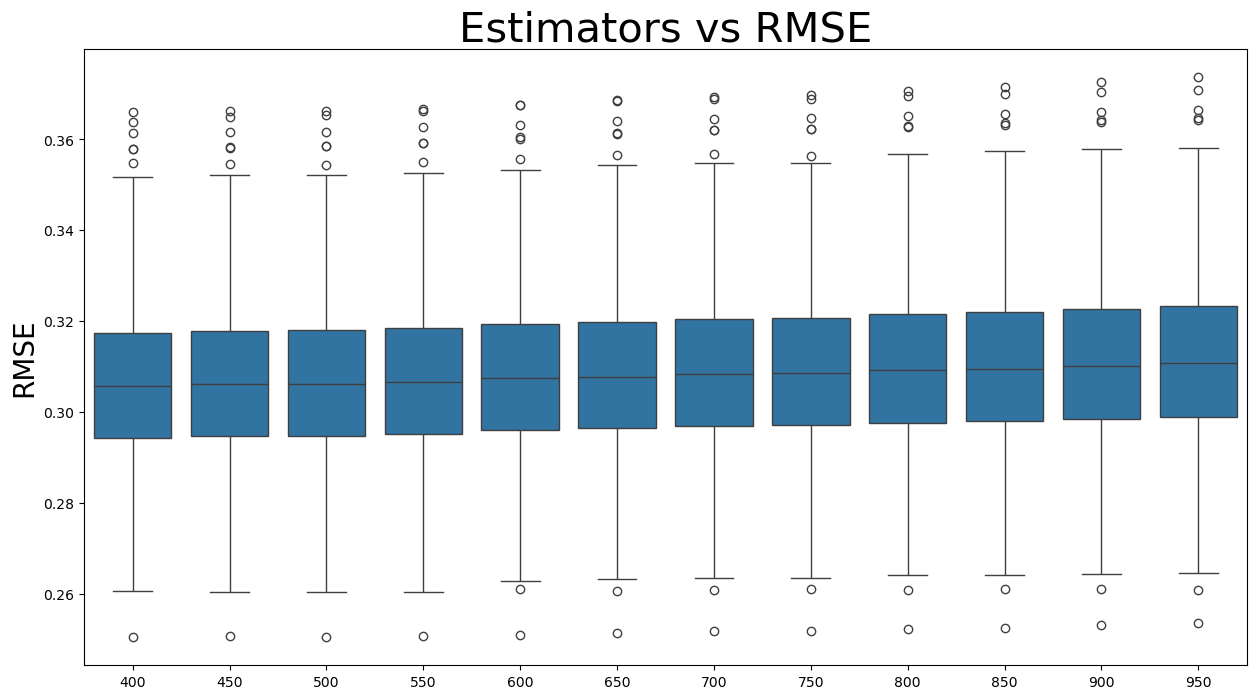

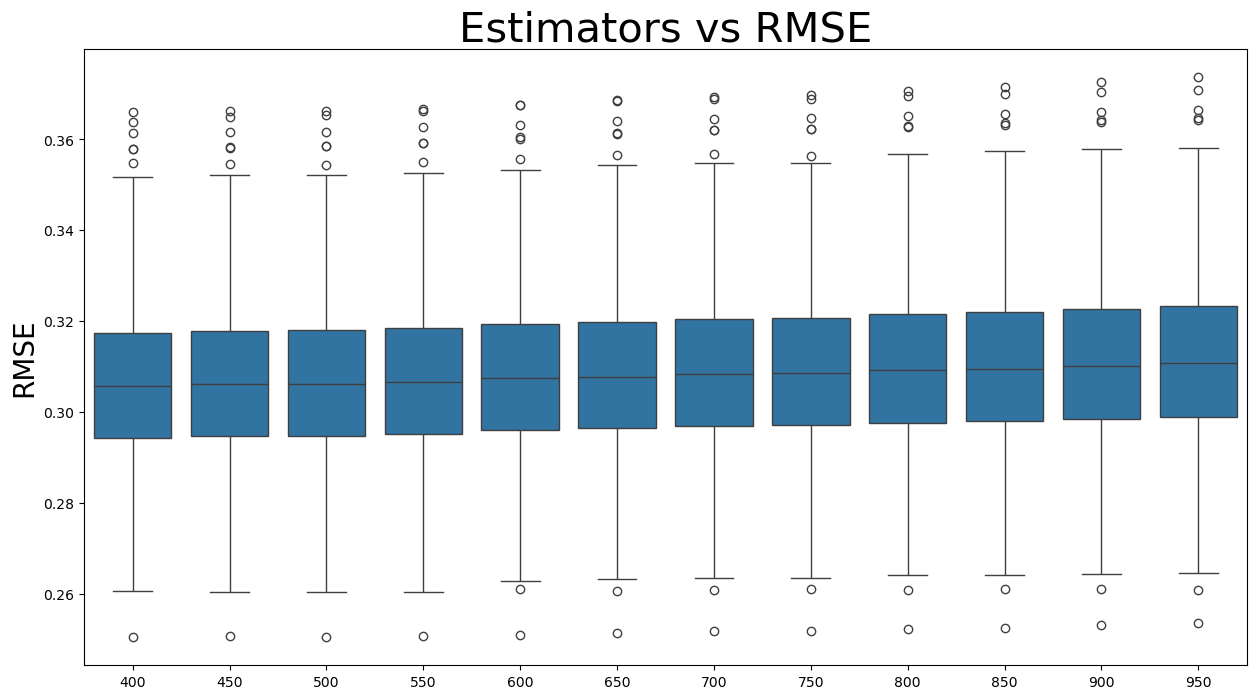

In [86]:
#Visualising selection of n_estimators
XGB_params_loc = XGB_params.copy()
del XGB_params_loc['n_estimators']

model = {}
for i in range(400, 1000, 50):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params_loc, n_estimators = i)

if apply_scaler:
    path = train_and_test_regressor(model, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
else:
    path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

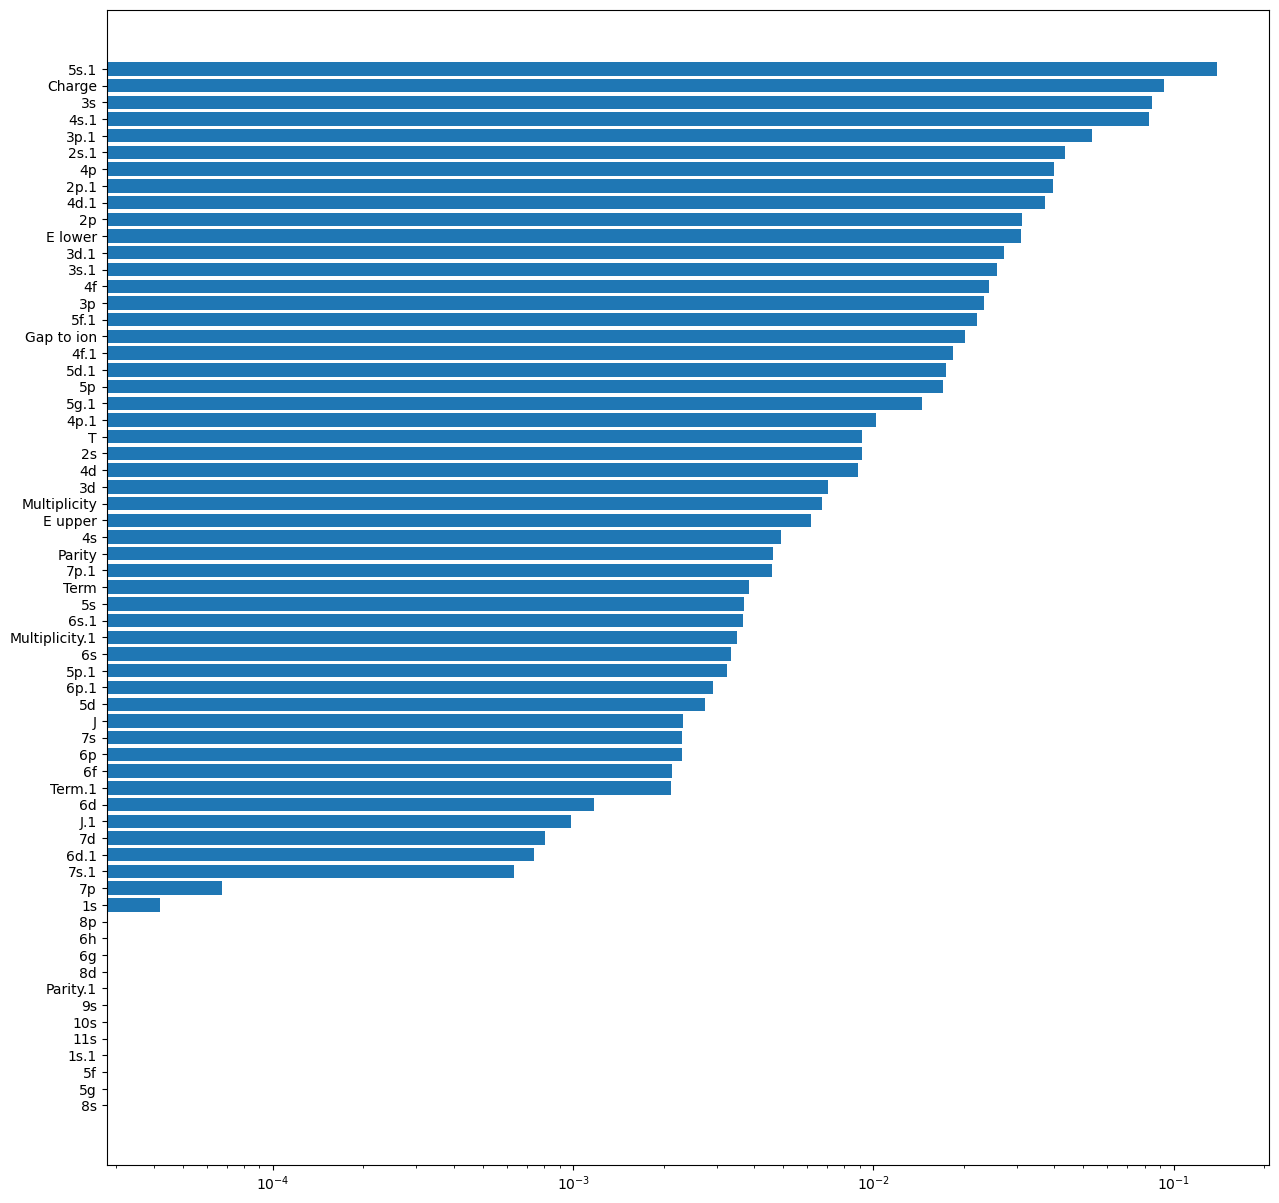

In [108]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [109]:
optuna.visualization.plot_optimization_history(XGB_res)

## LightGBM

In [152]:
LightGBM_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 6
    }

model_name = LightGBM

if apply_scaler:
    print('Scaling')
    LightGBM_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 300)
else:
    LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 300)

with open(f'LightGBM_A+I_Eraw_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

[I 2024-02-21 16:11:54,523] A new study created in memory with name: no-name-349a66df-072a-450c-a04c-3b7eef897626


Start hyperparameter optimization


  0%|          | 0/300 [00:00<?, ?it/s]

{'n_estimators': 310, 'learning_rate': 0.38275166692574936, 'num_leaves': 377, 'reg_alpha': 5.988488789296101e-05, 'reg_lambda': 0.8955560554542998}
{'n_estimators': 792, 'learning_rate': 0.025698477269051206, 'num_leaves': 502, 'reg_alpha': 0.0014617224689332329, 'reg_lambda': 0.3031754330521252}
{'n_estimators': 152, 'learning_rate': 0.1040559095699832, 'num_leaves': 456, 'reg_alpha': 0.0010126194031433524, 'reg_lambda': 7.411181611770239e-05}
{'n_estimators': 27, 'learning_rate': 0.023964828722273658, 'num_leaves': 340, 'reg_alpha': 0.00446635697042415, 'reg_lambda': 0.04313157940419772}
{'n_estimators': 25, 'learning_rate': 0.03681795161459358, 'num_leaves': 500, 'reg_alpha': 1.340913339070965, 'reg_lambda': 0.09764316316150329}
{'n_estimators': 11, 'learning_rate': 0.10407577428448804, 'num_leaves': 421, 'reg_alpha': 9.970159500131262, 'reg_lambda': 4.8926094493223744e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:54,728] Trial 5 finished with value: 0.7175656894853486 and parameters: {'n_estimators': 11, 'learning_rate': 0.10407577428448804, 'num_leaves': 421, 'reg_alpha': 9.970159500131262, 'reg_lambda': 4.8926094493223744e-05}. Best is trial 5 with value: 0.7175656894853486.
{'n_estimators': 23, 'learning_rate': 0.06033677629739115, 'num_leaves': 411, 'reg_alpha': 0.00031115228440591606, 'reg_lambda': 5.632455733338526e-06}
[I 2024-02-21 16:11:54,870] Trial 4 finished with value: 0.7347225020538535 and parameters: {'n_estimators': 25, 'learning_rate': 0.03681795161459358, 'num_leaves': 500, 'reg_alpha': 1.340913339070965, 'reg_lambda': 0.09764316316150329}. Best is trial 5 with value: 0.7175656894853486.
{'n_estimators': 42, 'learning_rate': 0.03500980562822575, 'num_leaves': 354, 'reg_alpha': 1.9625112800734912e-06, 'reg_lambda': 2.2948934996389285e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:54,946] Trial 3 finished with value: 0.8501941801503932 and parameters: {'n_estimators': 27, 'learning_rate': 0.023964828722273658, 'num_leaves': 340, 'reg_alpha': 0.00446635697042415, 'reg_lambda': 0.04313157940419772}. Best is trial 5 with value: 0.7175656894853486.
{'n_estimators': 463, 'learning_rate': 0.3471212482620426, 'num_leaves': 282, 'reg_alpha': 9.865642798442206, 'reg_lambda': 0.0061433554388233185}
[I 2024-02-21 16:11:55,093] Trial 6 finished with value: 0.5644551312398898 and parameters: {'n_estimators': 23, 'learning_rate': 0.06033677629739115, 'num_leaves': 411, 'reg_alpha': 0.00031115228440591606, 'reg_lambda': 5.632455733338526e-06}. Best is trial 6 with value: 0.5644551312398898.
{'n_estimators': 226, 'learning_rate': 0.13564901118895129, 'num_leaves': 82, 'reg_alpha': 0.08289028643983555, 'reg_lambda': 4.888336681303871}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:55,458] Trial 7 finished with value: 0.5494172170635713 and parameters: {'n_estimators': 42, 'learning_rate': 0.03500980562822575, 'num_leaves': 354, 'reg_alpha': 1.9625112800734912e-06, 'reg_lambda': 2.2948934996389285e-06}. Best is trial 7 with value: 0.5494172170635713.
{'n_estimators': 45, 'learning_rate': 0.3532734571737233, 'num_leaves': 508, 'reg_alpha': 4.931994749275195e-07, 'reg_lambda': 1.957505297171027e-07}
[I 2024-02-21 16:11:55,492] Trial 8 finished with value: 0.42820731429416925 and parameters: {'n_estimators': 463, 'learning_rate': 0.3471212482620426, 'num_leaves': 282, 'reg_alpha': 9.865642798442206, 'reg_lambda': 0.0061433554388233185}. Best is trial 8 with value: 0.42820731429416925.
{'n_estimators': 113, 'learning_rate': 0.027178177731626087, 'num_leaves': 30, 'reg_alpha': 1.3958551813466651e-05, 'reg_lambda': 0.004256568968761746}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:56,051] Trial 11 finished with value: 0.4740611151582998 and parameters: {'n_estimators': 113, 'learning_rate': 0.027178177731626087, 'num_leaves': 30, 'reg_alpha': 1.3958551813466651e-05, 'reg_lambda': 0.004256568968761746}. Best is trial 8 with value: 0.42820731429416925.
{'n_estimators': 615, 'learning_rate': 0.20770935846401647, 'num_leaves': 86, 'reg_alpha': 8.32175613622439, 'reg_lambda': 0.0013332586222567463}
[I 2024-02-21 16:11:56,193] Trial 10 finished with value: 0.3475936979668816 and parameters: {'n_estimators': 45, 'learning_rate': 0.3532734571737233, 'num_leaves': 508, 'reg_alpha': 4.931994749275195e-07, 'reg_lambda': 1.957505297171027e-07}. Best is trial 10 with value: 0.3475936979668816.
{'n_estimators': 158, 'learning_rate': 0.04248750600562487, 'num_leaves': 27, 'reg_alpha': 5.449478968976031e-07, 'reg_lambda': 3.2731632043610633e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:56,704] Trial 12 finished with value: 0.4153174746243617 and parameters: {'n_estimators': 615, 'learning_rate': 0.20770935846401647, 'num_leaves': 86, 'reg_alpha': 8.32175613622439, 'reg_lambda': 0.0013332586222567463}. Best is trial 10 with value: 0.3475936979668816.
{'n_estimators': 144, 'learning_rate': 0.030250754175877234, 'num_leaves': 456, 'reg_alpha': 7.850621677621312e-08, 'reg_lambda': 0.03817215424049396}
[I 2024-02-21 16:11:56,795] Trial 2 finished with value: 0.34253573579345764 and parameters: {'n_estimators': 152, 'learning_rate': 0.1040559095699832, 'num_leaves': 456, 'reg_alpha': 0.0010126194031433524, 'reg_lambda': 7.411181611770239e-05}. Best is trial 2 with value: 0.34253573579345764.
{'n_estimators': 84, 'learning_rate': 0.017847044954973527, 'num_leaves': 372, 'reg_alpha': 3.178036974849792, 'reg_lambda': 0.00012271806813164446}
[I 2024-02-21 16:11:56,867] Trial 13 finished with value: 0.410207474711184 and parameters: {'n_estimators': 158, 'le

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:57,047] Trial 9 finished with value: 0.3352312085039101 and parameters: {'n_estimators': 226, 'learning_rate': 0.13564901118895129, 'num_leaves': 82, 'reg_alpha': 0.08289028643983555, 'reg_lambda': 4.888336681303871}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 153, 'learning_rate': 0.3302065033623783, 'num_leaves': 253, 'reg_alpha': 0.00764459263451771, 'reg_lambda': 0.004839337605702652}
[I 2024-02-21 16:11:57,233] Trial 16 finished with value: 0.45032104527130795 and parameters: {'n_estimators': 33, 'learning_rate': 0.07131925947104185, 'num_leaves': 101, 'reg_alpha': 1.3646370615811922e-06, 'reg_lambda': 1.2064359165223635}. Best is trial 9 with value: 0.3352312085039101.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



{'n_estimators': 745, 'learning_rate': 0.03863913926395422, 'num_leaves': 226, 'reg_alpha': 5.850702591435715e-08, 'reg_lambda': 8.028407337314257e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:57,461] Trial 15 finished with value: 0.5951818407671026 and parameters: {'n_estimators': 84, 'learning_rate': 0.017847044954973527, 'num_leaves': 372, 'reg_alpha': 3.178036974849792, 'reg_lambda': 0.00012271806813164446}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 31, 'learning_rate': 0.06055268910800724, 'num_leaves': 195, 'reg_alpha': 0.029303021608845015, 'reg_lambda': 1.031488927307853e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:57,873] Trial 19 finished with value: 0.48303352287809476 and parameters: {'n_estimators': 31, 'learning_rate': 0.06055268910800724, 'num_leaves': 195, 'reg_alpha': 0.029303021608845015, 'reg_lambda': 1.031488927307853e-05}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 235, 'learning_rate': 0.22889813471268355, 'num_leaves': 53, 'reg_alpha': 8.95019736618611e-07, 'reg_lambda': 5.828465468289016e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:58,606] Trial 14 finished with value: 0.379535569224341 and parameters: {'n_estimators': 144, 'learning_rate': 0.030250754175877234, 'num_leaves': 456, 'reg_alpha': 7.850621677621312e-08, 'reg_lambda': 0.03817215424049396}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 36, 'learning_rate': 0.1096022768122471, 'num_leaves': 407, 'reg_alpha': 4.256544716012586e-05, 'reg_lambda': 2.713637930851855}
[I 2024-02-21 16:11:58,720] Trial 0 finished with value: 0.3610436060145242 and parameters: {'n_estimators': 310, 'learning_rate': 0.38275166692574936, 'num_leaves': 377, 'reg_alpha': 5.988488789296101e-05, 'reg_lambda': 0.8955560554542998}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 61, 'learning_rate': 0.028627923988156306, 'num_leaves': 471, 'reg_alpha': 3.86979126778928e-07, 'reg_lambda': 0.007244181304439588}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:59,078] Trial 21 finished with value: 0.3992122806146824 and parameters: {'n_estimators': 36, 'learning_rate': 0.1096022768122471, 'num_leaves': 407, 'reg_alpha': 4.256544716012586e-05, 'reg_lambda': 2.713637930851855}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 20, 'learning_rate': 0.050532025244959804, 'num_leaves': 60, 'reg_alpha': 0.0004196366304953831, 'reg_lambda': 1.0770810468907603e-07}
[I 2024-02-21 16:11:59,215] Trial 17 finished with value: 0.34653193467665816 and parameters: {'n_estimators': 153, 'learning_rate': 0.3302065033623783, 'num_leaves': 253, 'reg_alpha': 0.00764459263451771, 'reg_lambda': 0.004839337605702652}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 18, 'learning_rate': 0.186129742371469, 'num_leaves': 131, 'reg_alpha': 0.0005839232669923458, 'reg_lambda': 1.913034369437426e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:11:59,326] Trial 20 finished with value: 0.3367851657890949 and parameters: {'n_estimators': 235, 'learning_rate': 0.22889813471268355, 'num_leaves': 53, 'reg_alpha': 8.95019736618611e-07, 'reg_lambda': 5.828465468289016e-05}. Best is trial 9 with value: 0.3352312085039101.
[I 2024-02-21 16:11:59,328] Trial 23 finished with value: 0.6925568784206264 and parameters: {'n_estimators': 20, 'learning_rate': 0.050532025244959804, 'num_leaves': 60, 'reg_alpha': 0.0004196366304953831, 'reg_lambda': 1.0770810468907603e-07}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 486, 'learning_rate': 0.3117894010403622, 'num_leaves': 114, 'reg_alpha': 6.958674479520826e-06, 'reg_lambda': 0.005169603215264658}
{'n_estimators': 803, 'learning_rate': 0.03341387979850514, 'num_leaves': 250, 'reg_alpha': 6.492386432782907, 'reg_lambda': 0.0029996028626013255}
[I 2024-02-21 16:11:59,491] Trial 24 finished with value: 0.39919822443681285 and parameters: {'n_estimators': 18, '

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:11:59,522] Trial 22 finished with value: 0.5018652821800039 and parameters: {'n_estimators': 61, 'learning_rate': 0.028627923988156306, 'num_leaves': 471, 'reg_alpha': 3.86979126778928e-07, 'reg_lambda': 0.007244181304439588}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 600, 'learning_rate': 0.06068487524620792, 'num_leaves': 127, 'reg_alpha': 8.204142968577981, 'reg_lambda': 2.4370120043069695e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:00,791] Trial 28 finished with value: 0.41384658171508326 and parameters: {'n_estimators': 600, 'learning_rate': 0.06068487524620792, 'num_leaves': 127, 'reg_alpha': 8.204142968577981, 'reg_lambda': 2.4370120043069695e-05}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 62, 'learning_rate': 0.04223961054396083, 'num_leaves': 379, 'reg_alpha': 8.750294905602537e-05, 'reg_lambda': 3.3699705986539916e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:01,531] Trial 29 finished with value: 0.42758601907279054 and parameters: {'n_estimators': 62, 'learning_rate': 0.04223961054396083, 'num_leaves': 379, 'reg_alpha': 8.750294905602537e-05, 'reg_lambda': 3.3699705986539916e-05}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 813, 'learning_rate': 0.1090304921241777, 'num_leaves': 230, 'reg_alpha': 0.36748026579502224, 'reg_lambda': 0.002156026090350122}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:01,963] Trial 26 finished with value: 0.3986426855347599 and parameters: {'n_estimators': 803, 'learning_rate': 0.03341387979850514, 'num_leaves': 250, 'reg_alpha': 6.492386432782907, 'reg_lambda': 0.0029996028626013255}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 410, 'learning_rate': 0.3076578787470619, 'num_leaves': 509, 'reg_alpha': 0.06245601851372011, 'reg_lambda': 3.4569895827294768}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:02,638] Trial 27 finished with value: 0.33843111715688595 and parameters: {'n_estimators': 482, 'learning_rate': 0.14637332097957237, 'num_leaves': 64, 'reg_alpha': 0.002113177186932469, 'reg_lambda': 0.016574256105354974}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 35, 'learning_rate': 0.39345382657030226, 'num_leaves': 241, 'reg_alpha': 0.004369569680352874, 'reg_lambda': 2.819786647712191e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:03,105] Trial 32 finished with value: 0.3525826698212095 and parameters: {'n_estimators': 35, 'learning_rate': 0.39345382657030226, 'num_leaves': 241, 'reg_alpha': 0.004369569680352874, 'reg_lambda': 2.819786647712191e-05}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 157, 'learning_rate': 0.07686589245419118, 'num_leaves': 415, 'reg_alpha': 7.321869915639159e-06, 'reg_lambda': 0.012088231599381648}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:04,316] Trial 25 finished with value: 0.3551042092842479 and parameters: {'n_estimators': 486, 'learning_rate': 0.3117894010403622, 'num_leaves': 114, 'reg_alpha': 6.958674479520826e-06, 'reg_lambda': 0.005169603215264658}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 66, 'learning_rate': 0.04410457769415317, 'num_leaves': 110, 'reg_alpha': 5.049784178726697e-05, 'reg_lambda': 0.005241032543152764}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:04,954] Trial 34 finished with value: 0.41633953780844185 and parameters: {'n_estimators': 66, 'learning_rate': 0.04410457769415317, 'num_leaves': 110, 'reg_alpha': 5.049784178726697e-05, 'reg_lambda': 0.005241032543152764}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 332, 'learning_rate': 0.15608967337089857, 'num_leaves': 276, 'reg_alpha': 4.693159523684963e-07, 'reg_lambda': 2.982860553437077e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:05,256] Trial 33 finished with value: 0.3445430748614622 and parameters: {'n_estimators': 157, 'learning_rate': 0.07686589245419118, 'num_leaves': 415, 'reg_alpha': 7.321869915639159e-06, 'reg_lambda': 0.012088231599381648}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 660, 'learning_rate': 0.02248434236130207, 'num_leaves': 214, 'reg_alpha': 1.4886533242440227e-06, 'reg_lambda': 4.504340622939829e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:05,623] Trial 1 finished with value: 0.33705033091166775 and parameters: {'n_estimators': 792, 'learning_rate': 0.025698477269051206, 'num_leaves': 502, 'reg_alpha': 0.0014617224689332329, 'reg_lambda': 0.3031754330521252}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 79, 'learning_rate': 0.036656528072366065, 'num_leaves': 347, 'reg_alpha': 0.002580480772007357, 'reg_lambda': 6.072489131645641e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:06,535] Trial 37 finished with value: 0.41698104923950313 and parameters: {'n_estimators': 79, 'learning_rate': 0.036656528072366065, 'num_leaves': 347, 'reg_alpha': 0.002580480772007357, 'reg_lambda': 6.072489131645641e-07}. Best is trial 9 with value: 0.3352312085039101.
{'n_estimators': 16, 'learning_rate': 0.09786003590135682, 'num_leaves': 434, 'reg_alpha': 3.1384943452958e-06, 'reg_lambda': 1.8303844907729826e-08}
[I 2024-02-21 16:12:06,586] Trial 30 finished with value: 0.33382193554571576 and parameters: {'n_estimators': 813, 'learning_rate': 0.1090304921241777, 'num_leaves': 230, 'reg_alpha': 0.36748026579502224, 'reg_lambda': 0.002156026090350122}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 219, 'learning_rate': 0.027651399486417292, 'num_leaves': 363, 'reg_alpha': 1.0123381925740152e-08, 'reg_lambda': 0.1381168919819354}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:06,781] Trial 18 finished with value: 0.3390440261005238 and parameters: {'n_estimators': 745, 'learning_rate': 0.03863913926395422, 'num_leaves': 226, 'reg_alpha': 5.850702591435715e-08, 'reg_lambda': 8.028407337314257e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 37, 'learning_rate': 0.3009582005471741, 'num_leaves': 244, 'reg_alpha': 0.004402937999964739, 'reg_lambda': 0.0005956108479494678}
[I 2024-02-21 16:12:06,824] Trial 38 finished with value: 0.52369656980911 and parameters: {'n_estimators': 16, 'learning_rate': 0.09786003590135682, 'num_leaves': 434, 'reg_alpha': 3.1384943452958e-06, 'reg_lambda': 1.8303844907729826e-08}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 236, 'learning_rate': 0.010155828485752808, 'num_leaves': 164, 'reg_alpha': 7.686403383411845e-08, 'reg_lambda': 4.6132864218771194e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:06,998] Trial 31 finished with value: 0.3527493269719012 and parameters: {'n_estimators': 410, 'learning_rate': 0.3076578787470619, 'num_leaves': 509, 'reg_alpha': 0.06245601851372011, 'reg_lambda': 3.4569895827294768}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 260, 'learning_rate': 0.012341675880246991, 'num_leaves': 12, 'reg_alpha': 2.4591926316373293e-05, 'reg_lambda': 1.7928186308086482}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:07,329] Trial 40 finished with value: 0.3501024129253731 and parameters: {'n_estimators': 37, 'learning_rate': 0.3009582005471741, 'num_leaves': 244, 'reg_alpha': 0.004402937999964739, 'reg_lambda': 0.0005956108479494678}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 73, 'learning_rate': 0.021611883222167217, 'num_leaves': 271, 'reg_alpha': 1.138809622420891, 'reg_lambda': 0.0009514683356713577}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:07,710] Trial 42 finished with value: 0.5784653795677827 and parameters: {'n_estimators': 260, 'learning_rate': 0.012341675880246991, 'num_leaves': 12, 'reg_alpha': 2.4591926316373293e-05, 'reg_lambda': 1.7928186308086482}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 11, 'learning_rate': 0.4413784254248454, 'num_leaves': 46, 'reg_alpha': 4.980864788539139e-05, 'reg_lambda': 0.17248233964534096}
[I 2024-02-21 16:12:07,857] Trial 44 finished with value: 0.4146845550045356 and parameters: {'n_estimators': 11, 'learning_rate': 0.4413784254248454, 'num_leaves': 46, 'reg_alpha': 4.980864788539139e-05, 'reg_lambda': 0.17248233964534096}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 61, 'learning_rate': 0.06127372037419939, 'num_leaves': 313, 'reg_alpha': 0.5474751343885601, 'reg_lambda': 1.3124666282900876e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:08,017] Trial 43 finished with value: 0.5519979988760004 and parameters: {'n_estimators': 73, 'learning_rate': 0.021611883222167217, 'num_leaves': 271, 'reg_alpha': 1.138809622420891, 'reg_lambda': 0.0009514683356713577}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 927, 'learning_rate': 0.01866143295340246, 'num_leaves': 464, 'reg_alpha': 7.534034182801394e-08, 'reg_lambda': 0.0006380395795841291}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:08,572] Trial 45 finished with value: 0.3965384763114216 and parameters: {'n_estimators': 61, 'learning_rate': 0.06127372037419939, 'num_leaves': 313, 'reg_alpha': 0.5474751343885601, 'reg_lambda': 1.3124666282900876e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 61, 'learning_rate': 0.1294826905583291, 'num_leaves': 312, 'reg_alpha': 1.6654840070577807e-06, 'reg_lambda': 1.1509612926644304}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:09,366] Trial 47 finished with value: 0.356177716986574 and parameters: {'n_estimators': 61, 'learning_rate': 0.1294826905583291, 'num_leaves': 312, 'reg_alpha': 1.6654840070577807e-06, 'reg_lambda': 1.1509612926644304}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 57, 'learning_rate': 0.24950720908721116, 'num_leaves': 129, 'reg_alpha': 0.068579869462734, 'reg_lambda': 6.459405835624914e-05}
[I 2024-02-21 16:12:09,485] Trial 35 finished with value: 0.34255289269207356 and parameters: {'n_estimators': 332, 'learning_rate': 0.15608967337089857, 'num_leaves': 276, 'reg_alpha': 4.693159523684963e-07, 'reg_lambda': 2.982860553437077e-08}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 23, 'learning_rate': 0.1891141301487068, 'num_leaves': 394, 'reg_alpha': 0.020391384714183086, 'reg_lambda': 4.5778227931483076e-08}
[I 2024-02-21 16:12:09,557] Trial 39 finished with value: 0.36292288920015336 and parameters: {'n_estimators': 219,

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:09,561] Trial 41 finished with value: 0.44163039901031775 and parameters: {'n_estimators': 236, 'learning_rate': 0.010155828485752808, 'num_leaves': 164, 'reg_alpha': 7.686403383411845e-08, 'reg_lambda': 4.6132864218771194e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 372, 'learning_rate': 0.04593093210598064, 'num_leaves': 372, 'reg_alpha': 0.011337308047200933, 'reg_lambda': 6.531319904063283e-05}
{'n_estimators': 763, 'learning_rate': 0.17518266009797814, 'num_leaves': 81, 'reg_alpha': 8.801208310004415e-08, 'reg_lambda': 4.542212602958551}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:09,844] Trial 49 finished with value: 0.37814144097272495 and parameters: {'n_estimators': 23, 'learning_rate': 0.1891141301487068, 'num_leaves': 394, 'reg_alpha': 0.020391384714183086, 'reg_lambda': 4.5778227931483076e-08}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 24, 'learning_rate': 0.10463325153555515, 'num_leaves': 179, 'reg_alpha': 0.023098160234918248, 'reg_lambda': 5.169375442515703}
[I 2024-02-21 16:12:10,027] Trial 48 finished with value: 0.3504108326207057 and parameters: {'n_estimators': 57, 'learning_rate': 0.24950720908721116, 'num_leaves': 129, 'reg_alpha': 0.068579869462734, 'reg_lambda': 6.459405835624914e-05}. Best is trial 30 with value: 0.33382193554571576.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

{'n_estimators': 85, 'learning_rate': 0.03415260482554135, 'num_leaves': 430, 'reg_alpha': 3.11522159326574e-08, 'reg_lambda': 3.958106067215026e-07}
[I 2024-02-21 16:12:10,121] Trial 52 finished with value: 0.46031311149037785 and parameters: {'n_estimators': 24, 'learning_rate': 0.10463325153555515, 'num_leaves': 179, 'reg_alpha': 0.023098160234918248, 'reg_lambda': 5.169375442515703}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 10, 'learning_rate': 0.06314836983210671, 'num_leaves': 142, 'reg_alpha': 1.5101203263001857e-06, 'reg_lambda': 0.13342637701342666}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:10,299] Trial 54 finished with value: 0.8537658235573666 and parameters: {'n_estimators': 10, 'learning_rate': 0.06314836983210671, 'num_leaves': 142, 'reg_alpha': 1.5101203263001857e-06, 'reg_lambda': 0.13342637701342666}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 284, 'learning_rate': 0.4000864333396425, 'num_leaves': 267, 'reg_alpha': 0.010979752612640835, 'reg_lambda': 2.540617858720093e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:11,180] Trial 53 finished with value: 0.4161735827765205 and parameters: {'n_estimators': 85, 'learning_rate': 0.03415260482554135, 'num_leaves': 430, 'reg_alpha': 3.11522159326574e-08, 'reg_lambda': 3.958106067215026e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 198, 'learning_rate': 0.010658997251300073, 'num_leaves': 258, 'reg_alpha': 5.652938521190641e-08, 'reg_lambda': 2.8730338046795036e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:13,411] Trial 36 finished with value: 0.33993648604448484 and parameters: {'n_estimators': 660, 'learning_rate': 0.02248434236130207, 'num_leaves': 214, 'reg_alpha': 1.4886533242440227e-06, 'reg_lambda': 4.504340622939829e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 206, 'learning_rate': 0.015554388214696579, 'num_leaves': 231, 'reg_alpha': 2.3568288328034104, 'reg_lambda': 0.030761708441032973}
[I 2024-02-21 16:12:13,455] Trial 56 finished with value: 0.46215502522092533 and parameters: {'n_estimators': 198, 'learning_rate': 0.010658997251300073, 'num_leaves': 258, 'reg_alpha': 5.652938521190641e-08, 'reg_lambda': 2.8730338046795036e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 834, 'learning_rate': 0.0987438599005567, 'num_leaves': 303, 'reg_alpha': 2.7771445450797225e-06, 'reg_lambda': 2.818211609054106e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:14,000] Trial 55 finished with value: 0.35764815989899634 and parameters: {'n_estimators': 284, 'learning_rate': 0.4000864333396425, 'num_leaves': 267, 'reg_alpha': 0.010979752612640835, 'reg_lambda': 2.540617858720093e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 112, 'learning_rate': 0.04698823300118335, 'num_leaves': 444, 'reg_alpha': 6.415956107447212e-07, 'reg_lambda': 0.20178483885466408}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:14,431] Trial 50 finished with value: 0.339765699343168 and parameters: {'n_estimators': 372, 'learning_rate': 0.04593093210598064, 'num_leaves': 372, 'reg_alpha': 0.011337308047200933, 'reg_lambda': 6.531319904063283e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 118, 'learning_rate': 0.2096580165766634, 'num_leaves': 269, 'reg_alpha': 0.13714855625308112, 'reg_lambda': 4.061302128282202}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:14,962] Trial 57 finished with value: 0.4437195545374714 and parameters: {'n_estimators': 206, 'learning_rate': 0.015554388214696579, 'num_leaves': 231, 'reg_alpha': 2.3568288328034104, 'reg_lambda': 0.030761708441032973}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 417, 'learning_rate': 0.23437179105419184, 'num_leaves': 144, 'reg_alpha': 0.0055661161168816045, 'reg_lambda': 0.003483151562927857}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:15,469] Trial 59 finished with value: 0.3707724673194377 and parameters: {'n_estimators': 112, 'learning_rate': 0.04698823300118335, 'num_leaves': 444, 'reg_alpha': 6.415956107447212e-07, 'reg_lambda': 0.20178483885466408}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 20, 'learning_rate': 0.4225382062617342, 'num_leaves': 175, 'reg_alpha': 0.2705344345514241, 'reg_lambda': 2.465688369469939e-05}
[I 2024-02-21 16:12:15,504] Trial 51 finished with value: 0.3469788683625052 and parameters: {'n_estimators': 763, 'learning_rate': 0.17518266009797814, 'num_leaves': 81, 'reg_alpha': 8.801208310004415e-08, 'reg_lambda': 4.542212602958551}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 436, 'learning_rate': 0.013303747960758361, 'num_leaves': 17, 'reg_alpha': 0.0007323271887339285, 'reg_lambda': 0.004329193715569066}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:15,769] Trial 62 finished with value: 0.3649796101872173 and parameters: {'n_estimators': 20, 'learning_rate': 0.4225382062617342, 'num_leaves': 175, 'reg_alpha': 0.2705344345514241, 'reg_lambda': 2.465688369469939e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 44, 'learning_rate': 0.08087726956419487, 'num_leaves': 461, 'reg_alpha': 7.363259392549854e-07, 'reg_lambda': 3.4146607243186677}
[I 2024-02-21 16:12:15,875] Trial 60 finished with value: 0.3420737619560048 and parameters: {'n_estimators': 118, 'learning_rate': 0.2096580165766634, 'num_leaves': 269, 'reg_alpha': 0.13714855625308112, 'reg_lambda': 4.061302128282202}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 984, 'learning_rate': 0.04582610593245648, 'num_leaves': 473, 'reg_alpha': 0.033561983322473184, 'reg_lambda': 0.8270491253752856}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:16,279] Trial 64 finished with value: 0.40787709599573085 and parameters: {'n_estimators': 44, 'learning_rate': 0.08087726956419487, 'num_leaves': 461, 'reg_alpha': 7.363259392549854e-07, 'reg_lambda': 3.4146607243186677}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 516, 'learning_rate': 0.013140143327783337, 'num_leaves': 459, 'reg_alpha': 0.00771559264976989, 'reg_lambda': 0.11231680778822485}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:16,749] Trial 63 finished with value: 0.4653237639145912 and parameters: {'n_estimators': 436, 'learning_rate': 0.013303747960758361, 'num_leaves': 17, 'reg_alpha': 0.0007323271887339285, 'reg_lambda': 0.004329193715569066}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 951, 'learning_rate': 0.03217624457475929, 'num_leaves': 487, 'reg_alpha': 0.0002441818856081471, 'reg_lambda': 0.007629706450987648}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:20,081] Trial 46 finished with value: 0.33941004517022344 and parameters: {'n_estimators': 927, 'learning_rate': 0.01866143295340246, 'num_leaves': 464, 'reg_alpha': 7.534034182801394e-08, 'reg_lambda': 0.0006380395795841291}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 285, 'learning_rate': 0.013279860097115445, 'num_leaves': 499, 'reg_alpha': 0.004257718046272414, 'reg_lambda': 1.3291570054289088}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:20,312] Trial 61 finished with value: 0.3513157684457343 and parameters: {'n_estimators': 417, 'learning_rate': 0.23437179105419184, 'num_leaves': 144, 'reg_alpha': 0.0055661161168816045, 'reg_lambda': 0.003483151562927857}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 642, 'learning_rate': 0.027451294716628875, 'num_leaves': 511, 'reg_alpha': 0.002525272542736784, 'reg_lambda': 1.6036395386988622}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:23,078] Trial 66 finished with value: 0.35836395591120357 and parameters: {'n_estimators': 516, 'learning_rate': 0.013140143327783337, 'num_leaves': 459, 'reg_alpha': 0.00771559264976989, 'reg_lambda': 0.11231680778822485}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 936, 'learning_rate': 0.052214603931013556, 'num_leaves': 436, 'reg_alpha': 0.014739358361887308, 'reg_lambda': 5.122255764525396}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:23,461] Trial 68 finished with value: 0.3962319900665088 and parameters: {'n_estimators': 285, 'learning_rate': 0.013279860097115445, 'num_leaves': 499, 'reg_alpha': 0.004257718046272414, 'reg_lambda': 1.3291570054289088}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 200, 'learning_rate': 0.12076184155831739, 'num_leaves': 53, 'reg_alpha': 0.05002742135931223, 'reg_lambda': 4.35218474157477}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:24,378] Trial 58 finished with value: 0.3437246403344807 and parameters: {'n_estimators': 834, 'learning_rate': 0.0987438599005567, 'num_leaves': 303, 'reg_alpha': 2.7771445450797225e-06, 'reg_lambda': 2.818211609054106e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 816, 'learning_rate': 0.03442404816248337, 'num_leaves': 473, 'reg_alpha': 6.731532611528442e-08, 'reg_lambda': 0.0017648084007526863}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:24,681] Trial 71 finished with value: 0.3426145066006735 and parameters: {'n_estimators': 200, 'learning_rate': 0.12076184155831739, 'num_leaves': 53, 'reg_alpha': 0.05002742135931223, 'reg_lambda': 4.35218474157477}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 627, 'learning_rate': 0.019145600694819544, 'num_leaves': 477, 'reg_alpha': 1.5191960969726941e-06, 'reg_lambda': 1.6084142631982405e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:29,112] Trial 69 finished with value: 0.339547939925538 and parameters: {'n_estimators': 642, 'learning_rate': 0.027451294716628875, 'num_leaves': 511, 'reg_alpha': 0.002525272542736784, 'reg_lambda': 1.6036395386988622}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 118, 'learning_rate': 0.4110861230472537, 'num_leaves': 48, 'reg_alpha': 1.1371879378037163e-05, 'reg_lambda': 5.643773085828852e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:29,431] Trial 65 finished with value: 0.33710642110117595 and parameters: {'n_estimators': 984, 'learning_rate': 0.04582610593245648, 'num_leaves': 473, 'reg_alpha': 0.033561983322473184, 'reg_lambda': 0.8270491253752856}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 241, 'learning_rate': 0.4574386284044397, 'num_leaves': 96, 'reg_alpha': 2.7295753362520913e-07, 'reg_lambda': 3.862800434941543e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:29,765] Trial 74 finished with value: 0.3482470324234559 and parameters: {'n_estimators': 118, 'learning_rate': 0.4110861230472537, 'num_leaves': 48, 'reg_alpha': 1.1371879378037163e-05, 'reg_lambda': 5.643773085828852e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 644, 'learning_rate': 0.04922486638709791, 'num_leaves': 244, 'reg_alpha': 2.65949359024307e-08, 'reg_lambda': 0.00036239135603156105}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:29,991] Trial 67 finished with value: 0.33777314709355294 and parameters: {'n_estimators': 951, 'learning_rate': 0.03217624457475929, 'num_leaves': 487, 'reg_alpha': 0.0002441818856081471, 'reg_lambda': 0.007629706450987648}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 711, 'learning_rate': 0.018205732393191332, 'num_leaves': 180, 'reg_alpha': 2.7088412711463825e-08, 'reg_lambda': 0.00220899352738046}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:31,697] Trial 75 finished with value: 0.3559344180045037 and parameters: {'n_estimators': 241, 'learning_rate': 0.4574386284044397, 'num_leaves': 96, 'reg_alpha': 2.7295753362520913e-07, 'reg_lambda': 3.862800434941543e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 909, 'learning_rate': 0.08379329224676427, 'num_leaves': 189, 'reg_alpha': 8.498352582796056e-08, 'reg_lambda': 0.0005592860828334393}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:33,634] Trial 73 finished with value: 0.3441588698848952 and parameters: {'n_estimators': 627, 'learning_rate': 0.019145600694819544, 'num_leaves': 477, 'reg_alpha': 1.5191960969726941e-06, 'reg_lambda': 1.6084142631982405e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 884, 'learning_rate': 0.04954366171775254, 'num_leaves': 457, 'reg_alpha': 1.77916488170397, 'reg_lambda': 0.27756947260885106}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:35,960] Trial 72 finished with value: 0.3383868263704027 and parameters: {'n_estimators': 816, 'learning_rate': 0.03442404816248337, 'num_leaves': 473, 'reg_alpha': 6.731532611528442e-08, 'reg_lambda': 0.0017648084007526863}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 960, 'learning_rate': 0.07064689112509875, 'num_leaves': 488, 'reg_alpha': 0.06510209863869945, 'reg_lambda': 0.27196745861388666}
[I 2024-02-21 16:12:35,998] Trial 70 finished with value: 0.33758912935496344 and parameters: {'n_estimators': 936, 'learning_rate': 0.052214603931013556, 'num_leaves': 436, 'reg_alpha': 0.014739358361887308, 'reg_lambda': 5.122255764525396}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 842, 'learning_rate': 0.04910007062394931, 'num_leaves': 477, 'reg_alpha': 2.242966951871765, 'reg_lambda': 0.17750753172246025}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:37,402] Trial 79 finished with value: 0.3501486951207443 and parameters: {'n_estimators': 884, 'learning_rate': 0.04954366171775254, 'num_leaves': 457, 'reg_alpha': 1.77916488170397, 'reg_lambda': 0.27756947260885106}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 975, 'learning_rate': 0.10924533891677529, 'num_leaves': 394, 'reg_alpha': 0.002124226244626258, 'reg_lambda': 0.179075619285313}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:38,047] Trial 76 finished with value: 0.3390822952736257 and parameters: {'n_estimators': 644, 'learning_rate': 0.04922486638709791, 'num_leaves': 244, 'reg_alpha': 2.65949359024307e-08, 'reg_lambda': 0.00036239135603156105}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 973, 'learning_rate': 0.11080860978357894, 'num_leaves': 493, 'reg_alpha': 1.9834527736816695e-06, 'reg_lambda': 0.004668969793841205}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:39,006] Trial 77 finished with value: 0.3421315252147165 and parameters: {'n_estimators': 711, 'learning_rate': 0.018205732393191332, 'num_leaves': 180, 'reg_alpha': 2.7088412711463825e-08, 'reg_lambda': 0.00220899352738046}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 891, 'learning_rate': 0.04389821897517897, 'num_leaves': 281, 'reg_alpha': 0.09462810966663902, 'reg_lambda': 4.399251881150584}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:39,322] Trial 81 finished with value: 0.3562541784080088 and parameters: {'n_estimators': 842, 'learning_rate': 0.04910007062394931, 'num_leaves': 477, 'reg_alpha': 2.242966951871765, 'reg_lambda': 0.17750753172246025}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 834, 'learning_rate': 0.09307856053629392, 'num_leaves': 490, 'reg_alpha': 3.459372175269502e-08, 'reg_lambda': 0.0020464915381153957}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:43,678] Trial 78 finished with value: 0.34495090206306944 and parameters: {'n_estimators': 909, 'learning_rate': 0.08379329224676427, 'num_leaves': 189, 'reg_alpha': 8.498352582796056e-08, 'reg_lambda': 0.0005592860828334393}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 660, 'learning_rate': 0.06457751812195706, 'num_leaves': 10, 'reg_alpha': 0.010546942345499754, 'reg_lambda': 0.005147359030047879}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:44,892] Trial 86 finished with value: 0.36897839924411147 and parameters: {'n_estimators': 660, 'learning_rate': 0.06457751812195706, 'num_leaves': 10, 'reg_alpha': 0.010546942345499754, 'reg_lambda': 0.005147359030047879}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 543, 'learning_rate': 0.05902974106608782, 'num_leaves': 227, 'reg_alpha': 0.001056292858185921, 'reg_lambda': 0.029642948844844252}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:48,839] Trial 80 finished with value: 0.3408659427015905 and parameters: {'n_estimators': 960, 'learning_rate': 0.07064689112509875, 'num_leaves': 488, 'reg_alpha': 0.06510209863869945, 'reg_lambda': 0.27196745861388666}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 468, 'learning_rate': 0.12500948157820402, 'num_leaves': 190, 'reg_alpha': 0.0007333436095934601, 'reg_lambda': 0.37503688324905426}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:50,033] Trial 84 finished with value: 0.33827854247378014 and parameters: {'n_estimators': 891, 'learning_rate': 0.04389821897517897, 'num_leaves': 281, 'reg_alpha': 0.09462810966663902, 'reg_lambda': 4.399251881150584}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 655, 'learning_rate': 0.059600989571536096, 'num_leaves': 458, 'reg_alpha': 4.240359623115325e-05, 'reg_lambda': 0.0018224748335307847}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:50,842] Trial 82 finished with value: 0.3466931985532916 and parameters: {'n_estimators': 975, 'learning_rate': 0.10924533891677529, 'num_leaves': 394, 'reg_alpha': 0.002124226244626258, 'reg_lambda': 0.179075619285313}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 930, 'learning_rate': 0.05142727117776189, 'num_leaves': 278, 'reg_alpha': 0.0021616963941078707, 'reg_lambda': 2.895556730926937}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:51,244] Trial 85 finished with value: 0.3432292379617879 and parameters: {'n_estimators': 834, 'learning_rate': 0.09307856053629392, 'num_leaves': 490, 'reg_alpha': 3.459372175269502e-08, 'reg_lambda': 0.0020464915381153957}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 475, 'learning_rate': 0.05705523983753292, 'num_leaves': 255, 'reg_alpha': 0.31009121642936716, 'reg_lambda': 1.3369274872310966}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:51,702] Trial 83 finished with value: 0.34549253953499987 and parameters: {'n_estimators': 973, 'learning_rate': 0.11080860978357894, 'num_leaves': 493, 'reg_alpha': 1.9834527736816695e-06, 'reg_lambda': 0.004668969793841205}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 663, 'learning_rate': 0.0965041207901583, 'num_leaves': 233, 'reg_alpha': 0.17926798100329655, 'reg_lambda': 1.3413193062621704}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:52,021] Trial 87 finished with value: 0.3383474417487692 and parameters: {'n_estimators': 543, 'learning_rate': 0.05902974106608782, 'num_leaves': 227, 'reg_alpha': 0.001056292858185921, 'reg_lambda': 0.029642948844844252}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 641, 'learning_rate': 0.021395485485834562, 'num_leaves': 157, 'reg_alpha': 0.018653206972572858, 'reg_lambda': 2.048440167085731}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:55,010] Trial 88 finished with value: 0.3430202880461389 and parameters: {'n_estimators': 468, 'learning_rate': 0.12500948157820402, 'num_leaves': 190, 'reg_alpha': 0.0007333436095934601, 'reg_lambda': 0.37503688324905426}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 469, 'learning_rate': 0.04122610357798695, 'num_leaves': 150, 'reg_alpha': 0.01870579616841464, 'reg_lambda': 3.6066719930549067}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:56,815] Trial 91 finished with value: 0.33601473074238497 and parameters: {'n_estimators': 475, 'learning_rate': 0.05705523983753292, 'num_leaves': 255, 'reg_alpha': 0.31009121642936716, 'reg_lambda': 1.3369274872310966}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 778, 'learning_rate': 0.024132662467697498, 'num_leaves': 218, 'reg_alpha': 0.2184317932531245, 'reg_lambda': 2.637423762037194}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:12:58,897] Trial 92 finished with value: 0.33902148981266006 and parameters: {'n_estimators': 663, 'learning_rate': 0.0965041207901583, 'num_leaves': 233, 'reg_alpha': 0.17926798100329655, 'reg_lambda': 1.3413193062621704}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 928, 'learning_rate': 0.02927966230800295, 'num_leaves': 473, 'reg_alpha': 0.00017712550501035378, 'reg_lambda': 0.00016734361683458916}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:59,239] Trial 89 finished with value: 0.34035790218352807 and parameters: {'n_estimators': 655, 'learning_rate': 0.059600989571536096, 'num_leaves': 458, 'reg_alpha': 4.240359623115325e-05, 'reg_lambda': 0.0018224748335307847}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 373, 'learning_rate': 0.05317497689512956, 'num_leaves': 366, 'reg_alpha': 0.03864045350693671, 'reg_lambda': 5.720250619953367}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:12:59,837] Trial 93 finished with value: 0.3445639360969276 and parameters: {'n_estimators': 641, 'learning_rate': 0.021395485485834562, 'num_leaves': 157, 'reg_alpha': 0.018653206972572858, 'reg_lambda': 2.048440167085731}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 160, 'learning_rate': 0.13429616468077377, 'num_leaves': 24, 'reg_alpha': 4.0217061119198314e-07, 'reg_lambda': 0.0012083281914470143}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:00,458] Trial 98 finished with value: 0.36100686061669596 and parameters: {'n_estimators': 160, 'learning_rate': 0.13429616468077377, 'num_leaves': 24, 'reg_alpha': 4.0217061119198314e-07, 'reg_lambda': 0.0012083281914470143}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 684, 'learning_rate': 0.03240442691900385, 'num_leaves': 363, 'reg_alpha': 0.0005986019195824244, 'reg_lambda': 3.4247938722106186}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:00,841] Trial 94 finished with value: 0.3402457911509731 and parameters: {'n_estimators': 469, 'learning_rate': 0.04122610357798695, 'num_leaves': 150, 'reg_alpha': 0.01870579616841464, 'reg_lambda': 3.6066719930549067}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 644, 'learning_rate': 0.05068840197093889, 'num_leaves': 195, 'reg_alpha': 0.0008392515330168682, 'reg_lambda': 0.006573820740464818}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:02,863] Trial 90 finished with value: 0.34045313684621015 and parameters: {'n_estimators': 930, 'learning_rate': 0.05142727117776189, 'num_leaves': 278, 'reg_alpha': 0.0021616963941078707, 'reg_lambda': 2.895556730926937}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 715, 'learning_rate': 0.01531860279113428, 'num_leaves': 428, 'reg_alpha': 0.00017381222748425617, 'reg_lambda': 0.00024719233603842563}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:03,994] Trial 97 finished with value: 0.3424406125939883 and parameters: {'n_estimators': 373, 'learning_rate': 0.05317497689512956, 'num_leaves': 366, 'reg_alpha': 0.03864045350693671, 'reg_lambda': 5.720250619953367}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 705, 'learning_rate': 0.03078603710618942, 'num_leaves': 496, 'reg_alpha': 0.0008014763055919724, 'reg_lambda': 0.001590025407854578}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:06,075] Trial 95 finished with value: 0.3383609392071817 and parameters: {'n_estimators': 778, 'learning_rate': 0.024132662467697498, 'num_leaves': 218, 'reg_alpha': 0.2184317932531245, 'reg_lambda': 2.637423762037194}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 511, 'learning_rate': 0.11202920777716105, 'num_leaves': 267, 'reg_alpha': 1.6410367392519816, 'reg_lambda': 0.00018099799579788126}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:07,958] Trial 103 finished with value: 0.3475255916243418 and parameters: {'n_estimators': 511, 'learning_rate': 0.11202920777716105, 'num_leaves': 267, 'reg_alpha': 1.6410367392519816, 'reg_lambda': 0.00018099799579788126}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 209, 'learning_rate': 0.13209762834358724, 'num_leaves': 169, 'reg_alpha': 2.9900516145415115e-06, 'reg_lambda': 1.5133459133345593e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:09,053] Trial 100 finished with value: 0.33914447531195424 and parameters: {'n_estimators': 644, 'learning_rate': 0.05068840197093889, 'num_leaves': 195, 'reg_alpha': 0.0008392515330168682, 'reg_lambda': 0.006573820740464818}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 417, 'learning_rate': 0.1270040336017941, 'num_leaves': 10, 'reg_alpha': 1.114846241427762e-07, 'reg_lambda': 6.0625903887138705e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:09,387] Trial 99 finished with value: 0.3398163754967344 and parameters: {'n_estimators': 684, 'learning_rate': 0.03240442691900385, 'num_leaves': 363, 'reg_alpha': 0.0005986019195824244, 'reg_lambda': 3.4247938722106186}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 824, 'learning_rate': 0.02022198217426302, 'num_leaves': 325, 'reg_alpha': 0.2987368946494467, 'reg_lambda': 0.04908571959794128}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:09,834] Trial 105 finished with value: 0.35918696312321224 and parameters: {'n_estimators': 417, 'learning_rate': 0.1270040336017941, 'num_leaves': 10, 'reg_alpha': 1.114846241427762e-07, 'reg_lambda': 6.0625903887138705e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 432, 'learning_rate': 0.024989508396200222, 'num_leaves': 265, 'reg_alpha': 0.17997056832796593, 'reg_lambda': 1.4195885524915597}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:10,876] Trial 104 finished with value: 0.3406963942028879 and parameters: {'n_estimators': 209, 'learning_rate': 0.13209762834358724, 'num_leaves': 169, 'reg_alpha': 2.9900516145415115e-06, 'reg_lambda': 1.5133459133345593e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 283, 'learning_rate': 0.049215093737997116, 'num_leaves': 286, 'reg_alpha': 6.268571624653405, 'reg_lambda': 3.070581943243052}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:11,562] Trial 96 finished with value: 0.33826880312183427 and parameters: {'n_estimators': 928, 'learning_rate': 0.02927966230800295, 'num_leaves': 473, 'reg_alpha': 0.00017712550501035378, 'reg_lambda': 0.00016734361683458916}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 897, 'learning_rate': 0.023343490202588284, 'num_leaves': 459, 'reg_alpha': 0.00019980795482303453, 'reg_lambda': 0.00015523348815982808}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:12,355] Trial 108 finished with value: 0.40094768462109 and parameters: {'n_estimators': 283, 'learning_rate': 0.049215093737997116, 'num_leaves': 286, 'reg_alpha': 6.268571624653405, 'reg_lambda': 3.070581943243052}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 383, 'learning_rate': 0.044427745737552794, 'num_leaves': 320, 'reg_alpha': 0.00020812336146595225, 'reg_lambda': 0.013163148735361506}
[I 2024-02-21 16:13:12,452] Trial 101 finished with value: 0.3458575067521218 and parameters: {'n_estimators': 715, 'learning_rate': 0.01531860279113428, 'num_leaves': 428, 'reg_alpha': 0.00017381222748425617, 'reg_lambda': 0.00024719233603842563}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 974, 'learning_rate': 0.17150055041332776, 'num_leaves': 183, 'reg_alpha': 0.9645935729691194, 'reg_lambda': 0.029751744261123578}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:13,887] Trial 102 finished with value: 0.33888263325813395 and parameters: {'n_estimators': 705, 'learning_rate': 0.03078603710618942, 'num_leaves': 496, 'reg_alpha': 0.0008014763055919724, 'reg_lambda': 0.001590025407854578}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 718, 'learning_rate': 0.034162997748009696, 'num_leaves': 454, 'reg_alpha': 1.4100906588930921e-06, 'reg_lambda': 1.2869743368396518}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:14,566] Trial 111 finished with value: 0.33877743433188723 and parameters: {'n_estimators': 974, 'learning_rate': 0.17150055041332776, 'num_leaves': 183, 'reg_alpha': 0.9645935729691194, 'reg_lambda': 0.029751744261123578}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 797, 'learning_rate': 0.05893462026914634, 'num_leaves': 512, 'reg_alpha': 0.00011696083962398508, 'reg_lambda': 3.7635376430631813}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:15,034] Trial 107 finished with value: 0.34791838747682907 and parameters: {'n_estimators': 432, 'learning_rate': 0.024989508396200222, 'num_leaves': 265, 'reg_alpha': 0.17997056832796593, 'reg_lambda': 1.4195885524915597}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 647, 'learning_rate': 0.02271706337061317, 'num_leaves': 494, 'reg_alpha': 3.773119837583257e-05, 'reg_lambda': 0.04562902780289302}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:17,631] Trial 110 finished with value: 0.3407256556401251 and parameters: {'n_estimators': 383, 'learning_rate': 0.044427745737552794, 'num_leaves': 320, 'reg_alpha': 0.00020812336146595225, 'reg_lambda': 0.013163148735361506}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 75, 'learning_rate': 0.4943944280037647, 'num_leaves': 95, 'reg_alpha': 0.028222220066886967, 'reg_lambda': 1.3441991256742603}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:18,353] Trial 115 finished with value: 0.35052600850815513 and parameters: {'n_estimators': 75, 'learning_rate': 0.4943944280037647, 'num_leaves': 95, 'reg_alpha': 0.028222220066886967, 'reg_lambda': 1.3441991256742603}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 601, 'learning_rate': 0.021124446541577118, 'num_leaves': 375, 'reg_alpha': 0.1203616997082496, 'reg_lambda': 1.2191581645147938}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:19,276] Trial 106 finished with value: 0.3397466372535451 and parameters: {'n_estimators': 824, 'learning_rate': 0.02022198217426302, 'num_leaves': 325, 'reg_alpha': 0.2987368946494467, 'reg_lambda': 0.04908571959794128}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 441, 'learning_rate': 0.03539277292962731, 'num_leaves': 504, 'reg_alpha': 8.75115563078116e-06, 'reg_lambda': 0.7018047718846796}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:23,700] Trial 112 finished with value: 0.3356440998838236 and parameters: {'n_estimators': 718, 'learning_rate': 0.034162997748009696, 'num_leaves': 454, 'reg_alpha': 1.4100906588930921e-06, 'reg_lambda': 1.2869743368396518}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 268, 'learning_rate': 0.11320465983278448, 'num_leaves': 507, 'reg_alpha': 1.954060181396309e-06, 'reg_lambda': 3.7624877745057907}
[I 2024-02-21 16:13:23,764] Trial 109 finished with value: 0.3384254589798485 and parameters: {'n_estimators': 897, 'learning_rate': 0.023343490202588284, 'num_leaves': 459, 'reg_alpha': 0.00019980795482303453, 'reg_lambda': 0.00015523348815982808}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 397, 'learning_rate': 0.040066044979872255, 'num_leaves': 512, 'reg_alpha': 1.2493677989083202e-06, 'reg_lambda': 0.29999312569365777}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:24,070] Trial 114 finished with value: 0.34007586060071393 and parameters: {'n_estimators': 647, 'learning_rate': 0.02271706337061317, 'num_leaves': 494, 'reg_alpha': 3.773119837583257e-05, 'reg_lambda': 0.04562902780289302}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 545, 'learning_rate': 0.020992962735046132, 'num_leaves': 366, 'reg_alpha': 6.784444088386014e-08, 'reg_lambda': 8.960142133669413}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:25,360] Trial 113 finished with value: 0.34061600847632034 and parameters: {'n_estimators': 797, 'learning_rate': 0.05893462026914634, 'num_leaves': 512, 'reg_alpha': 0.00011696083962398508, 'reg_lambda': 3.7635376430631813}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 252, 'learning_rate': 0.0814083246195022, 'num_leaves': 281, 'reg_alpha': 0.054837782259378264, 'reg_lambda': 0.0058443302574096734}
[I 2024-02-21 16:13:25,432] Trial 117 finished with value: 0.33991892026671355 and parameters: {'n_estimators': 441, 'learning_rate': 0.03539277292962731, 'num_leaves': 504, 'reg_alpha': 8.75115563078116e-06, 'reg_lambda': 0.7018047718846796}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 123, 'learning_rate': 0.047819349180166885, 'num_leaves': 115, 'reg_alpha': 0.12460452943194861, 'reg_lambda': 0.14249162565101492}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:25,853] Trial 116 finished with value: 0.3442082953426407 and parameters: {'n_estimators': 601, 'learning_rate': 0.021124446541577118, 'num_leaves': 375, 'reg_alpha': 0.1203616997082496, 'reg_lambda': 1.2191581645147938}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 634, 'learning_rate': 0.020697743370745078, 'num_leaves': 450, 'reg_alpha': 4.2131696795496726e-07, 'reg_lambda': 6.414671980575258}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:26,745] Trial 122 finished with value: 0.36516905796586513 and parameters: {'n_estimators': 123, 'learning_rate': 0.047819349180166885, 'num_leaves': 115, 'reg_alpha': 0.12460452943194861, 'reg_lambda': 0.14249162565101492}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 789, 'learning_rate': 0.04945007566320479, 'num_leaves': 327, 'reg_alpha': 0.15457350597844638, 'reg_lambda': 0.0993702991438247}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:27,441] Trial 118 finished with value: 0.33983790292129445 and parameters: {'n_estimators': 268, 'learning_rate': 0.11320465983278448, 'num_leaves': 507, 'reg_alpha': 1.954060181396309e-06, 'reg_lambda': 3.7624877745057907}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 432, 'learning_rate': 0.017131057559059245, 'num_leaves': 404, 'reg_alpha': 8.243766512093132e-08, 'reg_lambda': 1.086932683041296}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:28,769] Trial 121 finished with value: 0.33790288740238844 and parameters: {'n_estimators': 252, 'learning_rate': 0.0814083246195022, 'num_leaves': 281, 'reg_alpha': 0.054837782259378264, 'reg_lambda': 0.0058443302574096734}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 677, 'learning_rate': 0.024659441764132522, 'num_leaves': 394, 'reg_alpha': 1.6579649039058855e-06, 'reg_lambda': 0.36174848442598617}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:29,284] Trial 119 finished with value: 0.3400403030609942 and parameters: {'n_estimators': 397, 'learning_rate': 0.040066044979872255, 'num_leaves': 512, 'reg_alpha': 1.2493677989083202e-06, 'reg_lambda': 0.29999312569365777}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 232, 'learning_rate': 0.18083034869889458, 'num_leaves': 341, 'reg_alpha': 0.007972977986504969, 'reg_lambda': 0.003545067214584058}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:30,605] Trial 120 finished with value: 0.35229339098063484 and parameters: {'n_estimators': 545, 'learning_rate': 0.020992962735046132, 'num_leaves': 366, 'reg_alpha': 6.784444088386014e-08, 'reg_lambda': 8.960142133669413}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 302, 'learning_rate': 0.11064607705618068, 'num_leaves': 103, 'reg_alpha': 0.7342026030453813, 'reg_lambda': 3.038130776125584}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:32,378] Trial 127 finished with value: 0.34449480504680274 and parameters: {'n_estimators': 232, 'learning_rate': 0.18083034869889458, 'num_leaves': 341, 'reg_alpha': 0.007972977986504969, 'reg_lambda': 0.003545067214584058}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 803, 'learning_rate': 0.08639123532768231, 'num_leaves': 299, 'reg_alpha': 0.36343286099607447, 'reg_lambda': 0.0020699848802686106}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:33,026] Trial 125 finished with value: 0.35784299667086217 and parameters: {'n_estimators': 432, 'learning_rate': 0.017131057559059245, 'num_leaves': 404, 'reg_alpha': 8.243766512093132e-08, 'reg_lambda': 1.086932683041296}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 102, 'learning_rate': 0.05669508406871659, 'num_leaves': 335, 'reg_alpha': 0.04315271085466782, 'reg_lambda': 0.014756182462987842}
[I 2024-02-21 16:13:33,107] Trial 128 finished with value: 0.3379424711339503 and parameters: {'n_estimators': 302, 'learning_rate': 0.11064607705618068, 'num_leaves': 103, 'reg_alpha': 0.7342026030453813, 'reg_lambda': 3.038130776125584}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 130, 'learning_rate': 0.17407674970300815, 'num_leaves': 128, 'reg_alpha': 0.4059783185499283, 'reg_lambda': 1.0830461300249772}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:34,024] Trial 123 finished with value: 0.3481793420043617 and parameters: {'n_estimators': 634, 'learning_rate': 0.020697743370745078, 'num_leaves': 450, 'reg_alpha': 4.2131696795496726e-07, 'reg_lambda': 6.414671980575258}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 729, 'learning_rate': 0.1765710929532851, 'num_leaves': 141, 'reg_alpha': 1.4342474994871046, 'reg_lambda': 7.157305974518303}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:34,330] Trial 130 finished with value: 0.3660959810896345 and parameters: {'n_estimators': 102, 'learning_rate': 0.05669508406871659, 'num_leaves': 335, 'reg_alpha': 0.04315271085466782, 'reg_lambda': 0.014756182462987842}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 299, 'learning_rate': 0.08892456267087129, 'num_leaves': 104, 'reg_alpha': 1.8627157220545396, 'reg_lambda': 0.0914431504866541}
[I 2024-02-21 16:13:34,519] Trial 131 finished with value: 0.34014090574334077 and parameters: {'n_estimators': 130, 'learning_rate': 0.17407674970300815, 'num_leaves': 128, 'reg_alpha': 0.4059783185499283, 'reg_lambda': 1.0830461300249772}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 452, 'learning_rate': 0.12203617233063818, 'num_leaves': 98, 'reg_alpha': 4.192967525689676, 'reg_lambda': 0.08813988368551354}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:35,480] Trial 134 finished with value: 0.37999421673852934 and parameters: {'n_estimators': 452, 'learning_rate': 0.12203617233063818, 'num_leaves': 98, 'reg_alpha': 4.192967525689676, 'reg_lambda': 0.08813988368551354}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 967, 'learning_rate': 0.04156545057072212, 'num_leaves': 508, 'reg_alpha': 0.3522461845518491, 'reg_lambda': 4.666621251017674e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:35,725] Trial 132 finished with value: 0.34273839399537315 and parameters: {'n_estimators': 729, 'learning_rate': 0.1765710929532851, 'num_leaves': 141, 'reg_alpha': 1.4342474994871046, 'reg_lambda': 7.157305974518303}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 680, 'learning_rate': 0.08331923244883925, 'num_leaves': 323, 'reg_alpha': 0.3552522784226471, 'reg_lambda': 0.03987976314291696}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:36,106] Trial 133 finished with value: 0.35284770374632 and parameters: {'n_estimators': 299, 'learning_rate': 0.08892456267087129, 'num_leaves': 104, 'reg_alpha': 1.8627157220545396, 'reg_lambda': 0.0914431504866541}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 975, 'learning_rate': 0.12191802539299354, 'num_leaves': 262, 'reg_alpha': 0.0017308686544339007, 'reg_lambda': 0.0005602591684866547}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:36,348] Trial 124 finished with value: 0.33585266345534714 and parameters: {'n_estimators': 789, 'learning_rate': 0.04945007566320479, 'num_leaves': 327, 'reg_alpha': 0.15457350597844638, 'reg_lambda': 0.0993702991438247}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 333, 'learning_rate': 0.04969143015372286, 'num_leaves': 329, 'reg_alpha': 0.5262538621643862, 'reg_lambda': 0.0021656917734667477}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:37,585] Trial 126 finished with value: 0.3388428935107765 and parameters: {'n_estimators': 677, 'learning_rate': 0.024659441764132522, 'num_leaves': 394, 'reg_alpha': 1.6579649039058855e-06, 'reg_lambda': 0.36174848442598617}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 278, 'learning_rate': 0.04511917985583186, 'num_leaves': 277, 'reg_alpha': 0.02461552440293162, 'reg_lambda': 0.0010426456663692179}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:38,871] Trial 129 finished with value: 0.3360299548235826 and parameters: {'n_estimators': 803, 'learning_rate': 0.08639123532768231, 'num_leaves': 299, 'reg_alpha': 0.36343286099607447, 'reg_lambda': 0.0020699848802686106}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 255, 'learning_rate': 0.06803914288978258, 'num_leaves': 479, 'reg_alpha': 7.116218792708125e-05, 'reg_lambda': 1.7766167499215987e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:39,983] Trial 138 finished with value: 0.342977506445923 and parameters: {'n_estimators': 333, 'learning_rate': 0.04969143015372286, 'num_leaves': 329, 'reg_alpha': 0.5262538621643862, 'reg_lambda': 0.0021656917734667477}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 675, 'learning_rate': 0.04660551217055083, 'num_leaves': 476, 'reg_alpha': 0.0036980170366302982, 'reg_lambda': 0.08267891706969337}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:41,150] Trial 139 finished with value: 0.34477928953243964 and parameters: {'n_estimators': 278, 'learning_rate': 0.04511917985583186, 'num_leaves': 277, 'reg_alpha': 0.02461552440293162, 'reg_lambda': 0.0010426456663692179}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 638, 'learning_rate': 0.08659251279503834, 'num_leaves': 341, 'reg_alpha': 9.07940618732782, 'reg_lambda': 0.006069281955472331}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:42,232] Trial 136 finished with value: 0.33630786378806166 and parameters: {'n_estimators': 680, 'learning_rate': 0.08331923244883925, 'num_leaves': 323, 'reg_alpha': 0.3552522784226471, 'reg_lambda': 0.03987976314291696}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 948, 'learning_rate': 0.11761386298197114, 'num_leaves': 289, 'reg_alpha': 8.039645792720622, 'reg_lambda': 0.004481523116906745}
[I 2024-02-21 16:13:42,261] Trial 142 finished with value: 0.4192081718361231 and parameters: {'n_estimators': 638, 'learning_rate': 0.08659251279503834, 'num_leaves': 341, 'reg_alpha': 9.07940618732782, 'reg_lambda': 0.006069281955472331}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 616, 'learning_rate': 0.07773317202588421, 'num_leaves': 316, 'reg_alpha': 0.08237264243584037, 'reg_lambda': 0.008431115110977709}
[I 2024-02-21 16:13:42,318] Trial 140 finished with value: 0.34055244762863923 and parameters: {'n_estimators': 255, 'le

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:43,226] Trial 143 finished with value: 0.41337507543235485 and parameters: {'n_estimators': 948, 'learning_rate': 0.11761386298197114, 'num_leaves': 289, 'reg_alpha': 8.039645792720622, 'reg_lambda': 0.004481523116906745}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 555, 'learning_rate': 0.15960586115199127, 'num_leaves': 42, 'reg_alpha': 0.164149725966895, 'reg_lambda': 3.0936888957620736}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:45,954] Trial 146 finished with value: 0.3346097190425804 and parameters: {'n_estimators': 555, 'learning_rate': 0.15960586115199127, 'num_leaves': 42, 'reg_alpha': 0.164149725966895, 'reg_lambda': 3.0936888957620736}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 663, 'learning_rate': 0.07718845307486867, 'num_leaves': 358, 'reg_alpha': 0.0064496824154186075, 'reg_lambda': 0.021287258288490058}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:46,225] Trial 135 finished with value: 0.33546466156068677 and parameters: {'n_estimators': 967, 'learning_rate': 0.04156545057072212, 'num_leaves': 508, 'reg_alpha': 0.3522461845518491, 'reg_lambda': 4.666621251017674e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 370, 'learning_rate': 0.0856844792140049, 'num_leaves': 452, 'reg_alpha': 1.7718441821317925, 'reg_lambda': 3.451256797918298e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:48,427] Trial 148 finished with value: 0.35063257659607344 and parameters: {'n_estimators': 370, 'learning_rate': 0.0856844792140049, 'num_leaves': 452, 'reg_alpha': 1.7718441821317925, 'reg_lambda': 3.451256797918298e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 736, 'learning_rate': 0.047709524845514814, 'num_leaves': 474, 'reg_alpha': 0.0018365757713205658, 'reg_lambda': 0.49831686505256495}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:49,117] Trial 137 finished with value: 0.3494030783826564 and parameters: {'n_estimators': 975, 'learning_rate': 0.12191802539299354, 'num_leaves': 262, 'reg_alpha': 0.0017308686544339007, 'reg_lambda': 0.0005602591684866547}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 933, 'learning_rate': 0.028992716709258314, 'num_leaves': 406, 'reg_alpha': 0.10217219239769752, 'reg_lambda': 0.00010811102511676154}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:49,491] Trial 141 finished with value: 0.33795885137749865 and parameters: {'n_estimators': 675, 'learning_rate': 0.04660551217055083, 'num_leaves': 476, 'reg_alpha': 0.0036980170366302982, 'reg_lambda': 0.08267891706969337}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 901, 'learning_rate': 0.024386606619511704, 'num_leaves': 414, 'reg_alpha': 0.11880849554808692, 'reg_lambda': 0.00016075910711056785}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:50,100] Trial 144 finished with value: 0.33902512145070135 and parameters: {'n_estimators': 616, 'learning_rate': 0.07773317202588421, 'num_leaves': 316, 'reg_alpha': 0.08237264243584037, 'reg_lambda': 0.008431115110977709}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 883, 'learning_rate': 0.3328695651149662, 'num_leaves': 124, 'reg_alpha': 0.003163728151420798, 'reg_lambda': 1.2565401588391825}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:55,196] Trial 147 finished with value: 0.3431129698427039 and parameters: {'n_estimators': 663, 'learning_rate': 0.07718845307486867, 'num_leaves': 358, 'reg_alpha': 0.0064496824154186075, 'reg_lambda': 0.021287258288490058}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 573, 'learning_rate': 0.18394107186508973, 'num_leaves': 14, 'reg_alpha': 0.03497977834567501, 'reg_lambda': 1.0081577545897547}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:13:55,462] Trial 145 finished with value: 0.3420933427053948 and parameters: {'n_estimators': 975, 'learning_rate': 0.06051550626675748, 'num_leaves': 416, 'reg_alpha': 0.006750983050080072, 'reg_lambda': 3.16349831768811}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 443, 'learning_rate': 0.057537732117080714, 'num_leaves': 492, 'reg_alpha': 0.7591900419870979, 'reg_lambda': 4.509115003804015e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:56,484] Trial 153 finished with value: 0.33725666285023365 and parameters: {'n_estimators': 573, 'learning_rate': 0.18394107186508973, 'num_leaves': 14, 'reg_alpha': 0.03497977834567501, 'reg_lambda': 1.0081577545897547}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 521, 'learning_rate': 0.027396449195620107, 'num_leaves': 469, 'reg_alpha': 0.5104962616524081, 'reg_lambda': 2.610272614116956e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:58,736] Trial 149 finished with value: 0.3353019699913976 and parameters: {'n_estimators': 736, 'learning_rate': 0.047709524845514814, 'num_leaves': 474, 'reg_alpha': 0.0018365757713205658, 'reg_lambda': 0.49831686505256495}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 662, 'learning_rate': 0.2313526523756926, 'num_leaves': 10, 'reg_alpha': 0.013130696255951858, 'reg_lambda': 0.18721440386154473}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:13:59,853] Trial 154 finished with value: 0.33885851015902146 and parameters: {'n_estimators': 443, 'learning_rate': 0.057537732117080714, 'num_leaves': 492, 'reg_alpha': 0.7591900419870979, 'reg_lambda': 4.509115003804015e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 812, 'learning_rate': 0.2952620650831622, 'num_leaves': 6, 'reg_alpha': 0.010646864682675889, 'reg_lambda': 0.4504119315227152}
[I 2024-02-21 16:13:59,958] Trial 156 finished with value: 0.3442138552875058 and parameters: {'n_estimators': 662, 'learning_rate': 0.2313526523756926, 'num_leaves': 10, 'reg_alpha': 0.013130696255951858, 'reg_lambda': 0.18721440386154473}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 28, 'learning_rate': 0.012256882564080689, 'num_leaves': 58, 'reg_alpha': 3.67992303033641, 'reg_lambda': 9.535690193851431e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:00,114] Trial 152 finished with value: 0.3599265281495604 and parameters: {'n_estimators': 883, 'learning_rate': 0.3328695651149662, 'num_leaves': 124, 'reg_alpha': 0.003163728151420798, 'reg_lambda': 1.2565401588391825}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 592, 'learning_rate': 0.18218748341010124, 'num_leaves': 404, 'reg_alpha': 1.036425544455549, 'reg_lambda': 0.3292120905296568}
[I 2024-02-21 16:14:00,268] Trial 158 finished with value: 1.0785680140990663 and parameters: {'n_estimators': 28, 'learning_rate': 0.012256882564080689, 'num_leaves': 58, 'reg_alpha': 3.67992303033641, 'reg_lambda': 9.535690193851431e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 207, 'learning_rate': 0.3189476133869275, 'num_leaves': 3, 'reg_alpha': 0.2720230131990548, 'reg_lambda': 1.7657317011118376}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:00,593] Trial 160 finished with value: 0.4955357408259241 and parameters: {'n_estimators': 207, 'learning_rate': 0.3189476133869275, 'num_leaves': 3, 'reg_alpha': 0.2720230131990548, 'reg_lambda': 1.7657317011118376}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 100, 'learning_rate': 0.26141443552551386, 'num_leaves': 6, 'reg_alpha': 1.6354394304585916e-08, 'reg_lambda': 4.5463287916264054e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:00,829] Trial 161 finished with value: 0.4462390312030823 and parameters: {'n_estimators': 100, 'learning_rate': 0.26141443552551386, 'num_leaves': 6, 'reg_alpha': 1.6354394304585916e-08, 'reg_lambda': 4.5463287916264054e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 858, 'learning_rate': 0.02054696035369879, 'num_leaves': 401, 'reg_alpha': 0.5123489433939463, 'reg_lambda': 0.0002538093492889228}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:01,241] Trial 157 finished with value: 0.3451922767040262 and parameters: {'n_estimators': 812, 'learning_rate': 0.2952620650831622, 'num_leaves': 6, 'reg_alpha': 0.010646864682675889, 'reg_lambda': 0.4504119315227152}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 814, 'learning_rate': 0.031831572699372195, 'num_leaves': 483, 'reg_alpha': 0.050801537657987714, 'reg_lambda': 0.5288229554032999}
[I 2024-02-21 16:14:01,368] Trial 151 finished with value: 0.33701913406376016 and parameters: {'n_estimators': 901, 'learning_rate': 0.024386606619511704, 'num_leaves': 414, 'reg_alpha': 0.11880849554808692, 'reg_lambda': 0.00016075910711056785}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 530, 'learning_rate': 0.017729745703501915, 'num_leaves': 490, 'reg_alpha': 0.024341372314752065, 'reg_lambda': 0.00012708563673785275}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:01,555] Trial 150 finished with value: 0.33614691585254 and parameters: {'n_estimators': 933, 'learning_rate': 0.028992716709258314, 'num_leaves': 406, 'reg_alpha': 0.10217219239769752, 'reg_lambda': 0.00010811102511676154}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 938, 'learning_rate': 0.016429391691705778, 'num_leaves': 478, 'reg_alpha': 0.07100509225670514, 'reg_lambda': 0.00019039888344494916}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:01,975] Trial 159 finished with value: 0.33846093918432396 and parameters: {'n_estimators': 592, 'learning_rate': 0.18218748341010124, 'num_leaves': 404, 'reg_alpha': 1.036425544455549, 'reg_lambda': 0.3292120905296568}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 133, 'learning_rate': 0.03387708120577768, 'num_leaves': 507, 'reg_alpha': 0.09451857949395484, 'reg_lambda': 0.3043008452174337}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:02,544] Trial 155 finished with value: 0.34362028962499475 and parameters: {'n_estimators': 521, 'learning_rate': 0.027396449195620107, 'num_leaves': 469, 'reg_alpha': 0.5104962616524081, 'reg_lambda': 2.610272614116956e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 940, 'learning_rate': 0.020673925185235517, 'num_leaves': 482, 'reg_alpha': 2.0836250867397994, 'reg_lambda': 0.00012255686683515182}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:03,740] Trial 166 finished with value: 0.3791025537170821 and parameters: {'n_estimators': 133, 'learning_rate': 0.03387708120577768, 'num_leaves': 507, 'reg_alpha': 0.09451857949395484, 'reg_lambda': 0.3043008452174337}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 482, 'learning_rate': 0.022379055989341725, 'num_leaves': 428, 'reg_alpha': 0.5230192269535071, 'reg_lambda': 0.0004113759413623615}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:08,623] Trial 164 finished with value: 0.34868188401195493 and parameters: {'n_estimators': 530, 'learning_rate': 0.017729745703501915, 'num_leaves': 490, 'reg_alpha': 0.024341372314752065, 'reg_lambda': 0.00012708563673785275}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 800, 'learning_rate': 0.02624138945105776, 'num_leaves': 328, 'reg_alpha': 0.004605682489230377, 'reg_lambda': 5.957317085250227e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:09,236] Trial 168 finished with value: 0.34885501545990977 and parameters: {'n_estimators': 482, 'learning_rate': 0.022379055989341725, 'num_leaves': 428, 'reg_alpha': 0.5230192269535071, 'reg_lambda': 0.0004113759413623615}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 263, 'learning_rate': 0.12356328288602633, 'num_leaves': 52, 'reg_alpha': 0.0005886953008114577, 'reg_lambda': 1.3605486011931198}
[I 2024-02-21 16:14:09,384] Trial 167 finished with value: 0.35592502273192006 and parameters: {'n_estimators': 940, 'learning_rate': 0.020673925185235517, 'num_leaves': 482, 'reg_alpha': 2.0836250867397994, 'reg_lambda': 0.00012255686683515182}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 948, 'learning_rate': 0.03284244424271199, 'num_leaves': 433, 'reg_alpha': 0.23466229103160877, 'reg_lambda': 2.338901740989558e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:10,277] Trial 162 finished with value: 0.34125273762981845 and parameters: {'n_estimators': 858, 'learning_rate': 0.02054696035369879, 'num_leaves': 401, 'reg_alpha': 0.5123489433939463, 'reg_lambda': 0.0002538093492889228}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 687, 'learning_rate': 0.3974843006301662, 'num_leaves': 29, 'reg_alpha': 3.204245674998894, 'reg_lambda': 5.364043642905295}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:10,804] Trial 170 finished with value: 0.3389556526448371 and parameters: {'n_estimators': 263, 'learning_rate': 0.12356328288602633, 'num_leaves': 52, 'reg_alpha': 0.0005886953008114577, 'reg_lambda': 1.3605486011931198}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 659, 'learning_rate': 0.013401741885842883, 'num_leaves': 332, 'reg_alpha': 0.015502178092896581, 'reg_lambda': 5.690507000900779e-06}
[I 2024-02-21 16:14:10,973] Trial 172 finished with value: 0.36521667524910356 and parameters: {'n_estimators': 687, 'learning_rate': 0.3974843006301662, 'num_leaves': 29, 'reg_alpha': 3.204245674998894, 'reg_lambda': 5.364043642905295}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 637, 'learning_rate': 0.022203135083585093, 'num_leaves': 325, 'reg_alpha': 0.054011582168643615, 'reg_lambda': 8.73732498312796e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:12,238] Trial 163 finished with value: 0.33575229788885796 and parameters: {'n_estimators': 814, 'learning_rate': 0.031831572699372195, 'num_leaves': 483, 'reg_alpha': 0.050801537657987714, 'reg_lambda': 0.5288229554032999}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 642, 'learning_rate': 0.016755003234692714, 'num_leaves': 492, 'reg_alpha': 0.029270025084178038, 'reg_lambda': 0.19733081921307302}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:14,222] Trial 165 finished with value: 0.3404503105460782 and parameters: {'n_estimators': 938, 'learning_rate': 0.016429391691705778, 'num_leaves': 478, 'reg_alpha': 0.07100509225670514, 'reg_lambda': 0.00019039888344494916}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 911, 'learning_rate': 0.068665375293032, 'num_leaves': 429, 'reg_alpha': 0.07465983632762063, 'reg_lambda': 1.983432245777753e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:19,177] Trial 173 finished with value: 0.35080170167157715 and parameters: {'n_estimators': 659, 'learning_rate': 0.013401741885842883, 'num_leaves': 332, 'reg_alpha': 0.015502178092896581, 'reg_lambda': 5.690507000900779e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 988, 'learning_rate': 0.0186544534261524, 'num_leaves': 507, 'reg_alpha': 0.25242525657164777, 'reg_lambda': 1.3992371802218684}
[I 2024-02-21 16:14:19,350] Trial 169 finished with value: 0.337802372005307 and parameters: {'n_estimators': 800, 'learning_rate': 0.02624138945105776, 'num_leaves': 328, 'reg_alpha': 0.004605682489230377, 'reg_lambda': 5.957317085250227e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 882, 'learning_rate': 0.016779198454026742, 'num_leaves': 457, 'reg_alpha': 0.0017286713645029656, 'reg_lambda': 3.9158519517505286}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:19,589] Trial 174 finished with value: 0.34220965304199236 and parameters: {'n_estimators': 637, 'learning_rate': 0.022203135083585093, 'num_leaves': 325, 'reg_alpha': 0.054011582168643615, 'reg_lambda': 8.73732498312796e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 771, 'learning_rate': 0.04360483515624816, 'num_leaves': 503, 'reg_alpha': 0.017960244321434803, 'reg_lambda': 7.372992531839809}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:20,898] Trial 171 finished with value: 0.3344773660914199 and parameters: {'n_estimators': 948, 'learning_rate': 0.03284244424271199, 'num_leaves': 433, 'reg_alpha': 0.23466229103160877, 'reg_lambda': 2.338901740989558e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 749, 'learning_rate': 0.01417829228191696, 'num_leaves': 392, 'reg_alpha': 0.18879876813631952, 'reg_lambda': 2.9849729832469515e-08}
[I 2024-02-21 16:14:20,955] Trial 175 finished with value: 0.3433564055901631 and parameters: {'n_estimators': 642, 'learning_rate': 0.016755003234692714, 'num_leaves': 492, 'reg_alpha': 0.029270025084178038, 'reg_lambda': 0.19733081921307302}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 736, 'learning_rate': 0.0637241491582241, 'num_leaves': 346, 'reg_alpha': 0.005920304846149077, 'reg_lambda': 1.3804261600496206e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:26,053] Trial 176 finished with value: 0.3389490557683993 and parameters: {'n_estimators': 911, 'learning_rate': 0.068665375293032, 'num_leaves': 429, 'reg_alpha': 0.07465983632762063, 'reg_lambda': 1.983432245777753e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 911, 'learning_rate': 0.043054119362479625, 'num_leaves': 409, 'reg_alpha': 0.04003063789027945, 'reg_lambda': 0.0003437314925431136}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:29,932] Trial 179 finished with value: 0.33705354907513996 and parameters: {'n_estimators': 771, 'learning_rate': 0.04360483515624816, 'num_leaves': 503, 'reg_alpha': 0.017960244321434803, 'reg_lambda': 7.372992531839809}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 477, 'learning_rate': 0.02931856578913168, 'num_leaves': 478, 'reg_alpha': 0.11464671479878538, 'reg_lambda': 4.9547220977011115}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:30,401] Trial 180 finished with value: 0.34459113197189484 and parameters: {'n_estimators': 749, 'learning_rate': 0.01417829228191696, 'num_leaves': 392, 'reg_alpha': 0.18879876813631952, 'reg_lambda': 2.9849729832469515e-08}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 873, 'learning_rate': 0.026737658676824982, 'num_leaves': 468, 'reg_alpha': 1.477022512221264, 'reg_lambda': 6.759573313689139e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:30,797] Trial 178 finished with value: 0.34488339869939744 and parameters: {'n_estimators': 882, 'learning_rate': 0.016779198454026742, 'num_leaves': 457, 'reg_alpha': 0.0017286713645029656, 'reg_lambda': 3.9158519517505286}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 682, 'learning_rate': 0.02776822327358781, 'num_leaves': 509, 'reg_alpha': 0.26691319999753893, 'reg_lambda': 2.3539277236876372e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:31,068] Trial 181 finished with value: 0.34114403099921026 and parameters: {'n_estimators': 736, 'learning_rate': 0.0637241491582241, 'num_leaves': 346, 'reg_alpha': 0.005920304846149077, 'reg_lambda': 1.3804261600496206e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 454, 'learning_rate': 0.044494197676724564, 'num_leaves': 467, 'reg_alpha': 0.00709182515997958, 'reg_lambda': 0.8569133447497866}
[I 2024-02-21 16:14:31,234] Trial 177 finished with value: 0.33748715530391943 and parameters: {'n_estimators': 988, 'learning_rate': 0.0186544534261524, 'num_leaves': 507, 'reg_alpha': 0.25242525657164777, 'reg_lambda': 1.3992371802218684}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 755, 'learning_rate': 0.03247376027120379, 'num_leaves': 503, 'reg_alpha': 0.014792218266930718, 'reg_lambda': 0.24192920113846808}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:36,014] Trial 183 finished with value: 0.34519929619678735 and parameters: {'n_estimators': 477, 'learning_rate': 0.02931856578913168, 'num_leaves': 478, 'reg_alpha': 0.11464671479878538, 'reg_lambda': 4.9547220977011115}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 14, 'learning_rate': 0.3298213720220398, 'num_leaves': 371, 'reg_alpha': 0.4716417984615546, 'reg_lambda': 0.28126149832462394}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:36,255] Trial 188 finished with value: 0.39087223973468765 and parameters: {'n_estimators': 14, 'learning_rate': 0.3298213720220398, 'num_leaves': 371, 'reg_alpha': 0.4716417984615546, 'reg_lambda': 0.28126149832462394}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 670, 'learning_rate': 0.48501961638235014, 'num_leaves': 75, 'reg_alpha': 5.318221038761504e-05, 'reg_lambda': 3.677491323414547e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:37,171] Trial 186 finished with value: 0.33621822865206374 and parameters: {'n_estimators': 454, 'learning_rate': 0.044494197676724564, 'num_leaves': 467, 'reg_alpha': 0.00709182515997958, 'reg_lambda': 0.8569133447497866}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 446, 'learning_rate': 0.038218693827522424, 'num_leaves': 410, 'reg_alpha': 0.01598201678719576, 'reg_lambda': 0.5013152578392616}
[I 2024-02-21 16:14:37,357] Trial 184 finished with value: 0.34416267358014013 and parameters: {'n_estimators': 873, 'learning_rate': 0.026737658676824982, 'num_leaves': 468, 'reg_alpha': 1.477022512221264, 'reg_lambda': 6.759573313689139e-08}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 292, 'learning_rate': 0.3244274807233544, 'num_leaves': 19, 'reg_alpha': 0.00011538735480379204, 'reg_lambda': 5.039040359075335e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:38,104] Trial 191 finished with value: 0.3397438401642548 and parameters: {'n_estimators': 292, 'learning_rate': 0.3244274807233544, 'num_leaves': 19, 'reg_alpha': 0.00011538735480379204, 'reg_lambda': 5.039040359075335e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 298, 'learning_rate': 0.074505030198566, 'num_leaves': 481, 'reg_alpha': 0.0040572080350727525, 'reg_lambda': 2.2736835087455183}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:38,541] Trial 182 finished with value: 0.3382727978305781 and parameters: {'n_estimators': 911, 'learning_rate': 0.043054119362479625, 'num_leaves': 409, 'reg_alpha': 0.04003063789027945, 'reg_lambda': 0.0003437314925431136}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 492, 'learning_rate': 0.08032683938319247, 'num_leaves': 134, 'reg_alpha': 0.07956682776184887, 'reg_lambda': 0.00016155128917538954}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:39,506] Trial 185 finished with value: 0.3390479609333157 and parameters: {'n_estimators': 682, 'learning_rate': 0.02776822327358781, 'num_leaves': 509, 'reg_alpha': 0.26691319999753893, 'reg_lambda': 2.3539277236876372e-07}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 135, 'learning_rate': 0.06126213712231915, 'num_leaves': 9, 'reg_alpha': 0.00014197798632872011, 'reg_lambda': 5.086326440337964e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:39,854] Trial 194 finished with value: 0.5034024208989368 and parameters: {'n_estimators': 135, 'learning_rate': 0.06126213712231915, 'num_leaves': 9, 'reg_alpha': 0.00014197798632872011, 'reg_lambda': 5.086326440337964e-06}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 282, 'learning_rate': 0.043856996564540944, 'num_leaves': 493, 'reg_alpha': 0.002478205980651452, 'reg_lambda': 0.5183347586254897}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:41,267] Trial 189 finished with value: 0.36977053937223614 and parameters: {'n_estimators': 670, 'learning_rate': 0.48501961638235014, 'num_leaves': 75, 'reg_alpha': 5.318221038761504e-05, 'reg_lambda': 3.677491323414547e-05}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 890, 'learning_rate': 0.10035582335695725, 'num_leaves': 29, 'reg_alpha': 0.18952368714272225, 'reg_lambda': 0.25133884349501334}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:41,619] Trial 187 finished with value: 0.335786799455243 and parameters: {'n_estimators': 755, 'learning_rate': 0.03247376027120379, 'num_leaves': 503, 'reg_alpha': 0.014792218266930718, 'reg_lambda': 0.24192920113846808}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 484, 'learning_rate': 0.03330529426396087, 'num_leaves': 444, 'reg_alpha': 0.009121811725694066, 'reg_lambda': 0.09095806864713975}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:42,282] Trial 192 finished with value: 0.33977058902949653 and parameters: {'n_estimators': 298, 'learning_rate': 0.074505030198566, 'num_leaves': 481, 'reg_alpha': 0.0040572080350727525, 'reg_lambda': 2.2736835087455183}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 283, 'learning_rate': 0.03364886329860031, 'num_leaves': 449, 'reg_alpha': 0.00037419405903376383, 'reg_lambda': 0.12333594758484312}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:43,137] Trial 190 finished with value: 0.3386167703515522 and parameters: {'n_estimators': 446, 'learning_rate': 0.038218693827522424, 'num_leaves': 410, 'reg_alpha': 0.01598201678719576, 'reg_lambda': 0.5013152578392616}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 626, 'learning_rate': 0.0356207146948691, 'num_leaves': 416, 'reg_alpha': 0.004865239265014658, 'reg_lambda': 0.022245536601106796}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:43,717] Trial 195 finished with value: 0.34189730774055505 and parameters: {'n_estimators': 282, 'learning_rate': 0.043856996564540944, 'num_leaves': 493, 'reg_alpha': 0.002478205980651452, 'reg_lambda': 0.5183347586254897}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 77, 'learning_rate': 0.43242818268877353, 'num_leaves': 184, 'reg_alpha': 2.800807556019346e-07, 'reg_lambda': 0.005045809006931101}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:44,276] Trial 193 finished with value: 0.3383979684162609 and parameters: {'n_estimators': 492, 'learning_rate': 0.08032683938319247, 'num_leaves': 134, 'reg_alpha': 0.07956682776184887, 'reg_lambda': 0.00016155128917538954}. Best is trial 30 with value: 0.33382193554571576.
{'n_estimators': 902, 'learning_rate': 0.035360882130876334, 'num_leaves': 505, 'reg_alpha': 0.00448476650338674, 'reg_lambda': 0.3042138305252773}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:44,650] Trial 196 finished with value: 0.33318101906697356 and parameters: {'n_estimators': 890, 'learning_rate': 0.10035582335695725, 'num_leaves': 29, 'reg_alpha': 0.18952368714272225, 'reg_lambda': 0.25133884349501334}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 998, 'learning_rate': 0.058938412351230596, 'num_leaves': 505, 'reg_alpha': 0.16913408929560342, 'reg_lambda': 0.0052282415512228215}
[I 2024-02-21 16:14:44,681] Trial 200 finished with value: 0.3528746850432436 and parameters: {'n_estimators': 77, 'learning_rate': 0.43242818268877353, 'num_leaves': 184, 'reg_alpha': 2.800807556019346e-07, 'reg_lambda': 0.005045809006931101}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 999, 'learning_rate': 0.05262308135235854, 'num_leaves': 383, 'reg_alpha': 0.2177968449011773, 'reg_lambda': 5.832611544914788e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:46,047] Trial 198 finished with value: 0.3498559603228518 and parameters: {'n_estimators': 283, 'learning_rate': 0.03364886329860031, 'num_leaves': 449, 'reg_alpha': 0.00037419405903376383, 'reg_lambda': 0.12333594758484312}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 709, 'learning_rate': 0.06778362976005187, 'num_leaves': 114, 'reg_alpha': 0.07465543215211595, 'reg_lambda': 3.2130840669705547}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:48,098] Trial 197 finished with value: 0.34050789726550185 and parameters: {'n_estimators': 484, 'learning_rate': 0.03330529426396087, 'num_leaves': 444, 'reg_alpha': 0.009121811725694066, 'reg_lambda': 0.09095806864713975}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 16, 'learning_rate': 0.03461075273048516, 'num_leaves': 186, 'reg_alpha': 8.673143066195685, 'reg_lambda': 8.126897789698979e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:48,325] Trial 205 finished with value: 0.9576347210637943 and parameters: {'n_estimators': 16, 'learning_rate': 0.03461075273048516, 'num_leaves': 186, 'reg_alpha': 8.673143066195685, 'reg_lambda': 8.126897789698979e-08}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 761, 'learning_rate': 0.06347763967585149, 'num_leaves': 266, 'reg_alpha': 0.09428537517699703, 'reg_lambda': 0.012164988170576901}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:51,698] Trial 199 finished with value: 0.33772318570390686 and parameters: {'n_estimators': 626, 'learning_rate': 0.0356207146948691, 'num_leaves': 416, 'reg_alpha': 0.004865239265014658, 'reg_lambda': 0.022245536601106796}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 924, 'learning_rate': 0.07472909162648396, 'num_leaves': 85, 'reg_alpha': 0.0668927823608645, 'reg_lambda': 0.0619529102024343}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:53,591] Trial 204 finished with value: 0.3378747443885063 and parameters: {'n_estimators': 709, 'learning_rate': 0.06778362976005187, 'num_leaves': 114, 'reg_alpha': 0.07465543215211595, 'reg_lambda': 3.2130840669705547}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 942, 'learning_rate': 0.03227093269792921, 'num_leaves': 494, 'reg_alpha': 0.019732631204402346, 'reg_lambda': 2.178276626037432}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:55,931] Trial 203 finished with value: 0.33615031683558955 and parameters: {'n_estimators': 999, 'learning_rate': 0.05262308135235854, 'num_leaves': 383, 'reg_alpha': 0.2177968449011773, 'reg_lambda': 5.832611544914788e-07}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 659, 'learning_rate': 0.0655724984591114, 'num_leaves': 229, 'reg_alpha': 0.24254117705124034, 'reg_lambda': 0.00782055472291402}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:56,504] Trial 202 finished with value: 0.33632191920231225 and parameters: {'n_estimators': 998, 'learning_rate': 0.058938412351230596, 'num_leaves': 505, 'reg_alpha': 0.16913408929560342, 'reg_lambda': 0.0052282415512228215}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 772, 'learning_rate': 0.05222359294044169, 'num_leaves': 459, 'reg_alpha': 0.018291049222514188, 'reg_lambda': 0.004069002692368091}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:57,067] Trial 201 finished with value: 0.33714415235092804 and parameters: {'n_estimators': 902, 'learning_rate': 0.035360882130876334, 'num_leaves': 505, 'reg_alpha': 0.00448476650338674, 'reg_lambda': 0.3042138305252773}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 793, 'learning_rate': 0.05441646809685884, 'num_leaves': 469, 'reg_alpha': 0.06648712693768523, 'reg_lambda': 0.0014011204470772208}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:14:57,627] Trial 206 finished with value: 0.33734119428807824 and parameters: {'n_estimators': 761, 'learning_rate': 0.06347763967585149, 'num_leaves': 266, 'reg_alpha': 0.09428537517699703, 'reg_lambda': 0.012164988170576901}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 854, 'learning_rate': 0.1497077474349819, 'num_leaves': 458, 'reg_alpha': 0.043532343989853124, 'reg_lambda': 0.010015006743683505}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:14:59,582] Trial 207 finished with value: 0.33593445804103456 and parameters: {'n_estimators': 924, 'learning_rate': 0.07472909162648396, 'num_leaves': 85, 'reg_alpha': 0.0668927823608645, 'reg_lambda': 0.0619529102024343}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 674, 'learning_rate': 0.05254676748709768, 'num_leaves': 489, 'reg_alpha': 7.214327114138909, 'reg_lambda': 0.003257918492212106}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:01,179] Trial 213 finished with value: 0.4066969640522878 and parameters: {'n_estimators': 674, 'learning_rate': 0.05254676748709768, 'num_leaves': 489, 'reg_alpha': 7.214327114138909, 'reg_lambda': 0.003257918492212106}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 497, 'learning_rate': 0.06795816463954137, 'num_leaves': 375, 'reg_alpha': 0.30674775636823387, 'reg_lambda': 1.2404433147461049e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:03,150] Trial 209 finished with value: 0.33530445341175374 and parameters: {'n_estimators': 659, 'learning_rate': 0.0655724984591114, 'num_leaves': 229, 'reg_alpha': 0.24254117705124034, 'reg_lambda': 0.00782055472291402}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 495, 'learning_rate': 0.05853299564740537, 'num_leaves': 52, 'reg_alpha': 0.3976272513039547, 'reg_lambda': 0.1579251657638828}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:06,235] Trial 215 finished with value: 0.33369331486962683 and parameters: {'n_estimators': 495, 'learning_rate': 0.05853299564740537, 'num_leaves': 52, 'reg_alpha': 0.3976272513039547, 'reg_lambda': 0.1579251657638828}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 924, 'learning_rate': 0.052995898989743336, 'num_leaves': 84, 'reg_alpha': 3.2871168546219818, 'reg_lambda': 0.21698601743531537}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:06,575] Trial 208 finished with value: 0.3375382178874585 and parameters: {'n_estimators': 942, 'learning_rate': 0.03227093269792921, 'num_leaves': 494, 'reg_alpha': 0.019732631204402346, 'reg_lambda': 2.178276626037432}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 703, 'learning_rate': 0.04335212729611719, 'num_leaves': 11, 'reg_alpha': 0.4459372301747281, 'reg_lambda': 0.1705586072177473}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:06,977] Trial 214 finished with value: 0.33422426484536266 and parameters: {'n_estimators': 497, 'learning_rate': 0.06795816463954137, 'num_leaves': 375, 'reg_alpha': 0.30674775636823387, 'reg_lambda': 1.2404433147461049e-07}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 678, 'learning_rate': 0.06783690493335369, 'num_leaves': 56, 'reg_alpha': 0.2466322868565492, 'reg_lambda': 0.2347079473461838}
[I 2024-02-21 16:15:07,053] Trial 210 finished with value: 0.3392113926996919 and parameters: {'n_estimators': 772, 'learning_rate': 0.05222359294044169, 'num_leaves': 459, 'reg_alpha': 0.018291049222514188, 'reg_lambda': 0.004069002692368091}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 289, 'learning_rate': 0.06635186387747609, 'num_leaves': 17, 'reg_alpha': 0.20821918174267923, 'reg_lambda': 0.2118623608026601}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:07,746] Trial 211 finished with value: 0.33916843468590124 and parameters: {'n_estimators': 793, 'learning_rate': 0.05441646809685884, 'num_leaves': 469, 'reg_alpha': 0.06648712693768523, 'reg_lambda': 0.0014011204470772208}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 619, 'learning_rate': 0.12327559575905543, 'num_leaves': 401, 'reg_alpha': 1.8567634477081065, 'reg_lambda': 1.3195126809994551e-08}
[I 2024-02-21 16:15:07,879] Trial 219 finished with value: 0.3791328052546266 and parameters: {'n_estimators': 289, 'learning_rate': 0.06635186387747609, 'num_leaves': 17, 'reg_alpha': 0.20821918174267923, 'reg_lambda': 0.2118623608026601}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 799, 'learning_rate': 0.036696739207594364, 'num_leaves': 79, 'reg_alpha': 0.02477790716313179, 'reg_lambda': 0.005529165076851044}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:08,073] Trial 217 finished with value: 0.38041790782903045 and parameters: {'n_estimators': 703, 'learning_rate': 0.04335212729611719, 'num_leaves': 11, 'reg_alpha': 0.4459372301747281, 'reg_lambda': 0.1705586072177473}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 532, 'learning_rate': 0.13617888706288325, 'num_leaves': 370, 'reg_alpha': 0.04111571582091143, 'reg_lambda': 3.999106086626423e-08}
[I 2024-02-21 16:15:08,214] Trial 212 finished with value: 0.34851831593481347 and parameters: {'n_estimators': 854, 'learning_rate': 0.1497077474349819, 'num_leaves': 458, 'reg_alpha': 0.043532343989853124, 'reg_lambda': 0.010015006743683505}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 996, 'learning_rate': 0.04941771934251595, 'num_leaves': 394, 'reg_alpha': 0.9262850484197686, 'reg_lambda': 4.383206745574408e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:08,706] Trial 216 finished with value: 0.3710265496750467 and parameters: {'n_estimators': 924, 'learning_rate': 0.052995898989743336, 'num_leaves': 84, 'reg_alpha': 3.2871168546219818, 'reg_lambda': 0.21698601743531537}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 809, 'learning_rate': 0.06368019182386302, 'num_leaves': 215, 'reg_alpha': 0.19671130516230662, 'reg_lambda': 0.05339670736021249}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:09,514] Trial 220 finished with value: 0.35192129398861277 and parameters: {'n_estimators': 619, 'learning_rate': 0.12327559575905543, 'num_leaves': 401, 'reg_alpha': 1.8567634477081065, 'reg_lambda': 1.3195126809994551e-08}. Best is trial 196 with value: 0.33318101906697356.
{'n_estimators': 792, 'learning_rate': 0.09230136208796762, 'num_leaves': 114, 'reg_alpha': 0.006360547691979195, 'reg_lambda': 0.002725032915955193}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:11,029] Trial 218 finished with value: 0.3314920613194821 and parameters: {'n_estimators': 678, 'learning_rate': 0.06783690493335369, 'num_leaves': 56, 'reg_alpha': 0.2466322868565492, 'reg_lambda': 0.2347079473461838}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 839, 'learning_rate': 0.05106369426631755, 'num_leaves': 426, 'reg_alpha': 0.12560766413468855, 'reg_lambda': 3.2239469995197426e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:14,030] Trial 223 finished with value: 0.3377093781647604 and parameters: {'n_estimators': 996, 'learning_rate': 0.04941771934251595, 'num_leaves': 394, 'reg_alpha': 0.9262850484197686, 'reg_lambda': 4.383206745574408e-08}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 759, 'learning_rate': 0.0567159566153505, 'num_leaves': 83, 'reg_alpha': 0.000644332109295593, 'reg_lambda': 0.17186343375098534}
[I 2024-02-21 16:15:14,162] Trial 221 finished with value: 0.33373139737525576 and parameters: {'n_estimators': 799, 'learning_rate': 0.036696739207594364, 'num_leaves': 79, 'reg_alpha': 0.02477790716313179, 'reg_lambda': 0.005529165076851044}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 824, 'learning_rate': 0.09041392755867807, 'num_leaves': 106, 'reg_alpha': 4.420730650820505, 'reg_lambda': 0.002005534740586838}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:14,986] Trial 222 finished with value: 0.3439952345041798 and parameters: {'n_estimators': 532, 'learning_rate': 0.13617888706288325, 'num_leaves': 370, 'reg_alpha': 0.04111571582091143, 'reg_lambda': 3.999106086626423e-08}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 965, 'learning_rate': 0.08700905052934348, 'num_leaves': 6, 'reg_alpha': 0.23170363131830218, 'reg_lambda': 0.3994756019477417}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:15,483] Trial 228 finished with value: 0.3816242856003903 and parameters: {'n_estimators': 824, 'learning_rate': 0.09041392755867807, 'num_leaves': 106, 'reg_alpha': 4.420730650820505, 'reg_lambda': 0.002005534740586838}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 968, 'learning_rate': 0.045735859606001, 'num_leaves': 94, 'reg_alpha': 0.006828945603242776, 'reg_lambda': 0.0011464475296889592}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:16,380] Trial 229 finished with value: 0.3747338858822262 and parameters: {'n_estimators': 965, 'learning_rate': 0.08700905052934348, 'num_leaves': 6, 'reg_alpha': 0.23170363131830218, 'reg_lambda': 0.3994756019477417}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 524, 'learning_rate': 0.02409031603621741, 'num_leaves': 37, 'reg_alpha': 0.024874003028236686, 'reg_lambda': 0.00567662542546641}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:17,481] Trial 224 finished with value: 0.33563097157408006 and parameters: {'n_estimators': 809, 'learning_rate': 0.06368019182386302, 'num_leaves': 215, 'reg_alpha': 0.19671130516230662, 'reg_lambda': 0.05339670736021249}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 750, 'learning_rate': 0.014500993188148929, 'num_leaves': 58, 'reg_alpha': 0.13327595040282705, 'reg_lambda': 0.006061975269823397}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:17,682] Trial 225 finished with value: 0.3415596437889781 and parameters: {'n_estimators': 792, 'learning_rate': 0.09230136208796762, 'num_leaves': 114, 'reg_alpha': 0.006360547691979195, 'reg_lambda': 0.002725032915955193}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 690, 'learning_rate': 0.022679435705968466, 'num_leaves': 127, 'reg_alpha': 0.006808775825797283, 'reg_lambda': 0.047514499226555006}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:18,844] Trial 231 finished with value: 0.36229154721356993 and parameters: {'n_estimators': 524, 'learning_rate': 0.02409031603621741, 'num_leaves': 37, 'reg_alpha': 0.024874003028236686, 'reg_lambda': 0.00567662542546641}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 877, 'learning_rate': 0.0305735733133438, 'num_leaves': 111, 'reg_alpha': 0.10201646600563098, 'reg_lambda': 0.0004021084447805244}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:20,179] Trial 227 finished with value: 0.3354051712692357 and parameters: {'n_estimators': 759, 'learning_rate': 0.0567159566153505, 'num_leaves': 83, 'reg_alpha': 0.000644332109295593, 'reg_lambda': 0.17186343375098534}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 998, 'learning_rate': 0.045724687135129206, 'num_leaves': 79, 'reg_alpha': 0.0017515434840986342, 'reg_lambda': 0.051478710989563754}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:21,391] Trial 226 finished with value: 0.33590017465961663 and parameters: {'n_estimators': 839, 'learning_rate': 0.05106369426631755, 'num_leaves': 426, 'reg_alpha': 0.12560766413468855, 'reg_lambda': 3.2239469995197426e-07}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 258, 'learning_rate': 0.05660546591081866, 'num_leaves': 284, 'reg_alpha': 1.0949463884573014, 'reg_lambda': 5.0326130669797145e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:22,507] Trial 232 finished with value: 0.3525737021792289 and parameters: {'n_estimators': 750, 'learning_rate': 0.014500993188148929, 'num_leaves': 58, 'reg_alpha': 0.13327595040282705, 'reg_lambda': 0.006061975269823397}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 908, 'learning_rate': 0.03475218539772412, 'num_leaves': 137, 'reg_alpha': 0.009553082552828978, 'reg_lambda': 0.046390418065934136}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:23,808] Trial 236 finished with value: 0.347502471087245 and parameters: {'n_estimators': 258, 'learning_rate': 0.05660546591081866, 'num_leaves': 284, 'reg_alpha': 1.0949463884573014, 'reg_lambda': 5.0326130669797145e-08}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 866, 'learning_rate': 0.06005478501445209, 'num_leaves': 485, 'reg_alpha': 0.008103875627946615, 'reg_lambda': 5.584196930835233e-07}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:24,252] Trial 230 finished with value: 0.3350379236813078 and parameters: {'n_estimators': 968, 'learning_rate': 0.045735859606001, 'num_leaves': 94, 'reg_alpha': 0.006828945603242776, 'reg_lambda': 0.0011464475296889592}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 277, 'learning_rate': 0.048385808338201504, 'num_leaves': 48, 'reg_alpha': 3.248471925707614e-05, 'reg_lambda': 0.006153418104060441}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:25,453] Trial 233 finished with value: 0.3411875970329343 and parameters: {'n_estimators': 690, 'learning_rate': 0.022679435705968466, 'num_leaves': 127, 'reg_alpha': 0.006808775825797283, 'reg_lambda': 0.047514499226555006}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 618, 'learning_rate': 0.027121405335936828, 'num_leaves': 136, 'reg_alpha': 0.000345393846276595, 'reg_lambda': 8.69463556726736e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:25,772] Trial 239 finished with value: 0.3515855803106444 and parameters: {'n_estimators': 277, 'learning_rate': 0.048385808338201504, 'num_leaves': 48, 'reg_alpha': 3.248471925707614e-05, 'reg_lambda': 0.006153418104060441}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 930, 'learning_rate': 0.05659350752454192, 'num_leaves': 44, 'reg_alpha': 0.013780890830169479, 'reg_lambda': 0.00021128552626583638}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:27,976] Trial 235 finished with value: 0.3347219518880606 and parameters: {'n_estimators': 998, 'learning_rate': 0.045724687135129206, 'num_leaves': 79, 'reg_alpha': 0.0017515434840986342, 'reg_lambda': 0.051478710989563754}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 971, 'learning_rate': 0.04413831589639223, 'num_leaves': 87, 'reg_alpha': 0.07204773860285375, 'reg_lambda': 0.03176709891115302}
[I 2024-02-21 16:15:28,080] Trial 234 finished with value: 0.33547883668439904 and parameters: {'n_estimators': 877, 'learning_rate': 0.0305735733133438, 'num_leaves': 111, 'reg_alpha': 0.10201646600563098, 'reg_lambda': 0.0004021084447805244}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 604, 'learning_rate': 0.09385204446763701, 'num_leaves': 116, 'reg_alpha': 0.0037071538208840057, 'reg_lambda': 0.2629863776719938}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:30,398] Trial 241 finished with value: 0.33278127101336785 and parameters: {'n_estimators': 930, 'learning_rate': 0.05659350752454192, 'num_leaves': 44, 'reg_alpha': 0.013780890830169479, 'reg_lambda': 0.00021128552626583638}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 960, 'learning_rate': 0.07306330400437722, 'num_leaves': 17, 'reg_alpha': 0.03894096422012264, 'reg_lambda': 8.369132195430725e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:32,763] Trial 240 finished with value: 0.3400599087958763 and parameters: {'n_estimators': 618, 'learning_rate': 0.027121405335936828, 'num_leaves': 136, 'reg_alpha': 0.000345393846276595, 'reg_lambda': 8.69463556726736e-05}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 552, 'learning_rate': 0.030617925008365646, 'num_leaves': 147, 'reg_alpha': 1.3844799932038427e-05, 'reg_lambda': 0.6627236426927664}
[I 2024-02-21 16:15:32,840] Trial 244 finished with value: 0.3388615692800911 and parameters: {'n_estimators': 960, 'learning_rate': 0.07306330400437722, 'num_leaves': 17, 'reg_alpha': 0.03894096422012264, 'reg_lambda': 8.369132195430725e-06}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 931, 'learning_rate': 0.05272609391361184, 'num_leaves': 443, 'reg_alpha': 7.893358988169603e-08, 'reg_lambda': 0.868424181382964}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:33,450] Trial 237 finished with value: 0.3374958040394606 and parameters: {'n_estimators': 908, 'learning_rate': 0.03475218539772412, 'num_leaves': 137, 'reg_alpha': 0.009553082552828978, 'reg_lambda': 0.046390418065934136}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 820, 'learning_rate': 0.05477516569214027, 'num_leaves': 113, 'reg_alpha': 1.9916056306460048e-05, 'reg_lambda': 1.3784548132561658}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:34,622] Trial 243 finished with value: 0.33998252264485024 and parameters: {'n_estimators': 604, 'learning_rate': 0.09385204446763701, 'num_leaves': 116, 'reg_alpha': 0.0037071538208840057, 'reg_lambda': 0.2629863776719938}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 637, 'learning_rate': 0.031104818070916508, 'num_leaves': 206, 'reg_alpha': 2.2645506530080732, 'reg_lambda': 0.005037506179336182}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:35,780] Trial 238 finished with value: 0.34085880852062994 and parameters: {'n_estimators': 866, 'learning_rate': 0.06005478501445209, 'num_leaves': 485, 'reg_alpha': 0.008103875627946615, 'reg_lambda': 5.584196930835233e-07}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 526, 'learning_rate': 0.0605666831939875, 'num_leaves': 313, 'reg_alpha': 1.0329032106274059e-06, 'reg_lambda': 8.764159206197936}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:36,173] Trial 242 finished with value: 0.334375552296508 and parameters: {'n_estimators': 971, 'learning_rate': 0.04413831589639223, 'num_leaves': 87, 'reg_alpha': 0.07204773860285375, 'reg_lambda': 0.03176709891115302}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 307, 'learning_rate': 0.025045665995524213, 'num_leaves': 103, 'reg_alpha': 0.1350739862495684, 'reg_lambda': 4.031378649768131e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:38,924] Trial 248 finished with value: 0.3574601644031976 and parameters: {'n_estimators': 637, 'learning_rate': 0.031104818070916508, 'num_leaves': 206, 'reg_alpha': 2.2645506530080732, 'reg_lambda': 0.005037506179336182}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 692, 'learning_rate': 0.027459934423502433, 'num_leaves': 98, 'reg_alpha': 0.3878148731036958, 'reg_lambda': 8.162728081030491e-06}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:39,205] Trial 250 finished with value: 0.356096616643636 and parameters: {'n_estimators': 307, 'learning_rate': 0.025045665995524213, 'num_leaves': 103, 'reg_alpha': 0.1350739862495684, 'reg_lambda': 4.031378649768131e-06}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 866, 'learning_rate': 0.027281171043274075, 'num_leaves': 66, 'reg_alpha': 0.021452421363622003, 'reg_lambda': 0.00026562561395659614}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:39,815] Trial 245 finished with value: 0.3387291886666245 and parameters: {'n_estimators': 552, 'learning_rate': 0.030617925008365646, 'num_leaves': 147, 'reg_alpha': 1.3844799932038427e-05, 'reg_lambda': 0.6627236426927664}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 922, 'learning_rate': 0.04186815074182425, 'num_leaves': 43, 'reg_alpha': 1.9538259728553, 'reg_lambda': 0.00010807321137830373}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:42,183] Trial 247 finished with value: 0.33651696336907744 and parameters: {'n_estimators': 820, 'learning_rate': 0.05477516569214027, 'num_leaves': 113, 'reg_alpha': 1.9916056306460048e-05, 'reg_lambda': 1.3784548132561658}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 894, 'learning_rate': 0.019113443747919935, 'num_leaves': 115, 'reg_alpha': 0.1371684716924636, 'reg_lambda': 0.00021804708735581884}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:42,393] Trial 249 finished with value: 0.33716559267726626 and parameters: {'n_estimators': 526, 'learning_rate': 0.0605666831939875, 'num_leaves': 313, 'reg_alpha': 1.0329032106274059e-06, 'reg_lambda': 8.764159206197936}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 659, 'learning_rate': 0.04964159899923436, 'num_leaves': 94, 'reg_alpha': 0.0014515853229639926, 'reg_lambda': 0.022225868864767025}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:43,459] Trial 253 finished with value: 0.34920556168768785 and parameters: {'n_estimators': 922, 'learning_rate': 0.04186815074182425, 'num_leaves': 43, 'reg_alpha': 1.9538259728553, 'reg_lambda': 0.00010807321137830373}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 669, 'learning_rate': 0.05658458754617479, 'num_leaves': 109, 'reg_alpha': 0.004183911647242594, 'reg_lambda': 0.0026441169344655698}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:45,046] Trial 252 finished with value: 0.3357300866076571 and parameters: {'n_estimators': 866, 'learning_rate': 0.027281171043274075, 'num_leaves': 66, 'reg_alpha': 0.021452421363622003, 'reg_lambda': 0.00026562561395659614}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 437, 'learning_rate': 0.033761008030872466, 'num_leaves': 82, 'reg_alpha': 0.012176987083189967, 'reg_lambda': 0.00015532293324772105}
[I 2024-02-21 16:15:45,178] Trial 251 finished with value: 0.33834984870860285 and parameters: {'n_estimators': 692, 'learning_rate': 0.027459934423502433, 'num_leaves': 98, 'reg_alpha': 0.3878148731036958, 'reg_lambda': 8.162728081030491e-06}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 828, 'learning_rate': 0.031052550464985982, 'num_leaves': 77, 'reg_alpha': 0.02924942126441122, 'reg_lambda': 0.00014947970842798467}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:45,626] Trial 246 finished with value: 0.33862951639454714 and parameters: {'n_estimators': 931, 'learning_rate': 0.05272609391361184, 'num_leaves': 443, 'reg_alpha': 7.893358988169603e-08, 'reg_lambda': 0.868424181382964}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 909, 'learning_rate': 0.040485629661215196, 'num_leaves': 32, 'reg_alpha': 0.00028036277836051903, 'reg_lambda': 1.0578617875964822e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:48,297] Trial 255 finished with value: 0.33601682946278133 and parameters: {'n_estimators': 659, 'learning_rate': 0.04964159899923436, 'num_leaves': 94, 'reg_alpha': 0.0014515853229639926, 'reg_lambda': 0.022225868864767025}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 455, 'learning_rate': 0.03850401352613223, 'num_leaves': 93, 'reg_alpha': 0.004331150727109773, 'reg_lambda': 0.0002639711476332836}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:48,590] Trial 257 finished with value: 0.34127366449808827 and parameters: {'n_estimators': 437, 'learning_rate': 0.033761008030872466, 'num_leaves': 82, 'reg_alpha': 0.012176987083189967, 'reg_lambda': 0.00015532293324772105}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 585, 'learning_rate': 0.043863969432180294, 'num_leaves': 4, 'reg_alpha': 0.001695252732954475, 'reg_lambda': 0.0003502017724905343}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:49,122] Trial 259 finished with value: 0.3369662066223792 and parameters: {'n_estimators': 909, 'learning_rate': 0.040485629661215196, 'num_leaves': 32, 'reg_alpha': 0.00028036277836051903, 'reg_lambda': 1.0578617875964822e-05}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 352, 'learning_rate': 0.08364052604153564, 'num_leaves': 39, 'reg_alpha': 2.4368178627476675, 'reg_lambda': 5.059464871856187}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:49,319] Trial 261 finished with value: 0.5123863123140736 and parameters: {'n_estimators': 585, 'learning_rate': 0.043863969432180294, 'num_leaves': 4, 'reg_alpha': 0.001695252732954475, 'reg_lambda': 0.0003502017724905343}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 394, 'learning_rate': 0.035101184751226505, 'num_leaves': 40, 'reg_alpha': 0.00033519222924207416, 'reg_lambda': 9.255101177824507}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:50,459] Trial 256 finished with value: 0.3384140473921596 and parameters: {'n_estimators': 669, 'learning_rate': 0.05658458754617479, 'num_leaves': 109, 'reg_alpha': 0.004183911647242594, 'reg_lambda': 0.0026441169344655698}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 683, 'learning_rate': 0.02450253486187749, 'num_leaves': 140, 'reg_alpha': 0.04724719632020172, 'reg_lambda': 0.0013754403917073308}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:50,795] Trial 262 finished with value: 0.35460790108056817 and parameters: {'n_estimators': 352, 'learning_rate': 0.08364052604153564, 'num_leaves': 39, 'reg_alpha': 2.4368178627476675, 'reg_lambda': 5.059464871856187}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 923, 'learning_rate': 0.018279924939124267, 'num_leaves': 104, 'reg_alpha': 0.057532540193170056, 'reg_lambda': 0.0014903194101426275}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:15:51,252] Trial 263 finished with value: 0.3627386543554478 and parameters: {'n_estimators': 394, 'learning_rate': 0.035101184751226505, 'num_leaves': 40, 'reg_alpha': 0.00033519222924207416, 'reg_lambda': 9.255101177824507}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 698, 'learning_rate': 0.038981011831703494, 'num_leaves': 182, 'reg_alpha': 0.2246157796770984, 'reg_lambda': 0.008676314157641208}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:51,556] Trial 254 finished with value: 0.3383230064377355 and parameters: {'n_estimators': 894, 'learning_rate': 0.019113443747919935, 'num_leaves': 115, 'reg_alpha': 0.1371684716924636, 'reg_lambda': 0.00021804708735581884}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 275, 'learning_rate': 0.029364228910537516, 'num_leaves': 60, 'reg_alpha': 1.6881756973443909, 'reg_lambda': 0.008761426475346867}
[I 2024-02-21 16:15:51,675] Trial 258 finished with value: 0.333330037890012 and parameters: {'n_estimators': 828, 'learning_rate': 0.031052550464985982, 'num_leaves': 77, 'reg_alpha': 0.02924942126441122, 'reg_lambda': 0.00014947970842798467}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 955, 'learning_rate': 0.038107598095500995, 'num_leaves': 39, 'reg_alpha': 0.019045173807261357, 'reg_lambda': 0.002630816228738276}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:52,447] Trial 260 finished with value: 0.33851428919031934 and parameters: {'n_estimators': 455, 'learning_rate': 0.03850401352613223, 'num_leaves': 93, 'reg_alpha': 0.004331150727109773, 'reg_lambda': 0.0002639711476332836}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 896, 'learning_rate': 0.2490425713056198, 'num_leaves': 151, 'reg_alpha': 0.07887627108859158, 'reg_lambda': 3.109792733249923e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:53,478] Trial 267 finished with value: 0.37560378948901657 and parameters: {'n_estimators': 275, 'learning_rate': 0.029364228910537516, 'num_leaves': 60, 'reg_alpha': 1.6881756973443909, 'reg_lambda': 0.008761426475346867}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 667, 'learning_rate': 0.03584622474758781, 'num_leaves': 164, 'reg_alpha': 0.3980764885038583, 'reg_lambda': 0.009339963392247649}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:56,180] Trial 268 finished with value: 0.33613176579849735 and parameters: {'n_estimators': 955, 'learning_rate': 0.038107598095500995, 'num_leaves': 39, 'reg_alpha': 0.019045173807261357, 'reg_lambda': 0.002630816228738276}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 15, 'learning_rate': 0.11073524954981627, 'num_leaves': 477, 'reg_alpha': 1.4996576737840225e-08, 'reg_lambda': 0.006501414402243676}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:56,456] Trial 271 finished with value: 0.5060870338091281 and parameters: {'n_estimators': 15, 'learning_rate': 0.11073524954981627, 'num_leaves': 477, 'reg_alpha': 1.4996576737840225e-08, 'reg_lambda': 0.006501414402243676}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 698, 'learning_rate': 0.11132189986130227, 'num_leaves': 202, 'reg_alpha': 0.8325967038655494, 'reg_lambda': 0.0008239173419649577}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:58,846] Trial 264 finished with value: 0.33976050967084176 and parameters: {'n_estimators': 683, 'learning_rate': 0.02450253486187749, 'num_leaves': 140, 'reg_alpha': 0.04724719632020172, 'reg_lambda': 0.0013754403917073308}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 761, 'learning_rate': 0.13402966030684269, 'num_leaves': 16, 'reg_alpha': 0.1856747788260616, 'reg_lambda': 0.0039230774879332264}
[I 2024-02-21 16:15:58,878] Trial 269 finished with value: 0.3477765317918834 and parameters: {'n_estimators': 896, 'learning_rate': 0.2490425713056198, 'num_leaves': 151, 'reg_alpha': 0.07887627108859158, 'reg_lambda': 3.109792733249923e-05}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 627, 'learning_rate': 0.055870384600218856, 'num_leaves': 21, 'reg_alpha': 0.00022130021220805323, 'reg_lambda': 0.09231327929766343}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:15:59,236] Trial 266 finished with value: 0.3364502385738002 and parameters: {'n_estimators': 698, 'learning_rate': 0.038981011831703494, 'num_leaves': 182, 'reg_alpha': 0.2246157796770984, 'reg_lambda': 0.008676314157641208}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 585, 'learning_rate': 0.052019443367940746, 'num_leaves': 135, 'reg_alpha': 0.1418675184848343, 'reg_lambda': 0.23811530699483197}
[I 2024-02-21 16:15:59,268] Trial 272 finished with value: 0.33672915631467626 and parameters: {'n_estimators': 698, 'learning_rate': 0.11132189986130227, 'num_leaves': 202, 'reg_alpha': 0.8325967038655494, 'reg_lambda': 0.0008239173419649577}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 403, 'learning_rate': 0.08902329073268934, 'num_leaves': 218, 'reg_alpha': 0.24295478230644568, 'reg_lambda': 0.11000365164262677}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:00,028] Trial 265 finished with value: 0.3401417278842103 and parameters: {'n_estimators': 923, 'learning_rate': 0.018279924939124267, 'num_leaves': 104, 'reg_alpha': 0.057532540193170056, 'reg_lambda': 0.0014903194101426275}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 31, 'learning_rate': 0.09019978646378222, 'num_leaves': 220, 'reg_alpha': 1.3970568421429744e-06, 'reg_lambda': 1.9322587046209735e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:00,464] Trial 277 finished with value: 0.4193609840785193 and parameters: {'n_estimators': 31, 'learning_rate': 0.09019978646378222, 'num_leaves': 220, 'reg_alpha': 1.3970568421429744e-06, 'reg_lambda': 1.9322587046209735e-08}. Best is trial 218 with value: 0.3314920613194821.
[I 2024-02-21 16:16:00,465] Trial 270 finished with value: 0.33824690513389005 and parameters: {'n_estimators': 667, 'learning_rate': 0.03584622474758781, 'num_leaves': 164, 'reg_alpha': 0.3980764885038583, 'reg_lambda': 0.009339963392247649}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 984, 'learning_rate': 0.04682400953304431, 'num_leaves': 112, 'reg_alpha': 0.01651229436933358, 'reg_lambda': 0.0006008452497115833}
{'n_estimators': 617, 'learning_rate': 0.32368800099988826, 'num_leaves': 366, 'reg_alpha': 1.5738743881110746e-05, 'reg_lambda': 1.677931349633148e-05}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:16:00,811] Trial 274 finished with value: 0.34829045960595606 and parameters: {'n_estimators': 627, 'learning_rate': 0.055870384600218856, 'num_leaves': 21, 'reg_alpha': 0.00022130021220805323, 'reg_lambda': 0.09231327929766343}. Best is trial 218 with value: 0.3314920613194821.
[I 2024-02-21 16:16:00,813] Trial 273 finished with value: 0.33248801518546695 and parameters: {'n_estimators': 761, 'learning_rate': 0.13402966030684269, 'num_leaves': 16, 'reg_alpha': 0.1856747788260616, 'reg_lambda': 0.0039230774879332264}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 961, 'learning_rate': 0.20116559752633256, 'num_leaves': 18, 'reg_alpha': 2.4468335041563454, 'reg_lambda': 0.0019797295359724617}
{'n_estimators': 346, 'learning_rate': 0.34280180385687004, 'num_leaves': 42, 'reg_alpha': 3.66492727981146, 'reg_lambda': 0.0006770640329798415}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:01,352] Trial 280 finished with value: 0.37169862621650074 and parameters: {'n_estimators': 346, 'learning_rate': 0.34280180385687004, 'num_leaves': 42, 'reg_alpha': 3.66492727981146, 'reg_lambda': 0.0006770640329798415}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 688, 'learning_rate': 0.14328407440801974, 'num_leaves': 97, 'reg_alpha': 0.1185977508935566, 'reg_lambda': 0.155390628407514}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:01,853] Trial 281 finished with value: 0.3599729732400167 and parameters: {'n_estimators': 961, 'learning_rate': 0.20116559752633256, 'num_leaves': 18, 'reg_alpha': 2.4468335041563454, 'reg_lambda': 0.0019797295359724617}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 477, 'learning_rate': 0.13164205882040983, 'num_leaves': 57, 'reg_alpha': 0.01562162156715569, 'reg_lambda': 0.6440215453940824}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:03,774] Trial 276 finished with value: 0.3337149319956628 and parameters: {'n_estimators': 403, 'learning_rate': 0.08902329073268934, 'num_leaves': 218, 'reg_alpha': 0.24295478230644568, 'reg_lambda': 0.11000365164262677}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 513, 'learning_rate': 0.14651256116673766, 'num_leaves': 21, 'reg_alpha': 0.1751492083565187, 'reg_lambda': 0.024923269118915445}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:04,815] Trial 283 finished with value: 0.3320192003502537 and parameters: {'n_estimators': 477, 'learning_rate': 0.13164205882040983, 'num_leaves': 57, 'reg_alpha': 0.01562162156715569, 'reg_lambda': 0.6440215453940824}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 14, 'learning_rate': 0.4586940048388253, 'num_leaves': 296, 'reg_alpha': 1.6180793714381272e-05, 'reg_lambda': 1.8444749893265673e-08}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:05,081] Trial 285 finished with value: 0.37690306461376133 and parameters: {'n_estimators': 14, 'learning_rate': 0.4586940048388253, 'num_leaves': 296, 'reg_alpha': 1.6180793714381272e-05, 'reg_lambda': 1.8444749893265673e-08}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 163, 'learning_rate': 0.08686620874041352, 'num_leaves': 164, 'reg_alpha': 0.0006461837630710979, 'reg_lambda': 4.668670243237515}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:05,278] Trial 284 finished with value: 0.3369224199561883 and parameters: {'n_estimators': 513, 'learning_rate': 0.14651256116673766, 'num_leaves': 21, 'reg_alpha': 0.1751492083565187, 'reg_lambda': 0.024923269118915445}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 417, 'learning_rate': 0.1492827150548095, 'num_leaves': 236, 'reg_alpha': 0.0671673143061584, 'reg_lambda': 0.04304470569499589}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:16:05,840] Trial 275 finished with value: 0.3341882483377214 and parameters: {'n_estimators': 585, 'learning_rate': 0.052019443367940746, 'num_leaves': 135, 'reg_alpha': 0.1418675184848343, 'reg_lambda': 0.23811530699483197}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 406, 'learning_rate': 0.14079086394490192, 'num_leaves': 184, 'reg_alpha': 0.06113994174454261, 'reg_lambda': 0.0423383745472018}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:07,084] Trial 286 finished with value: 0.34393542810554933 and parameters: {'n_estimators': 163, 'learning_rate': 0.08686620874041352, 'num_leaves': 164, 'reg_alpha': 0.0006461837630710979, 'reg_lambda': 4.668670243237515}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 355, 'learning_rate': 0.14714322930834878, 'num_leaves': 200, 'reg_alpha': 0.21409986232632125, 'reg_lambda': 0.02431028654111901}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:07,369] Trial 282 finished with value: 0.3418512530098928 and parameters: {'n_estimators': 688, 'learning_rate': 0.14328407440801974, 'num_leaves': 97, 'reg_alpha': 0.1185977508935566, 'reg_lambda': 0.155390628407514}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 54, 'learning_rate': 0.0809169567905145, 'num_leaves': 14, 'reg_alpha': 0.057871092783636856, 'reg_lambda': 0.3641234460738967}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:16:07,619] Trial 290 finished with value: 0.5143031771775661 and parameters: {'n_estimators': 54, 'learning_rate': 0.0809169567905145, 'num_leaves': 14, 'reg_alpha': 0.057871092783636856, 'reg_lambda': 0.3641234460738967}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 246, 'learning_rate': 0.042905096207018184, 'num_leaves': 97, 'reg_alpha': 0.018513466899755093, 'reg_lambda': 0.14274390444797277}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:08,818] Trial 279 finished with value: 0.3588708871279693 and parameters: {'n_estimators': 617, 'learning_rate': 0.32368800099988826, 'num_leaves': 366, 'reg_alpha': 1.5738743881110746e-05, 'reg_lambda': 1.677931349633148e-05}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 144, 'learning_rate': 0.17485142534540737, 'num_leaves': 35, 'reg_alpha': 0.011907933619025687, 'reg_lambda': 5.555262097682914}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:09,511] Trial 292 finished with value: 0.3475485264393777 and parameters: {'n_estimators': 144, 'learning_rate': 0.17485142534540737, 'num_leaves': 35, 'reg_alpha': 0.011907933619025687, 'reg_lambda': 5.555262097682914}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 416, 'learning_rate': 0.08370477958744958, 'num_leaves': 164, 'reg_alpha': 0.04818422018939644, 'reg_lambda': 0.005435149003560464}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:10,077] Trial 291 finished with value: 0.3493262986281404 and parameters: {'n_estimators': 246, 'learning_rate': 0.042905096207018184, 'num_leaves': 97, 'reg_alpha': 0.018513466899755093, 'reg_lambda': 0.14274390444797277}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 763, 'learning_rate': 0.07805614722784628, 'num_leaves': 135, 'reg_alpha': 0.12937109505581978, 'reg_lambda': 0.5030678719945116}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:10,587] Trial 287 finished with value: 0.34033611904095007 and parameters: {'n_estimators': 417, 'learning_rate': 0.1492827150548095, 'num_leaves': 236, 'reg_alpha': 0.0671673143061584, 'reg_lambda': 0.04304470569499589}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 516, 'learning_rate': 0.07080259083189948, 'num_leaves': 26, 'reg_alpha': 0.01393541051608217, 'reg_lambda': 1.7260980554523937}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:10,879] Trial 278 finished with value: 0.3385272402910399 and parameters: {'n_estimators': 984, 'learning_rate': 0.04682400953304431, 'num_leaves': 112, 'reg_alpha': 0.01651229436933358, 'reg_lambda': 0.0006008452497115833}. Best is trial 218 with value: 0.3314920613194821.
[I 2024-02-21 16:16:10,880] Trial 288 finished with value: 0.34320346937796337 and parameters: {'n_estimators': 406, 'learning_rate': 0.14079086394490192, 'num_leaves': 184, 'reg_alpha': 0.06113994174454261, 'reg_lambda': 0.0423383745472018}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 371, 'learning_rate': 0.10795937791415774, 'num_leaves': 80, 'reg_alpha': 0.029277871745812586, 'reg_lambda': 0.0042565687871680335}
{'n_estimators': 292, 'learning_rate': 0.15301549357271108, 'num_leaves': 139, 'reg_alpha': 0.012011957776303497, 'reg_lambda': 0.8345630975431991}
[I 2024-02-21 16:16:11,013] Trial 289 finished with value: 0.3385771237330297 and parameters: {'n_estimators': 355

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:12,439] Trial 295 finished with value: 0.3411444819451934 and parameters: {'n_estimators': 516, 'learning_rate': 0.07080259083189948, 'num_leaves': 26, 'reg_alpha': 0.01393541051608217, 'reg_lambda': 1.7260980554523937}. Best is trial 218 with value: 0.3314920613194821.
{'n_estimators': 474, 'learning_rate': 0.04793642628846472, 'num_leaves': 3, 'reg_alpha': 0.2556316433915242, 'reg_lambda': 0.0076115155181987176}


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:12,954] Trial 299 finished with value: 0.5830072935395199 and parameters: {'n_estimators': 474, 'learning_rate': 0.04793642628846472, 'num_leaves': 3, 'reg_alpha': 0.2556316433915242, 'reg_lambda': 0.0076115155181987176}. Best is trial 218 with value: 0.3314920613194821.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:13,826] Trial 296 finished with value: 0.3344413744532121 and parameters: {'n_estimators': 371, 'learning_rate': 0.10795937791415774, 'num_leaves': 80, 'reg_alpha': 0.029277871745812586, 'reg_lambda': 0.0042565687871680335}. Best is trial 218 with value: 0.3314920613194821.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:14,394] Trial 297 finished with value: 0.3397254344003559 and parameters: {'n_estimators': 292, 'learning_rate': 0.15301549357271108, 'num_leaves': 139, 'reg_alpha': 0.012011957776303497, 'reg_lambda': 0.8345630975431991}. Best is trial 218 with value: 0.3314920613194821.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



[I 2024-02-21 16:16:14,590] Trial 293 finished with value: 0.33682526157743425 and parameters: {'n_estimators': 416, 'learning_rate': 0.08370477958744958, 'num_leaves': 164, 'reg_alpha': 0.04818422018939644, 'reg_lambda': 0.005435149003560464}. Best is trial 218 with value: 0.3314920613194821.
[I 2024-02-21 16:16:14,612] Trial 298 finished with value: 0.3375961325468934 and parameters: {'n_estimators': 299, 'learning_rate': 0.0799897218993832, 'num_leaves': 243, 'reg_alpha': 0.08210977756351798, 'reg_lambda': 0.05150055388734819}. Best is trial 218 with value: 0.3314920613194821.


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

[I 2024-02-21 16:16:17,851] Trial 294 finished with value: 0.33745474475498394 and parameters: {'n_estimators': 763, 'learning_rate': 0.07805614722784628, 'num_leaves': 135, 'reg_alpha': 0.12937109505581978, 'reg_lambda': 0.5030678719945116}. Best is trial 218 with value: 0.3314920613194821.
Best parameters: {'n_estimators': 678, 'learning_rate': 0.06783690493335369, 'num_leaves': 56, 'reg_alpha': 0.2466322868565492, 'reg_lambda': 0.2347079473461838}


In [123]:
LightGBM_params

{'n_estimators': 851,
 'learning_rate': 0.0828676033297886,
 'num_leaves': 36,
 'reg_alpha': 1.3694954099964075e-07,
 'reg_lambda': 3.380662096472024e-05}

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

Fitting new
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 4870, number of used features: 50
[LightGBM] [Info] Start training from score 5.962147
Fitting default
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 4870, number of used features: 50
[LightGBM] [Info] Start training from score 5.962147
Calculating bootstrap score for new
Calculating bootstrap score for default


C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



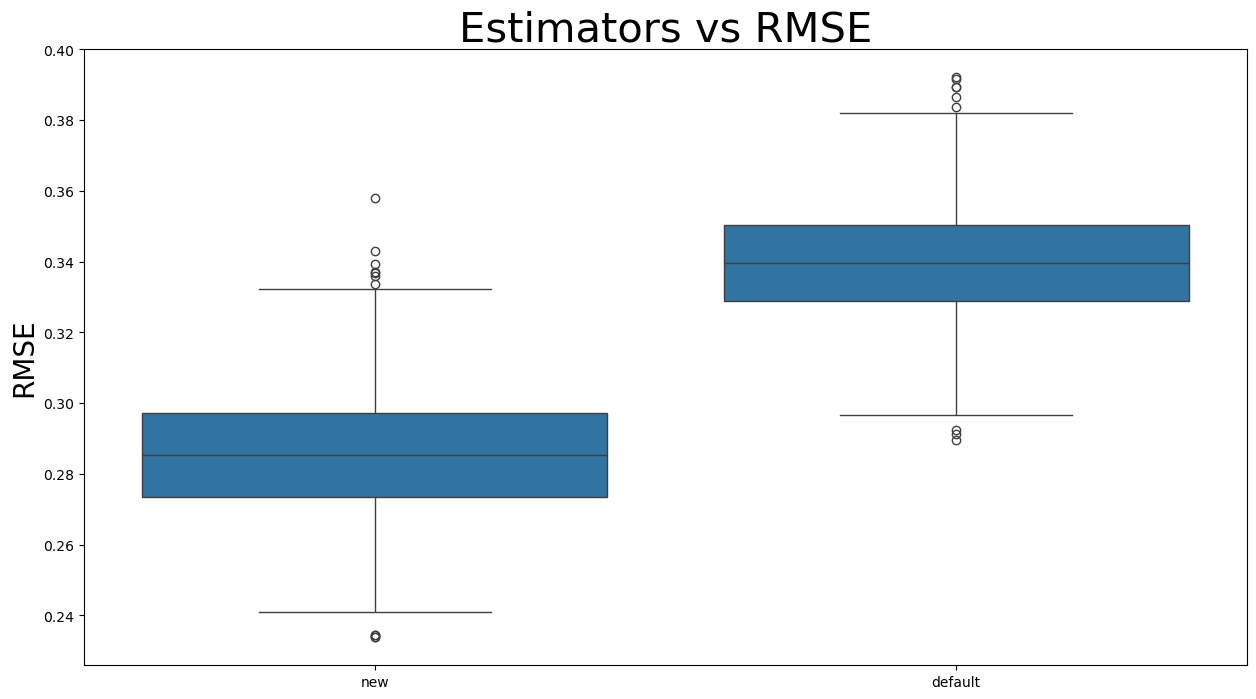

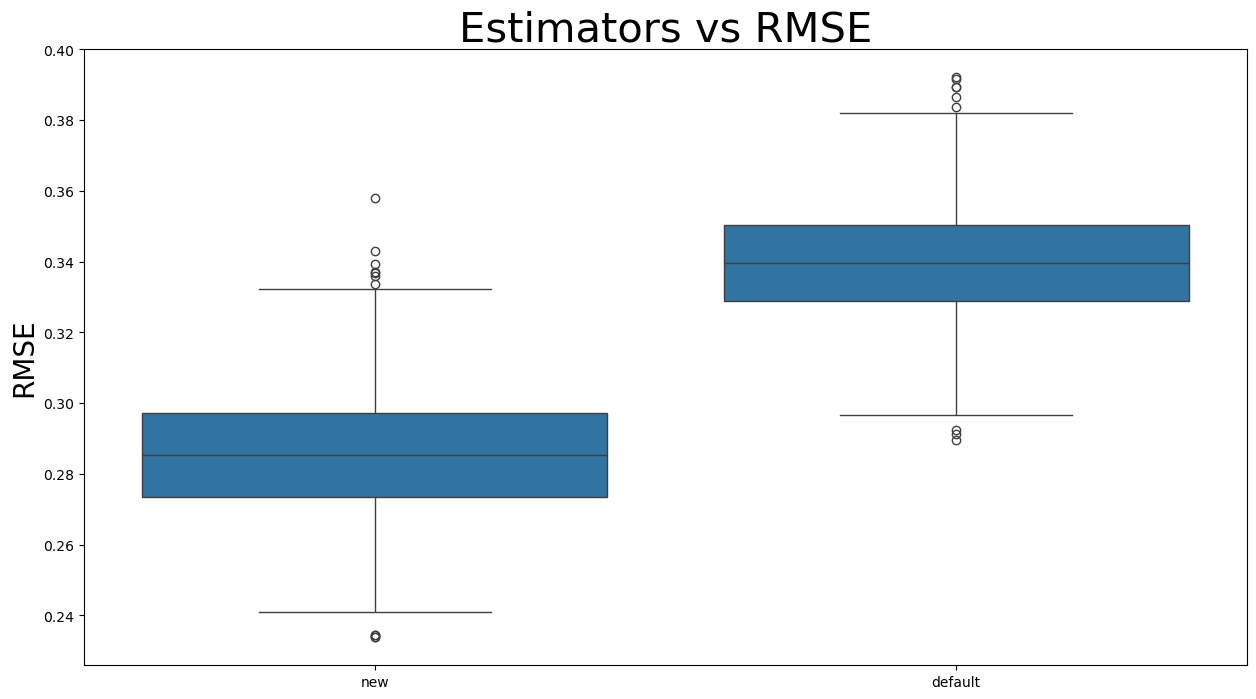

In [122]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

if apply_scaler:
    results_LightGBM = train_and_test_regressor(models_LightGBM, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
plot_model_comparison(results_LightGBM)

In [115]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

In [117]:
optuna.visualization.plot_optimization_history(LightGBM_res)

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [116]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

NotFittedError: No feature_importances found. Need to call fit beforehand.

## TabNet

In [18]:
torch.cuda.is_available()

True

In [19]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : 1
    }

model_name = TabNet

if apply_scaler:
    TabNet_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 20)
else:
    TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 20)
    
with open(f'TabNet_A+I_Eraw_Aug_Scaler_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental fea

Start hyperparameter optimization


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


{'device_name': 'cuda', 'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}
epoch 0  | loss: 60.04922| eval_mse: 64.01374|  0:00:02s
epoch 1  | loss: 60.11011| eval_mse: 334.79671|  0:00:05s
epoch 2  | loss: 59.3889 | eval_mse: 42.0244 |  0:00:08s
epoch 3  | loss: 59.55337| eval_mse: 271.68661|  0:00:10s
epoch 4  | loss: 60.1376 | eval_mse: 55.88923|  0:00:13s
epoch 5  | loss: 60.11707| eval_mse: 249.19149|  0:00:15s
epoch 6  | loss: 59.52466| eval_mse: 61.0651 |  0:00:18s
epoch 7  | loss: 59.60582| eval_mse: 414.02661|  0:00:20s
epoch 8  | loss: 60.2596 | eval_mse: 863.0775|  0:00:23s
epoch 9  | loss: 59.83127| eval_mse: 53.60388|  0:00:26s
epoch 10 | loss: 59.58806| eval_mse: 70.48131|  0:00:28s
epoch 11 | loss: 59.62288| eval_mse: 48.9458 |  0:00:31s
epoch 12 | loss: 60.03659| eval_mse: 107.45825|  0:00:33s
epoch 13 | loss: 59.73866| eval_mse: 310.0901|  0:00:36s
epoch 14 | loss: 59.68517| e

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 59.99664| eval_mse: 48.87995|  0:00:02s
epoch 1  | loss: 59.88753| eval_mse: 116.07905|  0:00:05s
epoch 2  | loss: 59.88209| eval_mse: 94.51876|  0:00:07s
epoch 3  | loss: 60.34225| eval_mse: 42.88724|  0:00:10s
epoch 4  | loss: 59.06366| eval_mse: 3485.07075|  0:00:13s
epoch 5  | loss: 59.38149| eval_mse: 57.42699|  0:00:15s
epoch 6  | loss: 59.86225| eval_mse: 66.37213|  0:00:18s
epoch 7  | loss: 59.14163| eval_mse: 66.35738|  0:00:20s
epoch 8  | loss: 59.67954| eval_mse: 132.81383|  0:00:23s
epoch 9  | loss: 59.56402| eval_mse: 155.84096|  0:00:25s
epoch 10 | loss: 60.06428| eval_mse: 75.05626|  0:00:28s
epoch 11 | loss: 59.73637| eval_mse: 69.4636 |  0:00:31s
epoch 12 | loss: 60.17512| eval_mse: 115.90181|  0:00:33s
epoch 13 | loss: 59.81185| eval_mse: 65.64077|  0:00:36s
epoch 14 | loss: 59.93441| eval_mse: 60.13762|  0:00:38s
epoch 15 | loss: 59.56786| eval_mse: 260.44556|  0:00:41s
epoch 16 | loss: 59.84667| eval_mse: 44.2301 |  0:00:43s
epoch 17 | loss: 59.645 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 59.0842 | eval_mse: 65.2929 |  0:00:02s
epoch 1  | loss: 59.01589| eval_mse: 68.88569|  0:00:05s
epoch 2  | loss: 59.85167| eval_mse: 61.54792|  0:00:07s
epoch 3  | loss: 59.80873| eval_mse: 76.15684|  0:00:10s
epoch 4  | loss: 60.11701| eval_mse: 59.08142|  0:00:13s
epoch 5  | loss: 59.31457| eval_mse: 128.68735|  0:00:15s
epoch 6  | loss: 59.76329| eval_mse: 52.67671|  0:00:18s
epoch 7  | loss: 59.47304| eval_mse: 522.65019|  0:00:20s
epoch 8  | loss: 59.51004| eval_mse: 87.70126|  0:00:23s
epoch 9  | loss: 59.51454| eval_mse: 74.507  |  0:00:25s
epoch 10 | loss: 59.84771| eval_mse: 54.21698|  0:00:28s
epoch 11 | loss: 59.72024| eval_mse: 250.87056|  0:00:31s
epoch 12 | loss: 60.16265| eval_mse: 52.53305|  0:00:33s
epoch 13 | loss: 59.24688| eval_mse: 44.88923|  0:00:36s
epoch 14 | loss: 59.49479| eval_mse: 56.25125|  0:00:38s
epoch 15 | loss: 59.42747| eval_mse: 435.26495|  0:00:41s
epoch 16 | loss: 59.71493| eval_mse: 48.97772|  0:00:43s
epoch 17 | loss: 59.40748| 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 59.67981| eval_mse: 173.29849|  0:00:02s
epoch 1  | loss: 59.63348| eval_mse: 54.84921|  0:00:05s
epoch 2  | loss: 59.78428| eval_mse: 359.13185|  0:00:07s
epoch 3  | loss: 59.90748| eval_mse: 111.26294|  0:00:10s
epoch 4  | loss: 59.73416| eval_mse: 142.18869|  0:00:12s
epoch 5  | loss: 59.64026| eval_mse: 68.0673 |  0:00:15s
epoch 6  | loss: 59.84749| eval_mse: 72.71465|  0:00:18s
epoch 7  | loss: 59.39207| eval_mse: 119.77662|  0:00:20s
epoch 8  | loss: 59.60931| eval_mse: 152.05157|  0:00:23s
epoch 9  | loss: 59.69378| eval_mse: 1691.84961|  0:00:25s
epoch 10 | loss: 59.37674| eval_mse: 60.74625|  0:00:28s
epoch 11 | loss: 59.48853| eval_mse: 4086.95279|  0:00:30s
epoch 12 | loss: 59.9554 | eval_mse: 84.0359 |  0:00:33s
epoch 13 | loss: 59.44355| eval_mse: 44.56311|  0:00:35s
epoch 14 | loss: 59.58967| eval_mse: 286.72741|  0:00:38s
epoch 15 | loss: 59.86521| eval_mse: 1318.67671|  0:00:41s
epoch 16 | loss: 60.0438 | eval_mse: 69.79252|  0:00:43s
epoch 17 | loss: 5

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 59.29204| eval_mse: 103.45008|  0:00:02s
epoch 1  | loss: 59.87954| eval_mse: 57.51999|  0:00:05s
epoch 2  | loss: 60.2051 | eval_mse: 160.12795|  0:00:07s
epoch 3  | loss: 59.22936| eval_mse: 157.08597|  0:00:10s
epoch 4  | loss: 59.67784| eval_mse: 56.32834|  0:00:13s
epoch 5  | loss: 59.61114| eval_mse: 90.07694|  0:00:15s
epoch 6  | loss: 59.93721| eval_mse: 57.08149|  0:00:18s
epoch 7  | loss: 59.3367 | eval_mse: 204.13133|  0:00:20s
epoch 8  | loss: 59.8657 | eval_mse: 416.2103|  0:00:23s
epoch 9  | loss: 59.26822| eval_mse: 58.09732|  0:00:26s
epoch 10 | loss: 59.4643 | eval_mse: 230.92538|  0:00:28s
epoch 11 | loss: 60.22204| eval_mse: 1529.29281|  0:00:31s
epoch 12 | loss: 59.55613| eval_mse: 65.95475|  0:00:33s
epoch 13 | loss: 59.16899| eval_mse: 72.1851 |  0:00:36s
epoch 14 | loss: 60.05437| eval_mse: 94.75164|  0:00:39s
epoch 15 | loss: 59.64194| eval_mse: 616.47095|  0:00:41s
epoch 16 | loss: 60.0462 | eval_mse: 323.73617|  0:00:44s
epoch 17 | loss: 59.46

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[I 2024-02-22 14:51:34,027] Trial 0 finished with value: 6.567768130650973 and parameters: {'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}. Best is trial 0 with value: 6.567768130650973.
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 17, 'gamma': 1.0933732568292283, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.0078233485195872, 'mask_type': 'sparsemax'}
epoch 0  | loss: 115.1096| eval_mse: 628.4025|  0:00:02s
epoch 1  | loss: 115.78457| eval_mse: 271.88397|  0:00:05s
epoch 2  | loss: 115.55057| eval_mse: 141.10986|  0:00:08s
epoch 3  | loss: 114.27408| eval_mse: 88.8904 |  0:00:11s
epoch 4  | loss: 116.44352| eval_mse: 97.76016|  0:00:14s
epoch 5  | loss: 115.70418| eval_mse: 89.73523|  0:00:17s
epoch 6  | loss: 116.41617| eval_mse: 78.35471|  0:00:20s
epoch 7  | loss: 115.10551| eval_mse: 70.95132|  0:00:23s
epoch 8  | loss: 116.20842| eval_mse: 80.59734|  0:00:26s
epoch 9  | loss: 11

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 114.27532| eval_mse: 228.50715|  0:00:02s
epoch 1  | loss: 115.70892| eval_mse: 123.53812|  0:00:05s
epoch 2  | loss: 116.24888| eval_mse: 76.53465|  0:00:08s
epoch 3  | loss: 116.04309| eval_mse: 201.55023|  0:00:11s
epoch 4  | loss: 117.5621| eval_mse: 64.90911|  0:00:14s
epoch 5  | loss: 112.97997| eval_mse: 77.44912|  0:00:17s
epoch 6  | loss: 116.16062| eval_mse: 78.05454|  0:00:20s
epoch 7  | loss: 116.36544| eval_mse: 80.02966|  0:00:23s
epoch 8  | loss: 113.75626| eval_mse: 107.06181|  0:00:26s
epoch 9  | loss: 116.32412| eval_mse: 106.04608|  0:00:29s
epoch 10 | loss: 113.42566| eval_mse: 99.74434|  0:00:32s
epoch 11 | loss: 115.36577| eval_mse: 123.51455|  0:00:34s
epoch 12 | loss: 115.58523| eval_mse: 91.08487|  0:00:37s
epoch 13 | loss: 116.48339| eval_mse: 89.02484|  0:00:40s
epoch 14 | loss: 116.07146| eval_mse: 85.15121|  0:00:43s
epoch 15 | loss: 115.44354| eval_mse: 99.63032|  0:00:46s
epoch 16 | loss: 114.95752| eval_mse: 89.66628|  0:00:49s
epoch 17 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 115.55496| eval_mse: 1003.10016|  0:00:02s
epoch 1  | loss: 114.85188| eval_mse: 148.32268|  0:00:05s
epoch 2  | loss: 114.01385| eval_mse: 132.6338|  0:00:08s
epoch 3  | loss: 116.17264| eval_mse: 133.14611|  0:00:11s
epoch 4  | loss: 114.84956| eval_mse: 108.29849|  0:00:14s
epoch 5  | loss: 115.80178| eval_mse: 102.40231|  0:00:17s
epoch 6  | loss: 114.69912| eval_mse: 95.34586|  0:00:20s
epoch 7  | loss: 117.18409| eval_mse: 80.59248|  0:00:23s
epoch 8  | loss: 114.61615| eval_mse: 145.4859|  0:00:26s
epoch 9  | loss: 115.56698| eval_mse: 161.48283|  0:00:29s
epoch 10 | loss: 116.55835| eval_mse: 126.98907|  0:00:32s
epoch 11 | loss: 114.55849| eval_mse: 105.37437|  0:00:35s
epoch 12 | loss: 114.77578| eval_mse: 132.38257|  0:00:38s
epoch 13 | loss: 115.03094| eval_mse: 94.14937|  0:00:41s
epoch 14 | loss: 115.33699| eval_mse: 85.33461|  0:00:43s
epoch 15 | loss: 114.10371| eval_mse: 104.38126|  0:00:46s
epoch 16 | loss: 115.14968| eval_mse: 95.02798|  0:00:49s
epo

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 115.69643| eval_mse: 853.42059|  0:00:02s
epoch 1  | loss: 116.21771| eval_mse: 98.41147|  0:00:05s
epoch 2  | loss: 115.68498| eval_mse: 88.02096|  0:00:08s
epoch 3  | loss: 114.73823| eval_mse: 124.24132|  0:00:11s
epoch 4  | loss: 116.01751| eval_mse: 226.85143|  0:00:14s
epoch 5  | loss: 115.88633| eval_mse: 116.38964|  0:00:17s
epoch 6  | loss: 114.02994| eval_mse: 149.29071|  0:00:20s
epoch 7  | loss: 114.56125| eval_mse: 194.83553|  0:00:23s
epoch 8  | loss: 115.90489| eval_mse: 167.65734|  0:00:25s
epoch 9  | loss: 114.41636| eval_mse: 107.7585|  0:00:28s
epoch 10 | loss: 113.28243| eval_mse: 416.44002|  0:00:31s
epoch 11 | loss: 115.67516| eval_mse: 129.62531|  0:00:34s
epoch 12 | loss: 115.26461| eval_mse: 136.38324|  0:00:37s
epoch 13 | loss: 115.95936| eval_mse: 197.52953|  0:00:40s
epoch 14 | loss: 115.2992| eval_mse: 99.07222|  0:00:43s
epoch 15 | loss: 115.78293| eval_mse: 138.53777|  0:00:46s
epoch 16 | loss: 116.12021| eval_mse: 168.58874|  0:00:49s
ep

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 113.97841| eval_mse: 585.36948|  0:00:02s
epoch 1  | loss: 114.0458| eval_mse: 98.59909|  0:00:05s
epoch 2  | loss: 114.97629| eval_mse: 97.08968|  0:00:08s
epoch 3  | loss: 114.83921| eval_mse: 87.43317|  0:00:11s
epoch 4  | loss: 117.21623| eval_mse: 102.64728|  0:00:14s
epoch 5  | loss: 114.90628| eval_mse: 95.00499|  0:00:17s
epoch 6  | loss: 116.12924| eval_mse: 91.1883 |  0:00:20s
epoch 7  | loss: 113.55811| eval_mse: 100.79851|  0:00:23s
epoch 8  | loss: 115.6487| eval_mse: 153.48592|  0:00:26s
epoch 9  | loss: 116.0086| eval_mse: 94.13385|  0:00:28s
epoch 10 | loss: 114.87183| eval_mse: 116.73352|  0:00:31s
epoch 11 | loss: 114.92512| eval_mse: 101.53641|  0:00:34s
epoch 12 | loss: 115.90096| eval_mse: 176.373 |  0:00:37s
epoch 13 | loss: 116.39598| eval_mse: 121.76584|  0:00:40s
epoch 14 | loss: 114.2391| eval_mse: 149.82888|  0:00:43s
epoch 15 | loss: 115.64574| eval_mse: 106.21184|  0:00:45s
epoch 16 | loss: 114.22988| eval_mse: 84.74036|  0:00:48s
epoch 17 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[I 2024-02-22 14:59:04,715] Trial 1 finished with value: 8.765890609663115 and parameters: {'n_d': 18, 'n_steps': 17, 'gamma': 1.0933732568292283, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.0078233485195872, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 6.567768130650973.
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 14, 'gamma': 1.2688600578882592, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.0030558696912823184, 'mask_type': 'sparsemax'}
epoch 0  | loss: 25.97988| eval_mse: 221373.56886|  0:00:02s
epoch 1  | loss: 26.91878| eval_mse: 8229.03797|  0:00:04s
epoch 2  | loss: 27.04984| eval_mse: 2851.21905|  0:00:07s
epoch 3  | loss: 29.30687| eval_mse: 1002.08674|  0:00:09s
epoch 4  | loss: 30.22794| eval_mse: 6196.33232|  0:00:12s
epoch 5  | loss: 29.03692| eval_mse: 1661.0511|  0:00:14s
epoch 6  | loss: 25.47439| eval_mse: 1036.89616|  0:00:17s
epoch 7  | loss: 25.5405 | eval_mse: 699.72929|  0:00:19s
epoch 8  | loss: 15.1456 | eval_mse: 445.84682|  0:00:22s
epoch 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 25.00694| eval_mse: 288153.46567|  0:00:02s
epoch 1  | loss: 25.18059| eval_mse: 8334.83522|  0:00:04s
epoch 2  | loss: 23.55743| eval_mse: 4414.75601|  0:00:06s
epoch 3  | loss: 27.30943| eval_mse: 2707.65104|  0:00:09s
epoch 4  | loss: 26.16534| eval_mse: 1453.81255|  0:00:11s
epoch 5  | loss: 23.72168| eval_mse: 1987.66884|  0:00:13s
epoch 6  | loss: 21.05758| eval_mse: 1827.69389|  0:00:16s
epoch 7  | loss: 21.47122| eval_mse: 2382.4264|  0:00:18s
epoch 8  | loss: 9.83284 | eval_mse: 350.44773|  0:00:20s
epoch 9  | loss: 10.64732| eval_mse: 1238.26984|  0:00:22s
epoch 10 | loss: 12.21712| eval_mse: 340.99062|  0:00:25s
epoch 11 | loss: 14.02908| eval_mse: 67.85025|  0:00:27s
epoch 12 | loss: 9.01019 | eval_mse: 68.49287|  0:00:29s
epoch 13 | loss: 15.66025| eval_mse: 42.75025|  0:00:31s
epoch 14 | loss: 6.4618  | eval_mse: 85.49432|  0:00:34s
epoch 15 | loss: 5.26124 | eval_mse: 14.31274|  0:00:36s
epoch 16 | loss: 1.96008 | eval_mse: 18.03107|  0:00:38s
epoch 17 |

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 25.63166| eval_mse: 213298.19891|  0:00:02s
epoch 1  | loss: 27.41379| eval_mse: 7806.9545|  0:00:04s
epoch 2  | loss: 28.15341| eval_mse: 1909.1641|  0:00:06s
epoch 3  | loss: 32.16988| eval_mse: 2277.51161|  0:00:08s
epoch 4  | loss: 27.82423| eval_mse: 1099.33361|  0:00:11s
epoch 5  | loss: 23.45469| eval_mse: 1079.69931|  0:00:13s
epoch 6  | loss: 26.20152| eval_mse: 3325.11262|  0:00:15s
epoch 7  | loss: 22.73159| eval_mse: 889.39372|  0:00:17s
epoch 8  | loss: 13.92315| eval_mse: 199.97974|  0:00:20s
epoch 9  | loss: 8.08718 | eval_mse: 156.25249|  0:00:22s
epoch 10 | loss: 17.93838| eval_mse: 1826.98043|  0:00:24s
epoch 11 | loss: 58.67361| eval_mse: 1161.46053|  0:00:27s
epoch 12 | loss: 21.1685 | eval_mse: 3480.93979|  0:00:29s
epoch 13 | loss: 15.78194| eval_mse: 117.26441|  0:00:31s
epoch 14 | loss: 3.68512 | eval_mse: 6.30705 |  0:00:33s
epoch 15 | loss: 5.24177 | eval_mse: 23.12824|  0:00:36s
epoch 16 | loss: 2.54006 | eval_mse: 27.23286|  0:00:38s
epoch 1

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.78401| eval_mse: 268176.44623|  0:00:02s
epoch 1  | loss: 24.88971| eval_mse: 14588.08808|  0:00:04s
epoch 2  | loss: 22.78899| eval_mse: 2159.68857|  0:00:07s
epoch 3  | loss: 21.41195| eval_mse: 2155.46945|  0:00:09s
epoch 4  | loss: 25.5794 | eval_mse: 540.84015|  0:00:11s
epoch 5  | loss: 24.29461| eval_mse: 394.58736|  0:00:14s
epoch 6  | loss: 18.89795| eval_mse: 405.70505|  0:00:16s
epoch 7  | loss: 15.19908| eval_mse: 649.66314|  0:00:18s
epoch 8  | loss: 13.73131| eval_mse: 162.27575|  0:00:20s
epoch 9  | loss: 7.88249 | eval_mse: 807.96713|  0:00:23s
epoch 10 | loss: 11.46552| eval_mse: 254.02888|  0:00:25s
epoch 11 | loss: 54.13547| eval_mse: 6817.20794|  0:00:27s
epoch 12 | loss: 67.76393| eval_mse: 201.39391|  0:00:30s
epoch 13 | loss: 9.53091 | eval_mse: 383.18817|  0:00:32s
epoch 14 | loss: 14.40904| eval_mse: 216.91862|  0:00:34s
epoch 15 | loss: 13.00425| eval_mse: 157.05773|  0:00:37s
epoch 16 | loss: 11.53759| eval_mse: 16.05595|  0:00:39s
epoch 1

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 23.72163| eval_mse: 447262.89642|  0:00:02s
epoch 1  | loss: 24.69605| eval_mse: 33994.98161|  0:00:04s
epoch 2  | loss: 26.67306| eval_mse: 15058.71598|  0:00:06s
epoch 3  | loss: 25.89082| eval_mse: 2944.33043|  0:00:09s
epoch 4  | loss: 25.22399| eval_mse: 2895.19194|  0:00:11s
epoch 5  | loss: 24.19647| eval_mse: 1215.58666|  0:00:14s
epoch 6  | loss: 26.50347| eval_mse: 1292.08646|  0:00:16s
epoch 7  | loss: 24.74928| eval_mse: 1105.3694|  0:00:18s
epoch 8  | loss: 25.39533| eval_mse: 3116.68728|  0:00:21s
epoch 9  | loss: 15.5379 | eval_mse: 1011.35194|  0:00:23s
epoch 10 | loss: 47.57951| eval_mse: 2036.88943|  0:00:25s
epoch 11 | loss: 9.42626 | eval_mse: 1290.5553|  0:00:27s
epoch 12 | loss: 28.91477| eval_mse: 1296.00144|  0:00:30s
epoch 13 | loss: 10.2413 | eval_mse: 104.75437|  0:00:32s
epoch 14 | loss: 4.31699 | eval_mse: 77.43569|  0:00:34s
epoch 15 | loss: 3.29615 | eval_mse: 86.24479|  0:00:37s
epoch 16 | loss: 5.22498 | eval_mse: 71.3656 |  0:00:39s
ep

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[I 2024-02-22 15:13:31,217] Trial 2 finished with value: 0.9060889973803711 and parameters: {'n_d': 44, 'n_steps': 14, 'gamma': 1.2688600578882592, 'n_independent': 8, 'n_shared': 5, 'momentum': 0.0030558696912823184, 'mask_type': 'sparsemax'}. Best is trial 2 with value: 0.9060889973803711.
{'device_name': 'cuda', 'n_d': 40, 'n_steps': 23, 'gamma': 1.6223388243205816, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.13314761977292472, 'mask_type': 'entmax'}


C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 121.06043| eval_mse: 186.71927|  0:00:02s
epoch 1  | loss: 123.72235| eval_mse: 207.48827|  0:00:05s
epoch 2  | loss: 122.30928| eval_mse: 146.45274|  0:00:08s
epoch 3  | loss: 123.09886| eval_mse: 220.21417|  0:00:11s
epoch 4  | loss: 117.82391| eval_mse: 108.88421|  0:00:14s
epoch 5  | loss: 60.20096| eval_mse: 119.69223|  0:00:17s
epoch 6  | loss: 29.53514| eval_mse: 244.06413|  0:00:20s
epoch 7  | loss: 78.19657| eval_mse: 50.20267|  0:00:23s
epoch 8  | loss: 126.07853| eval_mse: 372.47536|  0:00:26s
epoch 9  | loss: 72.57738| eval_mse: 21.05095|  0:00:29s
epoch 10 | loss: 30.07509| eval_mse: 27.53839|  0:00:32s
epoch 11 | loss: 5.61541 | eval_mse: 12.64823|  0:00:35s
epoch 12 | loss: 20.18476| eval_mse: 5.18979 |  0:00:38s
epoch 13 | loss: 3.5213  | eval_mse: 2.10259 |  0:00:41s
epoch 14 | loss: 3.64773 | eval_mse: 3.42466 |  0:00:44s
epoch 15 | loss: 2.53899 | eval_mse: 2.07226 |  0:00:47s
epoch 16 | loss: 2.11669 | eval_mse: 4.53638 |  0:00:50s
epoch 17 | loss: 

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 125.04007| eval_mse: 107.19507|  0:00:02s
epoch 1  | loss: 135.46869| eval_mse: 149.74623|  0:00:05s
epoch 2  | loss: 133.46467| eval_mse: 126.21103|  0:00:08s
epoch 3  | loss: 124.18854| eval_mse: 161.66581|  0:00:12s
epoch 4  | loss: 122.14053| eval_mse: 83.4852 |  0:00:14s
epoch 5  | loss: 76.40295| eval_mse: 74.83687|  0:00:17s
epoch 6  | loss: 34.11202| eval_mse: 80.49454|  0:00:20s
epoch 7  | loss: 22.12293| eval_mse: 28.5219 |  0:00:23s
epoch 8  | loss: 20.52738| eval_mse: 35.89137|  0:00:26s
epoch 9  | loss: 21.1979 | eval_mse: 62.68256|  0:00:29s
epoch 10 | loss: 24.497  | eval_mse: 7.62742 |  0:00:32s
epoch 11 | loss: 9.78569 | eval_mse: 34.62461|  0:00:35s
epoch 12 | loss: 32.57693| eval_mse: 41.22482|  0:00:38s
epoch 13 | loss: 29.27392| eval_mse: 54.69602|  0:00:41s
epoch 14 | loss: 20.81931| eval_mse: 11.30422|  0:00:44s
epoch 15 | loss: 6.08628 | eval_mse: 2.84808 |  0:00:47s
epoch 16 | loss: 2.78036 | eval_mse: 3.15583 |  0:00:50s
epoch 17 | loss: 2.131

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 124.93695| eval_mse: 120.36048|  0:00:02s
epoch 1  | loss: 128.58947| eval_mse: 155.3465|  0:00:05s
epoch 2  | loss: 134.3015| eval_mse: 236.74234|  0:00:08s
epoch 3  | loss: 136.74992| eval_mse: 138.56227|  0:00:11s
epoch 4  | loss: 126.28301| eval_mse: 201.1706|  0:00:14s
epoch 5  | loss: 72.55948| eval_mse: 159.7072|  0:00:17s
epoch 6  | loss: 63.99689| eval_mse: 428.21493|  0:00:20s
epoch 7  | loss: 165.49057| eval_mse: 61.80043|  0:00:23s
epoch 8  | loss: 29.8059 | eval_mse: 29.60332|  0:00:26s
epoch 9  | loss: 315.4165| eval_mse: 346.30205|  0:00:29s
epoch 10 | loss: 76.31443| eval_mse: 38.07338|  0:00:32s
epoch 11 | loss: 5.45515 | eval_mse: 23.32609|  0:00:35s
epoch 12 | loss: 11.64569| eval_mse: 4.81113 |  0:00:38s
epoch 13 | loss: 3.96381 | eval_mse: 4.64508 |  0:00:41s
epoch 14 | loss: 3.37387 | eval_mse: 3.91476 |  0:00:44s
epoch 15 | loss: 2.02171 | eval_mse: 2.31429 |  0:00:47s
epoch 16 | loss: 1.80407 | eval_mse: 1.98404 |  0:00:50s
epoch 17 | loss: 1.47

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 121.75751| eval_mse: 245.22846|  0:00:02s
epoch 1  | loss: 122.02269| eval_mse: 219.23946|  0:00:05s
epoch 2  | loss: 119.40831| eval_mse: 235.03343|  0:00:09s
epoch 3  | loss: 130.96519| eval_mse: 224.56002|  0:00:11s
epoch 4  | loss: 118.70255| eval_mse: 80.37731|  0:00:14s
epoch 5  | loss: 67.36674| eval_mse: 86.19085|  0:00:17s
epoch 6  | loss: 30.05644| eval_mse: 67.34208|  0:00:20s
epoch 7  | loss: 38.08843| eval_mse: 172.38448|  0:00:23s
epoch 8  | loss: 45.65032| eval_mse: 95.37198|  0:00:26s
epoch 9  | loss: 31.69775| eval_mse: 108.02156|  0:00:29s
epoch 10 | loss: 33.53928| eval_mse: 20.67117|  0:00:32s
epoch 11 | loss: 11.56441| eval_mse: 11.4977 |  0:00:35s
epoch 12 | loss: 7.64978 | eval_mse: 7.68691 |  0:00:38s
epoch 13 | loss: 3.06195 | eval_mse: 6.05661 |  0:00:41s
epoch 14 | loss: 2.06469 | eval_mse: 2.31758 |  0:00:44s
epoch 15 | loss: 1.6845  | eval_mse: 6.94894 |  0:00:47s
epoch 16 | loss: 1.52602 | eval_mse: 4.14856 |  0:00:50s
epoch 17 | loss: 6.0

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 123.32679| eval_mse: 135.96342|  0:00:03s
epoch 1  | loss: 121.91805| eval_mse: 170.56254|  0:00:06s
epoch 2  | loss: 121.2497| eval_mse: 155.56357|  0:00:08s
epoch 3  | loss: 135.09681| eval_mse: 153.30651|  0:00:11s
epoch 4  | loss: 113.34811| eval_mse: 98.53753|  0:00:14s
epoch 5  | loss: 40.34967| eval_mse: 194.28562|  0:00:17s
epoch 6  | loss: 45.13879| eval_mse: 380.03922|  0:00:20s
epoch 7  | loss: 167.62383| eval_mse: 85.27462|  0:00:23s
epoch 8  | loss: 69.56127| eval_mse: 111.67782|  0:00:26s
epoch 9  | loss: 25.14141| eval_mse: 10.93681|  0:00:29s
epoch 10 | loss: 8.25339 | eval_mse: 19.27789|  0:00:32s
epoch 11 | loss: 11.01755| eval_mse: 115.57916|  0:00:35s
epoch 12 | loss: 323.14085| eval_mse: 410.96786|  0:00:38s
epoch 13 | loss: 110.2595| eval_mse: 102.30333|  0:00:41s
epoch 14 | loss: 28.37657| eval_mse: 4.39512 |  0:00:44s
epoch 15 | loss: 2.95765 | eval_mse: 1.92661 |  0:00:47s
epoch 16 | loss: 2.04636 | eval_mse: 1.84598 |  0:00:50s
epoch 17 | loss

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\TorchCUDA\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


[I 2024-02-22 15:30:10,493] Trial 3 finished with value: 0.8529506603480298 and parameters: {'n_d': 40, 'n_steps': 23, 'gamma': 1.6223388243205816, 'n_independent': 6, 'n_shared': 4, 'momentum': 0.13314761977292472, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.8529506603480298.
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 25, 'gamma': 1.3908351244129533, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.26271632515916277, 'mask_type': 'entmax'}
[W 2024-02-22 15:30:11,686] Trial 4 failed with parameters: {'n_d': 36, 'n_steps': 25, 'gamma': 1.3908351244129533, 'n_independent': 13, 'n_shared': 9, 'momentum': 0.26271632515916277, 'mask_type': 'entmax'} because of the following error: RuntimeError('CUDA error: device-side assert triggered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
%debug

> c:\users\alex\appdata\roaming\python\python311\site-packages\pytorch_tabnet\tab_network.py(772)forward()
    770 
    771     def forward(self, x):
--> 772         scale = torch.sqrt(torch.FloatTensor([0.5]).to(x.device))
    773         if self.first:  # the first layer of the block has no scale multiplication
    774             x = self.glu_layers[0](x)

ipdb> x
*** RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
ipdb> u
> c:\programdata\anaconda3\envs\torchcuda\lib\site-packages\torch\nn\modules\module.py(1527)_call_impl()
   1525                 or _global_backward_pre_hooks or _global_backward_hooks
   1526                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1527             return forward_call(*args, **kwargs

In [ ]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(X_test)), Y_test,
                                                    pd.DataFrame(scaler.transform(X_elem)), Y_elem, label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, a_target_width_test,
                                                    a_data_width_elements, a_target_width_elements, a_label_width_elements)'''

In [ ]:
YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
'''results_original = train_and_test_regressor(models_d,
                                            pd.DataFrame(scaler.transform(X_train)), Y_train,
                                            pd.DataFrame(scaler.transform(X_test)), Y_test,
                                            train = False)'''
results_original = train_and_test_regressor(models_d,
                                            X_train, Y_train,
                                            X_test, Y_test,
                                            train = False)
plot_model_comparison(results_original)

## Width. Scaled *targets*

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(a_data_width_test)), np.log(1 + a_target_width_test / epsilon),
                                                    pd.DataFrame(scaler.transform(a_data_width_elements)), np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
'''YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements'''

YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
def train_and_test_regressor_local(models, X_train, y_train, X_test, y_test, max_epochs = 200, patience = 20, train = True):
  predictions = {}
  for name, model in models.items():
    if train == True:
        print(f"Fitting {name}")
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
      
  boot_scores = {}

  for name, y_pred in predictions.items():
      print(f"Calculating bootstrap score for {name}")
      boot_score = bootstrap_metric((np.exp(y_test - 1)) * epsilon, 
                                      (np.exp(y_pred - 1)) * epsilon, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
      boot_scores[name] = boot_score
      
  
  results = pd.DataFrame(boot_scores)
  # cast to long format
  results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
  return results

In [ ]:
results_scaled = train_and_test_regressor_local(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                            train = False)
plot_model_comparison(results_scaled)

## Width. Scaled and augmented

In [ ]:
models = ['KNN_A+I_Extended', 'RF_A+I_StandardScaler_Extended', 'XGB_A+I_v2_StandardScaler_Extended', 'LightGBM_A+I_Extended']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    X_test, Y_test,
                                                    X_elem, Y_elem, L_elem,
                                                  scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
results_augmented = train_and_test_regressor_local(models_d,
                                                data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                train = False)
plot_model_comparison(results_augmented)

## Shift

In [ ]:
models = ['KNN_SHIFT', 'RF_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'LightGBM_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    XS_train, YS_train,
                                                    XS_test, YS_test,
                                                    XS_elem, YS_elem, LS_elem)

In [ ]:
results_shift = train_and_test_regressor(models_d,
                                        XS_train, YS_train,
                                        XS_test, YS_test,
                                         train = False)
plot_model_comparison(results_shift)

# Temperature dependence

In [ ]:
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_extended = data_width.copy()
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)
data_width_extended = data_width_extended.astype(data_width.dtypes.to_dict())
data_width_extended = data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number'])

In [ ]:
#Visualise and confirm that augmentation doesn't change overall temperature distribution
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train, x = 'T')
plt.show()

fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train_extended, x = 'T')
plt.show()

In [ ]:
#Select two lines with the highest number of entries in full dataset
Fe_wavelength = 538.3370
He_wavelength = 667.8150

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(x = data.loc[data['Wavelength'] == Fe_wavelength]['T'], y = data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(x = data.loc[data['Wavelength'] == He_wavelength]['T'], y = data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [ ]:
#Define temperature range in each case
Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
He_temperatures = np.linspace(He_low, He_high, npoints)

#Fe_temperatures = np.linspace(5000, 15000, npoints)
#He_temperatures = np.linspace(15000, 45000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

In [ ]:
scaler = StandardScaler()
scaler.fit(data_width_extended)
models = ['KNN_A+I', 'RF_A+I_StandardScaler', 'XGB_A+I', 'TabNet_A+I_StandardScaler']
models_d = create_models_dict(models)

'''for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended, target_width_extended, data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test)
    else:
        model.fit(data_width_extended, target_width_extended)'''

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(pd.DataFrame(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number']))),
                  target_width,
                  pd.DataFrame(scaler.transform(data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']))),
                  target_width_test)
    else:
        model.fit(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number'])),
                  target_width)

temperature_test_predictions = {}
for name, model in models_d.items():
    temperature_test_predictions[name] = model.predict(pd.DataFrame(scaler.transform(temperature_test_data)))

In [ ]:
scaler = StandardScaler()
scaler.fit(data_width_extended)
models_extended = ['KNN_A+I_Extended', 'RF_A+I_StandardScaler_Extended', 'XGB_A+I_StandardScaler_Extended', 'LightGBM_A+I_Extended']
models_d = create_models_dict(models_extended)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(pd.DataFrame(scaler.transform(data_width_extended)),
                  np.log(1 + target_width_extended / epsilon),
                  pd.DataFrame(scaler.transform(data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']))),
                  np.log(1 + target_width_test / epsilon))
    else:
        model.fit(scaler.transform(data_width_extended), np.log(1 + target_width_extended / epsilon))

temperature_test_predictions_extended = {}
for name, model in models_d.items():
    temperature_test_predictions_extended[name] = model.predict(pd.DataFrame(scaler.transform(temperature_test_data)))

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (20, 16))
for i in range(3):
    ax[i, 0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
    ax[i, 1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

for i in range(len(models)):
    ax[0, 0].plot(Fe_temperatures, temperature_test_predictions[models[i]][:1000], label = f'{models[i]}')
    ax[0, 1].plot(He_temperatures, temperature_test_predictions[models[i]][1000:], label = f'{models[i]}')
    
    #ax[1, 0].plot(Fe_temperatures, (np.exp(temperature_test_predictions_scaled[models_scaled[i]][:1000]) - 1) * epsilon, label = f'{models_scaled[i]}')
    #ax[1, 1].plot(He_temperatures, (np.exp(temperature_test_predictions_scaled[models_scaled[i]][1000:]) - 1) * epsilon, label = f'{models_scaled[i]}')

    ax[2, 0].plot(Fe_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][:1000]) - 1) * epsilon, label = f'{models_extended[i]}')
    ax[2, 1].plot(He_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][1000:]) - 1) * epsilon, label = f'{models_extended[i]}')
    
    

ax[0, 0].set_title(f'Fe I {Fe_wavelength}')
ax[0, 1].set_title(f'He I {He_wavelength}')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[2, 0].legend()
ax[2, 1].legend()

ax[1, 0].set_xlabel('Temperature (K)')
ax[1, 1].set_xlabel('Temperature (K)')

plt.show()

#fig.savefig('Temperature_dependence.svg', format = 'svg', transparent = True)

# Pedicting Stark parameters

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Extended']
models_d = create_models_dict(models)
epsilon = 1e-3

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon))

In [ ]:
data_predictions = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='A:BC'
                   )
data_predictions['Term'] = term_to_number(data_predictions['Term'])
data_predictions['Term.1'] = term_to_number(data_predictions['Term.1'])

In [ ]:
predictions = {}
for name, model in models_d.items():
    predictions[name] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))

In [ ]:
fig, ax = plt.subplots()
for name, model in predictions.items():
    ax.plot((np.exp(model) - 1) * epsilon, label = f'{name}')

plt.legend()
plt.show()

In [ ]:
predictions['XGB_Extended']

np.savetxt('Fe predictions.csv', (np.exp(predictions['XGB_Extended']) - 1) * epsilon, delimiter = ',')

In [ ]:
data_width_extended.describe()

# Auxilary functions

In [ ]:
d = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='BD:BE'
                   )

In [ ]:
with open("insert.txt", "w") as output:
    output.write('insert into starknew (line_id, temp, e_dens, fwhm, alpha, beta, width_ref, shift_ref) \nvalues')
    for index, item in d.iterrows():
        if not np.isnan(item['fwhm']):
            line = f"({item['line_id']}, 7200, 1.0E17, {item['fwhm']}, 0, 0, 19, 19),\n"
            output.write(line)

In [ ]:
with open("delete.txt", "w") as output:
    output.write('delete from starknew where line_id in (')
    for index, item in d.iterrows():
        line = f"{int(item['line_id'])}, "
        output.write(line)
    output.write(')')

# Debugging

In [ ]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import  TabNetRegressor
from warnings import simplefilter
simplefilter("ignore", category=UserWarning)

tabnet = TabNetRegressor()
tabnet.fit(x_learn, y_learn.reshape(-1, 1),
           eval_set = [(x_valid,  y_valid.reshape(-1, 1))])

In [ ]:
!nvidia-smi

In [ ]:
import datetime
print(datetime.datetime.now())
predictions = {}
for i in range(100):
    models = [f'TabNet_Extended']
    models_d = create_models_dict(models)
    epsilon = 1e-3

    for name, model in models_d.items():
        print(f"Training {name}_{i} model")
        if 'TabNet' in name:
            model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
        predictions[f'{name}_{i}'] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))
print(datetime.datetime.now())

In [ ]:
import pickle
with open('100 Predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from IGTD.Scripts.IGTD_Functions import *

In [ ]:
norm_data = min_max_transform(XW_train.to_numpy())

ranking, corr = generate_feature_distance_ranking(norm_data)

pix = generate_matrix_distance_ranking(5, 10)

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,12))
plt.imshow(ranking)
plt.colorbar()
plt.show()

In [ ]:
index_record, err_record, run_time = IGTD_square_error(ranking, pix[1], file_name = 'Resss', save_folder = 'content')

In [ ]:
table_to_image(norm_data, [5, 10], 'Pearson', 'Euclidean', save_image_size = )

In [ ]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

In [ ]:
%debug

In [ ]:
LW_elem

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet', 'LightGBM']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

In [ ]:
%debug

In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape